# Test

In [1]:
import nonlinear_dce
import nonlinear
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from locally_connected import LocallyConnected

/opt/anaconda3/envs/admg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DummyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

dummy_model = DummyModel()

dagma = nonlinear_dce.DagmaDCE(model=dummy_model, use_mle_loss=True)
dims = [5,7,1]
dagma_mlp = nonlinear_dce.DagmaMLP_DCE(dims=dims)
n, d = 100, dims[0]
target = torch.randn(n, d)
output = target + 0.1 * torch.randn(n, d)

A = torch.randn(d, d)
Sigma = A @ A.T + 1e-3 * torch.eye(d)

In [3]:
def get_nonlinear_reg(observed_derivs, observed_hess, m=1e-1):
    # constants on the right device/dtype
    m_t = torch.as_tensor(m, device=observed_hess.device, dtype=observed_hess.dtype)

    # encourage |H| >= m where |J| is large
    # detach H so we don't backprop through second→third order
    gap = torch.clamp_min(m_t - observed_hess.abs().detach(), 0.0)  # [d, d]
    print("gap: ", gap)

    # broadcast over batch n; penalty per (sample, j, k)
    penalty = observed_derivs.abs() * gap  # [n, d, d]

    return penalty.sum()

In [24]:
observed_derivs = torch.tensor([[0.0038, 0.7381], [0.0136,0.0152]])
observed_hess = torch.tensor([[0.0003, 0.0151], [0.0002, 0.0001]])
print(get_nonlinear_reg(observed_derivs, observed_hess))

gap:  tensor([[0.0997, 0.0849],
        [0.0998, 0.0999]])
tensor(0.0659)


## Forward

In [4]:
dagma_mlp.forward(target).shape

torch.Size([100, 5])

## MLE loss

In [19]:
def mle_loss(output: torch.Tensor, target: torch.Tensor, Sigma: torch.Tensor):
    """Computes the MLE loss 1/n*Tr((X-X_est)Sigma^{-1}(X-X_est)^T)"""
    n, d = target.shape
    tmp = torch.linalg.solve(Sigma, (target - output).T)
    mle = torch.trace((target - output)@tmp)/n
    sign, logdet = torch.linalg.slogdet(Sigma)
    mle += logdet
    return mle

In [21]:
n, d = 10, 5
output = torch.randn(n, d)
target = torch.randn(n, d)
Sigma = torch.randn(d, d)
loss_value = mle_loss(output=output, target=target, Sigma=Sigma)
print("MLE loss:", loss_value.item())

MLE loss: 1.8786629388823854


In [22]:
tmp = 0
diff = target - output
for i in range(0,n):
    tmp += diff[i, :]@ torch.inverse(Sigma)@diff[i, :].unsqueeze(1)

logdet = torch.logdet(Sigma)
loss_value2 = tmp/n + logdet
print("MLE loss:", loss_value2.item())

MLE loss: 1.878662938882385


## Ancestral loss

In [6]:
Sigma = torch.tensor([[0.5, 0.3],   
                [0.3, 1.5]])
Wii = torch.diag(torch.diag(Sigma))
W2 = Sigma - Wii

W1 = torch.tensor([[0.0, 1.0],   
                [0.0, 0.0]])
ancestrality =dagma_mlp.ancestrality_loss(W1, W2)
print("ancestrality_loss", ancestrality)

ancestrality_loss tensor(0.0900)


In [7]:
Sigma = torch.tensor([[0.5, 0.8],   
                [0.8, 1.5]])
Wii = torch.diag(torch.diag(Sigma))
W2 = Sigma - Wii

W1 = torch.tensor([[0.0, 1.0],   
                [0.0, 0.0]])
ancestrality =dagma_mlp.ancestrality_loss(W1, W2)
print("ancestrality_loss", ancestrality)

ancestrality_loss tensor(0.6400)


## h_func

In [8]:
W1 = torch.rand(d, d)   # values in [0,1)
W2 = torch.rand(d, d)
h_value =dagma_mlp.h_func(W1, W2)
print("h_value:", h_value.item())

h_value: 4.190249672446955


## Log Cholesky

In [9]:
A = torch.randn(d, d)             
Sigma = A @ A.T + 1e-3 * torch.eye(d)
print("Sigma: ", Sigma)

Sigma:  tensor([[ 6.0858, -1.8737, -2.6806, -0.2402,  2.3097],
        [-1.8737,  2.1774,  1.1716, -0.8645, -1.7391],
        [-2.6806,  1.1716,  1.4572,  0.0255, -1.4567],
        [-0.2402, -0.8645,  0.0255,  1.4165, -0.7480],
        [ 2.3097, -1.7391, -1.4567, -0.7480,  3.4123]])


In [10]:
M = nonlinear_dce.reverse_SPDLogCholesky(Sigma)
print("M: ", M)

M:  tensor([[ 0.9030,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.7595,  0.2352,  0.0000,  0.0000,  0.0000],
        [-1.0866,  0.2737, -0.8007,  0.0000,  0.0000],
        [-0.0974, -0.7418,  0.2734, -0.1230,  0.0000],
        [ 0.9362, -0.8126, -0.4832, -1.2750, -2.0573]])


In [11]:
Sigma = nonlinear_dce.SPDLogCholesky(M)
print("Sigma: ", Sigma)

Sigma:  tensor([[ 6.0858, -1.8737, -2.6806, -0.2402,  2.3097],
        [-1.8737,  2.1774,  1.1716, -0.8645, -1.7391],
        [-2.6806,  1.1716,  1.4572,  0.0255, -1.4567],
        [-0.2402, -0.8645,  0.0255,  1.4165, -0.7480],
        [ 2.3097, -1.7391, -1.4567, -0.7480,  3.4123]])


## Simulation

### random init

In [5]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[0.5, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = 10*torch.sin(x1)
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = 10*torch.sin(x1)+ epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

In [6]:
eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)


  1%|          | 154/29000 [00:00<01:37, 295.09it/s]

Sigma:  tensor([[0.9605, 0.0195],
        [0.0195, 1.0411]], grad_fn=<MmBackward0>)
obj:  tensor(28.6644, grad_fn=<AddBackward0>)
mle loss:  tensor(28.6608, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


  1%|          | 278/29000 [00:01<01:17, 369.52it/s]

Sigma:  tensor([[0.9215, 0.0375],
        [0.0375, 1.0838]], grad_fn=<MmBackward0>)
obj:  tensor(25.5367, grad_fn=<AddBackward0>)
mle loss:  tensor(25.5259, grad_fn=<AddBackward0>)
h_val:  tensor(0.0046, grad_fn=<AddBackward0>)


  1%|          | 359/29000 [00:01<01:14, 383.70it/s]

Sigma:  tensor([[0.8827, 0.0530],
        [0.0530, 1.1273]], grad_fn=<MmBackward0>)
obj:  tensor(22.4602, grad_fn=<AddBackward0>)
mle loss:  tensor(22.4386, grad_fn=<AddBackward0>)
h_val:  tensor(0.0119, grad_fn=<AddBackward0>)


  2%|▏         | 485/29000 [00:01<01:10, 405.97it/s]

Sigma:  tensor([[0.8446, 0.0657],
        [0.0657, 1.1705]], grad_fn=<MmBackward0>)
obj:  tensor(19.4503, grad_fn=<AddBackward0>)
mle loss:  tensor(19.4145, grad_fn=<AddBackward0>)
h_val:  tensor(0.0227, grad_fn=<AddBackward0>)


  2%|▏         | 567/29000 [00:01<01:13, 388.85it/s]

Sigma:  tensor([[0.8078, 0.0760],
        [0.0760, 1.2123]], grad_fn=<MmBackward0>)
obj:  tensor(16.5507, grad_fn=<AddBackward0>)
mle loss:  tensor(16.4949, grad_fn=<AddBackward0>)
h_val:  tensor(0.0396, grad_fn=<AddBackward0>)


  2%|▏         | 651/29000 [00:02<01:10, 404.17it/s]

Sigma:  tensor([[0.7728, 0.0852],
        [0.0852, 1.2522]], grad_fn=<MmBackward0>)
obj:  tensor(13.8229, grad_fn=<AddBackward0>)
mle loss:  tensor(13.7381, grad_fn=<AddBackward0>)
h_val:  tensor(0.0651, grad_fn=<AddBackward0>)


  3%|▎         | 737/29000 [00:02<01:13, 384.41it/s]

Sigma:  tensor([[0.7398, 0.0936],
        [0.0936, 1.2895]], grad_fn=<MmBackward0>)
obj:  tensor(11.3188, grad_fn=<AddBackward0>)
mle loss:  tensor(11.1938, grad_fn=<AddBackward0>)
h_val:  tensor(0.1014, grad_fn=<AddBackward0>)


  3%|▎         | 867/29000 [00:02<01:09, 407.38it/s]

Sigma:  tensor([[0.7086, 0.1011],
        [0.1011, 1.3233]], grad_fn=<MmBackward0>)
obj:  tensor(9.0963, grad_fn=<AddBackward0>)
mle loss:  tensor(8.9182, grad_fn=<AddBackward0>)
h_val:  tensor(0.1504, grad_fn=<AddBackward0>)


  3%|▎         | 950/29000 [00:02<01:09, 402.16it/s]

Sigma:  tensor([[0.6792, 0.1078],
        [0.1078, 1.3534]], grad_fn=<MmBackward0>)
obj:  tensor(7.1946, grad_fn=<AddBackward0>)
mle loss:  tensor(6.9488, grad_fn=<AddBackward0>)
h_val:  tensor(0.2139, grad_fn=<AddBackward0>)


  4%|▎         | 1082/29000 [00:03<01:07, 416.22it/s]

Sigma:  tensor([[0.6512, 0.1135],
        [0.1135, 1.3791]], grad_fn=<MmBackward0>)
obj:  tensor(5.6288, grad_fn=<AddBackward0>)
mle loss:  tensor(5.3002, grad_fn=<AddBackward0>)
h_val:  tensor(0.2923, grad_fn=<AddBackward0>)


  4%|▍         | 1166/29000 [00:03<01:10, 393.63it/s]

Sigma:  tensor([[0.6246, 0.1180],
        [0.1180, 1.4005]], grad_fn=<MmBackward0>)
obj:  tensor(4.3913, grad_fn=<AddBackward0>)
mle loss:  tensor(3.9652, grad_fn=<AddBackward0>)
h_val:  tensor(0.3854, grad_fn=<AddBackward0>)


  4%|▍         | 1248/29000 [00:03<01:09, 396.85it/s]

Sigma:  tensor([[0.5992, 0.1213],
        [0.1213, 1.4176]], grad_fn=<MmBackward0>)
obj:  tensor(3.4480, grad_fn=<AddBackward0>)
mle loss:  tensor(2.9155, grad_fn=<AddBackward0>)
h_val:  tensor(0.4878, grad_fn=<AddBackward0>)


  5%|▍         | 1380/29000 [00:03<01:07, 410.50it/s]

Sigma:  tensor([[0.5749, 0.1233],
        [0.1233, 1.4307]], grad_fn=<MmBackward0>)
obj:  tensor(2.7485, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1066, grad_fn=<AddBackward0>)
h_val:  tensor(0.5937, grad_fn=<AddBackward0>)


  5%|▌         | 1463/29000 [00:04<01:10, 392.93it/s]

Sigma:  tensor([[0.5517, 0.1243],
        [0.1243, 1.4401]], grad_fn=<MmBackward0>)
obj:  tensor(2.2349, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4888, grad_fn=<AddBackward0>)
h_val:  tensor(0.6949, grad_fn=<AddBackward0>)


  5%|▌         | 1544/29000 [00:04<01:10, 391.67it/s]

Sigma:  tensor([[0.5295, 0.1245],
        [0.1245, 1.4465]], grad_fn=<MmBackward0>)
obj:  tensor(1.8552, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0180, grad_fn=<AddBackward0>)
h_val:  tensor(0.7835, grad_fn=<AddBackward0>)


  6%|▌         | 1676/29000 [00:04<01:06, 412.84it/s]

Sigma:  tensor([[0.5082, 0.1239],
        [0.1239, 1.4501]], grad_fn=<MmBackward0>)
obj:  tensor(1.5784, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6616, grad_fn=<AddBackward0>)
h_val:  tensor(0.8610, grad_fn=<AddBackward0>)


  6%|▌         | 1759/29000 [00:04<01:07, 405.23it/s]

Sigma:  tensor([[0.4879, 0.1227],
        [0.1227, 1.4516]], grad_fn=<MmBackward0>)
obj:  tensor(1.3715, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3962, grad_fn=<AddBackward0>)
h_val:  tensor(0.9179, grad_fn=<AddBackward0>)


  6%|▋         | 1841/29000 [00:04<01:07, 400.36it/s]

Sigma:  tensor([[0.4684, 0.1211],
        [0.1211, 1.4512]], grad_fn=<MmBackward0>)
obj:  tensor(1.2155, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2021, grad_fn=<AddBackward0>)
h_val:  tensor(0.9547, grad_fn=<AddBackward0>)


  7%|▋         | 1977/29000 [00:05<01:03, 422.50it/s]

Sigma:  tensor([[0.4497, 0.1192],
        [0.1192, 1.4494]], grad_fn=<MmBackward0>)
obj:  tensor(1.1051, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0607, grad_fn=<AddBackward0>)
h_val:  tensor(0.9846, grad_fn=<AddBackward0>)


  7%|▋         | 2062/29000 [00:05<01:07, 398.70it/s]

Sigma:  tensor([[0.4318, 0.1171],
        [0.1171, 1.4465]], grad_fn=<MmBackward0>)
obj:  tensor(1.0320, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0440, grad_fn=<AddBackward0>)
h_val:  tensor(1.0150, grad_fn=<AddBackward0>)


  7%|▋         | 2144/29000 [00:05<01:07, 398.04it/s]

Sigma:  tensor([[0.4147, 0.1149],
        [0.1149, 1.4427]], grad_fn=<MmBackward0>)
obj:  tensor(0.9699, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1242, grad_fn=<AddBackward0>)
h_val:  tensor(1.0320, grad_fn=<AddBackward0>)


  8%|▊         | 2278/29000 [00:06<01:04, 413.62it/s]

Sigma:  tensor([[0.3983, 0.1126],
        [0.1126, 1.4382]], grad_fn=<MmBackward0>)
obj:  tensor(0.9221, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1890, grad_fn=<AddBackward0>)
h_val:  tensor(1.0480, grad_fn=<AddBackward0>)


  8%|▊         | 2361/29000 [00:06<01:05, 404.47it/s]

Sigma:  tensor([[0.3826, 0.1102],
        [0.1102, 1.4331]], grad_fn=<MmBackward0>)
obj:  tensor(0.8669, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2441, grad_fn=<AddBackward0>)
h_val:  tensor(1.0471, grad_fn=<AddBackward0>)


  8%|▊         | 2442/29000 [00:06<01:06, 397.71it/s]

Sigma:  tensor([[0.3675, 0.1079],
        [0.1079, 1.4276]], grad_fn=<MmBackward0>)
obj:  tensor(0.8155, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2943, grad_fn=<AddBackward0>)
h_val:  tensor(1.0449, grad_fn=<AddBackward0>)


  9%|▉         | 2575/29000 [00:06<01:03, 414.62it/s]

Sigma:  tensor([[0.3530, 0.1055],
        [0.1055, 1.4216]], grad_fn=<MmBackward0>)
obj:  tensor(0.7647, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3413, grad_fn=<AddBackward0>)
h_val:  tensor(1.0402, grad_fn=<AddBackward0>)


  9%|▉         | 2658/29000 [00:06<01:04, 406.74it/s]

Sigma:  tensor([[0.3391, 0.1032],
        [0.1032, 1.4153]], grad_fn=<MmBackward0>)
obj:  tensor(0.7115, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3870, grad_fn=<AddBackward0>)
h_val:  tensor(1.0318, grad_fn=<AddBackward0>)


  9%|▉         | 2739/29000 [00:07<01:10, 373.18it/s]

Sigma:  tensor([[0.3258, 0.1009],
        [0.1009, 1.4086]], grad_fn=<MmBackward0>)
obj:  tensor(0.6615, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4322, grad_fn=<AddBackward0>)
h_val:  tensor(1.0261, grad_fn=<AddBackward0>)


 10%|▉         | 2852/29000 [00:07<01:12, 359.12it/s]

Sigma:  tensor([[0.3130, 0.0987],
        [0.0987, 1.4016]], grad_fn=<MmBackward0>)
obj:  tensor(0.6116, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4769, grad_fn=<AddBackward0>)
h_val:  tensor(1.0197, grad_fn=<AddBackward0>)


 10%|█         | 2972/29000 [00:07<01:07, 387.25it/s]

Sigma:  tensor([[0.3008, 0.0964],
        [0.0964, 1.3942]], grad_fn=<MmBackward0>)
obj:  tensor(0.5505, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5218, grad_fn=<AddBackward0>)
h_val:  tensor(1.0027, grad_fn=<AddBackward0>)


 11%|█         | 3050/29000 [00:08<01:08, 377.01it/s]

Sigma:  tensor([[0.2890, 0.0942],
        [0.0942, 1.3864]], grad_fn=<MmBackward0>)
obj:  tensor(0.4966, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5685, grad_fn=<AddBackward0>)
h_val:  tensor(0.9944, grad_fn=<AddBackward0>)


 11%|█         | 3173/29000 [00:08<01:05, 393.76it/s]

Sigma:  tensor([[0.2777, 0.0920],
        [0.0920, 1.3782]], grad_fn=<MmBackward0>)
obj:  tensor(0.4413, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6157, grad_fn=<AddBackward0>)
h_val:  tensor(0.9851, grad_fn=<AddBackward0>)


 11%|█         | 3253/29000 [00:08<01:05, 391.07it/s]

Sigma:  tensor([[0.2669, 0.0898],
        [0.0898, 1.3695]], grad_fn=<MmBackward0>)
obj:  tensor(0.3790, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6625, grad_fn=<AddBackward0>)
h_val:  tensor(0.9685, grad_fn=<AddBackward0>)


 12%|█▏        | 3377/29000 [00:08<01:03, 400.60it/s]

Sigma:  tensor([[0.2565, 0.0877],
        [0.0877, 1.3605]], grad_fn=<MmBackward0>)
obj:  tensor(0.3225, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7099, grad_fn=<AddBackward0>)
h_val:  tensor(0.9582, grad_fn=<AddBackward0>)


 12%|█▏        | 3458/29000 [00:09<01:04, 395.81it/s]

Sigma:  tensor([[0.2465, 0.0855],
        [0.0855, 1.3509]], grad_fn=<MmBackward0>)
obj:  tensor(0.2697, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7567, grad_fn=<AddBackward0>)
h_val:  tensor(0.9509, grad_fn=<AddBackward0>)


 12%|█▏        | 3583/29000 [00:09<01:02, 406.96it/s]

Sigma:  tensor([[0.2369, 0.0833],
        [0.0833, 1.3410]], grad_fn=<MmBackward0>)
obj:  tensor(0.2063, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8026, grad_fn=<AddBackward0>)
h_val:  tensor(0.9322, grad_fn=<AddBackward0>)


 13%|█▎        | 3664/29000 [00:09<01:04, 394.13it/s]

Sigma:  tensor([[0.2277, 0.0812],
        [0.0812, 1.3305]], grad_fn=<MmBackward0>)
obj:  tensor(0.1440, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8499, grad_fn=<AddBackward0>)
h_val:  tensor(0.9159, grad_fn=<AddBackward0>)


 13%|█▎        | 3743/29000 [00:09<01:05, 385.92it/s]

Sigma:  tensor([[0.2188, 0.0790],
        [0.0790, 1.3196]], grad_fn=<MmBackward0>)
obj:  tensor(0.0935, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8974, grad_fn=<AddBackward0>)
h_val:  tensor(0.9112, grad_fn=<AddBackward0>)


 13%|█▎        | 3873/29000 [00:10<01:02, 401.75it/s]

Sigma:  tensor([[0.2103, 0.0769],
        [0.0769, 1.3081]], grad_fn=<MmBackward0>)
obj:  tensor(0.0402, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9424, grad_fn=<AddBackward0>)
h_val:  tensor(0.9014, grad_fn=<AddBackward0>)


 14%|█▎        | 3953/29000 [00:10<01:05, 383.75it/s]

Sigma:  tensor([[0.2022, 0.0747],
        [0.0747, 1.2962]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0169, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9865, grad_fn=<AddBackward0>)
h_val:  tensor(0.8868, grad_fn=<AddBackward0>)


 14%|█▍        | 3994/29000 [00:10<01:04, 390.46it/s]

Sigma:  tensor([[0.1943, 0.0725],
        [0.0725, 1.2838]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0750, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0324, grad_fn=<AddBackward0>)
h_val:  tensor(0.8729, grad_fn=<AddBackward0>)


 14%|█▍        | 4163/29000 [00:11<01:12, 342.68it/s]

Sigma:  tensor([[0.1868, 0.0704],
        [0.0704, 1.2709]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1256, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0780, grad_fn=<AddBackward0>)
h_val:  tensor(0.8660, grad_fn=<AddBackward0>)


 15%|█▍        | 4242/29000 [00:11<01:08, 359.16it/s]

Sigma:  tensor([[0.1796, 0.0682],
        [0.0682, 1.2575]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1800, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1218, grad_fn=<AddBackward0>)
h_val:  tensor(0.8534, grad_fn=<AddBackward0>)


 15%|█▌        | 4374/29000 [00:11<01:02, 394.53it/s]

Sigma:  tensor([[0.1726, 0.0661],
        [0.0661, 1.2437]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2374, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1664, grad_fn=<AddBackward0>)
h_val:  tensor(0.8385, grad_fn=<AddBackward0>)


 15%|█▌        | 4455/29000 [00:11<01:04, 382.84it/s]

Sigma:  tensor([[0.1660, 0.0639],
        [0.0639, 1.2294]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2950, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2130, grad_fn=<AddBackward0>)
h_val:  tensor(0.8254, grad_fn=<AddBackward0>)


 16%|█▌        | 4578/29000 [00:12<01:01, 395.04it/s]

Sigma:  tensor([[0.1596, 0.0618],
        [0.0618, 1.2147]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3549, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2600, grad_fn=<AddBackward0>)
h_val:  tensor(0.8103, grad_fn=<AddBackward0>)


 16%|█▌        | 4657/29000 [00:12<01:03, 382.28it/s]

Sigma:  tensor([[0.1534, 0.0597],
        [0.0597, 1.1994]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4177, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3082, grad_fn=<AddBackward0>)
h_val:  tensor(0.7934, grad_fn=<AddBackward0>)


 16%|█▋        | 4779/29000 [00:12<01:02, 390.50it/s]

Sigma:  tensor([[0.1475, 0.0575],
        [0.0575, 1.1836]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4833, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3580, grad_fn=<AddBackward0>)
h_val:  tensor(0.7752, grad_fn=<AddBackward0>)


 17%|█▋        | 4859/29000 [00:12<01:02, 388.27it/s]

Sigma:  tensor([[0.1418, 0.0553],
        [0.0553, 1.1673]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5481, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4086, grad_fn=<AddBackward0>)
h_val:  tensor(0.7584, grad_fn=<AddBackward0>)


 17%|█▋        | 4937/29000 [00:13<01:04, 372.03it/s]

Sigma:  tensor([[0.1363, 0.0530],
        [0.0530, 1.1505]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6113, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4597, grad_fn=<AddBackward0>)
h_val:  tensor(0.7435, grad_fn=<AddBackward0>)


 17%|█▋        | 5064/29000 [00:13<01:01, 391.86it/s]

Sigma:  tensor([[0.1311, 0.0508],
        [0.0508, 1.1331]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6741, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5106, grad_fn=<AddBackward0>)
h_val:  tensor(0.7286, grad_fn=<AddBackward0>)


 18%|█▊        | 5143/29000 [00:13<01:02, 381.70it/s]

Sigma:  tensor([[0.1261, 0.0485],
        [0.0485, 1.1152]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7389, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5644, grad_fn=<AddBackward0>)
h_val:  tensor(0.7144, grad_fn=<AddBackward0>)


 18%|█▊        | 5270/29000 [00:13<00:59, 398.94it/s]

Sigma:  tensor([[0.1212, 0.0462],
        [0.0462, 1.0967]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8087, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6202, grad_fn=<AddBackward0>)
h_val:  tensor(0.6972, grad_fn=<AddBackward0>)


 18%|█▊        | 5351/29000 [00:14<01:00, 390.99it/s]

Sigma:  tensor([[0.1166, 0.0438],
        [0.0438, 1.0776]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8783, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6807, grad_fn=<AddBackward0>)
h_val:  tensor(0.6846, grad_fn=<AddBackward0>)


 19%|█▉        | 5476/29000 [00:14<00:58, 402.41it/s]

Sigma:  tensor([[0.1121, 0.0414],
        [0.0414, 1.0579]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9483, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7408, grad_fn=<AddBackward0>)
h_val:  tensor(0.6711, grad_fn=<AddBackward0>)


 19%|█▉        | 5557/29000 [00:14<00:59, 393.53it/s]

Sigma:  tensor([[0.1078, 0.0388],
        [0.0388, 1.0376]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0189, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8008, grad_fn=<AddBackward0>)
h_val:  tensor(0.6571, grad_fn=<AddBackward0>)


 20%|█▉        | 5681/29000 [00:14<00:57, 405.15it/s]

Sigma:  tensor([[0.1037, 0.0363],
        [0.0363, 1.0167]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0965, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8621, grad_fn=<AddBackward0>)
h_val:  tensor(0.6374, grad_fn=<AddBackward0>)


 20%|█▉        | 5762/29000 [00:15<00:59, 388.17it/s]

Sigma:  tensor([[0.0997, 0.0337],
        [0.0337, 0.9952]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1702, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9271, grad_fn=<AddBackward0>)
h_val:  tensor(0.6250, grad_fn=<AddBackward0>)


 20%|██        | 5839/29000 [00:15<01:02, 371.68it/s]

Sigma:  tensor([[0.0959, 0.0311],
        [0.0311, 0.9734]], grad_fn=<MmBackward0>)
obj:  tensor(-1.2407, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9865, grad_fn=<AddBackward0>)
h_val:  tensor(0.6102, grad_fn=<AddBackward0>)


 21%|██        | 5962/29000 [00:15<01:01, 376.00it/s]

Sigma:  tensor([[0.0923, 0.0286],
        [0.0286, 0.9512]], grad_fn=<MmBackward0>)
obj:  tensor(-1.3120, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0479, grad_fn=<AddBackward0>)
h_val:  tensor(0.5965, grad_fn=<AddBackward0>)


 21%|██        | 6038/29000 [00:15<01:01, 375.68it/s]

Sigma:  tensor([[0.0888, 0.0263],
        [0.0263, 0.9287]], grad_fn=<MmBackward0>)
obj:  tensor(-1.3966, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1185, grad_fn=<AddBackward0>)
h_val:  tensor(0.5785, grad_fn=<AddBackward0>)


 21%|██▏       | 6167/29000 [00:16<00:57, 398.46it/s]

Sigma:  tensor([[0.0854, 0.0240],
        [0.0240, 0.9058]], grad_fn=<MmBackward0>)
obj:  tensor(-1.4820, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1923, grad_fn=<AddBackward0>)
h_val:  tensor(0.5627, grad_fn=<AddBackward0>)


 22%|██▏       | 6248/29000 [00:16<01:01, 370.53it/s]

Sigma:  tensor([[0.0821, 0.0216],
        [0.0216, 0.8826]], grad_fn=<MmBackward0>)
obj:  tensor(-1.5615, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2676, grad_fn=<AddBackward0>)
h_val:  tensor(0.5538, grad_fn=<AddBackward0>)


 22%|██▏       | 6376/29000 [00:16<00:55, 407.45it/s]

Sigma:  tensor([[0.0790, 0.0192],
        [0.0192, 0.8590]], grad_fn=<MmBackward0>)
obj:  tensor(-1.6335, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3299, grad_fn=<AddBackward0>)
h_val:  tensor(0.5398, grad_fn=<AddBackward0>)


 22%|██▏       | 6468/29000 [00:17<00:52, 431.95it/s]

Sigma:  tensor([[0.0760, 0.0170],
        [0.0170, 0.8352]], grad_fn=<MmBackward0>)
obj:  tensor(-1.7128, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4022, grad_fn=<AddBackward0>)
h_val:  tensor(0.5288, grad_fn=<AddBackward0>)


 23%|██▎       | 6558/29000 [00:17<00:51, 437.09it/s]

Sigma:  tensor([[0.0731, 0.0150],
        [0.0150, 0.8113]], grad_fn=<MmBackward0>)
obj:  tensor(-1.7917, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4781, grad_fn=<AddBackward0>)
h_val:  tensor(0.5213, grad_fn=<AddBackward0>)


 23%|██▎       | 6647/29000 [00:17<00:53, 420.43it/s]

Sigma:  tensor([[0.0704, 0.0130],
        [0.0130, 0.7873]], grad_fn=<MmBackward0>)
obj:  tensor(-1.8746, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5541, grad_fn=<AddBackward0>)
h_val:  tensor(0.5104, grad_fn=<AddBackward0>)


 23%|██▎       | 6780/29000 [00:17<00:52, 425.92it/s]

Sigma:  tensor([[0.0677, 0.0112],
        [0.0112, 0.7633]], grad_fn=<MmBackward0>)
obj:  tensor(-1.9581, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6312, grad_fn=<AddBackward0>)
h_val:  tensor(0.4997, grad_fn=<AddBackward0>)


 24%|██▎       | 6871/29000 [00:17<00:50, 439.92it/s]

Sigma:  tensor([[0.0652, 0.0094],
        [0.0094, 0.7393]], grad_fn=<MmBackward0>)
obj:  tensor(-2.0416, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7102, grad_fn=<AddBackward0>)
h_val:  tensor(0.4913, grad_fn=<AddBackward0>)


 24%|██▍       | 6963/29000 [00:18<00:49, 448.83it/s]

Sigma:  tensor([[0.0627, 0.0076],
        [0.0076, 0.7154]], grad_fn=<MmBackward0>)
obj:  tensor(-2.1235, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7899, grad_fn=<AddBackward0>)
h_val:  tensor(0.4853, grad_fn=<AddBackward0>)


 25%|██▍       | 7186/29000 [00:18<00:50, 433.89it/s]

Sigma:  tensor([[0.0590, 0.0039],
        [0.0039, 0.6742]], grad_fn=<MmBackward0>)
obj:  tensor(0.1173, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5564, grad_fn=<AddBackward0>)
h_val:  tensor(0.2547, grad_fn=<AddBackward0>)


 25%|██▌       | 7277/29000 [00:18<00:49, 442.55it/s]

Sigma:  tensor([[0.0584, 0.0080],
        [0.0080, 0.6602]], grad_fn=<MmBackward0>)
obj:  tensor(0.0869, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8476, grad_fn=<AddBackward0>)
h_val:  tensor(0.2529, grad_fn=<AddBackward0>)


 25%|██▌       | 7368/29000 [00:19<00:49, 440.15it/s]

Sigma:  tensor([[0.0577, 0.0101],
        [0.0101, 0.6439]], grad_fn=<MmBackward0>)
obj:  tensor(0.0704, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1648, grad_fn=<AddBackward0>)
h_val:  tensor(0.2675, grad_fn=<AddBackward0>)


 26%|██▌       | 7458/29000 [00:19<00:49, 434.37it/s]

Sigma:  tensor([[0.0569, 0.0087],
        [0.0087, 0.6226]], grad_fn=<MmBackward0>)
obj:  tensor(0.0602, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8317, grad_fn=<AddBackward0>)
h_val:  tensor(0.2234, grad_fn=<AddBackward0>)


 26%|██▌       | 7545/29000 [00:19<00:55, 383.49it/s]

Sigma:  tensor([[0.0567, 0.0069],
        [0.0069, 0.6004]], grad_fn=<MmBackward0>)
obj:  tensor(0.0507, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0007, grad_fn=<AddBackward0>)
h_val:  tensor(0.2301, grad_fn=<AddBackward0>)


 26%|██▋       | 7666/29000 [00:19<00:55, 384.74it/s]

Sigma:  tensor([[0.0567, 0.0049],
        [0.0049, 0.5777]], grad_fn=<MmBackward0>)
obj:  tensor(0.0441, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9881, grad_fn=<AddBackward0>)
h_val:  tensor(0.2217, grad_fn=<AddBackward0>)


 27%|██▋       | 7744/29000 [00:20<00:55, 383.06it/s]

Sigma:  tensor([[0.0571, 0.0037],
        [0.0037, 0.5553]], grad_fn=<MmBackward0>)
obj:  tensor(0.0363, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0588, grad_fn=<AddBackward0>)
h_val:  tensor(0.2204, grad_fn=<AddBackward0>)


 27%|██▋       | 7869/29000 [00:20<00:54, 387.52it/s]

Sigma:  tensor([[0.0577, 0.0030],
        [0.0030, 0.5332]], grad_fn=<MmBackward0>)
obj:  tensor(0.0351, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0263, grad_fn=<AddBackward0>)
h_val:  tensor(0.2155, grad_fn=<AddBackward0>)


 27%|██▋       | 7948/29000 [00:20<00:54, 385.94it/s]

Sigma:  tensor([[0.0586, 0.0024],
        [0.0024, 0.5120]], grad_fn=<MmBackward0>)
obj:  tensor(0.0308, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0488, grad_fn=<AddBackward0>)
h_val:  tensor(0.2130, grad_fn=<AddBackward0>)


 28%|██▊       | 8069/29000 [00:20<00:56, 373.63it/s]

Sigma:  tensor([[0.0598, 0.0017],
        [0.0017, 0.4916]], grad_fn=<MmBackward0>)
obj:  tensor(0.0271, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0368, grad_fn=<AddBackward0>)
h_val:  tensor(0.2079, grad_fn=<AddBackward0>)


 28%|██▊       | 8147/29000 [00:21<00:55, 373.51it/s]

Sigma:  tensor([[0.0613, 0.0012],
        [0.0012, 0.4721]], grad_fn=<MmBackward0>)
obj:  tensor(0.0230, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0405, grad_fn=<AddBackward0>)
h_val:  tensor(0.2041, grad_fn=<AddBackward0>)


 29%|██▊       | 8267/29000 [00:21<00:54, 380.58it/s]

Sigma:  tensor([[0.0630, 0.0010],
        [0.0010, 0.4536]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0141, grad_fn=<AddBackward0>)
h_val:  tensor(0.1985, grad_fn=<AddBackward0>)


 29%|██▉       | 8345/29000 [00:21<00:54, 380.87it/s]

Sigma:  tensor([[0.0650, 0.0009],
        [0.0009, 0.4359]], grad_fn=<MmBackward0>)
obj:  tensor(0.0156, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0624, grad_fn=<AddBackward0>)
h_val:  tensor(0.1986, grad_fn=<AddBackward0>)


 29%|██▉       | 8473/29000 [00:21<00:51, 400.96it/s]

Sigma:  tensor([[0.0670, 0.0008],
        [0.0008, 0.4191]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0274, grad_fn=<AddBackward0>)
h_val:  tensor(0.1912, grad_fn=<AddBackward0>)


 29%|██▉       | 8553/29000 [00:22<00:53, 382.10it/s]

Sigma:  tensor([[0.0691, 0.0007],
        [0.0007, 0.4030]], grad_fn=<MmBackward0>)
obj:  tensor(0.0061, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0508, grad_fn=<AddBackward0>)
h_val:  tensor(0.1878, grad_fn=<AddBackward0>)


 30%|██▉       | 8673/29000 [00:22<00:52, 390.48it/s]

Sigma:  tensor([[0.0714, 0.0005],
        [0.0005, 0.3876]], grad_fn=<MmBackward0>)
obj:  tensor(0.0016, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0656, grad_fn=<AddBackward0>)
h_val:  tensor(0.1847, grad_fn=<AddBackward0>)


 30%|███       | 8752/29000 [00:22<00:53, 381.86it/s]

Sigma:  tensor([[0.0737, 0.0005],
        [0.0005, 0.3728]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0035, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0618, grad_fn=<AddBackward0>)
h_val:  tensor(0.1791, grad_fn=<AddBackward0>)


 31%|███       | 8878/29000 [00:23<00:49, 402.93it/s]

Sigma:  tensor([[0.0761, 0.0004],
        [0.0004, 0.3586]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0067, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0480, grad_fn=<AddBackward0>)
h_val:  tensor(0.1745, grad_fn=<AddBackward0>)


 31%|███       | 8958/29000 [00:23<00:52, 382.09it/s]

Sigma:  tensor([[0.0788, 0.0004],
        [0.0004, 0.3450]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0106, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0558, grad_fn=<AddBackward0>)
h_val:  tensor(0.1714, grad_fn=<AddBackward0>)


 31%|███▏      | 9080/29000 [00:23<00:50, 391.45it/s]

Sigma:  tensor([[8.1579e-02, 2.6796e-04],
        [2.6796e-04, 3.3198e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0147, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0558, grad_fn=<AddBackward0>)
h_val:  tensor(0.1672, grad_fn=<AddBackward0>)


 32%|███▏      | 9159/29000 [00:23<00:52, 378.59it/s]

Sigma:  tensor([[8.4517e-02, 2.1941e-04],
        [2.1941e-04, 3.1944e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0188, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0504, grad_fn=<AddBackward0>)
h_val:  tensor(0.1624, grad_fn=<AddBackward0>)


 32%|███▏      | 9280/29000 [00:24<00:49, 396.09it/s]

Sigma:  tensor([[8.7628e-02, 1.4066e-04],
        [1.4066e-04, 3.0740e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0229, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0428, grad_fn=<AddBackward0>)
h_val:  tensor(0.1575, grad_fn=<AddBackward0>)


 32%|███▏      | 9359/29000 [00:24<00:54, 359.65it/s]

Sigma:  tensor([[9.0923e-02, 7.7129e-05],
        [7.7129e-05, 2.9585e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0272, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0376, grad_fn=<AddBackward0>)
h_val:  tensor(0.1527, grad_fn=<AddBackward0>)


 33%|███▎      | 9478/29000 [00:24<00:51, 380.26it/s]

Sigma:  tensor([[9.4391e-02, 1.1691e-05],
        [1.1691e-05, 2.8478e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0311, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0311, grad_fn=<AddBackward0>)
h_val:  tensor(0.1480, grad_fn=<AddBackward0>)


 33%|███▎      | 9554/29000 [00:24<00:53, 360.56it/s]

Sigma:  tensor([[ 9.8034e-02, -4.4477e-05],
        [-4.4477e-05,  2.7416e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0351, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0234, grad_fn=<AddBackward0>)
h_val:  tensor(0.1432, grad_fn=<AddBackward0>)


 33%|███▎      | 9673/29000 [00:25<00:50, 382.73it/s]

Sigma:  tensor([[ 1.0185e-01, -1.0731e-04],
        [-1.0731e-04,  2.6399e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0391, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0159, grad_fn=<AddBackward0>)
h_val:  tensor(0.1384, grad_fn=<AddBackward0>)


 34%|███▎      | 9752/29000 [00:25<00:50, 378.19it/s]

Sigma:  tensor([[ 1.0582e-01, -1.6000e-04],
        [-1.6000e-04,  2.5425e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0429, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0092, grad_fn=<AddBackward0>)
h_val:  tensor(0.1338, grad_fn=<AddBackward0>)


 34%|███▍      | 9871/29000 [00:25<00:49, 384.49it/s]

Sigma:  tensor([[ 1.0994e-01, -2.1177e-04],
        [-2.1177e-04,  2.4492e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0468, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0035, grad_fn=<AddBackward0>)
h_val:  tensor(0.1293, grad_fn=<AddBackward0>)


 34%|███▍      | 9951/29000 [00:25<00:50, 374.97it/s]

Sigma:  tensor([[ 0.1142, -0.0003],
        [-0.0003,  0.2360]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0505, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9966, grad_fn=<AddBackward0>)
h_val:  tensor(0.1249, grad_fn=<AddBackward0>)


 35%|███▍      | 10075/29000 [00:26<00:49, 385.61it/s]

Sigma:  tensor([[ 0.1186, -0.0003],
        [-0.0003,  0.2274]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0541, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9904, grad_fn=<AddBackward0>)
h_val:  tensor(0.1206, grad_fn=<AddBackward0>)


 35%|███▍      | 10114/29000 [00:26<00:49, 381.20it/s]

Sigma:  tensor([[ 0.1230, -0.0003],
        [-0.0003,  0.2192]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0577, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9858, grad_fn=<AddBackward0>)
h_val:  tensor(0.1166, grad_fn=<AddBackward0>)


 35%|███▌      | 10286/29000 [00:26<00:54, 345.91it/s]

Sigma:  tensor([[ 0.1276, -0.0004],
        [-0.0004,  0.2114]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0608, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9808, grad_fn=<AddBackward0>)
h_val:  tensor(0.1129, grad_fn=<AddBackward0>)


 36%|███▌      | 10367/29000 [00:27<00:50, 367.37it/s]

Sigma:  tensor([[ 0.1323, -0.0004],
        [-0.0004,  0.2039]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0641, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9771, grad_fn=<AddBackward0>)
h_val:  tensor(0.1092, grad_fn=<AddBackward0>)


 36%|███▌      | 10446/29000 [00:27<00:49, 374.20it/s]

Sigma:  tensor([[ 0.1370, -0.0005],
        [-0.0005,  0.1967]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0671, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9739, grad_fn=<AddBackward0>)
h_val:  tensor(0.1058, grad_fn=<AddBackward0>)


 36%|███▋      | 10575/29000 [00:27<00:46, 398.67it/s]

Sigma:  tensor([[ 0.1418, -0.0005],
        [-0.0005,  0.1898]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0701, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9711, grad_fn=<AddBackward0>)
h_val:  tensor(0.1025, grad_fn=<AddBackward0>)


 37%|███▋      | 10655/29000 [00:27<00:48, 376.08it/s]

Sigma:  tensor([[ 0.1466, -0.0005],
        [-0.0005,  0.1833]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0729, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9685, grad_fn=<AddBackward0>)
h_val:  tensor(0.0995, grad_fn=<AddBackward0>)


 37%|███▋      | 10777/29000 [00:28<00:46, 389.68it/s]

Sigma:  tensor([[ 0.1515, -0.0005],
        [-0.0005,  0.1770]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0754, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9666, grad_fn=<AddBackward0>)
h_val:  tensor(0.0968, grad_fn=<AddBackward0>)


 37%|███▋      | 10857/29000 [00:28<00:47, 383.19it/s]

Sigma:  tensor([[ 0.1563, -0.0006],
        [-0.0006,  0.1710]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0779, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9670, grad_fn=<AddBackward0>)
h_val:  tensor(0.0942, grad_fn=<AddBackward0>)


 38%|███▊      | 10977/29000 [00:28<00:45, 393.93it/s]

Sigma:  tensor([[ 0.1611, -0.0006],
        [-0.0006,  0.1652]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0802, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9670, grad_fn=<AddBackward0>)
h_val:  tensor(0.0920, grad_fn=<AddBackward0>)


 38%|███▊      | 11056/29000 [00:28<00:48, 373.03it/s]

Sigma:  tensor([[ 0.1658, -0.0006],
        [-0.0006,  0.1597]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0824, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9673, grad_fn=<AddBackward0>)
h_val:  tensor(0.0898, grad_fn=<AddBackward0>)


 39%|███▊      | 11169/29000 [00:29<00:49, 359.07it/s]

Sigma:  tensor([[ 0.1705, -0.0007],
        [-0.0007,  0.1545]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0845, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9686, grad_fn=<AddBackward0>)
h_val:  tensor(0.0879, grad_fn=<AddBackward0>)


 39%|███▉      | 11243/29000 [00:29<00:48, 363.64it/s]

Sigma:  tensor([[ 0.1750, -0.0007],
        [-0.0007,  0.1494]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0863, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9704, grad_fn=<AddBackward0>)
h_val:  tensor(0.0863, grad_fn=<AddBackward0>)


 39%|███▉      | 11360/29000 [00:29<00:50, 348.87it/s]

Sigma:  tensor([[ 0.1794, -0.0007],
        [-0.0007,  0.1447]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0881, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9732, grad_fn=<AddBackward0>)
h_val:  tensor(0.0848, grad_fn=<AddBackward0>)


 40%|███▉      | 11475/29000 [00:30<00:47, 372.01it/s]

Sigma:  tensor([[ 0.1837, -0.0007],
        [-0.0007,  0.1401]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0896, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9764, grad_fn=<AddBackward0>)
h_val:  tensor(0.0836, grad_fn=<AddBackward0>)


 40%|███▉      | 11550/29000 [00:30<00:51, 336.48it/s]

Sigma:  tensor([[ 0.1877, -0.0008],
        [-0.0008,  0.1357]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0911, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9799, grad_fn=<AddBackward0>)
h_val:  tensor(0.0825, grad_fn=<AddBackward0>)


 40%|████      | 11662/29000 [00:30<00:48, 356.52it/s]

Sigma:  tensor([[ 0.1916, -0.0008],
        [-0.0008,  0.1315]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0925, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9842, grad_fn=<AddBackward0>)
h_val:  tensor(0.0815, grad_fn=<AddBackward0>)


 40%|████      | 11738/29000 [00:30<00:48, 358.03it/s]

Sigma:  tensor([[ 0.1952, -0.0008],
        [-0.0008,  0.1276]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0937, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9894, grad_fn=<AddBackward0>)
h_val:  tensor(0.0808, grad_fn=<AddBackward0>)


 41%|████      | 11852/29000 [00:31<00:47, 360.57it/s]

Sigma:  tensor([[ 0.1985, -0.0008],
        [-0.0008,  0.1238]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0950, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9964, grad_fn=<AddBackward0>)
h_val:  tensor(0.0803, grad_fn=<AddBackward0>)


 41%|████▏     | 11973/29000 [00:31<00:44, 378.83it/s]

Sigma:  tensor([[ 0.2016, -0.0008],
        [-0.0008,  0.1202]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0961, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0031, grad_fn=<AddBackward0>)
h_val:  tensor(0.0799, grad_fn=<AddBackward0>)


 42%|████▏     | 12050/29000 [00:31<00:46, 361.55it/s]

Sigma:  tensor([[ 0.2043, -0.0009],
        [-0.0009,  0.1167]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0971, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0116, grad_fn=<AddBackward0>)
h_val:  tensor(0.0798, grad_fn=<AddBackward0>)


 42%|████▏     | 12172/29000 [00:32<00:43, 388.29it/s]

Sigma:  tensor([[ 0.2067, -0.0009],
        [-0.0009,  0.1134]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0981, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0210, grad_fn=<AddBackward0>)
h_val:  tensor(0.0799, grad_fn=<AddBackward0>)


 42%|████▏     | 12249/29000 [00:32<00:44, 374.03it/s]

Sigma:  tensor([[ 0.2088, -0.0009],
        [-0.0009,  0.1103]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0990, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0309, grad_fn=<AddBackward0>)
h_val:  tensor(0.0799, grad_fn=<AddBackward0>)


 43%|████▎     | 12367/29000 [00:32<00:43, 378.97it/s]

Sigma:  tensor([[ 0.2105, -0.0010],
        [-0.0010,  0.1073]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0998, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0423, grad_fn=<AddBackward0>)
h_val:  tensor(0.0803, grad_fn=<AddBackward0>)


 43%|████▎     | 12444/29000 [00:32<00:44, 370.15it/s]

Sigma:  tensor([[ 0.2118, -0.0010],
        [-0.0010,  0.1044]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1006, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0533, grad_fn=<AddBackward0>)
h_val:  tensor(0.0807, grad_fn=<AddBackward0>)


 43%|████▎     | 12562/29000 [00:33<00:44, 367.86it/s]

Sigma:  tensor([[ 0.2128, -0.0010],
        [-0.0010,  0.1017]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1013, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0660, grad_fn=<AddBackward0>)
h_val:  tensor(0.0814, grad_fn=<AddBackward0>)


 44%|████▎     | 12637/29000 [00:33<00:47, 344.27it/s]

Sigma:  tensor([[ 0.2135, -0.0010],
        [-0.0010,  0.0991]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1020, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0795, grad_fn=<AddBackward0>)
h_val:  tensor(0.0821, grad_fn=<AddBackward0>)


 44%|████▍     | 12759/29000 [00:33<00:43, 371.08it/s]

Sigma:  tensor([[ 0.2138, -0.0011],
        [-0.0011,  0.0966]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1025, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0931, grad_fn=<AddBackward0>)
h_val:  tensor(0.0830, grad_fn=<AddBackward0>)


 44%|████▍     | 12837/29000 [00:33<00:49, 328.49it/s]

Sigma:  tensor([[ 0.2138, -0.0011],
        [-0.0011,  0.0943]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1031, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1070, grad_fn=<AddBackward0>)
h_val:  tensor(0.0839, grad_fn=<AddBackward0>)


 45%|████▍     | 12948/29000 [00:34<00:45, 350.25it/s]

Sigma:  tensor([[ 0.2136, -0.0011],
        [-0.0011,  0.0921]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1036, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1228, grad_fn=<AddBackward0>)
h_val:  tensor(0.0850, grad_fn=<AddBackward0>)


 45%|████▌     | 13072/29000 [00:34<00:42, 370.79it/s]

Sigma:  tensor([[ 0.2132, -0.0012],
        [-0.0012,  0.0899]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1040, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1365, grad_fn=<AddBackward0>)
h_val:  tensor(0.0860, grad_fn=<AddBackward0>)


 45%|████▌     | 13149/29000 [00:34<00:42, 369.75it/s]

Sigma:  tensor([[ 0.2125, -0.0012],
        [-0.0012,  0.0879]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1044, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1525, grad_fn=<AddBackward0>)
h_val:  tensor(0.0873, grad_fn=<AddBackward0>)


 46%|████▌     | 13271/29000 [00:35<00:41, 381.28it/s]

Sigma:  tensor([[ 0.2117, -0.0013],
        [-0.0013,  0.0860]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1048, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1678, grad_fn=<AddBackward0>)
h_val:  tensor(0.0885, grad_fn=<AddBackward0>)


 46%|████▌     | 13348/29000 [00:35<00:41, 372.94it/s]

Sigma:  tensor([[ 0.2107, -0.0013],
        [-0.0013,  0.0842]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1052, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1847, grad_fn=<AddBackward0>)
h_val:  tensor(0.0899, grad_fn=<AddBackward0>)


 46%|████▋     | 13472/29000 [00:35<00:40, 387.67it/s]

Sigma:  tensor([[ 0.2096, -0.0013],
        [-0.0013,  0.0824]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1054, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1999, grad_fn=<AddBackward0>)
h_val:  tensor(0.0912, grad_fn=<AddBackward0>)


 47%|████▋     | 13550/29000 [00:35<00:41, 370.95it/s]

Sigma:  tensor([[ 0.2084, -0.0014],
        [-0.0014,  0.0808]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1058, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2164, grad_fn=<AddBackward0>)
h_val:  tensor(0.0925, grad_fn=<AddBackward0>)


 47%|████▋     | 13668/29000 [00:36<00:41, 372.05it/s]

Sigma:  tensor([[ 0.2071, -0.0014],
        [-0.0014,  0.0793]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1061, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2333, grad_fn=<AddBackward0>)
h_val:  tensor(0.0940, grad_fn=<AddBackward0>)


 47%|████▋     | 13744/29000 [00:36<00:41, 367.18it/s]

Sigma:  tensor([[ 0.2058, -0.0015],
        [-0.0015,  0.0778]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1064, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2501, grad_fn=<AddBackward0>)
h_val:  tensor(0.0954, grad_fn=<AddBackward0>)


 48%|████▊     | 13864/29000 [00:36<00:40, 369.62it/s]

Sigma:  tensor([[ 0.2043, -0.0015],
        [-0.0015,  0.0764]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1065, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2657, grad_fn=<AddBackward0>)
h_val:  tensor(0.0970, grad_fn=<AddBackward0>)


 48%|████▊     | 13940/29000 [00:36<00:41, 366.37it/s]

Sigma:  tensor([[ 0.2029, -0.0015],
        [-0.0015,  0.0751]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1068, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2825, grad_fn=<AddBackward0>)
h_val:  tensor(0.0984, grad_fn=<AddBackward0>)


 49%|████▉     | 14149/29000 [00:37<00:38, 382.30it/s]

Sigma:  tensor([[0.2014, 0.0013],
        [0.0013, 0.0735]], grad_fn=<MmBackward0>)
obj:  tensor(0.0444, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0764, grad_fn=<AddBackward0>)
h_val:  tensor(0.0528, grad_fn=<AddBackward0>)


 49%|████▉     | 14273/29000 [00:37<00:37, 390.68it/s]

Sigma:  tensor([[0.2093, 0.0021],
        [0.0021, 0.0753]], grad_fn=<MmBackward0>)
obj:  tensor(0.0269, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4080, grad_fn=<AddBackward0>)
h_val:  tensor(0.0285, grad_fn=<AddBackward0>)


 49%|████▉     | 14350/29000 [00:38<00:56, 257.64it/s]

Sigma:  tensor([[ 0.2190, -0.0005],
        [-0.0005,  0.0778]], grad_fn=<MmBackward0>)
obj:  tensor(0.0169, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6403, grad_fn=<AddBackward0>)
h_val:  tensor(0.0208, grad_fn=<AddBackward0>)


 50%|████▉     | 14463/29000 [00:38<00:44, 325.63it/s]

Sigma:  tensor([[0.2293, 0.0007],
        [0.0007, 0.0802]], grad_fn=<MmBackward0>)
obj:  tensor(0.0101, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5164, grad_fn=<AddBackward0>)
h_val:  tensor(0.0127, grad_fn=<AddBackward0>)


 50%|█████     | 14537/29000 [00:38<00:42, 341.22it/s]

Sigma:  tensor([[ 2.3946e-01, -1.2792e-04],
        [-1.2792e-04,  8.2943e-02]], grad_fn=<MmBackward0>)
obj:  tensor(0.0065, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5464, grad_fn=<AddBackward0>)
h_val:  tensor(0.0094, grad_fn=<AddBackward0>)


 51%|█████     | 14653/29000 [00:39<00:41, 349.44it/s]

Sigma:  tensor([[2.4969e-01, 1.0213e-05],
        [1.0213e-05, 8.5783e-02]], grad_fn=<MmBackward0>)
obj:  tensor(0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5141, grad_fn=<AddBackward0>)
h_val:  tensor(0.0066, grad_fn=<AddBackward0>)


 51%|█████     | 14773/29000 [00:39<00:38, 371.12it/s]

Sigma:  tensor([[2.6021e-01, 4.6238e-05],
        [4.6238e-05, 8.8597e-02]], grad_fn=<MmBackward0>)
obj:  tensor(0.0021, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5798, grad_fn=<AddBackward0>)
h_val:  tensor(0.0053, grad_fn=<AddBackward0>)


 51%|█████     | 14849/29000 [00:39<00:38, 364.69it/s]

Sigma:  tensor([[ 2.7055e-01, -7.2619e-05],
        [-7.2619e-05,  9.1341e-02]], grad_fn=<MmBackward0>)
obj:  tensor(0.0007, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6660, grad_fn=<AddBackward0>)
h_val:  tensor(0.0047, grad_fn=<AddBackward0>)


 52%|█████▏    | 14961/29000 [00:39<00:39, 352.12it/s]

Sigma:  tensor([[ 2.8054e-01, -6.4112e-05],
        [-6.4112e-05,  9.3954e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6871, grad_fn=<AddBackward0>)
h_val:  tensor(0.0039, grad_fn=<AddBackward0>)


 52%|█████▏    | 15076/29000 [00:40<00:37, 372.64it/s]

Sigma:  tensor([[ 2.9032e-01, -7.3888e-05],
        [-7.3888e-05,  9.6459e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0011, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7235, grad_fn=<AddBackward0>)
h_val:  tensor(0.0034, grad_fn=<AddBackward0>)


 52%|█████▏    | 15151/29000 [00:40<00:38, 356.90it/s]

Sigma:  tensor([[ 2.9986e-01, -6.1312e-05],
        [-6.1312e-05,  9.8867e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0017, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7389, grad_fn=<AddBackward0>)
h_val:  tensor(0.0030, grad_fn=<AddBackward0>)


 53%|█████▎    | 15264/29000 [00:40<00:37, 365.64it/s]

Sigma:  tensor([[ 3.0920e-01, -6.7658e-05],
        [-6.7658e-05,  1.0122e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7447, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)


 53%|█████▎    | 15337/29000 [00:41<00:39, 342.17it/s]

Sigma:  tensor([[ 3.1842e-01, -6.2211e-05],
        [-6.2211e-05,  1.0352e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0026, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7495, grad_fn=<AddBackward0>)
h_val:  tensor(0.0022, grad_fn=<AddBackward0>)


 53%|█████▎    | 15449/29000 [00:41<00:38, 349.90it/s]

Sigma:  tensor([[ 3.2750e-01, -6.1475e-05],
        [-6.1475e-05,  1.0580e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0029, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7522, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)


 54%|█████▎    | 15560/29000 [00:41<00:38, 353.13it/s]

Sigma:  tensor([[ 3.3645e-01, -5.8729e-05],
        [-5.8729e-05,  1.0805e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0031, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7555, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 54%|█████▍    | 15677/29000 [00:41<00:35, 372.77it/s]

Sigma:  tensor([[ 3.4524e-01, -5.7307e-05],
        [-5.7307e-05,  1.1026e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0032, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7602, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 54%|█████▍    | 15753/29000 [00:42<00:35, 371.21it/s]

Sigma:  tensor([[ 3.5383e-01, -5.6795e-05],
        [-5.6795e-05,  1.1243e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0034, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7646, grad_fn=<AddBackward0>)
h_val:  tensor(0.0015, grad_fn=<AddBackward0>)


 55%|█████▍    | 15875/29000 [00:42<00:33, 388.30it/s]

Sigma:  tensor([[ 3.6217e-01, -5.5117e-05],
        [-5.5117e-05,  1.1453e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0035, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7685, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


 55%|█████▌    | 15954/29000 [00:42<00:33, 385.86it/s]

Sigma:  tensor([[ 3.7024e-01, -5.3580e-05],
        [-5.3580e-05,  1.1657e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0036, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7704, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


 55%|█████▌    | 16076/29000 [00:43<00:33, 386.21it/s]

Sigma:  tensor([[ 3.7801e-01, -5.3717e-05],
        [-5.3717e-05,  1.1853e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0037, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7726, grad_fn=<AddBackward0>)
h_val:  tensor(0.0013, grad_fn=<AddBackward0>)


 56%|█████▌    | 16152/29000 [00:43<00:36, 352.83it/s]

Sigma:  tensor([[ 3.8549e-01, -5.2880e-05],
        [-5.2880e-05,  1.2040e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7741, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 56%|█████▌    | 16265/29000 [00:43<00:35, 355.16it/s]

Sigma:  tensor([[ 3.9267e-01, -5.1321e-05],
        [-5.1321e-05,  1.2217e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7759, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 56%|█████▋    | 16337/29000 [00:43<00:36, 348.63it/s]

Sigma:  tensor([[ 3.9951e-01, -5.0035e-05],
        [-5.0035e-05,  1.2382e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7773, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 57%|█████▋    | 16460/29000 [00:44<00:32, 380.25it/s]

Sigma:  tensor([[ 4.0602e-01, -4.8527e-05],
        [-4.8527e-05,  1.2534e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7786, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 57%|█████▋    | 16538/29000 [00:44<00:34, 366.03it/s]

Sigma:  tensor([[ 4.1217e-01, -4.6400e-05],
        [-4.6400e-05,  1.2674e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7783, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 57%|█████▋    | 16665/29000 [00:44<00:32, 380.45it/s]

Sigma:  tensor([[ 4.1796e-01, -4.5846e-05],
        [-4.5846e-05,  1.2799e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7822, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 58%|█████▊    | 16743/29000 [00:44<00:32, 378.78it/s]

Sigma:  tensor([[ 4.2331e-01, -4.4916e-05],
        [-4.4916e-05,  1.2911e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7858, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 58%|█████▊    | 16870/29000 [00:45<00:30, 395.13it/s]

Sigma:  tensor([[ 4.2805e-01, -4.5075e-05],
        [-4.5075e-05,  1.3009e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8168, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


 58%|█████▊    | 16949/29000 [00:45<00:32, 373.59it/s]

Sigma:  tensor([[ 4.3174e-01, -4.3375e-05],
        [-4.3375e-05,  1.3094e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7752, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 59%|█████▉    | 17070/29000 [00:45<00:30, 386.68it/s]

Sigma:  tensor([[ 4.3577e-01, -4.3479e-05],
        [-4.3479e-05,  1.3165e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7782, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 59%|█████▉    | 17147/29000 [00:45<00:32, 361.02it/s]

Sigma:  tensor([[ 4.3994e-01, -4.2735e-05],
        [-4.2735e-05,  1.3225e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7739, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 60%|█████▉    | 17264/29000 [00:46<00:31, 378.38it/s]

Sigma:  tensor([[ 4.4386e-01, -4.1664e-05],
        [-4.1664e-05,  1.3274e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7839, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 60%|█████▉    | 17340/29000 [00:46<00:31, 373.29it/s]

Sigma:  tensor([[ 4.4715e-01, -4.0779e-05],
        [-4.0779e-05,  1.3314e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7851, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 60%|██████    | 17464/29000 [00:46<00:30, 382.79it/s]

Sigma:  tensor([[ 4.4993e-01, -4.0194e-05],
        [-4.0194e-05,  1.3345e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7809, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 60%|██████    | 17541/29000 [00:46<00:30, 372.96it/s]

Sigma:  tensor([[ 4.5249e-01, -3.9544e-05],
        [-3.9544e-05,  1.3369e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7674, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 61%|██████    | 17671/29000 [00:47<00:29, 385.23it/s]

Sigma:  tensor([[ 4.5525e-01, -3.8846e-05],
        [-3.8846e-05,  1.3387e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7751, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 61%|██████    | 17750/29000 [00:47<00:30, 374.21it/s]

Sigma:  tensor([[ 4.5769e-01, -3.8206e-05],
        [-3.8206e-05,  1.3399e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7766, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 62%|██████▏   | 17869/29000 [00:47<00:28, 385.43it/s]

Sigma:  tensor([[ 4.5960e-01, -3.8867e-05],
        [-3.8867e-05,  1.3405e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7778, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


 62%|██████▏   | 17947/29000 [00:48<00:29, 380.89it/s]

Sigma:  tensor([[ 4.6102e-01, -3.9490e-05],
        [-3.9490e-05,  1.3408e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8080, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 62%|██████▏   | 18074/29000 [00:48<00:27, 393.79it/s]

Sigma:  tensor([[ 4.6080e-01, -3.8611e-05],
        [-3.8611e-05,  1.3408e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7791, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 63%|██████▎   | 18153/29000 [00:48<00:29, 373.67it/s]

Sigma:  tensor([[ 4.6090e-01, -3.9062e-05],
        [-3.9062e-05,  1.3407e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7858, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 63%|██████▎   | 18277/29000 [00:48<00:27, 396.91it/s]

Sigma:  tensor([[ 4.6141e-01, -3.8952e-05],
        [-3.8952e-05,  1.3403e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7799, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 63%|██████▎   | 18356/29000 [00:49<00:28, 374.99it/s]

Sigma:  tensor([[ 4.6204e-01, -3.8878e-05],
        [-3.8878e-05,  1.3399e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7859, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 64%|██████▎   | 18475/29000 [00:49<00:27, 385.86it/s]

Sigma:  tensor([[ 4.6226e-01, -3.8783e-05],
        [-3.8783e-05,  1.3393e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7924, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


 64%|██████▍   | 18554/29000 [00:49<00:27, 380.56it/s]

Sigma:  tensor([[ 4.6204e-01, -3.9634e-05],
        [-3.9634e-05,  1.3386e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7869, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 64%|██████▍   | 18672/29000 [00:49<00:27, 371.65it/s]

Sigma:  tensor([[ 4.6208e-01, -3.9111e-05],
        [-3.9111e-05,  1.3378e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7769, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 65%|██████▍   | 18750/29000 [00:50<00:27, 376.13it/s]

Sigma:  tensor([[ 4.6330e-01, -3.8496e-05],
        [-3.8496e-05,  1.3369e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7739, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 65%|██████▍   | 18791/29000 [00:50<00:26, 385.65it/s]

Sigma:  tensor([[ 4.6515e-01, -3.8392e-05],
        [-3.8392e-05,  1.3358e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7546, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 65%|██████▌   | 18949/29000 [00:50<00:31, 314.28it/s]

Sigma:  tensor([[ 4.6751e-01, -3.9310e-05],
        [-3.9310e-05,  1.3348e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8129, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 66%|██████▌   | 19072/29000 [00:51<00:27, 362.62it/s]

Sigma:  tensor([[ 4.6576e-01, -3.8709e-05],
        [-3.8709e-05,  1.3341e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7947, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


 66%|██████▌   | 19148/29000 [00:51<00:28, 346.53it/s]

Sigma:  tensor([[ 4.6349e-01, -4.0544e-05],
        [-4.0544e-05,  1.3335e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7943, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 66%|██████▋   | 19265/29000 [00:51<00:26, 368.77it/s]

Sigma:  tensor([[ 4.6213e-01, -3.9754e-05],
        [-3.9754e-05,  1.3332e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7820, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 67%|██████▋   | 19340/29000 [00:52<00:27, 346.94it/s]

Sigma:  tensor([[ 4.6242e-01, -4.0045e-05],
        [-4.0045e-05,  1.3328e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7868, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 67%|██████▋   | 19455/29000 [00:52<00:26, 359.13it/s]

Sigma:  tensor([[ 4.6318e-01, -3.9353e-05],
        [-3.9353e-05,  1.3324e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7878, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 67%|██████▋   | 19571/29000 [00:52<00:26, 362.10it/s]

Sigma:  tensor([[ 4.6367e-01, -3.9452e-05],
        [-3.9452e-05,  1.3318e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7896, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 68%|██████▊   | 19645/29000 [00:52<00:25, 361.58it/s]

Sigma:  tensor([[ 4.6370e-01, -3.9482e-05],
        [-3.9482e-05,  1.3312e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7892, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 68%|██████▊   | 19770/29000 [00:53<00:24, 380.56it/s]

Sigma:  tensor([[ 4.6363e-01, -3.9196e-05],
        [-3.9196e-05,  1.3307e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7897, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 68%|██████▊   | 19847/29000 [00:53<00:24, 369.30it/s]

Sigma:  tensor([[ 4.6354e-01, -3.9410e-05],
        [-3.9410e-05,  1.3301e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7897, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 69%|██████▉   | 19968/29000 [00:53<00:23, 377.70it/s]

Sigma:  tensor([[ 4.6357e-01, -3.9474e-05],
        [-3.9474e-05,  1.3297e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7905, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 69%|██████▉   | 20043/29000 [00:53<00:25, 346.82it/s]

Sigma:  tensor([[ 4.6356e-01, -3.9784e-05],
        [-3.9784e-05,  1.3294e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7912, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 70%|██████▉   | 20164/29000 [00:54<00:23, 376.16it/s]

Sigma:  tensor([[ 4.6346e-01, -3.9252e-05],
        [-3.9252e-05,  1.3290e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7906, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 70%|██████▉   | 20240/29000 [00:54<00:23, 370.86it/s]

Sigma:  tensor([[ 4.6341e-01, -3.9424e-05],
        [-3.9424e-05,  1.3286e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7911, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 70%|███████   | 20368/29000 [00:54<00:22, 391.13it/s]

Sigma:  tensor([[ 4.6337e-01, -3.9527e-05],
        [-3.9527e-05,  1.3282e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7916, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 71%|███████   | 20447/29000 [00:55<00:22, 377.30it/s]

Sigma:  tensor([[ 4.6337e-01, -3.9551e-05],
        [-3.9551e-05,  1.3279e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7918, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 71%|███████   | 20575/29000 [00:55<00:21, 387.42it/s]

Sigma:  tensor([[ 4.6338e-01, -3.9258e-05],
        [-3.9258e-05,  1.3275e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7925, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 71%|███████   | 20654/29000 [00:55<00:22, 376.33it/s]

Sigma:  tensor([[ 4.6338e-01, -3.9411e-05],
        [-3.9411e-05,  1.3269e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7927, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 72%|███████▏  | 20773/29000 [00:55<00:21, 386.91it/s]

Sigma:  tensor([[ 4.6339e-01, -3.9513e-05],
        [-3.9513e-05,  1.3264e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7928, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 72%|███████▏  | 20851/29000 [00:56<00:21, 378.23it/s]

Sigma:  tensor([[ 4.6339e-01, -3.9580e-05],
        [-3.9580e-05,  1.3262e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7929, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 72%|███████▏  | 20969/29000 [00:56<00:21, 366.77it/s]

Sigma:  tensor([[ 4.6340e-01, -3.9690e-05],
        [-3.9690e-05,  1.3262e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7930, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 73%|███████▎  | 21168/29000 [00:56<00:20, 391.24it/s]

Sigma:  tensor([[ 4.5853e-01, -2.5961e-04],
        [-2.5961e-04,  1.3171e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0006, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8199, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 73%|███████▎  | 21247/29000 [00:57<00:20, 375.89it/s]

Sigma:  tensor([[ 4.5671e-01, -1.1279e-04],
        [-1.1279e-04,  1.3164e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0001, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7108, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 74%|███████▎  | 21370/29000 [00:57<00:19, 382.75it/s]

Sigma:  tensor([[ 4.6113e-01, -7.0596e-06],
        [-7.0596e-06,  1.3316e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0002, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6793, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 74%|███████▍  | 21447/29000 [00:57<00:20, 367.53it/s]

Sigma:  tensor([[4.7007e-01, 5.0983e-05],
        [5.0983e-05, 1.3541e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7167, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 74%|███████▍  | 21569/29000 [00:58<00:19, 372.33it/s]

Sigma:  tensor([[ 4.7810e-01, -1.2764e-06],
        [-1.2764e-06,  1.3697e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7218, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 75%|███████▍  | 21644/29000 [00:58<00:20, 363.38it/s]

Sigma:  tensor([[ 4.8204e-01, -2.0615e-05],
        [-2.0615e-05,  1.3785e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7062, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 75%|███████▌  | 21769/29000 [00:58<00:19, 376.50it/s]

Sigma:  tensor([[4.8284e-01, 1.2226e-05],
        [1.2226e-05, 1.3853e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7071, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 75%|███████▌  | 21845/29000 [00:58<00:19, 363.10it/s]

Sigma:  tensor([[ 4.8232e-01, -1.1867e-05],
        [-1.1867e-05,  1.3891e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7123, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 76%|███████▌  | 21968/29000 [00:59<00:18, 373.77it/s]

Sigma:  tensor([[ 4.8117e-01, -1.3233e-06],
        [-1.3233e-06,  1.3895e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7106, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 76%|███████▌  | 22044/29000 [00:59<00:18, 368.08it/s]

Sigma:  tensor([[ 4.8019e-01, -8.9493e-07],
        [-8.9493e-07,  1.3894e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7109, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 76%|███████▋  | 22169/29000 [00:59<00:17, 381.61it/s]

Sigma:  tensor([[ 4.8002e-01, -5.2725e-06],
        [-5.2725e-06,  1.3890e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7110, grad_fn=<AddBackward0>)
h_val:  tensor(9.9916e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22246/29000 [00:59<00:18, 369.63it/s]

Sigma:  tensor([[ 4.8028e-01, -4.5727e-06],
        [-4.5727e-06,  1.3887e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7101, grad_fn=<AddBackward0>)
h_val:  tensor(9.8747e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22370/29000 [01:00<00:17, 386.24it/s]

Sigma:  tensor([[ 4.8046e-01, -3.6906e-06],
        [-3.6906e-06,  1.3889e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7098, grad_fn=<AddBackward0>)
h_val:  tensor(9.2137e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22447/29000 [01:00<00:18, 354.90it/s]

Sigma:  tensor([[ 4.8053e-01, -3.3753e-06],
        [-3.3753e-06,  1.3894e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7093, grad_fn=<AddBackward0>)
h_val:  tensor(8.9997e-05, grad_fn=<AddBackward0>)


 78%|███████▊  | 22566/29000 [01:00<00:17, 376.10it/s]

Sigma:  tensor([[ 4.8051e-01, -3.4344e-06],
        [-3.4344e-06,  1.3900e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7090, grad_fn=<AddBackward0>)
h_val:  tensor(8.3656e-05, grad_fn=<AddBackward0>)


 78%|███████▊  | 22642/29000 [01:00<00:17, 372.23it/s]

Sigma:  tensor([[ 4.8046e-01, -3.5508e-06],
        [-3.5508e-06,  1.3907e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7083, grad_fn=<AddBackward0>)
h_val:  tensor(7.3602e-05, grad_fn=<AddBackward0>)


 79%|███████▊  | 22770/29000 [01:01<00:16, 388.87it/s]

Sigma:  tensor([[ 4.8046e-01, -3.6938e-06],
        [-3.6938e-06,  1.3915e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7082, grad_fn=<AddBackward0>)
h_val:  tensor(6.6103e-05, grad_fn=<AddBackward0>)


 79%|███████▉  | 22849/29000 [01:01<00:16, 376.04it/s]

Sigma:  tensor([[ 4.8046e-01, -3.5734e-06],
        [-3.5734e-06,  1.3922e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7077, grad_fn=<AddBackward0>)
h_val:  tensor(6.0934e-05, grad_fn=<AddBackward0>)


 79%|███████▉  | 22973/29000 [01:01<00:15, 385.56it/s]

Sigma:  tensor([[ 4.8047e-01, -3.5655e-06],
        [-3.5655e-06,  1.3927e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7078, grad_fn=<AddBackward0>)
h_val:  tensor(5.9878e-05, grad_fn=<AddBackward0>)


 79%|███████▉  | 23050/29000 [01:02<00:16, 364.86it/s]

Sigma:  tensor([[ 4.8048e-01, -3.5450e-06],
        [-3.5450e-06,  1.3929e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7076, grad_fn=<AddBackward0>)
h_val:  tensor(5.8662e-05, grad_fn=<AddBackward0>)


 80%|███████▉  | 23167/29000 [01:02<00:15, 375.27it/s]

Sigma:  tensor([[ 4.8048e-01, -3.6030e-06],
        [-3.6030e-06,  1.3929e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7076, grad_fn=<AddBackward0>)
h_val:  tensor(4.5431e-05, grad_fn=<AddBackward0>)


 80%|████████  | 23242/29000 [01:02<00:15, 367.10it/s]

Sigma:  tensor([[ 4.8047e-01, -3.5542e-06],
        [-3.5542e-06,  1.3930e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(4.5715e-05, grad_fn=<AddBackward0>)


 81%|████████  | 23364/29000 [01:02<00:15, 365.93it/s]

Sigma:  tensor([[ 4.8045e-01, -3.6134e-06],
        [-3.6134e-06,  1.3933e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7074, grad_fn=<AddBackward0>)
h_val:  tensor(4.3510e-05, grad_fn=<AddBackward0>)


 81%|████████  | 23439/29000 [01:03<00:15, 357.61it/s]

Sigma:  tensor([[ 4.8046e-01, -3.5532e-06],
        [-3.5532e-06,  1.3935e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7069, grad_fn=<AddBackward0>)
h_val:  tensor(4.2096e-05, grad_fn=<AddBackward0>)


 81%|████████▏ | 23566/29000 [01:03<00:14, 371.93it/s]

Sigma:  tensor([[ 4.8059e-01, -3.6099e-06],
        [-3.6099e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(4.1360e-05, grad_fn=<AddBackward0>)


 82%|████████▏ | 23641/29000 [01:03<00:14, 360.13it/s]

Sigma:  tensor([[ 4.8047e-01, -3.5941e-06],
        [-3.5941e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(4.0429e-05, grad_fn=<AddBackward0>)


 82%|████████▏ | 23764/29000 [01:03<00:14, 360.55it/s]

Sigma:  tensor([[ 4.8046e-01, -3.6021e-06],
        [-3.6021e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7071, grad_fn=<AddBackward0>)
h_val:  tensor(3.8134e-05, grad_fn=<AddBackward0>)


 82%|████████▏ | 23801/29000 [01:04<00:15, 338.32it/s]

Sigma:  tensor([[ 4.8047e-01, -3.6014e-06],
        [-3.6014e-06,  1.3935e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(3.4131e-05, grad_fn=<AddBackward0>)


 83%|████████▎ | 23956/29000 [01:04<00:16, 313.43it/s]

Sigma:  tensor([[ 4.8046e-01, -3.5954e-06],
        [-3.5954e-06,  1.3935e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(3.2827e-05, grad_fn=<AddBackward0>)


 83%|████████▎ | 24077/29000 [01:05<00:13, 360.65it/s]

Sigma:  tensor([[ 4.8049e-01, -3.5993e-06],
        [-3.5993e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(3.2034e-05, grad_fn=<AddBackward0>)


 83%|████████▎ | 24154/29000 [01:05<00:13, 357.19it/s]

Sigma:  tensor([[ 4.8052e-01, -3.6169e-06],
        [-3.6169e-06,  1.3937e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(3.1345e-05, grad_fn=<AddBackward0>)


 84%|████████▎ | 24270/29000 [01:05<00:13, 362.79it/s]

Sigma:  tensor([[ 4.8050e-01, -3.6183e-06],
        [-3.6183e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7070, grad_fn=<AddBackward0>)
h_val:  tensor(3.0404e-05, grad_fn=<AddBackward0>)


 84%|████████▍ | 24345/29000 [01:05<00:13, 356.53it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6037e-06],
        [-3.6037e-06,  1.3936e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7071, grad_fn=<AddBackward0>)
h_val:  tensor(3.0001e-05, grad_fn=<AddBackward0>)


 84%|████████▍ | 24460/29000 [01:06<00:12, 353.08it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6554e-06],
        [-3.6554e-06,  1.3934e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7074, grad_fn=<AddBackward0>)
h_val:  tensor(2.9385e-05, grad_fn=<AddBackward0>)


 85%|████████▍ | 24572/29000 [01:06<00:12, 365.18it/s]

Sigma:  tensor([[ 4.8048e-01, -3.5822e-06],
        [-3.5822e-06,  1.3930e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7075, grad_fn=<AddBackward0>)
h_val:  tensor(2.5616e-05, grad_fn=<AddBackward0>)


 85%|████████▍ | 24645/29000 [01:06<00:12, 336.25it/s]

Sigma:  tensor([[ 4.8050e-01, -3.5830e-06],
        [-3.5830e-06,  1.3927e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7075, grad_fn=<AddBackward0>)
h_val:  tensor(2.8086e-05, grad_fn=<AddBackward0>)


 85%|████████▌ | 24761/29000 [01:07<00:11, 354.62it/s]

Sigma:  tensor([[ 4.8050e-01, -3.6195e-06],
        [-3.6195e-06,  1.3930e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(2.3564e-05, grad_fn=<AddBackward0>)


 86%|████████▌ | 24876/29000 [01:07<00:11, 368.49it/s]

Sigma:  tensor([[ 4.8054e-01, -3.6357e-06],
        [-3.6357e-06,  1.3934e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7073, grad_fn=<AddBackward0>)
h_val:  tensor(2.3869e-05, grad_fn=<AddBackward0>)


 86%|████████▌ | 24951/29000 [01:07<00:11, 360.48it/s]

Sigma:  tensor([[ 4.8045e-01, -3.6440e-06],
        [-3.6440e-06,  1.3932e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7076, grad_fn=<AddBackward0>)
h_val:  tensor(2.5612e-05, grad_fn=<AddBackward0>)


 86%|████████▋ | 25061/29000 [01:07<00:11, 338.06it/s]

Sigma:  tensor([[ 4.8052e-01, -3.5856e-06],
        [-3.5856e-06,  1.3928e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(2.2344e-05, grad_fn=<AddBackward0>)


 87%|████████▋ | 25173/29000 [01:08<00:10, 360.40it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6313e-06],
        [-3.6313e-06,  1.3931e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7074, grad_fn=<AddBackward0>)
h_val:  tensor(2.0761e-05, grad_fn=<AddBackward0>)


 87%|████████▋ | 25246/29000 [01:08<00:10, 352.38it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6561e-06],
        [-3.6561e-06,  1.3931e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7076, grad_fn=<AddBackward0>)
h_val:  tensor(2.3404e-05, grad_fn=<AddBackward0>)


 87%|████████▋ | 25362/29000 [01:08<00:09, 366.67it/s]

Sigma:  tensor([[ 4.8048e-01, -3.5513e-06],
        [-3.5513e-06,  1.3926e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(1.5856e-05, grad_fn=<AddBackward0>)


 88%|████████▊ | 25489/29000 [01:09<00:08, 407.20it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6068e-06],
        [-3.6068e-06,  1.3934e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7072, grad_fn=<AddBackward0>)
h_val:  tensor(1.5115e-05, grad_fn=<AddBackward0>)


 88%|████████▊ | 25580/29000 [01:09<00:08, 427.46it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6395e-06],
        [-3.6395e-06,  1.3932e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7074, grad_fn=<AddBackward0>)
h_val:  tensor(1.6121e-05, grad_fn=<AddBackward0>)


 88%|████████▊ | 25665/29000 [01:09<00:08, 403.70it/s]

Sigma:  tensor([[ 4.8050e-01, -3.5513e-06],
        [-3.5513e-06,  1.3925e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7075, grad_fn=<AddBackward0>)
h_val:  tensor(1.5659e-05, grad_fn=<AddBackward0>)


 89%|████████▉ | 25748/29000 [01:09<00:08, 406.15it/s]

Sigma:  tensor([[ 4.8049e-01, -3.5905e-06],
        [-3.5905e-06,  1.3927e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7075, grad_fn=<AddBackward0>)
h_val:  tensor(1.5208e-05, grad_fn=<AddBackward0>)


 89%|████████▉ | 25879/29000 [01:09<00:07, 424.66it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6241e-06],
        [-3.6241e-06,  1.3926e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7078, grad_fn=<AddBackward0>)
h_val:  tensor(1.7038e-05, grad_fn=<AddBackward0>)


 90%|████████▉ | 25965/29000 [01:10<00:07, 421.50it/s]

Sigma:  tensor([[ 4.8052e-01, -3.6453e-06],
        [-3.6453e-06,  1.3921e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7080, grad_fn=<AddBackward0>)
h_val:  tensor(1.6790e-05, grad_fn=<AddBackward0>)


 90%|████████▉ | 26051/29000 [01:10<00:07, 419.34it/s]

Sigma:  tensor([[ 4.8048e-01, -3.6472e-06],
        [-3.6472e-06,  1.3921e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7080, grad_fn=<AddBackward0>)
h_val:  tensor(1.6289e-05, grad_fn=<AddBackward0>)


 90%|█████████ | 26182/29000 [01:10<00:06, 425.13it/s]

Sigma:  tensor([[ 4.8051e-01, -3.6535e-06],
        [-3.6535e-06,  1.3921e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7081, grad_fn=<AddBackward0>)
h_val:  tensor(1.6042e-05, grad_fn=<AddBackward0>)


 91%|█████████ | 26268/29000 [01:10<00:06, 415.22it/s]

Sigma:  tensor([[ 4.8048e-01, -3.6621e-06],
        [-3.6621e-06,  1.3920e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7082, grad_fn=<AddBackward0>)
h_val:  tensor(1.5635e-05, grad_fn=<AddBackward0>)


 91%|█████████ | 26357/29000 [01:11<00:06, 430.78it/s]

Sigma:  tensor([[ 4.8050e-01, -3.6704e-06],
        [-3.6704e-06,  1.3919e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7083, grad_fn=<AddBackward0>)
h_val:  tensor(1.5310e-05, grad_fn=<AddBackward0>)


 91%|█████████ | 26445/29000 [01:11<00:05, 431.40it/s]

Sigma:  tensor([[ 4.8053e-01, -3.6802e-06],
        [-3.6802e-06,  1.3917e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7083, grad_fn=<AddBackward0>)
h_val:  tensor(1.5891e-05, grad_fn=<AddBackward0>)


 92%|█████████▏| 26582/29000 [01:11<00:05, 444.78it/s]

Sigma:  tensor([[ 4.8038e-01, -3.6691e-06],
        [-3.6691e-06,  1.3915e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7085, grad_fn=<AddBackward0>)
h_val:  tensor(1.4814e-05, grad_fn=<AddBackward0>)


 92%|█████████▏| 26672/29000 [01:11<00:05, 434.41it/s]

Sigma:  tensor([[ 4.8068e-01, -3.6728e-06],
        [-3.6728e-06,  1.3917e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7087, grad_fn=<AddBackward0>)
h_val:  tensor(1.4374e-05, grad_fn=<AddBackward0>)


 92%|█████████▏| 26760/29000 [01:11<00:05, 423.74it/s]

Sigma:  tensor([[ 4.8047e-01, -3.6629e-06],
        [-3.6629e-06,  1.3914e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7088, grad_fn=<AddBackward0>)
h_val:  tensor(1.4215e-05, grad_fn=<AddBackward0>)


 93%|█████████▎| 26847/29000 [01:12<00:05, 422.21it/s]

Sigma:  tensor([[ 4.8046e-01, -3.6946e-06],
        [-3.6946e-06,  1.3913e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7086, grad_fn=<AddBackward0>)
h_val:  tensor(1.2693e-05, grad_fn=<AddBackward0>)


 93%|█████████▎| 26984/29000 [01:12<00:04, 441.29it/s]

Sigma:  tensor([[ 4.8054e-01, -3.6954e-06],
        [-3.6954e-06,  1.3912e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7087, grad_fn=<AddBackward0>)
h_val:  tensor(1.2709e-05, grad_fn=<AddBackward0>)


 93%|█████████▎| 27075/29000 [01:12<00:04, 443.72it/s]

Sigma:  tensor([[ 4.8051e-01, -3.6569e-06],
        [-3.6569e-06,  1.3910e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7086, grad_fn=<AddBackward0>)
h_val:  tensor(9.4986e-06, grad_fn=<AddBackward0>)


 94%|█████████▎| 27165/29000 [01:12<00:04, 440.15it/s]

Sigma:  tensor([[ 4.8049e-01, -3.7168e-06],
        [-3.7168e-06,  1.3908e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7093, grad_fn=<AddBackward0>)
h_val:  tensor(1.2624e-05, grad_fn=<AddBackward0>)


 94%|█████████▍| 27255/29000 [01:13<00:03, 440.50it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6606e-06],
        [-3.6606e-06,  1.3907e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7087, grad_fn=<AddBackward0>)
h_val:  tensor(9.1627e-06, grad_fn=<AddBackward0>)


 94%|█████████▍| 27392/29000 [01:13<00:03, 448.43it/s]

Sigma:  tensor([[ 4.8024e-01, -3.6575e-06],
        [-3.6575e-06,  1.3906e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7094, grad_fn=<AddBackward0>)
h_val:  tensor(1.1882e-05, grad_fn=<AddBackward0>)


 95%|█████████▍| 27482/29000 [01:13<00:03, 443.82it/s]

Sigma:  tensor([[ 4.8025e-01, -3.6382e-06],
        [-3.6382e-06,  1.3905e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7095, grad_fn=<AddBackward0>)
h_val:  tensor(1.1927e-05, grad_fn=<AddBackward0>)


 95%|█████████▌| 27572/29000 [01:13<00:03, 424.84it/s]

Sigma:  tensor([[ 4.8072e-01, -3.6361e-06],
        [-3.6361e-06,  1.3900e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7094, grad_fn=<AddBackward0>)
h_val:  tensor(1.1527e-05, grad_fn=<AddBackward0>)


 95%|█████████▌| 27658/29000 [01:14<00:03, 420.00it/s]

Sigma:  tensor([[ 4.8075e-01, -3.7034e-06],
        [-3.7034e-06,  1.3901e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7096, grad_fn=<AddBackward0>)
h_val:  tensor(1.1244e-05, grad_fn=<AddBackward0>)


 96%|█████████▌| 27748/29000 [01:14<00:02, 431.80it/s]

Sigma:  tensor([[ 4.8062e-01, -3.7131e-06],
        [-3.7131e-06,  1.3900e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7096, grad_fn=<AddBackward0>)
h_val:  tensor(1.0666e-05, grad_fn=<AddBackward0>)


 96%|█████████▌| 27885/29000 [01:14<00:02, 445.38it/s]

Sigma:  tensor([[ 4.8052e-01, -3.6766e-06],
        [-3.6766e-06,  1.3899e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7096, grad_fn=<AddBackward0>)
h_val:  tensor(1.0645e-05, grad_fn=<AddBackward0>)


 96%|█████████▋| 27977/29000 [01:14<00:02, 448.80it/s]

Sigma:  tensor([[ 4.8049e-01, -3.6886e-06],
        [-3.6886e-06,  1.3897e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7098, grad_fn=<AddBackward0>)
h_val:  tensor(1.0828e-05, grad_fn=<AddBackward0>)


100%|██████████| 29000/29000 [01:14<00:00, 387.55it/s]

Sigma:  tensor([[ 4.8047e-01, -3.6851e-06],
        [-3.6851e-06,  1.3894e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7100, grad_fn=<AddBackward0>)
h_val:  tensor(1.0779e-05, grad_fn=<AddBackward0>)


In [7]:
print("W_est_dce_no_thresh: ", W_est_dce_no_thresh)

W_est_dce_no_thresh:  tensor([[1.0140e-03, 8.1792e+00],
        [1.2414e-04, 2.9524e-03]], grad_fn=<SqrtBackward0>)


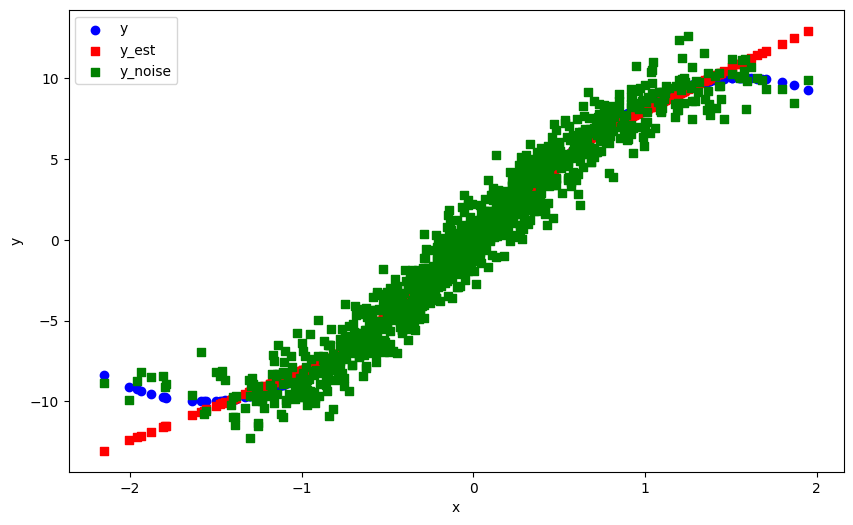

The programm is closed


In [8]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

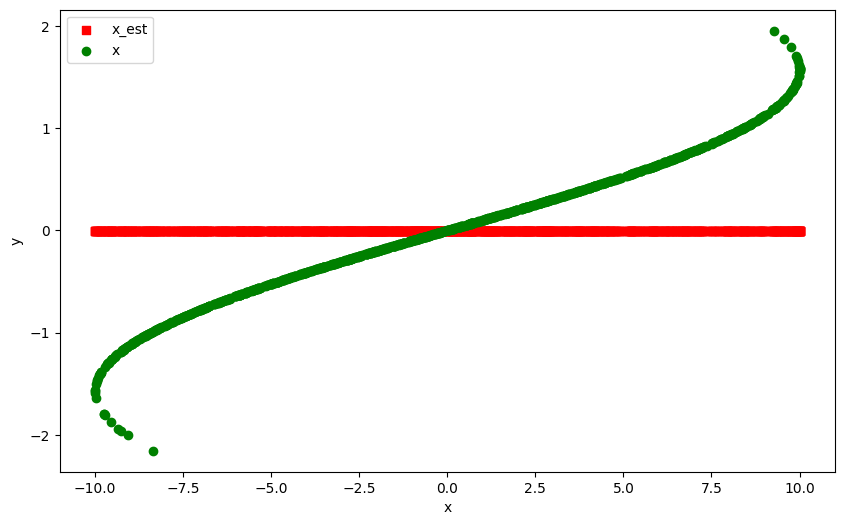

The programm is closed


In [9]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

### DAGMA init

In [10]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[0.5, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = 10*torch.sin(x1)
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = 10*torch.sin(x1)+ epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

In [11]:
eq_model = nonlinear.DagmaMLP(
    dims=[d, 10, 1], bias=True, dtype=torch.double)
model = nonlinear.DagmaNonlinear(
    eq_model, dtype=torch.double, use_mse_loss=True)

W_est_dagma = model.fit(X, lambda1=2e-2, lambda2=0.005,
                        T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

# Use DAGMA weights as initial weights for DAGMA-DCE
fc1_weight = eq_model.fc1.weight
fc1_bias = eq_model.fc1.bias
fc2_weight = eq_model.fc2[0].weight
fc2_bias = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
eq_model.fc1.weight = fc1_weight
eq_model.fc1.bias = fc1_bias
eq_model.fc2[0].weight = fc2_weight
eq_model.fc2[0].bias = fc2_bias

W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  1%|          | 162/29000 [00:00<01:11, 406.06it/s]

Sigma:  tensor([[ 0.9605, -0.0168],
        [-0.0168,  1.0405]], grad_fn=<MmBackward0>)
obj:  tensor(49.5261, grad_fn=<AddBackward0>)
mle loss:  tensor(48.7511, grad_fn=<AddBackward0>)
h_val:  tensor(0.1149, grad_fn=<AddBackward0>)


  1%|          | 242/29000 [00:00<01:14, 384.65it/s]

Sigma:  tensor([[ 0.9217, -0.0154],
        [-0.0154,  1.0785]], grad_fn=<MmBackward0>)
obj:  tensor(29.4079, grad_fn=<AddBackward0>)
mle loss:  tensor(28.5314, grad_fn=<AddBackward0>)
h_val:  tensor(0.2290, grad_fn=<AddBackward0>)


  1%|▏         | 372/29000 [00:00<01:10, 407.02it/s]

Sigma:  tensor([[ 0.8854, -0.0069],
        [-0.0069,  1.1105]], grad_fn=<MmBackward0>)
obj:  tensor(17.0623, grad_fn=<AddBackward0>)
mle loss:  tensor(16.0598, grad_fn=<AddBackward0>)
h_val:  tensor(0.3720, grad_fn=<AddBackward0>)


  2%|▏         | 453/29000 [00:01<01:13, 389.88it/s]

Sigma:  tensor([[ 0.8528, -0.0047],
        [-0.0047,  1.1348]], grad_fn=<MmBackward0>)
obj:  tensor(10.7036, grad_fn=<AddBackward0>)
mle loss:  tensor(9.4144, grad_fn=<AddBackward0>)
h_val:  tensor(0.6796, grad_fn=<AddBackward0>)


  2%|▏         | 578/29000 [00:01<01:11, 397.30it/s]

Sigma:  tensor([[ 0.8221, -0.0049],
        [-0.0049,  1.1521]], grad_fn=<MmBackward0>)
obj:  tensor(8.1452, grad_fn=<AddBackward0>)
mle loss:  tensor(6.4498, grad_fn=<AddBackward0>)
h_val:  tensor(1.0968, grad_fn=<AddBackward0>)


  2%|▏         | 657/29000 [00:01<01:15, 376.72it/s]

Sigma:  tensor([[ 0.7921, -0.0029],
        [-0.0029,  1.1643]], grad_fn=<MmBackward0>)
obj:  tensor(7.4574, grad_fn=<AddBackward0>)
mle loss:  tensor(5.3755, grad_fn=<AddBackward0>)
h_val:  tensor(1.4934, grad_fn=<AddBackward0>)


  3%|▎         | 775/29000 [00:02<01:13, 382.32it/s]

Sigma:  tensor([[ 0.7624, -0.0013],
        [-0.0013,  1.1739]], grad_fn=<MmBackward0>)
obj:  tensor(7.2855, grad_fn=<AddBackward0>)
mle loss:  tensor(5.0183, grad_fn=<AddBackward0>)
h_val:  tensor(1.6845, grad_fn=<AddBackward0>)


  3%|▎         | 852/29000 [00:02<01:16, 369.63it/s]

Sigma:  tensor([[ 0.7327, -0.0017],
        [-0.0017,  1.1824]], grad_fn=<MmBackward0>)
obj:  tensor(7.0809, grad_fn=<AddBackward0>)
mle loss:  tensor(4.8717, grad_fn=<AddBackward0>)
h_val:  tensor(1.6274, grad_fn=<AddBackward0>)


  3%|▎         | 974/29000 [00:02<01:11, 390.17it/s]

Sigma:  tensor([[ 0.7031, -0.0022],
        [-0.0022,  1.1909]], grad_fn=<MmBackward0>)
obj:  tensor(6.8799, grad_fn=<AddBackward0>)
mle loss:  tensor(4.8009, grad_fn=<AddBackward0>)
h_val:  tensor(1.4960, grad_fn=<AddBackward0>)


  4%|▎         | 1055/29000 [00:02<01:12, 384.14it/s]

Sigma:  tensor([[ 0.6743, -0.0022],
        [-0.0022,  1.1997]], grad_fn=<MmBackward0>)
obj:  tensor(6.7016, grad_fn=<AddBackward0>)
mle loss:  tensor(4.7348, grad_fn=<AddBackward0>)
h_val:  tensor(1.3847, grad_fn=<AddBackward0>)


  4%|▍         | 1168/29000 [00:03<01:46, 262.26it/s]

Sigma:  tensor([[ 0.6468, -0.0023],
        [-0.0023,  1.2091]], grad_fn=<MmBackward0>)
obj:  tensor(6.5315, grad_fn=<AddBackward0>)
mle loss:  tensor(4.6241, grad_fn=<AddBackward0>)
h_val:  tensor(1.3269, grad_fn=<AddBackward0>)


  4%|▍         | 1244/29000 [00:03<01:28, 312.85it/s]

Sigma:  tensor([[ 0.6205, -0.0024],
        [-0.0024,  1.2189]], grad_fn=<MmBackward0>)
obj:  tensor(6.3559, grad_fn=<AddBackward0>)
mle loss:  tensor(4.4718, grad_fn=<AddBackward0>)
h_val:  tensor(1.3056, grad_fn=<AddBackward0>)


  5%|▍         | 1372/29000 [00:03<01:15, 367.89it/s]

Sigma:  tensor([[ 0.5955, -0.0023],
        [-0.0023,  1.2293]], grad_fn=<MmBackward0>)
obj:  tensor(6.1723, grad_fn=<AddBackward0>)
mle loss:  tensor(4.3057, grad_fn=<AddBackward0>)
h_val:  tensor(1.2913, grad_fn=<AddBackward0>)


  5%|▌         | 1452/29000 [00:04<01:13, 372.67it/s]

Sigma:  tensor([[ 0.5716, -0.0023],
        [-0.0023,  1.2401]], grad_fn=<MmBackward0>)
obj:  tensor(5.9914, grad_fn=<AddBackward0>)
mle loss:  tensor(4.1448, grad_fn=<AddBackward0>)
h_val:  tensor(1.2740, grad_fn=<AddBackward0>)


  5%|▌         | 1572/29000 [00:04<01:12, 379.24it/s]

Sigma:  tensor([[ 0.5487, -0.0023],
        [-0.0023,  1.2512]], grad_fn=<MmBackward0>)
obj:  tensor(5.8177, grad_fn=<AddBackward0>)
mle loss:  tensor(3.9925, grad_fn=<AddBackward0>)
h_val:  tensor(1.2545, grad_fn=<AddBackward0>)


  6%|▌         | 1652/29000 [00:04<01:11, 381.26it/s]

Sigma:  tensor([[ 0.5268, -0.0023],
        [-0.0023,  1.2627]], grad_fn=<MmBackward0>)
obj:  tensor(5.6410, grad_fn=<AddBackward0>)
mle loss:  tensor(3.8454, grad_fn=<AddBackward0>)
h_val:  tensor(1.2274, grad_fn=<AddBackward0>)


  6%|▌         | 1779/29000 [00:04<01:07, 400.51it/s]

Sigma:  tensor([[ 0.5059, -0.0024],
        [-0.0024,  1.2745]], grad_fn=<MmBackward0>)
obj:  tensor(5.4669, grad_fn=<AddBackward0>)
mle loss:  tensor(3.6982, grad_fn=<AddBackward0>)
h_val:  tensor(1.2026, grad_fn=<AddBackward0>)


  6%|▋         | 1862/29000 [00:05<01:08, 397.37it/s]

Sigma:  tensor([[ 0.4858, -0.0024],
        [-0.0024,  1.2866]], grad_fn=<MmBackward0>)
obj:  tensor(5.2959, grad_fn=<AddBackward0>)
mle loss:  tensor(3.5503, grad_fn=<AddBackward0>)
h_val:  tensor(1.1810, grad_fn=<AddBackward0>)


  7%|▋         | 1941/29000 [00:05<01:10, 385.44it/s]

Sigma:  tensor([[ 0.4666, -0.0024],
        [-0.0024,  1.2990]], grad_fn=<MmBackward0>)
obj:  tensor(5.1231, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4012, grad_fn=<AddBackward0>)
h_val:  tensor(1.1596, grad_fn=<AddBackward0>)


  7%|▋         | 2070/29000 [00:05<01:05, 409.33it/s]

Sigma:  tensor([[ 0.4482, -0.0024],
        [-0.0024,  1.3117]], grad_fn=<MmBackward0>)
obj:  tensor(4.9472, grad_fn=<AddBackward0>)
mle loss:  tensor(3.2519, grad_fn=<AddBackward0>)
h_val:  tensor(1.1363, grad_fn=<AddBackward0>)


  7%|▋         | 2153/29000 [00:05<01:08, 392.34it/s]

Sigma:  tensor([[ 0.4305, -0.0025],
        [-0.0025,  1.3246]], grad_fn=<MmBackward0>)
obj:  tensor(4.7821, grad_fn=<AddBackward0>)
mle loss:  tensor(3.1041, grad_fn=<AddBackward0>)
h_val:  tensor(1.1200, grad_fn=<AddBackward0>)


  8%|▊         | 2277/29000 [00:06<01:08, 390.47it/s]

Sigma:  tensor([[ 0.4136, -0.0025],
        [-0.0025,  1.3377]], grad_fn=<MmBackward0>)
obj:  tensor(4.6126, grad_fn=<AddBackward0>)
mle loss:  tensor(2.9587, grad_fn=<AddBackward0>)
h_val:  tensor(1.0986, grad_fn=<AddBackward0>)


  8%|▊         | 2355/29000 [00:06<01:12, 367.11it/s]

Sigma:  tensor([[ 0.3973, -0.0025],
        [-0.0025,  1.3509]], grad_fn=<MmBackward0>)
obj:  tensor(4.4409, grad_fn=<AddBackward0>)
mle loss:  tensor(2.8133, grad_fn=<AddBackward0>)
h_val:  tensor(1.0763, grad_fn=<AddBackward0>)


  9%|▊         | 2479/29000 [00:06<01:06, 396.99it/s]

Sigma:  tensor([[ 0.3817, -0.0025],
        [-0.0025,  1.3642]], grad_fn=<MmBackward0>)
obj:  tensor(4.2733, grad_fn=<AddBackward0>)
mle loss:  tensor(2.6677, grad_fn=<AddBackward0>)
h_val:  tensor(1.0576, grad_fn=<AddBackward0>)


  9%|▉         | 2559/29000 [00:06<01:08, 383.97it/s]

Sigma:  tensor([[ 0.3667, -0.0026],
        [-0.0026,  1.3777]], grad_fn=<MmBackward0>)
obj:  tensor(4.1146, grad_fn=<AddBackward0>)
mle loss:  tensor(2.5244, grad_fn=<AddBackward0>)
h_val:  tensor(1.0441, grad_fn=<AddBackward0>)


  9%|▉         | 2637/29000 [00:07<01:10, 376.19it/s]

Sigma:  tensor([[ 0.3523, -0.0026],
        [-0.0026,  1.3912]], grad_fn=<MmBackward0>)
obj:  tensor(3.9641, grad_fn=<AddBackward0>)
mle loss:  tensor(2.3840, grad_fn=<AddBackward0>)
h_val:  tensor(1.0345, grad_fn=<AddBackward0>)


 10%|▉         | 2763/29000 [00:07<01:07, 389.16it/s]

Sigma:  tensor([[ 0.3385, -0.0026],
        [-0.0026,  1.4046]], grad_fn=<MmBackward0>)
obj:  tensor(3.8178, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2464, grad_fn=<AddBackward0>)
h_val:  tensor(1.0255, grad_fn=<AddBackward0>)


 10%|▉         | 2844/29000 [00:07<01:06, 393.18it/s]

Sigma:  tensor([[ 0.3251, -0.0026],
        [-0.0026,  1.4181]], grad_fn=<MmBackward0>)
obj:  tensor(3.6683, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1128, grad_fn=<AddBackward0>)
h_val:  tensor(1.0103, grad_fn=<AddBackward0>)


 10%|█         | 2973/29000 [00:08<01:05, 399.13it/s]

Sigma:  tensor([[ 0.3123, -0.0027],
        [-0.0027,  1.4315]], grad_fn=<MmBackward0>)
obj:  tensor(3.5097, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9782, grad_fn=<AddBackward0>)
h_val:  tensor(0.9895, grad_fn=<AddBackward0>)


 11%|█         | 3054/29000 [00:08<01:07, 386.26it/s]

Sigma:  tensor([[ 0.3000, -0.0027],
        [-0.0027,  1.4448]], grad_fn=<MmBackward0>)
obj:  tensor(3.3618, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8466, grad_fn=<AddBackward0>)
h_val:  tensor(0.9749, grad_fn=<AddBackward0>)


 11%|█         | 3174/29000 [00:08<01:06, 389.95it/s]

Sigma:  tensor([[ 0.2882, -0.0027],
        [-0.0027,  1.4579]], grad_fn=<MmBackward0>)
obj:  tensor(3.2082, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7154, grad_fn=<AddBackward0>)
h_val:  tensor(0.9573, grad_fn=<AddBackward0>)


 11%|█         | 3255/29000 [00:08<01:05, 394.65it/s]

Sigma:  tensor([[ 0.2768, -0.0027],
        [-0.0027,  1.4708]], grad_fn=<MmBackward0>)
obj:  tensor(3.0619, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5859, grad_fn=<AddBackward0>)
h_val:  tensor(0.9438, grad_fn=<AddBackward0>)


 12%|█▏        | 3381/29000 [00:09<01:02, 407.22it/s]

Sigma:  tensor([[ 0.2659, -0.0028],
        [-0.0028,  1.4834]], grad_fn=<MmBackward0>)
obj:  tensor(2.9168, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4613, grad_fn=<AddBackward0>)
h_val:  tensor(0.9273, grad_fn=<AddBackward0>)


 12%|█▏        | 3463/29000 [00:09<01:04, 397.57it/s]

Sigma:  tensor([[ 0.2553, -0.0028],
        [-0.0028,  1.4957]], grad_fn=<MmBackward0>)
obj:  tensor(2.7802, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3393, grad_fn=<AddBackward0>)
h_val:  tensor(0.9143, grad_fn=<AddBackward0>)


 12%|█▏        | 3542/29000 [00:09<01:07, 374.74it/s]

Sigma:  tensor([[ 0.2452, -0.0028],
        [-0.0028,  1.5076]], grad_fn=<MmBackward0>)
obj:  tensor(2.6433, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2204, grad_fn=<AddBackward0>)
h_val:  tensor(0.8993, grad_fn=<AddBackward0>)


 13%|█▎        | 3670/29000 [00:09<01:03, 401.71it/s]

Sigma:  tensor([[ 0.2355, -0.0028],
        [-0.0028,  1.5192]], grad_fn=<MmBackward0>)
obj:  tensor(2.5063, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1028, grad_fn=<AddBackward0>)
h_val:  tensor(0.8838, grad_fn=<AddBackward0>)


 13%|█▎        | 3752/29000 [00:09<01:03, 398.95it/s]

Sigma:  tensor([[ 0.2261, -0.0029],
        [-0.0029,  1.5303]], grad_fn=<MmBackward0>)
obj:  tensor(2.3723, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9885, grad_fn=<AddBackward0>)
h_val:  tensor(0.8676, grad_fn=<AddBackward0>)


 13%|█▎        | 3880/29000 [00:10<01:01, 408.21it/s]

Sigma:  tensor([[ 0.2170, -0.0029],
        [-0.0029,  1.5409]], grad_fn=<MmBackward0>)
obj:  tensor(2.2415, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8772, grad_fn=<AddBackward0>)
h_val:  tensor(0.8518, grad_fn=<AddBackward0>)


 14%|█▎        | 3962/29000 [00:10<01:02, 400.47it/s]

Sigma:  tensor([[ 0.2084, -0.0029],
        [-0.0029,  1.5509]], grad_fn=<MmBackward0>)
obj:  tensor(2.1175, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7660, grad_fn=<AddBackward0>)
h_val:  tensor(0.8430, grad_fn=<AddBackward0>)


 14%|█▍        | 4044/29000 [00:10<01:02, 400.25it/s]

Sigma:  tensor([[ 0.2000, -0.0029],
        [-0.0029,  1.5603]], grad_fn=<MmBackward0>)
obj:  tensor(1.9970, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6596, grad_fn=<AddBackward0>)
h_val:  tensor(0.8326, grad_fn=<AddBackward0>)


 14%|█▍        | 4172/29000 [00:11<01:00, 413.19it/s]

Sigma:  tensor([[ 0.1920, -0.0029],
        [-0.0029,  1.5691]], grad_fn=<MmBackward0>)
obj:  tensor(1.8786, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5568, grad_fn=<AddBackward0>)
h_val:  tensor(0.8208, grad_fn=<AddBackward0>)


 15%|█▍        | 4256/29000 [00:11<01:00, 408.98it/s]

Sigma:  tensor([[ 0.1842, -0.0029],
        [-0.0029,  1.5772]], grad_fn=<MmBackward0>)
obj:  tensor(1.7557, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4516, grad_fn=<AddBackward0>)
h_val:  tensor(0.8087, grad_fn=<AddBackward0>)


 15%|█▌        | 4383/29000 [00:11<01:00, 409.46it/s]

Sigma:  tensor([[ 0.1768, -0.0030],
        [-0.0030,  1.5844]], grad_fn=<MmBackward0>)
obj:  tensor(1.6383, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3507, grad_fn=<AddBackward0>)
h_val:  tensor(0.7970, grad_fn=<AddBackward0>)


 15%|█▌        | 4466/29000 [00:11<01:01, 401.76it/s]

Sigma:  tensor([[ 0.1696, -0.0030],
        [-0.0030,  1.5909]], grad_fn=<MmBackward0>)
obj:  tensor(1.5241, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2535, grad_fn=<AddBackward0>)
h_val:  tensor(0.7842, grad_fn=<AddBackward0>)


 16%|█▌        | 4547/29000 [00:11<01:02, 388.47it/s]

Sigma:  tensor([[ 0.1627, -0.0030],
        [-0.0030,  1.5964]], grad_fn=<MmBackward0>)
obj:  tensor(1.4092, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1574, grad_fn=<AddBackward0>)
h_val:  tensor(0.7704, grad_fn=<AddBackward0>)


 16%|█▌        | 4666/29000 [00:12<01:03, 384.39it/s]

Sigma:  tensor([[ 0.1561, -0.0031],
        [-0.0031,  1.6010]], grad_fn=<MmBackward0>)
obj:  tensor(1.2888, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0562, grad_fn=<AddBackward0>)
h_val:  tensor(0.7582, grad_fn=<AddBackward0>)


 16%|█▋        | 4744/29000 [00:12<01:05, 368.98it/s]

Sigma:  tensor([[ 0.1498, -0.0031],
        [-0.0031,  1.6046]], grad_fn=<MmBackward0>)
obj:  tensor(1.1754, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0385, grad_fn=<AddBackward0>)
h_val:  tensor(0.7452, grad_fn=<AddBackward0>)


 17%|█▋        | 4870/29000 [00:12<01:00, 401.19it/s]

Sigma:  tensor([[ 0.1436, -0.0031],
        [-0.0031,  1.6070]], grad_fn=<MmBackward0>)
obj:  tensor(1.0620, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1345, grad_fn=<AddBackward0>)
h_val:  tensor(0.7339, grad_fn=<AddBackward0>)


 17%|█▋        | 4953/29000 [00:13<00:59, 406.73it/s]

Sigma:  tensor([[ 0.1377, -0.0032],
        [-0.0032,  1.6083]], grad_fn=<MmBackward0>)
obj:  tensor(0.9491, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2290, grad_fn=<AddBackward0>)
h_val:  tensor(0.7223, grad_fn=<AddBackward0>)


 18%|█▊        | 5079/29000 [00:13<00:59, 402.44it/s]

Sigma:  tensor([[ 0.1320, -0.0033],
        [-0.0033,  1.6083]], grad_fn=<MmBackward0>)
obj:  tensor(0.8358, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3236, grad_fn=<AddBackward0>)
h_val:  tensor(0.7107, grad_fn=<AddBackward0>)


 18%|█▊        | 5161/29000 [00:13<01:00, 391.39it/s]

Sigma:  tensor([[ 0.1266, -0.0034],
        [-0.0034,  1.6069]], grad_fn=<MmBackward0>)
obj:  tensor(0.7248, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4151, grad_fn=<AddBackward0>)
h_val:  tensor(0.6979, grad_fn=<AddBackward0>)


 18%|█▊        | 5242/29000 [00:13<01:01, 386.57it/s]

Sigma:  tensor([[ 0.1213, -0.0034],
        [-0.0034,  1.6042]], grad_fn=<MmBackward0>)
obj:  tensor(0.6154, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5077, grad_fn=<AddBackward0>)
h_val:  tensor(0.6879, grad_fn=<AddBackward0>)


 19%|█▊        | 5376/29000 [00:14<00:55, 422.06it/s]

Sigma:  tensor([[ 0.1163, -0.0035],
        [-0.0035,  1.6000]], grad_fn=<MmBackward0>)
obj:  tensor(0.5048, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5996, grad_fn=<AddBackward0>)
h_val:  tensor(0.6767, grad_fn=<AddBackward0>)


 19%|█▉        | 5461/29000 [00:14<00:58, 405.30it/s]

Sigma:  tensor([[ 0.1114, -0.0036],
        [-0.0036,  1.5943]], grad_fn=<MmBackward0>)
obj:  tensor(0.3983, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6881, grad_fn=<AddBackward0>)
h_val:  tensor(0.6652, grad_fn=<AddBackward0>)


 19%|█▉        | 5542/29000 [00:14<01:01, 382.80it/s]

Sigma:  tensor([[ 0.1068, -0.0037],
        [-0.0037,  1.5870]], grad_fn=<MmBackward0>)
obj:  tensor(0.2911, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7793, grad_fn=<AddBackward0>)
h_val:  tensor(0.6558, grad_fn=<AddBackward0>)


 20%|█▉        | 5674/29000 [00:14<00:56, 411.91it/s]

Sigma:  tensor([[ 0.1023, -0.0038],
        [-0.0038,  1.5780]], grad_fn=<MmBackward0>)
obj:  tensor(0.1867, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8711, grad_fn=<AddBackward0>)
h_val:  tensor(0.6497, grad_fn=<AddBackward0>)


 20%|█▉        | 5757/29000 [00:15<00:57, 404.41it/s]

Sigma:  tensor([[ 0.0980, -0.0039],
        [-0.0039,  1.5673]], grad_fn=<MmBackward0>)
obj:  tensor(0.0807, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9615, grad_fn=<AddBackward0>)
h_val:  tensor(0.6410, grad_fn=<AddBackward0>)


 20%|██        | 5885/29000 [00:15<00:56, 412.75it/s]

Sigma:  tensor([[ 0.0939, -0.0040],
        [-0.0040,  1.5548]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0258, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0512, grad_fn=<AddBackward0>)
h_val:  tensor(0.6315, grad_fn=<AddBackward0>)


 21%|██        | 5969/29000 [00:15<00:56, 408.96it/s]

Sigma:  tensor([[ 0.0899, -0.0041],
        [-0.0041,  1.5405]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1323, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1421, grad_fn=<AddBackward0>)
h_val:  tensor(0.6234, grad_fn=<AddBackward0>)


 21%|██        | 6051/29000 [00:15<00:57, 401.40it/s]

Sigma:  tensor([[ 0.0861, -0.0043],
        [-0.0043,  1.5243]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2385, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2341, grad_fn=<AddBackward0>)
h_val:  tensor(0.6168, grad_fn=<AddBackward0>)


 21%|██▏       | 6183/29000 [00:16<00:55, 414.66it/s]

Sigma:  tensor([[ 0.0825, -0.0045],
        [-0.0045,  1.5062]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3442, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3263, grad_fn=<AddBackward0>)
h_val:  tensor(0.6106, grad_fn=<AddBackward0>)


 22%|██▏       | 6267/29000 [00:16<00:55, 409.70it/s]

Sigma:  tensor([[ 0.0790, -0.0046],
        [-0.0046,  1.4863]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4480, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4191, grad_fn=<AddBackward0>)
h_val:  tensor(0.6066, grad_fn=<AddBackward0>)


 22%|██▏       | 6349/29000 [00:16<00:57, 391.04it/s]

Sigma:  tensor([[ 0.0757, -0.0048],
        [-0.0048,  1.4644]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5500, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5114, grad_fn=<AddBackward0>)
h_val:  tensor(0.6032, grad_fn=<AddBackward0>)


 22%|██▏       | 6475/29000 [00:16<00:57, 392.84it/s]

Sigma:  tensor([[ 0.0724, -0.0050],
        [-0.0050,  1.4407]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6540, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6037, grad_fn=<AddBackward0>)
h_val:  tensor(0.5984, grad_fn=<AddBackward0>)


 23%|██▎       | 6555/29000 [00:17<00:57, 387.26it/s]

Sigma:  tensor([[ 0.0694, -0.0052],
        [-0.0052,  1.4152]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7553, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6948, grad_fn=<AddBackward0>)
h_val:  tensor(0.5941, grad_fn=<AddBackward0>)


 23%|██▎       | 6680/29000 [00:17<00:55, 404.06it/s]

Sigma:  tensor([[ 0.0664, -0.0054],
        [-0.0054,  1.3879]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8614, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7875, grad_fn=<AddBackward0>)
h_val:  tensor(0.5876, grad_fn=<AddBackward0>)


 23%|██▎       | 6759/29000 [00:17<01:00, 369.13it/s]

Sigma:  tensor([[ 0.0636, -0.0057],
        [-0.0057,  1.3589]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9653, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8808, grad_fn=<AddBackward0>)
h_val:  tensor(0.5836, grad_fn=<AddBackward0>)


 24%|██▎       | 6874/29000 [00:17<01:01, 358.33it/s]

Sigma:  tensor([[ 0.0609, -0.0060],
        [-0.0060,  1.3284]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0666, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9732, grad_fn=<AddBackward0>)
h_val:  tensor(0.5802, grad_fn=<AddBackward0>)


 24%|██▍       | 6952/29000 [00:18<01:00, 364.36it/s]

Sigma:  tensor([[ 0.0584, -0.0062],
        [-0.0062,  1.2964]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1680, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0658, grad_fn=<AddBackward0>)
h_val:  tensor(0.5769, grad_fn=<AddBackward0>)


 25%|██▍       | 7156/29000 [00:18<00:54, 404.08it/s]

Sigma:  tensor([[ 0.0552, -0.0024],
        [-0.0024,  1.2293]], grad_fn=<MmBackward0>)
obj:  tensor(0.2154, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3147, grad_fn=<AddBackward0>)
h_val:  tensor(0.2167, grad_fn=<AddBackward0>)


 25%|██▍       | 7239/29000 [00:18<00:54, 399.54it/s]

Sigma:  tensor([[5.6322e-02, 3.5189e-04],
        [3.5189e-04, 1.1899e+00]], grad_fn=<MmBackward0>)
obj:  tensor(0.1521, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2739, grad_fn=<AddBackward0>)
h_val:  tensor(0.2500, grad_fn=<AddBackward0>)


 25%|██▌       | 7370/29000 [00:19<00:53, 401.46it/s]

Sigma:  tensor([[5.7209e-02, 3.7800e-04],
        [3.7800e-04, 1.1488e+00]], grad_fn=<MmBackward0>)
obj:  tensor(0.1344, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9997, grad_fn=<AddBackward0>)
h_val:  tensor(0.2053, grad_fn=<AddBackward0>)


 26%|██▌       | 7451/29000 [00:19<00:58, 366.53it/s]

Sigma:  tensor([[ 5.8561e-02, -6.3883e-04],
        [-6.3883e-04,  1.1071e+00]], grad_fn=<MmBackward0>)
obj:  tensor(0.1258, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7444, grad_fn=<AddBackward0>)
h_val:  tensor(0.1715, grad_fn=<AddBackward0>)


 26%|██▌       | 7569/29000 [00:19<00:56, 382.67it/s]

Sigma:  tensor([[ 6.0486e-02, -7.4103e-04],
        [-7.4103e-04,  1.0656e+00]], grad_fn=<MmBackward0>)
obj:  tensor(0.1192, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0011, grad_fn=<AddBackward0>)
h_val:  tensor(0.1908, grad_fn=<AddBackward0>)


 26%|██▋       | 7647/29000 [00:19<00:59, 360.78it/s]

Sigma:  tensor([[ 6.2506e-02, -1.5331e-04],
        [-1.5331e-04,  1.0246e+00]], grad_fn=<MmBackward0>)
obj:  tensor(0.1118, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8350, grad_fn=<AddBackward0>)
h_val:  tensor(0.1670, grad_fn=<AddBackward0>)


 27%|██▋       | 7766/29000 [00:20<00:56, 374.74it/s]

Sigma:  tensor([[6.4818e-02, 8.0336e-06],
        [8.0336e-06, 9.8446e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.1056, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9870, grad_fn=<AddBackward0>)
h_val:  tensor(0.1761, grad_fn=<AddBackward0>)


 27%|██▋       | 7843/29000 [00:20<00:58, 364.22it/s]

Sigma:  tensor([[ 6.7153e-02, -8.2459e-05],
        [-8.2459e-05,  9.4552e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0997, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9561, grad_fn=<AddBackward0>)
h_val:  tensor(0.1671, grad_fn=<AddBackward0>)


 27%|██▋       | 7959/29000 [00:20<00:56, 374.35it/s]

Sigma:  tensor([[6.9602e-02, 8.7852e-05],
        [8.7852e-05, 9.0793e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0954, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9977, grad_fn=<AddBackward0>)
h_val:  tensor(0.1669, grad_fn=<AddBackward0>)


 28%|██▊       | 8038/29000 [00:21<00:56, 373.73it/s]

Sigma:  tensor([[7.2143e-02, 1.5533e-04],
        [1.5533e-04, 8.7176e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0904, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9718, grad_fn=<AddBackward0>)
h_val:  tensor(0.1593, grad_fn=<AddBackward0>)


 28%|██▊       | 8122/29000 [00:21<00:54, 380.41it/s]

Sigma:  tensor([[7.4835e-02, 1.4775e-04],
        [1.4775e-04, 8.3708e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0840, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9972, grad_fn=<AddBackward0>)
h_val:  tensor(0.1556, grad_fn=<AddBackward0>)


 28%|██▊       | 8245/29000 [00:21<00:58, 353.13it/s]

Sigma:  tensor([[7.7620e-02, 2.4137e-04],
        [2.4137e-04, 8.0388e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0780, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0080, grad_fn=<AddBackward0>)
h_val:  tensor(0.1507, grad_fn=<AddBackward0>)


 29%|██▉       | 8373/29000 [00:21<00:53, 386.66it/s]

Sigma:  tensor([[8.0497e-02, 2.9290e-04],
        [2.9290e-04, 7.7203e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0712, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0452, grad_fn=<AddBackward0>)
h_val:  tensor(0.1477, grad_fn=<AddBackward0>)


 29%|██▉       | 8452/29000 [00:22<00:55, 371.26it/s]

Sigma:  tensor([[8.3451e-02, 3.2166e-04],
        [3.2166e-04, 7.4123e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0643, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0628, grad_fn=<AddBackward0>)
h_val:  tensor(0.1426, grad_fn=<AddBackward0>)


 30%|██▉       | 8571/29000 [00:22<00:53, 382.17it/s]

Sigma:  tensor([[8.6491e-02, 4.0128e-04],
        [4.0128e-04, 7.1150e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0575, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0890, grad_fn=<AddBackward0>)
h_val:  tensor(0.1384, grad_fn=<AddBackward0>)


 30%|██▉       | 8651/29000 [00:22<00:52, 385.88it/s]

Sigma:  tensor([[8.9625e-02, 3.1672e-04],
        [3.1672e-04, 6.8290e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0499, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1028, grad_fn=<AddBackward0>)
h_val:  tensor(0.1321, grad_fn=<AddBackward0>)


 30%|███       | 8733/29000 [00:23<01:26, 234.80it/s]

Sigma:  tensor([[9.2883e-02, 2.7001e-04],
        [2.7001e-04, 6.5517e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0393, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1664, grad_fn=<AddBackward0>)
h_val:  tensor(0.1277, grad_fn=<AddBackward0>)


 31%|███       | 8848/29000 [00:23<01:06, 301.39it/s]

Sigma:  tensor([[9.6245e-02, 1.2478e-04],
        [1.2478e-04, 6.2783e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0306, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2212, grad_fn=<AddBackward0>)
h_val:  tensor(0.1245, grad_fn=<AddBackward0>)


 31%|███       | 8966/29000 [00:23<00:59, 339.06it/s]

Sigma:  tensor([[9.9672e-02, 3.0878e-04],
        [3.0878e-04, 6.0111e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0224, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2677, grad_fn=<AddBackward0>)
h_val:  tensor(0.1212, grad_fn=<AddBackward0>)


 31%|███       | 9039/29000 [00:23<00:57, 347.71it/s]

Sigma:  tensor([[1.0314e-01, 3.4960e-04],
        [3.4960e-04, 5.7534e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0152, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2843, grad_fn=<AddBackward0>)
h_val:  tensor(0.1156, grad_fn=<AddBackward0>)


 32%|███▏      | 9153/29000 [00:24<00:55, 356.52it/s]

Sigma:  tensor([[1.0670e-01, 3.1206e-04],
        [3.1206e-04, 5.5076e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0076, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3149, grad_fn=<AddBackward0>)
h_val:  tensor(0.1111, grad_fn=<AddBackward0>)


 32%|███▏      | 9268/29000 [00:24<00:53, 369.54it/s]

Sigma:  tensor([[1.1035e-01, 3.1887e-04],
        [3.1887e-04, 5.2736e-01]], grad_fn=<MmBackward0>)
obj:  tensor(0.0008, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3310, grad_fn=<AddBackward0>)
h_val:  tensor(0.1058, grad_fn=<AddBackward0>)


 32%|███▏      | 9346/29000 [00:24<00:52, 376.71it/s]

Sigma:  tensor([[1.1410e-01, 3.2175e-04],
        [3.2175e-04, 5.0507e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0066, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3665, grad_fn=<AddBackward0>)
h_val:  tensor(0.1021, grad_fn=<AddBackward0>)


 33%|███▎      | 9462/29000 [00:25<00:52, 375.09it/s]

Sigma:  tensor([[1.1792e-01, 3.0701e-04],
        [3.0701e-04, 4.8383e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0136, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3950, grad_fn=<AddBackward0>)
h_val:  tensor(0.0980, grad_fn=<AddBackward0>)


 33%|███▎      | 9535/29000 [00:25<00:57, 338.22it/s]

Sigma:  tensor([[1.2180e-01, 3.3444e-04],
        [3.3444e-04, 4.6354e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0207, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4272, grad_fn=<AddBackward0>)
h_val:  tensor(0.0942, grad_fn=<AddBackward0>)


 33%|███▎      | 9664/29000 [00:25<00:49, 392.67it/s]

Sigma:  tensor([[1.2575e-01, 3.4056e-04],
        [3.4056e-04, 4.4413e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0278, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4654, grad_fn=<AddBackward0>)
h_val:  tensor(0.0910, grad_fn=<AddBackward0>)


 34%|███▎      | 9744/29000 [00:25<00:49, 392.71it/s]

Sigma:  tensor([[1.2976e-01, 3.1027e-04],
        [3.1027e-04, 4.2550e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0350, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5076, grad_fn=<AddBackward0>)
h_val:  tensor(0.0882, grad_fn=<AddBackward0>)


 34%|███▍      | 9864/29000 [00:26<00:49, 390.50it/s]

Sigma:  tensor([[1.3381e-01, 2.8223e-04],
        [2.8223e-04, 4.0760e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0413, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5382, grad_fn=<AddBackward0>)
h_val:  tensor(0.0849, grad_fn=<AddBackward0>)


 34%|███▍      | 9944/29000 [00:26<00:49, 384.06it/s]

Sigma:  tensor([[1.3793e-01, 2.9148e-04],
        [2.9148e-04, 3.9044e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0477, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5823, grad_fn=<AddBackward0>)
h_val:  tensor(0.0832, grad_fn=<AddBackward0>)


 35%|███▍      | 10073/29000 [00:26<00:47, 396.36it/s]

Sigma:  tensor([[1.4201e-01, 3.2548e-04],
        [3.2548e-04, 3.7404e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0532, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6146, grad_fn=<AddBackward0>)
h_val:  tensor(0.0812, grad_fn=<AddBackward0>)


 35%|███▌      | 10153/29000 [00:26<00:49, 382.95it/s]

Sigma:  tensor([[0.1460, 0.0004],
        [0.0004, 0.3584]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0584, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6494, grad_fn=<AddBackward0>)
h_val:  tensor(0.0798, grad_fn=<AddBackward0>)


 35%|███▌      | 10275/29000 [00:27<00:47, 393.67it/s]

Sigma:  tensor([[0.1500, 0.0004],
        [0.0004, 0.3436]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0631, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6759, grad_fn=<AddBackward0>)
h_val:  tensor(0.0779, grad_fn=<AddBackward0>)


 36%|███▌      | 10354/29000 [00:27<00:48, 385.44it/s]

Sigma:  tensor([[0.1539, 0.0004],
        [0.0004, 0.3295]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0681, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7044, grad_fn=<AddBackward0>)
h_val:  tensor(0.0759, grad_fn=<AddBackward0>)


 36%|███▌      | 10469/29000 [00:27<00:50, 366.02it/s]

Sigma:  tensor([[0.1578, 0.0003],
        [0.0003, 0.3161]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0729, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7276, grad_fn=<AddBackward0>)
h_val:  tensor(0.0735, grad_fn=<AddBackward0>)


 36%|███▋      | 10540/29000 [00:28<00:57, 322.41it/s]

Sigma:  tensor([[0.1617, 0.0004],
        [0.0004, 0.3032]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0776, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7582, grad_fn=<AddBackward0>)
h_val:  tensor(0.0719, grad_fn=<AddBackward0>)


 37%|███▋      | 10648/29000 [00:28<00:52, 347.28it/s]

Sigma:  tensor([[0.1657, 0.0004],
        [0.0004, 0.2910]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0822, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7803, grad_fn=<AddBackward0>)
h_val:  tensor(0.0694, grad_fn=<AddBackward0>)


 37%|███▋      | 10770/29000 [00:28<00:48, 374.48it/s]

Sigma:  tensor([[0.1697, 0.0003],
        [0.0003, 0.2793]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0868, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8025, grad_fn=<AddBackward0>)
h_val:  tensor(0.0670, grad_fn=<AddBackward0>)


 37%|███▋      | 10848/29000 [00:28<00:47, 380.16it/s]

Sigma:  tensor([[0.1738, 0.0003],
        [0.0003, 0.2681]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0914, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8295, grad_fn=<AddBackward0>)
h_val:  tensor(0.0651, grad_fn=<AddBackward0>)


 38%|███▊      | 10970/29000 [00:29<00:46, 385.60it/s]

Sigma:  tensor([[1.7788e-01, 2.5155e-04],
        [2.5155e-04, 2.5742e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0958, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8558, grad_fn=<AddBackward0>)
h_val:  tensor(0.0633, grad_fn=<AddBackward0>)


 38%|███▊      | 11049/29000 [00:29<00:46, 385.76it/s]

Sigma:  tensor([[0.1820, 0.0003],
        [0.0003, 0.2472]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1002, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8831, grad_fn=<AddBackward0>)
h_val:  tensor(0.0616, grad_fn=<AddBackward0>)


 39%|███▊      | 11169/29000 [00:29<00:46, 384.10it/s]

Sigma:  tensor([[0.1862, 0.0002],
        [0.0002, 0.2373]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1046, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9108, grad_fn=<AddBackward0>)
h_val:  tensor(0.0600, grad_fn=<AddBackward0>)


 39%|███▉      | 11247/29000 [00:29<00:46, 380.13it/s]

Sigma:  tensor([[0.1904, 0.0002],
        [0.0002, 0.2279]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1089, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9378, grad_fn=<AddBackward0>)
h_val:  tensor(0.0583, grad_fn=<AddBackward0>)


 39%|███▉      | 11361/29000 [00:30<00:48, 360.30it/s]

Sigma:  tensor([[0.1946, 0.0002],
        [0.0002, 0.2188]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1132, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9645, grad_fn=<AddBackward0>)
h_val:  tensor(0.0566, grad_fn=<AddBackward0>)


 39%|███▉      | 11436/29000 [00:30<00:49, 354.91it/s]

Sigma:  tensor([[0.1989, 0.0002],
        [0.0002, 0.2101]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1175, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9919, grad_fn=<AddBackward0>)
h_val:  tensor(0.0550, grad_fn=<AddBackward0>)


 40%|███▉      | 11560/29000 [00:30<00:44, 389.49it/s]

Sigma:  tensor([[0.2031, 0.0002],
        [0.0002, 0.2018]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1218, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0198, grad_fn=<AddBackward0>)
h_val:  tensor(0.0534, grad_fn=<AddBackward0>)


 40%|████      | 11641/29000 [00:30<00:44, 387.31it/s]

Sigma:  tensor([[2.0736e-01, 2.0084e-04],
        [2.0084e-04, 1.9381e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1261, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0481, grad_fn=<AddBackward0>)
h_val:  tensor(0.0520, grad_fn=<AddBackward0>)


 41%|████      | 11770/29000 [00:31<00:42, 408.88it/s]

Sigma:  tensor([[2.1156e-01, 1.9552e-04],
        [1.9552e-04, 1.8614e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1304, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0772, grad_fn=<AddBackward0>)
h_val:  tensor(0.0506, grad_fn=<AddBackward0>)


 41%|████      | 11852/29000 [00:31<00:43, 397.64it/s]

Sigma:  tensor([[2.1569e-01, 1.9876e-04],
        [1.9876e-04, 1.7878e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1346, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1067, grad_fn=<AddBackward0>)
h_val:  tensor(0.0493, grad_fn=<AddBackward0>)


 41%|████▏     | 11977/29000 [00:31<00:42, 396.11it/s]

Sigma:  tensor([[2.1974e-01, 1.9230e-04],
        [1.9230e-04, 1.7171e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1388, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1371, grad_fn=<AddBackward0>)
h_val:  tensor(0.0481, grad_fn=<AddBackward0>)


 42%|████▏     | 12057/29000 [00:31<00:43, 390.32it/s]

Sigma:  tensor([[2.2369e-01, 1.7694e-04],
        [1.7694e-04, 1.6493e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1429, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1670, grad_fn=<AddBackward0>)
h_val:  tensor(0.0470, grad_fn=<AddBackward0>)


 42%|████▏     | 12182/29000 [00:32<00:41, 402.53it/s]

Sigma:  tensor([[2.2754e-01, 1.7206e-04],
        [1.7206e-04, 1.5842e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1470, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1973, grad_fn=<AddBackward0>)
h_val:  tensor(0.0459, grad_fn=<AddBackward0>)


 42%|████▏     | 12263/29000 [00:32<00:43, 383.88it/s]

Sigma:  tensor([[2.3127e-01, 1.6713e-04],
        [1.6713e-04, 1.5217e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1511, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2284, grad_fn=<AddBackward0>)
h_val:  tensor(0.0449, grad_fn=<AddBackward0>)


 43%|████▎     | 12338/29000 [00:32<00:47, 351.78it/s]

Sigma:  tensor([[2.3485e-01, 1.6426e-04],
        [1.6426e-04, 1.4617e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1552, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2602, grad_fn=<AddBackward0>)
h_val:  tensor(0.0439, grad_fn=<AddBackward0>)


 43%|████▎     | 12463/29000 [00:33<00:42, 386.26it/s]

Sigma:  tensor([[2.3827e-01, 1.6545e-04],
        [1.6545e-04, 1.4041e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1593, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2928, grad_fn=<AddBackward0>)
h_val:  tensor(0.0430, grad_fn=<AddBackward0>)


 43%|████▎     | 12540/29000 [00:33<00:44, 367.55it/s]

Sigma:  tensor([[2.4150e-01, 1.6097e-04],
        [1.6097e-04, 1.3488e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1634, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3256, grad_fn=<AddBackward0>)
h_val:  tensor(0.0422, grad_fn=<AddBackward0>)


 44%|████▎     | 12666/29000 [00:33<00:42, 388.03it/s]

Sigma:  tensor([[2.4455e-01, 1.6115e-04],
        [1.6115e-04, 1.2957e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1675, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3601, grad_fn=<AddBackward0>)
h_val:  tensor(0.0416, grad_fn=<AddBackward0>)


 44%|████▍     | 12745/29000 [00:33<00:41, 387.05it/s]

Sigma:  tensor([[2.4739e-01, 1.6428e-04],
        [1.6428e-04, 1.2447e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1716, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3935, grad_fn=<AddBackward0>)
h_val:  tensor(0.0408, grad_fn=<AddBackward0>)


 44%|████▍     | 12875/29000 [00:34<00:39, 406.49it/s]

Sigma:  tensor([[2.5002e-01, 1.5959e-04],
        [1.5959e-04, 1.1957e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1756, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4274, grad_fn=<AddBackward0>)
h_val:  tensor(0.0402, grad_fn=<AddBackward0>)


 45%|████▍     | 12956/29000 [00:34<00:41, 382.63it/s]

Sigma:  tensor([[2.5243e-01, 1.5060e-04],
        [1.5060e-04, 1.1487e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1797, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4627, grad_fn=<AddBackward0>)
h_val:  tensor(0.0396, grad_fn=<AddBackward0>)


 45%|████▌     | 13079/29000 [00:34<00:40, 391.56it/s]

Sigma:  tensor([[2.5462e-01, 1.6704e-04],
        [1.6704e-04, 1.1036e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1837, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4979, grad_fn=<AddBackward0>)
h_val:  tensor(0.0391, grad_fn=<AddBackward0>)


 45%|████▌     | 13159/29000 [00:34<00:40, 388.63it/s]

Sigma:  tensor([[2.5660e-01, 1.4286e-04],
        [1.4286e-04, 1.0602e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1878, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5350, grad_fn=<AddBackward0>)
h_val:  tensor(0.0387, grad_fn=<AddBackward0>)


 46%|████▌     | 13283/29000 [00:35<00:39, 400.62it/s]

Sigma:  tensor([[2.5835e-01, 1.6861e-04],
        [1.6861e-04, 1.0186e-01]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1918, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5699, grad_fn=<AddBackward0>)
h_val:  tensor(0.0382, grad_fn=<AddBackward0>)


 46%|████▌     | 13364/29000 [00:35<00:40, 390.44it/s]

Sigma:  tensor([[2.5989e-01, 1.5585e-04],
        [1.5585e-04, 9.7857e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1958, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6078, grad_fn=<AddBackward0>)
h_val:  tensor(0.0380, grad_fn=<AddBackward0>)


 46%|████▋     | 13443/29000 [00:35<00:41, 375.88it/s]

Sigma:  tensor([[2.6125e-01, 1.5495e-04],
        [1.5495e-04, 9.4016e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1998, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6429, grad_fn=<AddBackward0>)
h_val:  tensor(0.0375, grad_fn=<AddBackward0>)


 47%|████▋     | 13567/29000 [00:35<00:39, 389.35it/s]

Sigma:  tensor([[2.6241e-01, 1.5153e-04],
        [1.5153e-04, 9.0327e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2038, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6820, grad_fn=<AddBackward0>)
h_val:  tensor(0.0374, grad_fn=<AddBackward0>)


 47%|████▋     | 13645/29000 [00:36<00:42, 361.89it/s]

Sigma:  tensor([[2.6338e-01, 1.6218e-04],
        [1.6218e-04, 8.6783e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2078, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7195, grad_fn=<AddBackward0>)
h_val:  tensor(0.0371, grad_fn=<AddBackward0>)


 47%|████▋     | 13766/29000 [00:36<00:39, 382.49it/s]

Sigma:  tensor([[2.6419e-01, 1.5281e-04],
        [1.5281e-04, 8.3380e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2118, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7575, grad_fn=<AddBackward0>)
h_val:  tensor(0.0369, grad_fn=<AddBackward0>)


 48%|████▊     | 13844/29000 [00:36<00:40, 370.83it/s]

Sigma:  tensor([[2.6486e-01, 1.5946e-04],
        [1.5946e-04, 8.0111e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2159, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7971, grad_fn=<AddBackward0>)
h_val:  tensor(0.0368, grad_fn=<AddBackward0>)


 48%|████▊     | 13966/29000 [00:37<00:39, 383.04it/s]

Sigma:  tensor([[2.6539e-01, 1.4868e-04],
        [1.4868e-04, 7.6970e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2199, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8346, grad_fn=<AddBackward0>)
h_val:  tensor(0.0366, grad_fn=<AddBackward0>)


 49%|████▉     | 14165/29000 [00:37<00:39, 375.20it/s]

Sigma:  tensor([[ 2.6838e-01, -2.2441e-04],
        [-2.2441e-04,  7.3304e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0081, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4127, grad_fn=<AddBackward0>)
h_val:  tensor(0.0133, grad_fn=<AddBackward0>)


 49%|████▉     | 14241/29000 [00:37<00:41, 359.05it/s]

Sigma:  tensor([[0.2794, 0.0003],
        [0.0003, 0.0728]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0136, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2589, grad_fn=<AddBackward0>)
h_val:  tensor(0.0062, grad_fn=<AddBackward0>)


 50%|████▉     | 14361/29000 [00:38<00:38, 379.25it/s]

Sigma:  tensor([[0.2915, 0.0005],
        [0.0005, 0.0723]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0169, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3671, grad_fn=<AddBackward0>)
h_val:  tensor(0.0040, grad_fn=<AddBackward0>)


 50%|████▉     | 14439/29000 [00:38<00:38, 377.78it/s]

Sigma:  tensor([[3.0344e-01, 2.1387e-04],
        [2.1387e-04, 7.1772e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0186, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2323, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)


 50%|█████     | 14563/29000 [00:38<00:36, 394.24it/s]

Sigma:  tensor([[3.1647e-01, 1.5519e-05],
        [1.5519e-05, 7.1126e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0191, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2546, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 50%|█████     | 14643/29000 [00:38<00:37, 382.16it/s]

Sigma:  tensor([[ 3.2957e-01, -1.1606e-05],
        [-1.1606e-05,  7.0407e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0193, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2932, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 51%|█████     | 14764/29000 [00:39<00:37, 376.67it/s]

Sigma:  tensor([[3.4219e-01, 2.1251e-05],
        [2.1251e-05, 6.9618e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0197, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2978, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 51%|█████     | 14839/29000 [00:39<00:39, 360.93it/s]

Sigma:  tensor([[3.5434e-01, 2.8955e-05],
        [2.8955e-05, 6.8766e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0200, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3428, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 52%|█████▏    | 14966/29000 [00:39<00:36, 386.07it/s]

Sigma:  tensor([[3.6561e-01, 3.0302e-05],
        [3.0302e-05, 6.7854e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3557, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 52%|█████▏    | 15045/29000 [00:39<00:36, 384.14it/s]

Sigma:  tensor([[3.7617e-01, 7.7107e-07],
        [7.7107e-07, 6.6886e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0204, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3807, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 52%|█████▏    | 15173/29000 [00:40<00:34, 401.57it/s]

Sigma:  tensor([[3.8601e-01, 6.1983e-07],
        [6.1983e-07, 6.5867e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0207, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3939, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 53%|█████▎    | 15254/29000 [00:40<00:36, 378.72it/s]

Sigma:  tensor([[3.9526e-01, 9.0668e-06],
        [9.0668e-06, 6.4799e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0209, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4131, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 53%|█████▎    | 15377/29000 [00:40<00:33, 400.71it/s]

Sigma:  tensor([[4.0391e-01, 2.4234e-06],
        [2.4234e-06, 6.3687e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0211, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4309, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 53%|█████▎    | 15458/29000 [00:40<00:34, 390.16it/s]

Sigma:  tensor([[4.1196e-01, 7.7142e-06],
        [7.7142e-06, 6.2532e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0214, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4518, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 54%|█████▎    | 15582/29000 [00:41<00:33, 401.57it/s]

Sigma:  tensor([[4.1937e-01, 3.5466e-06],
        [3.5466e-06, 6.1339e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0216, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4723, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 54%|█████▍    | 15663/29000 [00:41<00:33, 394.28it/s]

Sigma:  tensor([[4.2612e-01, 4.4388e-06],
        [4.4388e-06, 6.0111e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0218, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4937, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 54%|█████▍    | 15742/29000 [00:41<00:35, 373.32it/s]

Sigma:  tensor([[4.3220e-01, 6.2790e-06],
        [6.2790e-06, 5.8851e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0221, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5155, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 55%|█████▍    | 15865/29000 [00:42<00:47, 274.38it/s]

Sigma:  tensor([[4.3764e-01, 4.6090e-06],
        [4.6090e-06, 5.7563e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0223, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5377, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 55%|█████▍    | 15942/29000 [00:42<00:41, 318.20it/s]

Sigma:  tensor([[4.4244e-01, 4.8896e-06],
        [4.8896e-06, 5.6252e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0225, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5610, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 55%|█████▌    | 16069/29000 [00:42<00:34, 372.57it/s]

Sigma:  tensor([[4.4663e-01, 7.0299e-06],
        [7.0299e-06, 5.4920e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0228, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5856, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 56%|█████▌    | 16148/29000 [00:42<00:33, 378.80it/s]

Sigma:  tensor([[4.5022e-01, 5.7250e-06],
        [5.7250e-06, 5.3572e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0231, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6105, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 56%|█████▌    | 16274/29000 [00:43<00:32, 396.22it/s]

Sigma:  tensor([[4.5326e-01, 6.6388e-06],
        [6.6388e-06, 5.2211e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0233, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6364, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 56%|█████▋    | 16354/29000 [00:43<00:33, 380.29it/s]

Sigma:  tensor([[4.5579e-01, 5.9156e-06],
        [5.9156e-06, 5.0842e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0236, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6631, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 57%|█████▋    | 16477/29000 [00:43<00:31, 393.14it/s]

Sigma:  tensor([[4.5786e-01, 5.7770e-06],
        [5.7770e-06, 4.9468e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0239, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6903, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 57%|█████▋    | 16557/29000 [00:43<00:31, 389.21it/s]

Sigma:  tensor([[4.5951e-01, 5.3865e-06],
        [5.3865e-06, 4.8093e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0242, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7182, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16681/29000 [00:44<00:30, 397.97it/s]

Sigma:  tensor([[4.6081e-01, 6.1628e-06],
        [6.1628e-06, 4.6721e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0244, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7469, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16761/29000 [00:44<00:32, 372.80it/s]

Sigma:  tensor([[4.6180e-01, 5.1928e-06],
        [5.1928e-06, 4.5355e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0247, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7761, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16881/29000 [00:44<00:31, 389.69it/s]

Sigma:  tensor([[4.6253e-01, 6.1751e-06],
        [6.1751e-06, 4.3998e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0251, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8062, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16960/29000 [00:45<00:31, 383.25it/s]

Sigma:  tensor([[4.6305e-01, 6.7905e-06],
        [6.7905e-06, 4.2654e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0254, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8373, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 59%|█████▉    | 17083/29000 [00:45<00:29, 398.52it/s]

Sigma:  tensor([[4.6341e-01, 5.0464e-06],
        [5.0464e-06, 4.1324e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0257, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8691, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 59%|█████▉    | 17163/29000 [00:45<00:31, 376.80it/s]

Sigma:  tensor([[4.6364e-01, 8.4647e-06],
        [8.4647e-06, 4.0010e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0262, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9185, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 59%|█████▉    | 17240/29000 [00:45<00:31, 368.52it/s]

Sigma:  tensor([[4.6379e-01, 3.2370e-06],
        [3.2370e-06, 3.8702e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0265, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9611, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 60%|█████▉    | 17357/29000 [00:46<00:32, 360.15it/s]

Sigma:  tensor([[4.6387e-01, 3.1035e-06],
        [3.1035e-06, 3.7406e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0269, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9958, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 60%|██████    | 17479/29000 [00:46<00:29, 384.04it/s]

Sigma:  tensor([[4.6391e-01, 6.9152e-06],
        [6.9152e-06, 3.6131e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0273, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0324, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 61%|██████    | 17557/29000 [00:46<00:29, 382.07it/s]

Sigma:  tensor([[4.6393e-01, 3.4002e-06],
        [3.4002e-06, 3.4882e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0277, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0673, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 61%|██████    | 17680/29000 [00:46<00:28, 391.89it/s]

Sigma:  tensor([[4.6393e-01, 5.1397e-06],
        [5.1397e-06, 3.3663e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0280, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1031, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 61%|██████    | 17759/29000 [00:47<00:29, 377.22it/s]

Sigma:  tensor([[4.6393e-01, 4.7318e-06],
        [4.7318e-06, 3.2473e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0284, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1388, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 62%|██████▏   | 17880/29000 [00:47<00:28, 392.09it/s]

Sigma:  tensor([[4.6393e-01, 3.7865e-06],
        [3.7865e-06, 3.1315e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0287, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1746, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 62%|██████▏   | 17959/29000 [00:47<00:29, 370.28it/s]

Sigma:  tensor([[4.6392e-01, 4.0296e-06],
        [4.0296e-06, 3.0190e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0291, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2110, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 62%|██████▏   | 18073/29000 [00:48<00:30, 363.49it/s]

Sigma:  tensor([[4.6392e-01, 3.5144e-06],
        [3.5144e-06, 2.9096e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0295, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2473, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 63%|██████▎   | 18147/29000 [00:48<00:30, 359.83it/s]

Sigma:  tensor([[4.6392e-01, 4.7124e-06],
        [4.7124e-06, 2.8035e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0298, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2839, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 63%|██████▎   | 18266/29000 [00:48<00:28, 377.34it/s]

Sigma:  tensor([[4.6392e-01, 3.7248e-06],
        [3.7248e-06, 2.7006e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0302, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3207, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 63%|██████▎   | 18342/29000 [00:48<00:29, 366.39it/s]

Sigma:  tensor([[4.6393e-01, 3.9860e-06],
        [3.9860e-06, 2.6010e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0306, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3573, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 64%|██████▎   | 18471/29000 [00:49<00:26, 400.43it/s]

Sigma:  tensor([[4.6393e-01, 4.1321e-06],
        [4.1321e-06, 2.5046e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0309, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3946, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 64%|██████▍   | 18552/29000 [00:49<00:27, 384.18it/s]

Sigma:  tensor([[4.6393e-01, 3.9851e-06],
        [3.9851e-06, 2.4113e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0313, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4318, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 64%|██████▍   | 18669/29000 [00:49<00:27, 374.15it/s]

Sigma:  tensor([[4.6393e-01, 4.0435e-06],
        [4.0435e-06, 2.3212e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0317, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4689, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 65%|██████▍   | 18745/29000 [00:49<00:27, 371.37it/s]

Sigma:  tensor([[4.6393e-01, 3.9153e-06],
        [3.9153e-06, 2.2341e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0321, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5061, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 65%|██████▌   | 18863/29000 [00:50<00:26, 377.12it/s]

Sigma:  tensor([[4.6393e-01, 3.9831e-06],
        [3.9831e-06, 2.1500e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0324, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5434, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 65%|██████▌   | 18940/29000 [00:50<00:27, 369.48it/s]

Sigma:  tensor([[4.6393e-01, 4.2090e-06],
        [4.2090e-06, 2.0689e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0328, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5807, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 66%|██████▌   | 19062/29000 [00:50<00:25, 388.64it/s]

Sigma:  tensor([[4.6394e-01, 4.3070e-06],
        [4.3070e-06, 1.9906e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0332, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6179, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 66%|██████▌   | 19138/29000 [00:50<00:27, 363.87it/s]

Sigma:  tensor([[4.6394e-01, 3.9012e-06],
        [3.9012e-06, 1.9151e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0335, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6553, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 66%|██████▋   | 19266/29000 [00:51<00:24, 394.95it/s]

Sigma:  tensor([[4.6394e-01, 3.8594e-06],
        [3.8594e-06, 1.8424e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0339, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6927, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 67%|██████▋   | 19345/29000 [00:51<00:25, 375.71it/s]

Sigma:  tensor([[4.6395e-01, 3.5890e-06],
        [3.5890e-06, 1.7723e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0343, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7301, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 67%|██████▋   | 19473/29000 [00:51<00:24, 381.71it/s]

Sigma:  tensor([[4.6395e-01, 4.5396e-06],
        [4.5396e-06, 1.7048e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0347, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7673, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 67%|██████▋   | 19550/29000 [00:51<00:25, 365.00it/s]

Sigma:  tensor([[4.6395e-01, 4.0713e-06],
        [4.0713e-06, 1.6397e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0350, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8047, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 68%|██████▊   | 19670/29000 [00:52<00:24, 378.43it/s]

Sigma:  tensor([[4.6395e-01, 3.6652e-06],
        [3.6652e-06, 1.5771e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0354, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8422, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 68%|██████▊   | 19749/29000 [00:52<00:24, 380.18it/s]

Sigma:  tensor([[4.6395e-01, 3.8998e-06],
        [3.8998e-06, 1.5168e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0358, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8795, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 69%|██████▊   | 19870/29000 [00:52<00:23, 382.15it/s]

Sigma:  tensor([[4.6395e-01, 3.8226e-06],
        [3.8226e-06, 1.4587e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0361, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9168, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 69%|██████▉   | 19947/29000 [00:53<00:24, 377.13it/s]

Sigma:  tensor([[4.6395e-01, 3.8981e-06],
        [3.8981e-06, 1.4029e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0365, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9543, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 69%|██████▉   | 20067/29000 [00:53<00:23, 383.12it/s]

Sigma:  tensor([[4.6395e-01, 4.0836e-06],
        [4.0836e-06, 1.3491e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0369, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9916, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 69%|██████▉   | 20144/29000 [00:53<00:23, 372.93it/s]

Sigma:  tensor([[4.6395e-01, 2.7318e-06],
        [2.7318e-06, 1.2974e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0373, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0292, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 70%|██████▉   | 20269/29000 [00:53<00:21, 396.97it/s]

Sigma:  tensor([[4.6395e-01, 3.2888e-06],
        [3.2888e-06, 1.2476e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0376, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0669, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 70%|███████   | 20349/29000 [00:54<00:22, 389.44it/s]

Sigma:  tensor([[4.6395e-01, 3.7116e-06],
        [3.7116e-06, 1.1997e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0380, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1043, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 71%|███████   | 20469/29000 [00:54<00:22, 383.62it/s]

Sigma:  tensor([[4.6396e-01, 4.6327e-06],
        [4.6327e-06, 1.1536e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0384, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1417, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 71%|███████   | 20546/29000 [00:54<00:23, 364.72it/s]

Sigma:  tensor([[ 4.6396e-01, -4.1489e-07],
        [-4.1489e-07,  1.1093e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0388, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1796, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 71%|███████▏  | 20666/29000 [00:54<00:22, 369.58it/s]

Sigma:  tensor([[4.6396e-01, 7.8379e-06],
        [7.8379e-06, 1.0667e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0391, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2174, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 72%|███████▏  | 20741/29000 [00:55<00:23, 353.44it/s]

Sigma:  tensor([[ 4.6395e-01, -2.7206e-06],
        [-2.7206e-06,  1.0257e-02]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0395, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2546, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 72%|███████▏  | 20866/29000 [00:55<00:21, 376.31it/s]

Sigma:  tensor([[4.6395e-01, 2.3869e-06],
        [2.3869e-06, 9.8623e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0399, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2919, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 72%|███████▏  | 20942/29000 [00:55<00:22, 361.12it/s]

Sigma:  tensor([[4.6395e-01, 1.0059e-05],
        [1.0059e-05, 9.4830e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0403, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3292, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 73%|███████▎  | 21153/29000 [00:56<00:20, 378.57it/s]

Sigma:  tensor([[ 4.5662e-01, -1.7337e-04],
        [-1.7337e-04,  9.0591e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0037, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3026, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 73%|███████▎  | 21270/29000 [00:56<00:21, 357.74it/s]

Sigma:  tensor([[ 4.5881e-01, -9.6110e-05],
        [-9.6110e-05,  9.0410e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0038, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3058, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 74%|███████▎  | 21347/29000 [00:56<00:20, 368.53it/s]

Sigma:  tensor([[ 4.6691e-01, -2.9369e-05],
        [-2.9369e-05,  9.0296e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0039, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3490, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 74%|███████▍  | 21474/29000 [00:57<00:19, 380.36it/s]

Sigma:  tensor([[4.7360e-01, 3.0987e-05],
        [3.0987e-05, 9.0201e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3214, grad_fn=<AddBackward0>)
h_val:  tensor(6.7196e-05, grad_fn=<AddBackward0>)


 74%|███████▍  | 21552/29000 [00:57<00:19, 377.78it/s]

Sigma:  tensor([[4.8119e-01, 2.6261e-06],
        [2.6261e-06, 9.0107e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3363, grad_fn=<AddBackward0>)
h_val:  tensor(5.5839e-05, grad_fn=<AddBackward0>)


 75%|███████▍  | 21677/29000 [00:57<00:18, 394.82it/s]

Sigma:  tensor([[4.8411e-01, 4.4098e-06],
        [4.4098e-06, 9.0007e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3298, grad_fn=<AddBackward0>)
h_val:  tensor(3.0409e-05, grad_fn=<AddBackward0>)


 75%|███████▌  | 21756/29000 [00:57<00:18, 382.33it/s]

Sigma:  tensor([[ 4.8407e-01, -5.1579e-06],
        [-5.1579e-06,  8.9898e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3387, grad_fn=<AddBackward0>)
h_val:  tensor(3.0743e-05, grad_fn=<AddBackward0>)


 75%|███████▌  | 21795/29000 [00:57<00:19, 364.39it/s]

Sigma:  tensor([[ 4.8156e-01, -2.0895e-06],
        [-2.0895e-06,  8.9780e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3355, grad_fn=<AddBackward0>)
h_val:  tensor(2.2229e-05, grad_fn=<AddBackward0>)


 76%|███████▌  | 21949/29000 [00:58<00:21, 332.50it/s]

Sigma:  tensor([[ 4.7981e-01, -2.4025e-06],
        [-2.4025e-06,  8.9650e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3384, grad_fn=<AddBackward0>)
h_val:  tensor(2.0486e-05, grad_fn=<AddBackward0>)


 76%|███████▌  | 22077/29000 [00:58<00:18, 380.86it/s]

Sigma:  tensor([[ 4.7946e-01, -1.6242e-06],
        [-1.6242e-06,  8.9510e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3374, grad_fn=<AddBackward0>)
h_val:  tensor(1.5783e-05, grad_fn=<AddBackward0>)


 76%|███████▋  | 22156/29000 [00:59<00:18, 379.21it/s]

Sigma:  tensor([[4.8022e-01, 6.1734e-07],
        [6.1734e-07, 8.9359e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0040, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3388, grad_fn=<AddBackward0>)
h_val:  tensor(1.3881e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22278/29000 [00:59<00:17, 390.17it/s]

Sigma:  tensor([[4.8082e-01, 3.9443e-07],
        [3.9443e-07, 8.9197e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3405, grad_fn=<AddBackward0>)
h_val:  tensor(1.2634e-05, grad_fn=<AddBackward0>)


 77%|███████▋  | 22357/29000 [00:59<00:17, 382.92it/s]

Sigma:  tensor([[ 4.8079e-01, -3.9780e-07],
        [-3.9780e-07,  8.9022e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3416, grad_fn=<AddBackward0>)
h_val:  tensor(1.0942e-05, grad_fn=<AddBackward0>)


 78%|███████▊  | 22479/29000 [00:59<00:16, 395.32it/s]

Sigma:  tensor([[4.8051e-01, 3.3135e-07],
        [3.3135e-07, 8.8836e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3432, grad_fn=<AddBackward0>)
h_val:  tensor(9.8691e-06, grad_fn=<AddBackward0>)


 78%|███████▊  | 22519/29000 [01:00<00:19, 339.16it/s]

Sigma:  tensor([[4.8041e-01, 2.7097e-07],
        [2.7097e-07, 8.8638e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3450, grad_fn=<AddBackward0>)
h_val:  tensor(8.9417e-06, grad_fn=<AddBackward0>)


 78%|███████▊  | 22672/29000 [01:00<00:21, 291.63it/s]

Sigma:  tensor([[4.8050e-01, 1.7518e-07],
        [1.7518e-07, 8.8428e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3469, grad_fn=<AddBackward0>)
h_val:  tensor(8.1521e-06, grad_fn=<AddBackward0>)


 78%|███████▊  | 22741/29000 [01:00<00:20, 304.95it/s]

Sigma:  tensor([[4.8056e-01, 1.7982e-07],
        [1.7982e-07, 8.8204e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3490, grad_fn=<AddBackward0>)
h_val:  tensor(7.5868e-06, grad_fn=<AddBackward0>)


 79%|███████▉  | 22854/29000 [01:01<00:18, 336.60it/s]

Sigma:  tensor([[4.8054e-01, 1.8769e-07],
        [1.8769e-07, 8.7967e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3514, grad_fn=<AddBackward0>)
h_val:  tensor(7.1399e-06, grad_fn=<AddBackward0>)


 79%|███████▉  | 22966/29000 [01:01<00:17, 353.27it/s]

Sigma:  tensor([[4.8051e-01, 2.1114e-07],
        [2.1114e-07, 8.7716e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3539, grad_fn=<AddBackward0>)
h_val:  tensor(6.7672e-06, grad_fn=<AddBackward0>)


 79%|███████▉  | 23038/29000 [01:01<00:17, 347.91it/s]

Sigma:  tensor([[4.8052e-01, 2.2080e-07],
        [2.2080e-07, 8.7452e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3566, grad_fn=<AddBackward0>)
h_val:  tensor(6.4645e-06, grad_fn=<AddBackward0>)


 80%|███████▉  | 23158/29000 [01:02<00:16, 352.95it/s]

Sigma:  tensor([[4.8053e-01, 2.2667e-07],
        [2.2667e-07, 8.7172e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3595, grad_fn=<AddBackward0>)
h_val:  tensor(6.2161e-06, grad_fn=<AddBackward0>)


 80%|████████  | 23271/29000 [01:02<00:15, 362.26it/s]

Sigma:  tensor([[4.8053e-01, 2.3440e-07],
        [2.3440e-07, 8.6877e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3626, grad_fn=<AddBackward0>)
h_val:  tensor(6.0089e-06, grad_fn=<AddBackward0>)


 81%|████████  | 23346/29000 [01:02<00:15, 356.80it/s]

Sigma:  tensor([[4.8052e-01, 2.3977e-07],
        [2.3977e-07, 8.6567e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3659, grad_fn=<AddBackward0>)
h_val:  tensor(5.8356e-06, grad_fn=<AddBackward0>)


 81%|████████  | 23458/29000 [01:02<00:15, 357.55it/s]

Sigma:  tensor([[4.8052e-01, 2.4231e-07],
        [2.4231e-07, 8.6240e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3694, grad_fn=<AddBackward0>)
h_val:  tensor(5.6875e-06, grad_fn=<AddBackward0>)


 81%|████████▏ | 23570/29000 [01:03<00:15, 353.24it/s]

Sigma:  tensor([[4.8052e-01, 2.4617e-07],
        [2.4617e-07, 8.5896e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3731, grad_fn=<AddBackward0>)
h_val:  tensor(5.5569e-06, grad_fn=<AddBackward0>)


 82%|████████▏ | 23643/29000 [01:03<00:15, 349.97it/s]

Sigma:  tensor([[4.8052e-01, 2.4884e-07],
        [2.4884e-07, 8.5535e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3770, grad_fn=<AddBackward0>)
h_val:  tensor(5.4407e-06, grad_fn=<AddBackward0>)


 82%|████████▏ | 23756/29000 [01:03<00:14, 354.36it/s]

Sigma:  tensor([[4.8052e-01, 2.5199e-07],
        [2.5199e-07, 8.5156e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3812, grad_fn=<AddBackward0>)
h_val:  tensor(5.3358e-06, grad_fn=<AddBackward0>)


 82%|████████▏ | 23865/29000 [01:04<00:14, 343.19it/s]

Sigma:  tensor([[4.8052e-01, 2.5360e-07],
        [2.5360e-07, 8.4758e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3855, grad_fn=<AddBackward0>)
h_val:  tensor(5.2392e-06, grad_fn=<AddBackward0>)


 83%|████████▎ | 23934/29000 [01:04<00:15, 331.77it/s]

Sigma:  tensor([[4.8052e-01, 2.5563e-07],
        [2.5563e-07, 8.4341e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3901, grad_fn=<AddBackward0>)
h_val:  tensor(5.1490e-06, grad_fn=<AddBackward0>)


 83%|████████▎ | 24047/29000 [01:04<00:13, 355.57it/s]

Sigma:  tensor([[4.8052e-01, 2.5695e-07],
        [2.5695e-07, 8.3904e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3949, grad_fn=<AddBackward0>)
h_val:  tensor(5.0638e-06, grad_fn=<AddBackward0>)


 83%|████████▎ | 24161/29000 [01:05<00:13, 351.71it/s]

Sigma:  tensor([[4.8052e-01, 2.5818e-07],
        [2.5818e-07, 8.3447e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4000, grad_fn=<AddBackward0>)
h_val:  tensor(4.9823e-06, grad_fn=<AddBackward0>)


 84%|████████▎ | 24272/29000 [01:05<00:13, 352.29it/s]

Sigma:  tensor([[4.8052e-01, 2.5926e-07],
        [2.5926e-07, 8.2968e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4053, grad_fn=<AddBackward0>)
h_val:  tensor(4.9039e-06, grad_fn=<AddBackward0>)


 84%|████████▍ | 24343/29000 [01:05<00:13, 334.51it/s]

Sigma:  tensor([[4.8052e-01, 2.6899e-07],
        [2.6899e-07, 8.2468e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4109, grad_fn=<AddBackward0>)
h_val:  tensor(4.8494e-06, grad_fn=<AddBackward0>)


 84%|████████▍ | 24452/29000 [01:05<00:13, 339.10it/s]

Sigma:  tensor([[4.8052e-01, 2.9201e-07],
        [2.9201e-07, 8.1945e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4167, grad_fn=<AddBackward0>)
h_val:  tensor(4.7613e-06, grad_fn=<AddBackward0>)


 85%|████████▍ | 24561/29000 [01:06<00:13, 340.65it/s]

Sigma:  tensor([[4.8052e-01, 2.6389e-07],
        [2.6389e-07, 8.1398e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4229, grad_fn=<AddBackward0>)
h_val:  tensor(4.6785e-06, grad_fn=<AddBackward0>)


 85%|████████▌ | 24672/29000 [01:06<00:12, 357.48it/s]

Sigma:  tensor([[4.8052e-01, 2.8438e-07],
        [2.8438e-07, 8.0829e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0041, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4293, grad_fn=<AddBackward0>)
h_val:  tensor(4.6077e-06, grad_fn=<AddBackward0>)


 85%|████████▌ | 24746/29000 [01:06<00:11, 363.83it/s]

Sigma:  tensor([[4.8052e-01, 2.7788e-07],
        [2.7788e-07, 8.0234e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4361, grad_fn=<AddBackward0>)
h_val:  tensor(4.5426e-06, grad_fn=<AddBackward0>)


 86%|████████▌ | 24867/29000 [01:07<00:11, 367.58it/s]

Sigma:  tensor([[4.8052e-01, 2.7234e-07],
        [2.7234e-07, 7.9615e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4432, grad_fn=<AddBackward0>)
h_val:  tensor(4.4784e-06, grad_fn=<AddBackward0>)


 86%|████████▌ | 24941/29000 [01:07<00:11, 349.55it/s]

Sigma:  tensor([[4.8052e-01, 2.7451e-07],
        [2.7451e-07, 7.8970e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4506, grad_fn=<AddBackward0>)
h_val:  tensor(4.4158e-06, grad_fn=<AddBackward0>)


 86%|████████▋ | 25055/29000 [01:07<00:11, 357.89it/s]

Sigma:  tensor([[4.8052e-01, 2.9871e-07],
        [2.9871e-07, 7.8299e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4584, grad_fn=<AddBackward0>)
h_val:  tensor(4.3527e-06, grad_fn=<AddBackward0>)


 87%|████████▋ | 25163/29000 [01:07<00:11, 341.04it/s]

Sigma:  tensor([[4.8052e-01, 3.4040e-07],
        [3.4040e-07, 7.7601e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4666, grad_fn=<AddBackward0>)
h_val:  tensor(4.3239e-06, grad_fn=<AddBackward0>)


 87%|████████▋ | 25278/29000 [01:08<00:10, 367.17it/s]

Sigma:  tensor([[4.8052e-01, 2.8656e-07],
        [2.8656e-07, 7.6877e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4751, grad_fn=<AddBackward0>)
h_val:  tensor(4.2599e-06, grad_fn=<AddBackward0>)


 87%|████████▋ | 25352/29000 [01:08<00:10, 351.21it/s]

Sigma:  tensor([[4.8052e-01, 2.1886e-07],
        [2.1886e-07, 7.6124e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4840, grad_fn=<AddBackward0>)
h_val:  tensor(4.1586e-06, grad_fn=<AddBackward0>)


 88%|████████▊ | 25460/29000 [01:08<00:10, 342.01it/s]

Sigma:  tensor([[4.8052e-01, 2.3879e-07],
        [2.3879e-07, 7.5344e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4933, grad_fn=<AddBackward0>)
h_val:  tensor(4.1357e-06, grad_fn=<AddBackward0>)


 88%|████████▊ | 25573/29000 [01:09<00:09, 359.31it/s]

Sigma:  tensor([[4.8052e-01, 2.8429e-07],
        [2.8429e-07, 7.4536e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5031, grad_fn=<AddBackward0>)
h_val:  tensor(4.0759e-06, grad_fn=<AddBackward0>)


 88%|████████▊ | 25647/29000 [01:09<00:09, 359.21it/s]

Sigma:  tensor([[4.8052e-01, 3.0543e-07],
        [3.0543e-07, 7.3699e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5132, grad_fn=<AddBackward0>)
h_val:  tensor(4.0194e-06, grad_fn=<AddBackward0>)


 89%|████████▉ | 25755/29000 [01:09<00:09, 351.49it/s]

Sigma:  tensor([[4.8052e-01, 2.7551e-07],
        [2.7551e-07, 7.2834e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0042, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5239, grad_fn=<AddBackward0>)
h_val:  tensor(3.9716e-06, grad_fn=<AddBackward0>)


 89%|████████▉ | 25868/29000 [01:09<00:08, 363.79it/s]

Sigma:  tensor([[4.8052e-01, 2.7050e-07],
        [2.7050e-07, 7.1940e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5349, grad_fn=<AddBackward0>)
h_val:  tensor(3.9288e-06, grad_fn=<AddBackward0>)


 89%|████████▉ | 25944/29000 [01:10<00:08, 366.20it/s]

Sigma:  tensor([[4.8052e-01, 3.3755e-07],
        [3.3755e-07, 7.1018e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5464, grad_fn=<AddBackward0>)
h_val:  tensor(3.7160e-06, grad_fn=<AddBackward0>)


 90%|████████▉ | 26056/29000 [01:10<00:08, 365.35it/s]

Sigma:  tensor([[4.8052e-01, 1.0843e-07],
        [1.0843e-07, 7.0067e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5584, grad_fn=<AddBackward0>)
h_val:  tensor(3.8007e-06, grad_fn=<AddBackward0>)


 90%|█████████ | 26172/29000 [01:10<00:07, 372.84it/s]

Sigma:  tensor([[4.8052e-01, 3.1297e-07],
        [3.1297e-07, 6.9089e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5708, grad_fn=<AddBackward0>)
h_val:  tensor(3.7122e-06, grad_fn=<AddBackward0>)


 91%|█████████ | 26248/29000 [01:10<00:07, 362.63it/s]

Sigma:  tensor([[4.8052e-01, 1.5570e-07],
        [1.5570e-07, 6.8083e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5837, grad_fn=<AddBackward0>)
h_val:  tensor(3.6637e-06, grad_fn=<AddBackward0>)


 91%|█████████ | 26363/29000 [01:11<00:07, 368.66it/s]

Sigma:  tensor([[4.8052e-01, 2.6353e-07],
        [2.6353e-07, 6.7051e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5971, grad_fn=<AddBackward0>)
h_val:  tensor(3.6298e-06, grad_fn=<AddBackward0>)


 91%|█████████ | 26437/29000 [01:11<00:07, 364.45it/s]

Sigma:  tensor([[ 4.8052e-01, -1.2985e-07],
        [-1.2985e-07,  6.5992e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6110, grad_fn=<AddBackward0>)
h_val:  tensor(3.6159e-06, grad_fn=<AddBackward0>)


 92%|█████████▏| 26555/29000 [01:11<00:06, 378.28it/s]

Sigma:  tensor([[ 4.8052e-01, -4.4788e-08],
        [-4.4788e-08,  6.4908e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0043, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6254, grad_fn=<AddBackward0>)
h_val:  tensor(3.4744e-06, grad_fn=<AddBackward0>)


 92%|█████████▏| 26671/29000 [01:12<00:06, 379.37it/s]

Sigma:  tensor([[ 4.8052e-01, -3.7741e-07],
        [-3.7741e-07,  6.3800e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6404, grad_fn=<AddBackward0>)
h_val:  tensor(3.5949e-06, grad_fn=<AddBackward0>)


 92%|█████████▏| 26747/29000 [01:12<00:06, 372.53it/s]

Sigma:  tensor([[4.8052e-01, 3.1999e-07],
        [3.1999e-07, 6.2670e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6559, grad_fn=<AddBackward0>)
h_val:  tensor(3.4800e-06, grad_fn=<AddBackward0>)


 93%|█████████▎| 26862/29000 [01:12<00:05, 377.05it/s]

Sigma:  tensor([[4.8052e-01, 3.0593e-07],
        [3.0593e-07, 6.1517e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6721, grad_fn=<AddBackward0>)
h_val:  tensor(3.4817e-06, grad_fn=<AddBackward0>)


 93%|█████████▎| 26938/29000 [01:12<00:05, 354.82it/s]

Sigma:  tensor([[4.8052e-01, 2.3814e-07],
        [2.3814e-07, 6.0345e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6887, grad_fn=<AddBackward0>)
h_val:  tensor(3.4322e-06, grad_fn=<AddBackward0>)


 93%|█████████▎| 27050/29000 [01:13<00:05, 364.77it/s]

Sigma:  tensor([[4.8052e-01, 5.8156e-08],
        [5.8156e-08, 5.9154e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7058, grad_fn=<AddBackward0>)
h_val:  tensor(3.5154e-06, grad_fn=<AddBackward0>)


 94%|█████████▎| 27161/29000 [01:13<00:05, 360.28it/s]

Sigma:  tensor([[4.8052e-01, 9.7227e-08],
        [9.7227e-08, 5.7947e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0044, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7235, grad_fn=<AddBackward0>)
h_val:  tensor(3.5102e-06, grad_fn=<AddBackward0>)


 94%|█████████▍| 27276/29000 [01:13<00:04, 375.29it/s]

Sigma:  tensor([[4.8052e-01, 1.8730e-07],
        [1.8730e-07, 5.6725e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7416, grad_fn=<AddBackward0>)
h_val:  tensor(3.6449e-06, grad_fn=<AddBackward0>)


 94%|█████████▍| 27351/29000 [01:13<00:04, 367.82it/s]

Sigma:  tensor([[4.8052e-01, 1.3791e-07],
        [1.3791e-07, 5.5491e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7603, grad_fn=<AddBackward0>)
h_val:  tensor(3.5382e-06, grad_fn=<AddBackward0>)


 95%|█████████▍| 27464/29000 [01:14<00:04, 363.75it/s]

Sigma:  tensor([[4.8052e-01, 3.6988e-07],
        [3.6988e-07, 5.4246e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7795, grad_fn=<AddBackward0>)
h_val:  tensor(3.5924e-06, grad_fn=<AddBackward0>)


 95%|█████████▍| 27539/29000 [01:14<00:04, 359.81it/s]

Sigma:  tensor([[4.8052e-01, 2.0234e-07],
        [2.0234e-07, 5.2994e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7992, grad_fn=<AddBackward0>)
h_val:  tensor(3.6113e-06, grad_fn=<AddBackward0>)


 95%|█████████▌| 27653/29000 [01:14<00:03, 365.17it/s]

Sigma:  tensor([[4.8052e-01, 1.8771e-07],
        [1.8771e-07, 5.1735e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0045, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8193, grad_fn=<AddBackward0>)
h_val:  tensor(3.6515e-06, grad_fn=<AddBackward0>)


 96%|█████████▌| 27768/29000 [01:15<00:03, 373.39it/s]

Sigma:  tensor([[4.8052e-01, 2.3282e-07],
        [2.3282e-07, 5.0473e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8399, grad_fn=<AddBackward0>)
h_val:  tensor(3.7309e-06, grad_fn=<AddBackward0>)


 96%|█████████▌| 27845/29000 [01:15<00:03, 366.24it/s]

Sigma:  tensor([[4.8052e-01, 1.1083e-07],
        [1.1083e-07, 4.9211e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8608, grad_fn=<AddBackward0>)
h_val:  tensor(3.7698e-06, grad_fn=<AddBackward0>)


 96%|█████████▋| 27958/29000 [01:15<00:02, 364.41it/s]

Sigma:  tensor([[ 4.8052e-01, -4.7246e-08],
        [-4.7246e-08,  4.7950e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8822, grad_fn=<AddBackward0>)
h_val:  tensor(3.8402e-06, grad_fn=<AddBackward0>)


 97%|█████████▋| 28074/29000 [01:15<00:02, 372.66it/s]

Sigma:  tensor([[4.8052e-01, 2.3685e-07],
        [2.3685e-07, 4.6693e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9039, grad_fn=<AddBackward0>)
h_val:  tensor(3.9096e-06, grad_fn=<AddBackward0>)


 97%|█████████▋| 28150/29000 [01:16<00:02, 368.08it/s]

Sigma:  tensor([[ 4.8053e-01, -7.0146e-08],
        [-7.0146e-08,  4.5442e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0046, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9259, grad_fn=<AddBackward0>)
h_val:  tensor(3.9908e-06, grad_fn=<AddBackward0>)


 97%|█████████▋| 28262/29000 [01:16<00:02, 364.02it/s]

Sigma:  tensor([[4.8053e-01, 1.7794e-07],
        [1.7794e-07, 4.4200e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9483, grad_fn=<AddBackward0>)
h_val:  tensor(4.0677e-06, grad_fn=<AddBackward0>)


 98%|█████████▊| 28388/29000 [01:16<00:01, 400.31it/s]

Sigma:  tensor([[4.8052e-01, 4.1593e-07],
        [4.1593e-07, 4.2968e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9711, grad_fn=<AddBackward0>)
h_val:  tensor(4.1357e-06, grad_fn=<AddBackward0>)


 98%|█████████▊| 28479/29000 [01:16<00:01, 424.39it/s]

Sigma:  tensor([[ 4.8052e-01, -2.8868e-07],
        [-2.8868e-07,  4.1750e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9943, grad_fn=<AddBackward0>)
h_val:  tensor(4.2752e-06, grad_fn=<AddBackward0>)


 99%|█████████▊| 28568/29000 [01:17<00:00, 432.28it/s]

Sigma:  tensor([[4.8052e-01, 5.7982e-08],
        [5.7982e-08, 4.0546e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0047, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0178, grad_fn=<AddBackward0>)
h_val:  tensor(4.3167e-06, grad_fn=<AddBackward0>)


 99%|█████████▉| 28653/29000 [01:17<00:00, 396.55it/s]

Sigma:  tensor([[ 4.8052e-01, -1.2998e-06],
        [-1.2998e-06,  3.9358e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0416, grad_fn=<AddBackward0>)
h_val:  tensor(4.5750e-06, grad_fn=<AddBackward0>)


 99%|█████████▉| 28786/29000 [01:17<00:00, 425.05it/s]

Sigma:  tensor([[4.8052e-01, 4.9983e-07],
        [4.9983e-07, 3.8189e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0653, grad_fn=<AddBackward0>)
h_val:  tensor(4.7039e-06, grad_fn=<AddBackward0>)


100%|█████████▉| 28873/29000 [01:17<00:00, 427.16it/s]

Sigma:  tensor([[ 4.8052e-01, -2.8468e-07],
        [-2.8468e-07,  3.7039e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0890, grad_fn=<AddBackward0>)
h_val:  tensor(4.7892e-06, grad_fn=<AddBackward0>)


100%|█████████▉| 28963/29000 [01:18<00:00, 436.15it/s]

Sigma:  tensor([[ 4.8052e-01, -4.0295e-07],
        [-4.0295e-07,  3.5910e-03]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0048, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1132, grad_fn=<AddBackward0>)
h_val:  tensor(5.0364e-06, grad_fn=<AddBackward0>)


100%|██████████| 29000/29000 [01:18<00:00, 370.92it/s]


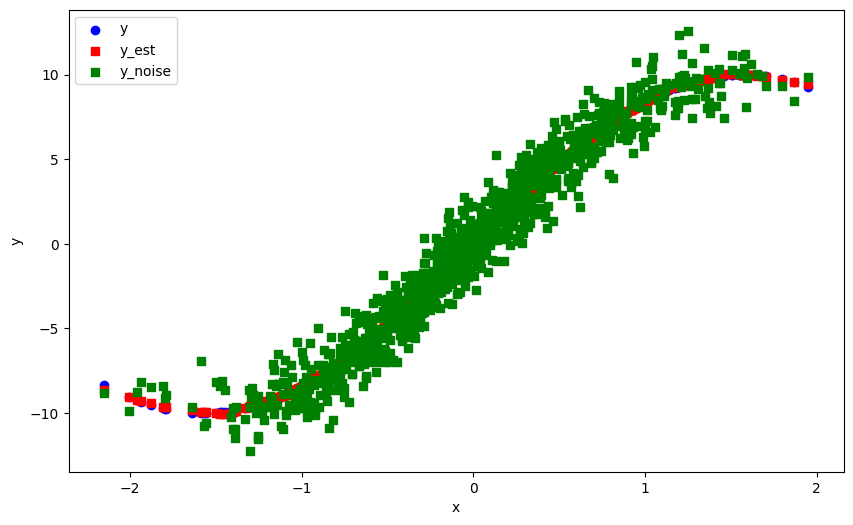

The programm is closed


In [12]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

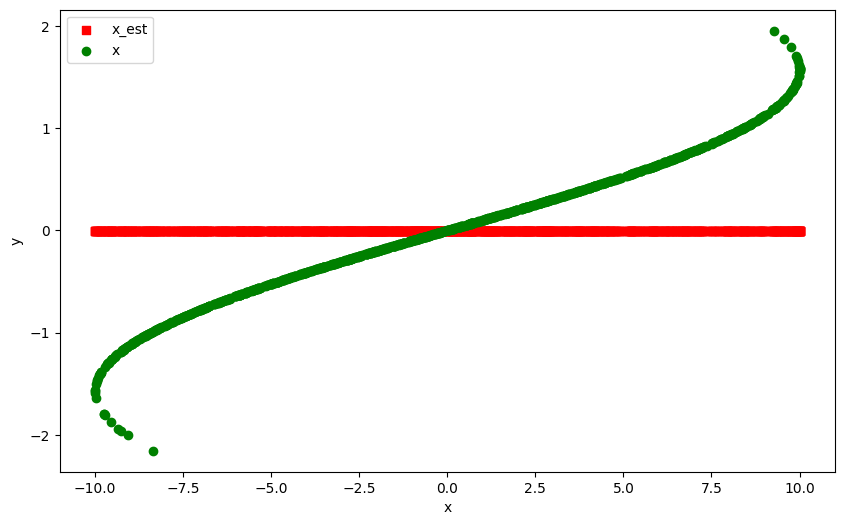

The programm is closed


In [13]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

## no causal

In [14]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[1, 0.6],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.6, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = epsilon[:, 1]
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

### update all parameters together

In [15]:
eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  1%|          | 148/29000 [00:00<01:27, 330.95it/s]

Sigma:  tensor([[0.9605, 0.0195],
        [0.0195, 1.0406]], grad_fn=<MmBackward0>)
obj:  tensor(2.2124, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2077, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


  1%|          | 260/29000 [00:00<01:20, 358.04it/s]

Sigma:  tensor([[0.9208, 0.0374],
        [0.0374, 1.0787]], grad_fn=<MmBackward0>)
obj:  tensor(1.9938, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9792, grad_fn=<AddBackward0>)
h_val:  tensor(0.0070, grad_fn=<AddBackward0>)


  1%|          | 333/29000 [00:01<01:22, 349.47it/s]

Sigma:  tensor([[0.8801, 0.0529],
        [0.0529, 1.1058]], grad_fn=<MmBackward0>)
obj:  tensor(1.7742, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7415, grad_fn=<AddBackward0>)
h_val:  tensor(0.0200, grad_fn=<AddBackward0>)


  2%|▏         | 435/29000 [00:01<01:33, 305.60it/s]

Sigma:  tensor([[0.8385, 0.0648],
        [0.0648, 1.1110]], grad_fn=<MmBackward0>)
obj:  tensor(1.5585, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4951, grad_fn=<AddBackward0>)
h_val:  tensor(0.0447, grad_fn=<AddBackward0>)


  2%|▏         | 546/29000 [00:01<01:22, 343.18it/s]

Sigma:  tensor([[0.7966, 0.0721],
        [0.0721, 1.0903]], grad_fn=<MmBackward0>)
obj:  tensor(1.3535, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2419, grad_fn=<AddBackward0>)
h_val:  tensor(0.0864, grad_fn=<AddBackward0>)


  2%|▏         | 664/29000 [00:01<01:14, 377.88it/s]

Sigma:  tensor([[0.7553, 0.0741],
        [0.0741, 1.0508]], grad_fn=<MmBackward0>)
obj:  tensor(1.1655, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9848, grad_fn=<AddBackward0>)
h_val:  tensor(0.1493, grad_fn=<AddBackward0>)


  3%|▎         | 748/29000 [00:02<01:12, 389.95it/s]

Sigma:  tensor([[0.7150, 0.0709],
        [0.0709, 1.0020]], grad_fn=<MmBackward0>)
obj:  tensor(0.9981, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7265, grad_fn=<AddBackward0>)
h_val:  tensor(0.2351, grad_fn=<AddBackward0>)


  3%|▎         | 868/29000 [00:02<01:18, 360.55it/s]

Sigma:  tensor([[0.6763, 0.0642],
        [0.0642, 0.9503]], grad_fn=<MmBackward0>)
obj:  tensor(0.8596, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4785, grad_fn=<AddBackward0>)
h_val:  tensor(0.3409, grad_fn=<AddBackward0>)


  3%|▎         | 946/29000 [00:02<01:14, 374.39it/s]

Sigma:  tensor([[0.6395, 0.0563],
        [0.0563, 0.8991]], grad_fn=<MmBackward0>)
obj:  tensor(0.7586, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2655, grad_fn=<AddBackward0>)
h_val:  tensor(0.4509, grad_fn=<AddBackward0>)


  4%|▎         | 1068/29000 [00:03<01:14, 373.83it/s]

Sigma:  tensor([[0.6052, 0.0494],
        [0.0494, 0.8505]], grad_fn=<MmBackward0>)
obj:  tensor(0.6833, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1124, grad_fn=<AddBackward0>)
h_val:  tensor(0.5282, grad_fn=<AddBackward0>)


  4%|▍         | 1150/29000 [00:03<01:11, 388.69it/s]

Sigma:  tensor([[0.5736, 0.0446],
        [0.0446, 0.8056]], grad_fn=<MmBackward0>)
obj:  tensor(0.6084, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0164, grad_fn=<AddBackward0>)
h_val:  tensor(0.5496, grad_fn=<AddBackward0>)


  4%|▍         | 1270/29000 [00:03<01:10, 392.28it/s]

Sigma:  tensor([[0.5450, 0.0413],
        [0.0413, 0.7650]], grad_fn=<MmBackward0>)
obj:  tensor(0.5299, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0569, grad_fn=<AddBackward0>)
h_val:  tensor(0.5439, grad_fn=<AddBackward0>)


  5%|▍         | 1351/29000 [00:03<01:13, 373.93it/s]

Sigma:  tensor([[0.5189, 0.0378],
        [0.0378, 0.7283]], grad_fn=<MmBackward0>)
obj:  tensor(0.4535, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1423, grad_fn=<AddBackward0>)
h_val:  tensor(0.5518, grad_fn=<AddBackward0>)


  5%|▌         | 1467/29000 [00:04<01:12, 379.84it/s]

Sigma:  tensor([[0.4950, 0.0329],
        [0.0329, 0.6944]], grad_fn=<MmBackward0>)
obj:  tensor(0.3811, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.2467, grad_fn=<AddBackward0>)
h_val:  tensor(0.5823, grad_fn=<AddBackward0>)


  5%|▌         | 1544/29000 [00:04<01:16, 357.44it/s]

Sigma:  tensor([[0.4727, 0.0261],
        [0.0261, 0.6625]], grad_fn=<MmBackward0>)
obj:  tensor(0.3113, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3556, grad_fn=<AddBackward0>)
h_val:  tensor(0.6200, grad_fn=<AddBackward0>)


  6%|▌         | 1655/29000 [00:04<01:20, 339.80it/s]

Sigma:  tensor([[0.4517, 0.0179],
        [0.0179, 0.6323]], grad_fn=<MmBackward0>)
obj:  tensor(0.2420, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.4561, grad_fn=<AddBackward0>)
h_val:  tensor(0.6502, grad_fn=<AddBackward0>)


  6%|▌         | 1771/29000 [00:04<01:16, 357.87it/s]

Sigma:  tensor([[0.4319, 0.0084],
        [0.0084, 0.6038]], grad_fn=<MmBackward0>)
obj:  tensor(0.1730, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.5517, grad_fn=<AddBackward0>)
h_val:  tensor(0.6755, grad_fn=<AddBackward0>)


  6%|▋         | 1846/29000 [00:05<01:16, 355.64it/s]

Sigma:  tensor([[ 0.4132, -0.0026],
        [-0.0026,  0.5771]], grad_fn=<MmBackward0>)
obj:  tensor(0.1056, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6477, grad_fn=<AddBackward0>)
h_val:  tensor(0.7027, grad_fn=<AddBackward0>)


  7%|▋         | 1960/29000 [00:05<01:16, 351.66it/s]

Sigma:  tensor([[ 0.3955, -0.0148],
        [-0.0148,  0.5524]], grad_fn=<MmBackward0>)
obj:  tensor(0.0402, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.7428, grad_fn=<AddBackward0>)
h_val:  tensor(0.7312, grad_fn=<AddBackward0>)


  7%|▋         | 2076/29000 [00:05<01:11, 374.18it/s]

Sigma:  tensor([[ 0.3787, -0.0280],
        [-0.0280,  0.5299]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0293, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.8336, grad_fn=<AddBackward0>)
h_val:  tensor(0.7514, grad_fn=<AddBackward0>)


  7%|▋         | 2153/29000 [00:06<01:11, 374.77it/s]

Sigma:  tensor([[ 0.3627, -0.0418],
        [-0.0418,  0.5097]], grad_fn=<MmBackward0>)
obj:  tensor(-0.0987, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9241, grad_fn=<AddBackward0>)
h_val:  tensor(0.7713, grad_fn=<AddBackward0>)


  8%|▊         | 2273/29000 [00:06<01:08, 388.99it/s]

Sigma:  tensor([[ 0.3475, -0.0559],
        [-0.0559,  0.4920]], grad_fn=<MmBackward0>)
obj:  tensor(-0.1690, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.0141, grad_fn=<AddBackward0>)
h_val:  tensor(0.7899, grad_fn=<AddBackward0>)


  8%|▊         | 2351/29000 [00:06<01:11, 371.53it/s]

Sigma:  tensor([[ 0.3331, -0.0701],
        [-0.0701,  0.4769]], grad_fn=<MmBackward0>)
obj:  tensor(-0.2414, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1046, grad_fn=<AddBackward0>)
h_val:  tensor(0.8069, grad_fn=<AddBackward0>)


  9%|▊         | 2473/29000 [00:06<01:09, 383.54it/s]

Sigma:  tensor([[ 0.3193, -0.0841],
        [-0.0841,  0.4641]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3165, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.1955, grad_fn=<AddBackward0>)
h_val:  tensor(0.8217, grad_fn=<AddBackward0>)


  9%|▉         | 2551/29000 [00:07<01:13, 360.21it/s]

Sigma:  tensor([[ 0.3062, -0.0976],
        [-0.0976,  0.4538]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3913, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2871, grad_fn=<AddBackward0>)
h_val:  tensor(0.8374, grad_fn=<AddBackward0>)


  9%|▉         | 2670/29000 [00:07<01:08, 385.57it/s]

Sigma:  tensor([[ 0.2937, -0.1106],
        [-0.1106,  0.4458]], grad_fn=<MmBackward0>)
obj:  tensor(-0.4675, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3768, grad_fn=<AddBackward0>)
h_val:  tensor(0.8499, grad_fn=<AddBackward0>)


  9%|▉         | 2748/29000 [00:07<01:10, 373.56it/s]

Sigma:  tensor([[ 0.2817, -0.1230],
        [-0.1230,  0.4401]], grad_fn=<MmBackward0>)
obj:  tensor(-0.5453, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.4689, grad_fn=<AddBackward0>)
h_val:  tensor(0.8633, grad_fn=<AddBackward0>)


 10%|▉         | 2852/29000 [00:08<01:38, 266.57it/s]

Sigma:  tensor([[ 0.2702, -0.1347],
        [-0.1347,  0.4364]], grad_fn=<MmBackward0>)
obj:  tensor(-0.6234, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5595, grad_fn=<AddBackward0>)
h_val:  tensor(0.8750, grad_fn=<AddBackward0>)


 10%|█         | 2969/29000 [00:08<01:15, 342.69it/s]

Sigma:  tensor([[ 0.2593, -0.1458],
        [-0.1458,  0.4347]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7025, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.6511, grad_fn=<AddBackward0>)
h_val:  tensor(0.8866, grad_fn=<AddBackward0>)


 11%|█         | 3047/29000 [00:08<01:11, 364.31it/s]

Sigma:  tensor([[ 0.2488, -0.1561],
        [-0.1561,  0.4350]], grad_fn=<MmBackward0>)
obj:  tensor(-0.7830, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.7411, grad_fn=<AddBackward0>)
h_val:  tensor(0.8953, grad_fn=<AddBackward0>)


 11%|█         | 3170/29000 [00:08<01:06, 387.17it/s]

Sigma:  tensor([[ 0.2388, -0.1658],
        [-0.1658,  0.4370]], grad_fn=<MmBackward0>)
obj:  tensor(-0.8644, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.8344, grad_fn=<AddBackward0>)
h_val:  tensor(0.9066, grad_fn=<AddBackward0>)


 11%|█         | 3251/29000 [00:09<01:06, 387.21it/s]

Sigma:  tensor([[ 0.2292, -0.1747],
        [-0.1747,  0.4406]], grad_fn=<MmBackward0>)
obj:  tensor(-0.9459, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.9254, grad_fn=<AddBackward0>)
h_val:  tensor(0.9154, grad_fn=<AddBackward0>)


 12%|█▏        | 3377/29000 [00:09<01:04, 396.79it/s]

Sigma:  tensor([[ 0.2199, -0.1830],
        [-0.1830,  0.4458]], grad_fn=<MmBackward0>)
obj:  tensor(-1.0283, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.0163, grad_fn=<AddBackward0>)
h_val:  tensor(0.9233, grad_fn=<AddBackward0>)


 12%|█▏        | 3456/29000 [00:09<01:10, 363.52it/s]

Sigma:  tensor([[ 0.2111, -0.1906],
        [-0.1906,  0.4525]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1103, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.1080, grad_fn=<AddBackward0>)
h_val:  tensor(0.9324, grad_fn=<AddBackward0>)


 12%|█▏        | 3576/29000 [00:10<01:06, 384.51it/s]

Sigma:  tensor([[ 0.2027, -0.1976],
        [-0.1976,  0.4605]], grad_fn=<MmBackward0>)
obj:  tensor(-1.1931, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2004, grad_fn=<AddBackward0>)
h_val:  tensor(0.9414, grad_fn=<AddBackward0>)


 13%|█▎        | 3654/29000 [00:10<01:08, 371.98it/s]

Sigma:  tensor([[ 0.1945, -0.2041],
        [-0.2041,  0.4697]], grad_fn=<MmBackward0>)
obj:  tensor(-1.2762, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.2917, grad_fn=<AddBackward0>)
h_val:  tensor(0.9492, grad_fn=<AddBackward0>)


 13%|█▎        | 3776/29000 [00:10<01:03, 395.76it/s]

Sigma:  tensor([[ 0.1868, -0.2099],
        [-0.2099,  0.4802]], grad_fn=<MmBackward0>)
obj:  tensor(-1.3592, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3838, grad_fn=<AddBackward0>)
h_val:  tensor(0.9578, grad_fn=<AddBackward0>)


 13%|█▎        | 3855/29000 [00:10<01:05, 386.61it/s]

Sigma:  tensor([[ 0.1793, -0.2152],
        [-0.2152,  0.4916]], grad_fn=<MmBackward0>)
obj:  tensor(-1.4408, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.4749, grad_fn=<AddBackward0>)
h_val:  tensor(0.9668, grad_fn=<AddBackward0>)


 14%|█▎        | 3975/29000 [00:11<01:06, 376.09it/s]

Sigma:  tensor([[ 0.1721, -0.2200],
        [-0.2200,  0.5042]], grad_fn=<MmBackward0>)
obj:  tensor(-1.5229, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.5658, grad_fn=<AddBackward0>)
h_val:  tensor(0.9751, grad_fn=<AddBackward0>)


 14%|█▍        | 4053/29000 [00:11<01:05, 380.58it/s]

Sigma:  tensor([[ 0.1652, -0.2244],
        [-0.2244,  0.5176]], grad_fn=<MmBackward0>)
obj:  tensor(-1.6034, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.6557, grad_fn=<AddBackward0>)
h_val:  tensor(0.9841, grad_fn=<AddBackward0>)


 14%|█▍        | 4173/29000 [00:11<01:05, 380.20it/s]

Sigma:  tensor([[ 0.1587, -0.2283],
        [-0.2283,  0.5320]], grad_fn=<MmBackward0>)
obj:  tensor(-1.6843, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.7459, grad_fn=<AddBackward0>)
h_val:  tensor(0.9930, grad_fn=<AddBackward0>)


 15%|█▍        | 4252/29000 [00:11<01:04, 382.52it/s]

Sigma:  tensor([[ 0.1523, -0.2317],
        [-0.2317,  0.5471]], grad_fn=<MmBackward0>)
obj:  tensor(-1.7654, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.8355, grad_fn=<AddBackward0>)
h_val:  tensor(1.0011, grad_fn=<AddBackward0>)


 15%|█▌        | 4375/29000 [00:12<01:03, 390.62it/s]

Sigma:  tensor([[ 0.1463, -0.2348],
        [-0.2348,  0.5629]], grad_fn=<MmBackward0>)
obj:  tensor(-1.8451, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.9239, grad_fn=<AddBackward0>)
h_val:  tensor(1.0095, grad_fn=<AddBackward0>)


 15%|█▌        | 4454/29000 [00:12<01:03, 387.75it/s]

Sigma:  tensor([[ 0.1405, -0.2375],
        [-0.2375,  0.5794]], grad_fn=<MmBackward0>)
obj:  tensor(-1.9248, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.0130, grad_fn=<AddBackward0>)
h_val:  tensor(1.0186, grad_fn=<AddBackward0>)


 16%|█▌        | 4534/29000 [00:12<01:07, 364.90it/s]

Sigma:  tensor([[ 0.1349, -0.2398],
        [-0.2398,  0.5966]], grad_fn=<MmBackward0>)
obj:  tensor(-2.0025, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1018, grad_fn=<AddBackward0>)
h_val:  tensor(1.0294, grad_fn=<AddBackward0>)


 16%|█▌        | 4661/29000 [00:12<01:02, 389.52it/s]

Sigma:  tensor([[ 0.1296, -0.2419],
        [-0.2419,  0.6143]], grad_fn=<MmBackward0>)
obj:  tensor(-2.0816, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1893, grad_fn=<AddBackward0>)
h_val:  tensor(1.0376, grad_fn=<AddBackward0>)


 16%|█▋        | 4740/29000 [00:13<01:03, 383.44it/s]

Sigma:  tensor([[ 0.1244, -0.2436],
        [-0.2436,  0.6325]], grad_fn=<MmBackward0>)
obj:  tensor(-2.1591, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.2771, grad_fn=<AddBackward0>)
h_val:  tensor(1.0475, grad_fn=<AddBackward0>)


 17%|█▋        | 4857/29000 [00:13<01:04, 375.66it/s]

Sigma:  tensor([[ 0.1195, -0.2450],
        [-0.2450,  0.6513]], grad_fn=<MmBackward0>)
obj:  tensor(-2.2361, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.3645, grad_fn=<AddBackward0>)
h_val:  tensor(1.0576, grad_fn=<AddBackward0>)


 17%|█▋        | 4934/29000 [00:13<01:07, 357.57it/s]

Sigma:  tensor([[ 0.1148, -0.2462],
        [-0.2462,  0.6705]], grad_fn=<MmBackward0>)
obj:  tensor(-2.3120, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.4514, grad_fn=<AddBackward0>)
h_val:  tensor(1.0683, grad_fn=<AddBackward0>)


 17%|█▋        | 5060/29000 [00:13<01:01, 386.55it/s]

Sigma:  tensor([[ 0.1103, -0.2471],
        [-0.2471,  0.6902]], grad_fn=<MmBackward0>)
obj:  tensor(-2.3887, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.5382, grad_fn=<AddBackward0>)
h_val:  tensor(1.0782, grad_fn=<AddBackward0>)


 18%|█▊        | 5182/29000 [00:14<00:59, 399.85it/s]

Sigma:  tensor([[ 0.1060, -0.2478],
        [-0.2478,  0.7103]], grad_fn=<MmBackward0>)
obj:  tensor(-2.4641, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6245, grad_fn=<AddBackward0>)
h_val:  tensor(1.0887, grad_fn=<AddBackward0>)


 18%|█▊        | 5265/29000 [00:14<00:59, 401.29it/s]

Sigma:  tensor([[ 0.1018, -0.2482],
        [-0.2482,  0.7308]], grad_fn=<MmBackward0>)
obj:  tensor(-2.5386, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7106, grad_fn=<AddBackward0>)
h_val:  tensor(1.1001, grad_fn=<AddBackward0>)


 18%|█▊        | 5346/29000 [00:14<01:00, 391.84it/s]

Sigma:  tensor([[ 0.0978, -0.2485],
        [-0.2485,  0.7517]], grad_fn=<MmBackward0>)
obj:  tensor(-2.6135, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7963, grad_fn=<AddBackward0>)
h_val:  tensor(1.1107, grad_fn=<AddBackward0>)


 19%|█▉        | 5475/29000 [00:14<00:57, 406.79it/s]

Sigma:  tensor([[ 0.0940, -0.2486],
        [-0.2486,  0.7729]], grad_fn=<MmBackward0>)
obj:  tensor(-2.6877, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8818, grad_fn=<AddBackward0>)
h_val:  tensor(1.1217, grad_fn=<AddBackward0>)


 19%|█▉        | 5557/29000 [00:15<00:59, 391.44it/s]

Sigma:  tensor([[ 0.0903, -0.2485],
        [-0.2485,  0.7945]], grad_fn=<MmBackward0>)
obj:  tensor(-2.7612, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9670, grad_fn=<AddBackward0>)
h_val:  tensor(1.1332, grad_fn=<AddBackward0>)


 20%|█▉        | 5683/29000 [00:15<00:57, 408.02it/s]

Sigma:  tensor([[ 0.0868, -0.2483],
        [-0.2483,  0.8164]], grad_fn=<MmBackward0>)
obj:  tensor(-2.8343, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0521, grad_fn=<AddBackward0>)
h_val:  tensor(1.1450, grad_fn=<AddBackward0>)


 20%|█▉        | 5765/29000 [00:15<00:57, 403.01it/s]

Sigma:  tensor([[ 0.0834, -0.2479],
        [-0.2479,  0.8387]], grad_fn=<MmBackward0>)
obj:  tensor(-2.9071, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1368, grad_fn=<AddBackward0>)
h_val:  tensor(1.1566, grad_fn=<AddBackward0>)


 20%|██        | 5847/29000 [00:15<00:58, 399.04it/s]

Sigma:  tensor([[ 0.0801, -0.2474],
        [-0.2474,  0.8612]], grad_fn=<MmBackward0>)
obj:  tensor(-2.9791, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2213, grad_fn=<AddBackward0>)
h_val:  tensor(1.1689, grad_fn=<AddBackward0>)


 21%|██        | 5977/29000 [00:16<00:55, 413.54it/s]

Sigma:  tensor([[ 0.0770, -0.2467],
        [-0.2467,  0.8840]], grad_fn=<MmBackward0>)
obj:  tensor(-3.0509, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3057, grad_fn=<AddBackward0>)
h_val:  tensor(1.1812, grad_fn=<AddBackward0>)


 21%|██        | 6060/29000 [00:16<00:56, 406.26it/s]

Sigma:  tensor([[ 0.0740, -0.2460],
        [-0.2460,  0.9072]], grad_fn=<MmBackward0>)
obj:  tensor(-3.1228, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3895, grad_fn=<AddBackward0>)
h_val:  tensor(1.1930, grad_fn=<AddBackward0>)


 21%|██        | 6141/29000 [00:16<00:57, 399.02it/s]

Sigma:  tensor([[ 0.0711, -0.2451],
        [-0.2451,  0.9306]], grad_fn=<MmBackward0>)
obj:  tensor(-3.1940, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4733, grad_fn=<AddBackward0>)
h_val:  tensor(1.2053, grad_fn=<AddBackward0>)


 22%|██▏       | 6274/29000 [00:16<00:54, 413.75it/s]

Sigma:  tensor([[ 0.0683, -0.2441],
        [-0.2441,  0.9543]], grad_fn=<MmBackward0>)
obj:  tensor(-3.2647, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5570, grad_fn=<AddBackward0>)
h_val:  tensor(1.2181, grad_fn=<AddBackward0>)


 22%|██▏       | 6357/29000 [00:17<00:55, 406.01it/s]

Sigma:  tensor([[ 0.0657, -0.2430],
        [-0.2430,  0.9783]], grad_fn=<MmBackward0>)
obj:  tensor(-3.3352, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6405, grad_fn=<AddBackward0>)
h_val:  tensor(1.2308, grad_fn=<AddBackward0>)


 22%|██▏       | 6482/29000 [00:17<00:54, 412.19it/s]

Sigma:  tensor([[ 0.0631, -0.2419],
        [-0.2419,  1.0025]], grad_fn=<MmBackward0>)
obj:  tensor(-3.4057, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7237, grad_fn=<AddBackward0>)
h_val:  tensor(1.2433, grad_fn=<AddBackward0>)


 23%|██▎       | 6564/29000 [00:17<00:56, 394.23it/s]

Sigma:  tensor([[ 0.0607, -0.2406],
        [-0.2406,  1.0271]], grad_fn=<MmBackward0>)
obj:  tensor(-3.4756, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8067, grad_fn=<AddBackward0>)
h_val:  tensor(1.2562, grad_fn=<AddBackward0>)


 23%|██▎       | 6643/29000 [00:17<00:58, 381.20it/s]

Sigma:  tensor([[ 0.0583, -0.2393],
        [-0.2393,  1.0519]], grad_fn=<MmBackward0>)
obj:  tensor(-3.5444, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8897, grad_fn=<AddBackward0>)
h_val:  tensor(1.2702, grad_fn=<AddBackward0>)


 23%|██▎       | 6770/29000 [00:18<00:55, 397.01it/s]

Sigma:  tensor([[ 0.0560, -0.2379],
        [-0.2379,  1.0769]], grad_fn=<MmBackward0>)
obj:  tensor(-3.6139, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9724, grad_fn=<AddBackward0>)
h_val:  tensor(1.2832, grad_fn=<AddBackward0>)


 24%|██▎       | 6851/29000 [00:18<00:57, 387.87it/s]

Sigma:  tensor([[ 0.0539, -0.2365],
        [-0.2365,  1.1022]], grad_fn=<MmBackward0>)
obj:  tensor(-3.6831, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0551, grad_fn=<AddBackward0>)
h_val:  tensor(1.2964, grad_fn=<AddBackward0>)


 24%|██▍       | 6970/29000 [00:18<01:00, 364.12it/s]

Sigma:  tensor([[ 0.0518, -0.2349],
        [-0.2349,  1.1278]], grad_fn=<MmBackward0>)
obj:  tensor(-3.7514, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1377, grad_fn=<AddBackward0>)
h_val:  tensor(1.3105, grad_fn=<AddBackward0>)


 25%|██▍       | 7169/29000 [00:19<00:55, 390.06it/s]

Sigma:  tensor([[ 0.0499, -0.2305],
        [-0.2305,  1.1223]], grad_fn=<MmBackward0>)
obj:  tensor(0.6058, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6982, grad_fn=<AddBackward0>)
h_val:  tensor(0.9683, grad_fn=<AddBackward0>)


 25%|██▌       | 7252/29000 [00:19<00:55, 394.61it/s]

Sigma:  tensor([[ 0.0518, -0.2302],
        [-0.2302,  1.0806]], grad_fn=<MmBackward0>)
obj:  tensor(0.5132, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3224, grad_fn=<AddBackward0>)
h_val:  tensor(0.9379, grad_fn=<AddBackward0>)


 25%|██▌       | 7341/29000 [00:19<00:52, 415.01it/s]

Sigma:  tensor([[ 0.0532, -0.2294],
        [-0.2294,  1.0445]], grad_fn=<MmBackward0>)
obj:  tensor(0.4653, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9343, grad_fn=<AddBackward0>)
h_val:  tensor(0.8510, grad_fn=<AddBackward0>)


 26%|██▌       | 7469/29000 [00:20<00:53, 401.30it/s]

Sigma:  tensor([[ 0.0548, -0.2285],
        [-0.2285,  1.0069]], grad_fn=<MmBackward0>)
obj:  tensor(0.4343, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8816, grad_fn=<AddBackward0>)
h_val:  tensor(0.8143, grad_fn=<AddBackward0>)


 26%|██▌       | 7548/29000 [00:20<01:00, 357.07it/s]

Sigma:  tensor([[ 0.0562, -0.2273],
        [-0.2273,  0.9706]], grad_fn=<MmBackward0>)
obj:  tensor(0.4134, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8051, grad_fn=<AddBackward0>)
h_val:  tensor(0.7855, grad_fn=<AddBackward0>)


 26%|██▋       | 7661/29000 [00:20<01:23, 255.90it/s]

Sigma:  tensor([[ 0.0576, -0.2257],
        [-0.2257,  0.9352]], grad_fn=<MmBackward0>)
obj:  tensor(0.3992, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7259, grad_fn=<AddBackward0>)
h_val:  tensor(0.7633, grad_fn=<AddBackward0>)


 27%|██▋       | 7777/29000 [00:21<01:03, 331.74it/s]

Sigma:  tensor([[ 0.0588, -0.2239],
        [-0.2239,  0.9005]], grad_fn=<MmBackward0>)
obj:  tensor(0.3863, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6841, grad_fn=<AddBackward0>)
h_val:  tensor(0.7462, grad_fn=<AddBackward0>)


 27%|██▋       | 7855/29000 [00:21<00:58, 359.43it/s]

Sigma:  tensor([[ 0.0601, -0.2221],
        [-0.2221,  0.8668]], grad_fn=<MmBackward0>)
obj:  tensor(0.3737, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6734, grad_fn=<AddBackward0>)
h_val:  tensor(0.7325, grad_fn=<AddBackward0>)


 28%|██▊       | 7978/29000 [00:21<00:54, 388.64it/s]

Sigma:  tensor([[ 0.0615, -0.2203],
        [-0.2203,  0.8342]], grad_fn=<MmBackward0>)
obj:  tensor(0.3617, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6857, grad_fn=<AddBackward0>)
h_val:  tensor(0.7218, grad_fn=<AddBackward0>)


 28%|██▊       | 8057/29000 [00:21<00:54, 383.31it/s]

Sigma:  tensor([[ 0.0629, -0.2187],
        [-0.2187,  0.8025]], grad_fn=<MmBackward0>)
obj:  tensor(0.3499, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7043, grad_fn=<AddBackward0>)
h_val:  tensor(0.7120, grad_fn=<AddBackward0>)


 28%|██▊       | 8173/29000 [00:22<00:55, 376.74it/s]

Sigma:  tensor([[ 0.0645, -0.2172],
        [-0.2172,  0.7719]], grad_fn=<MmBackward0>)
obj:  tensor(0.3387, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7037, grad_fn=<AddBackward0>)
h_val:  tensor(0.7008, grad_fn=<AddBackward0>)


 28%|██▊       | 8250/29000 [00:22<00:57, 363.71it/s]

Sigma:  tensor([[ 0.0662, -0.2158],
        [-0.2158,  0.7423]], grad_fn=<MmBackward0>)
obj:  tensor(0.3278, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7044, grad_fn=<AddBackward0>)
h_val:  tensor(0.6900, grad_fn=<AddBackward0>)


 29%|██▉       | 8370/29000 [00:22<00:53, 385.02it/s]

Sigma:  tensor([[ 0.0680, -0.2144],
        [-0.2144,  0.7138]], grad_fn=<MmBackward0>)
obj:  tensor(0.3172, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7013, grad_fn=<AddBackward0>)
h_val:  tensor(0.6791, grad_fn=<AddBackward0>)


 29%|██▉       | 8447/29000 [00:22<00:55, 368.62it/s]

Sigma:  tensor([[ 0.0699, -0.2132],
        [-0.2132,  0.6864]], grad_fn=<MmBackward0>)
obj:  tensor(0.3068, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6968, grad_fn=<AddBackward0>)
h_val:  tensor(0.6684, grad_fn=<AddBackward0>)


 30%|██▉       | 8574/29000 [00:23<00:51, 393.67it/s]

Sigma:  tensor([[ 0.0719, -0.2121],
        [-0.2121,  0.6602]], grad_fn=<MmBackward0>)
obj:  tensor(0.2968, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6962, grad_fn=<AddBackward0>)
h_val:  tensor(0.6584, grad_fn=<AddBackward0>)


 30%|██▉       | 8655/29000 [00:23<00:51, 394.23it/s]

Sigma:  tensor([[ 0.0740, -0.2110],
        [-0.2110,  0.6351]], grad_fn=<MmBackward0>)
obj:  tensor(0.2871, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.6988, grad_fn=<AddBackward0>)
h_val:  tensor(0.6490, grad_fn=<AddBackward0>)


 30%|███       | 8781/29000 [00:23<00:49, 404.81it/s]

Sigma:  tensor([[ 0.0762, -0.2100],
        [-0.2100,  0.6110]], grad_fn=<MmBackward0>)
obj:  tensor(0.2779, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7021, grad_fn=<AddBackward0>)
h_val:  tensor(0.6402, grad_fn=<AddBackward0>)


 31%|███       | 8863/29000 [00:23<00:50, 399.77it/s]

Sigma:  tensor([[ 0.0785, -0.2091],
        [-0.2091,  0.5881]], grad_fn=<MmBackward0>)
obj:  tensor(0.2690, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7051, grad_fn=<AddBackward0>)
h_val:  tensor(0.6316, grad_fn=<AddBackward0>)


 31%|███       | 8944/29000 [00:24<00:51, 392.63it/s]

Sigma:  tensor([[ 0.0809, -0.2083],
        [-0.2083,  0.5663]], grad_fn=<MmBackward0>)
obj:  tensor(0.2605, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7083, grad_fn=<AddBackward0>)
h_val:  tensor(0.6235, grad_fn=<AddBackward0>)


 31%|███▏      | 9074/29000 [00:24<00:48, 409.99it/s]

Sigma:  tensor([[ 0.0833, -0.2076],
        [-0.2076,  0.5457]], grad_fn=<MmBackward0>)
obj:  tensor(0.2524, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7120, grad_fn=<AddBackward0>)
h_val:  tensor(0.6159, grad_fn=<AddBackward0>)


 32%|███▏      | 9157/29000 [00:24<00:49, 401.89it/s]

Sigma:  tensor([[ 0.0858, -0.2069],
        [-0.2069,  0.5261]], grad_fn=<MmBackward0>)
obj:  tensor(0.2447, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7166, grad_fn=<AddBackward0>)
h_val:  tensor(0.6087, grad_fn=<AddBackward0>)


 32%|███▏      | 9281/29000 [00:24<00:48, 405.64it/s]

Sigma:  tensor([[ 0.0885, -0.2064],
        [-0.2064,  0.5078]], grad_fn=<MmBackward0>)
obj:  tensor(0.2375, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7225, grad_fn=<AddBackward0>)
h_val:  tensor(0.6021, grad_fn=<AddBackward0>)


 32%|███▏      | 9363/29000 [00:25<00:50, 388.84it/s]

Sigma:  tensor([[ 0.0911, -0.2059],
        [-0.2059,  0.4905]], grad_fn=<MmBackward0>)
obj:  tensor(0.2303, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7290, grad_fn=<AddBackward0>)
h_val:  tensor(0.5956, grad_fn=<AddBackward0>)


 33%|███▎      | 9442/29000 [00:25<00:50, 388.46it/s]

Sigma:  tensor([[ 0.0939, -0.2056],
        [-0.2056,  0.4745]], grad_fn=<MmBackward0>)
obj:  tensor(0.2239, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7372, grad_fn=<AddBackward0>)
h_val:  tensor(0.5901, grad_fn=<AddBackward0>)


 33%|███▎      | 9572/29000 [00:25<00:47, 410.98it/s]

Sigma:  tensor([[ 0.0966, -0.2053],
        [-0.2053,  0.4596]], grad_fn=<MmBackward0>)
obj:  tensor(0.2179, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7447, grad_fn=<AddBackward0>)
h_val:  tensor(0.5849, grad_fn=<AddBackward0>)


 33%|███▎      | 9656/29000 [00:25<00:47, 406.49it/s]

Sigma:  tensor([[ 0.0995, -0.2052],
        [-0.2052,  0.4458]], grad_fn=<MmBackward0>)
obj:  tensor(0.2121, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7581, grad_fn=<AddBackward0>)
h_val:  tensor(0.5805, grad_fn=<AddBackward0>)


 34%|███▎      | 9782/29000 [00:26<00:46, 411.83it/s]

Sigma:  tensor([[ 0.1023, -0.2053],
        [-0.2053,  0.4333]], grad_fn=<MmBackward0>)
obj:  tensor(0.2065, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7726, grad_fn=<AddBackward0>)
h_val:  tensor(0.5764, grad_fn=<AddBackward0>)


 34%|███▍      | 9865/29000 [00:26<00:47, 402.30it/s]

Sigma:  tensor([[ 0.1052, -0.2054],
        [-0.2054,  0.4218]], grad_fn=<MmBackward0>)
obj:  tensor(0.2013, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.7875, grad_fn=<AddBackward0>)
h_val:  tensor(0.5727, grad_fn=<AddBackward0>)


 34%|███▍      | 9947/29000 [00:26<00:47, 398.98it/s]

Sigma:  tensor([[ 0.1081, -0.2058],
        [-0.2058,  0.4114]], grad_fn=<MmBackward0>)
obj:  tensor(0.1964, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8058, grad_fn=<AddBackward0>)
h_val:  tensor(0.5696, grad_fn=<AddBackward0>)


 35%|███▍      | 10075/29000 [00:26<00:46, 408.65it/s]

Sigma:  tensor([[ 0.1110, -0.2062],
        [-0.2062,  0.4022]], grad_fn=<MmBackward0>)
obj:  tensor(0.1917, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8256, grad_fn=<AddBackward0>)
h_val:  tensor(0.5669, grad_fn=<AddBackward0>)


 35%|███▌      | 10157/29000 [00:27<00:47, 400.59it/s]

Sigma:  tensor([[ 0.1139, -0.2069],
        [-0.2069,  0.3940]], grad_fn=<MmBackward0>)
obj:  tensor(0.1873, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8482, grad_fn=<AddBackward0>)
h_val:  tensor(0.5648, grad_fn=<AddBackward0>)


 35%|███▌      | 10284/29000 [00:27<00:45, 413.95it/s]

Sigma:  tensor([[ 0.1168, -0.2076],
        [-0.2076,  0.3868]], grad_fn=<MmBackward0>)
obj:  tensor(0.1831, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.8726, grad_fn=<AddBackward0>)
h_val:  tensor(0.5631, grad_fn=<AddBackward0>)


 36%|███▌      | 10367/29000 [00:27<00:46, 396.76it/s]

Sigma:  tensor([[ 0.1196, -0.2086],
        [-0.2086,  0.3806]], grad_fn=<MmBackward0>)
obj:  tensor(0.1787, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9002, grad_fn=<AddBackward0>)
h_val:  tensor(0.5615, grad_fn=<AddBackward0>)


 36%|███▌      | 10447/29000 [00:27<00:47, 394.25it/s]

Sigma:  tensor([[ 0.1224, -0.2096],
        [-0.2096,  0.3752]], grad_fn=<MmBackward0>)
obj:  tensor(0.1750, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9305, grad_fn=<AddBackward0>)
h_val:  tensor(0.5608, grad_fn=<AddBackward0>)


 36%|███▋      | 10574/29000 [00:28<00:45, 405.05it/s]

Sigma:  tensor([[ 0.1252, -0.2108],
        [-0.2108,  0.3707]], grad_fn=<MmBackward0>)
obj:  tensor(0.1712, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9627, grad_fn=<AddBackward0>)
h_val:  tensor(0.5603, grad_fn=<AddBackward0>)


 37%|███▋      | 10655/29000 [00:28<00:46, 397.50it/s]

Sigma:  tensor([[ 0.1278, -0.2121],
        [-0.2121,  0.3670]], grad_fn=<MmBackward0>)
obj:  tensor(0.1675, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.9975, grad_fn=<AddBackward0>)
h_val:  tensor(0.5601, grad_fn=<AddBackward0>)


 37%|███▋      | 10781/29000 [00:28<00:44, 412.30it/s]

Sigma:  tensor([[ 0.1304, -0.2135],
        [-0.2135,  0.3639]], grad_fn=<MmBackward0>)
obj:  tensor(0.1635, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0329, grad_fn=<AddBackward0>)
h_val:  tensor(0.5596, grad_fn=<AddBackward0>)


 37%|███▋      | 10864/29000 [00:28<00:45, 402.85it/s]

Sigma:  tensor([[ 0.1328, -0.2149],
        [-0.2149,  0.3613]], grad_fn=<MmBackward0>)
obj:  tensor(0.1600, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.0715, grad_fn=<AddBackward0>)
h_val:  tensor(0.5600, grad_fn=<AddBackward0>)


 38%|███▊      | 10946/29000 [00:29<00:45, 397.93it/s]

Sigma:  tensor([[ 0.1352, -0.2163],
        [-0.2163,  0.3592]], grad_fn=<MmBackward0>)
obj:  tensor(0.1567, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1108, grad_fn=<AddBackward0>)
h_val:  tensor(0.5606, grad_fn=<AddBackward0>)


 38%|███▊      | 11075/29000 [00:29<00:43, 410.29it/s]

Sigma:  tensor([[ 0.1374, -0.2177],
        [-0.2177,  0.3576]], grad_fn=<MmBackward0>)
obj:  tensor(0.1530, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1519, grad_fn=<AddBackward0>)
h_val:  tensor(0.5610, grad_fn=<AddBackward0>)


 38%|███▊      | 11158/29000 [00:29<00:45, 392.79it/s]

Sigma:  tensor([[ 0.1394, -0.2190],
        [-0.2190,  0.3563]], grad_fn=<MmBackward0>)
obj:  tensor(0.1495, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.1939, grad_fn=<AddBackward0>)
h_val:  tensor(0.5617, grad_fn=<AddBackward0>)


 39%|███▉      | 11282/29000 [00:29<00:44, 402.57it/s]

Sigma:  tensor([[ 0.1413, -0.2203],
        [-0.2203,  0.3553]], grad_fn=<MmBackward0>)
obj:  tensor(0.1461, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2367, grad_fn=<AddBackward0>)
h_val:  tensor(0.5627, grad_fn=<AddBackward0>)


 39%|███▉      | 11364/29000 [00:30<00:44, 400.09it/s]

Sigma:  tensor([[ 0.1430, -0.2216],
        [-0.2216,  0.3546]], grad_fn=<MmBackward0>)
obj:  tensor(0.1426, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.2814, grad_fn=<AddBackward0>)
h_val:  tensor(0.5636, grad_fn=<AddBackward0>)


 39%|███▉      | 11446/29000 [00:30<00:44, 395.76it/s]

Sigma:  tensor([[ 0.1445, -0.2227],
        [-0.2227,  0.3540]], grad_fn=<MmBackward0>)
obj:  tensor(0.1390, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3258, grad_fn=<AddBackward0>)
h_val:  tensor(0.5644, grad_fn=<AddBackward0>)


 40%|███▉      | 11577/29000 [00:30<00:42, 410.36it/s]

Sigma:  tensor([[ 0.1458, -0.2237],
        [-0.2237,  0.3536]], grad_fn=<MmBackward0>)
obj:  tensor(0.1357, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.3715, grad_fn=<AddBackward0>)
h_val:  tensor(0.5657, grad_fn=<AddBackward0>)


 40%|████      | 11660/29000 [00:30<00:42, 405.52it/s]

Sigma:  tensor([[ 0.1469, -0.2246],
        [-0.2246,  0.3533]], grad_fn=<MmBackward0>)
obj:  tensor(0.1323, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4173, grad_fn=<AddBackward0>)
h_val:  tensor(0.5669, grad_fn=<AddBackward0>)


 40%|████      | 11742/29000 [00:31<00:43, 400.42it/s]

Sigma:  tensor([[ 0.1479, -0.2254],
        [-0.2254,  0.3530]], grad_fn=<MmBackward0>)
obj:  tensor(0.1287, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.4639, grad_fn=<AddBackward0>)
h_val:  tensor(0.5679, grad_fn=<AddBackward0>)


 41%|████      | 11874/29000 [00:31<00:41, 417.08it/s]

Sigma:  tensor([[ 0.1486, -0.2260],
        [-0.2260,  0.3529]], grad_fn=<MmBackward0>)
obj:  tensor(0.1252, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5109, grad_fn=<AddBackward0>)
h_val:  tensor(0.5691, grad_fn=<AddBackward0>)


 41%|████      | 11957/29000 [00:31<00:41, 406.58it/s]

Sigma:  tensor([[ 0.1492, -0.2266],
        [-0.2266,  0.3529]], grad_fn=<MmBackward0>)
obj:  tensor(0.1217, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.5578, grad_fn=<AddBackward0>)
h_val:  tensor(0.5704, grad_fn=<AddBackward0>)


 42%|████▏     | 12039/29000 [00:31<00:43, 386.23it/s]

Sigma:  tensor([[ 0.1496, -0.2270],
        [-0.2270,  0.3529]], grad_fn=<MmBackward0>)
obj:  tensor(0.1181, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6053, grad_fn=<AddBackward0>)
h_val:  tensor(0.5715, grad_fn=<AddBackward0>)


 42%|████▏     | 12167/29000 [00:32<00:41, 401.15it/s]

Sigma:  tensor([[ 0.1498, -0.2273],
        [-0.2273,  0.3530]], grad_fn=<MmBackward0>)
obj:  tensor(0.1145, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.6530, grad_fn=<AddBackward0>)
h_val:  tensor(0.5726, grad_fn=<AddBackward0>)


 42%|████▏     | 12248/29000 [00:32<00:42, 392.75it/s]

Sigma:  tensor([[ 0.1500, -0.2276],
        [-0.2276,  0.3531]], grad_fn=<MmBackward0>)
obj:  tensor(0.1109, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7008, grad_fn=<AddBackward0>)
h_val:  tensor(0.5738, grad_fn=<AddBackward0>)


 43%|████▎     | 12370/29000 [00:32<00:42, 389.73it/s]

Sigma:  tensor([[ 0.1499, -0.2277],
        [-0.2277,  0.3533]], grad_fn=<MmBackward0>)
obj:  tensor(0.1073, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7489, grad_fn=<AddBackward0>)
h_val:  tensor(0.5751, grad_fn=<AddBackward0>)


 43%|████▎     | 12450/29000 [00:32<00:42, 390.03it/s]

Sigma:  tensor([[ 0.1498, -0.2278],
        [-0.2278,  0.3536]], grad_fn=<MmBackward0>)
obj:  tensor(0.1034, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.7974, grad_fn=<AddBackward0>)
h_val:  tensor(0.5759, grad_fn=<AddBackward0>)


 43%|████▎     | 12579/29000 [00:33<00:39, 411.53it/s]

Sigma:  tensor([[ 0.1496, -0.2278],
        [-0.2278,  0.3538]], grad_fn=<MmBackward0>)
obj:  tensor(0.0999, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8456, grad_fn=<AddBackward0>)
h_val:  tensor(0.5773, grad_fn=<AddBackward0>)


 44%|████▎     | 12662/29000 [00:33<00:40, 402.67it/s]

Sigma:  tensor([[ 0.1493, -0.2278],
        [-0.2278,  0.3541]], grad_fn=<MmBackward0>)
obj:  tensor(0.0958, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.8937, grad_fn=<AddBackward0>)
h_val:  tensor(0.5780, grad_fn=<AddBackward0>)


 44%|████▍     | 12743/29000 [00:33<00:41, 396.35it/s]

Sigma:  tensor([[ 0.1490, -0.2277],
        [-0.2277,  0.3544]], grad_fn=<MmBackward0>)
obj:  tensor(0.0923, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9418, grad_fn=<AddBackward0>)
h_val:  tensor(0.5793, grad_fn=<AddBackward0>)


 44%|████▍     | 12876/29000 [00:33<00:39, 406.06it/s]

Sigma:  tensor([[ 0.1486, -0.2276],
        [-0.2276,  0.3548]], grad_fn=<MmBackward0>)
obj:  tensor(0.0888, grad_fn=<AddBackward0>)
mle loss:  tensor(-4.9897, grad_fn=<AddBackward0>)
h_val:  tensor(0.5806, grad_fn=<AddBackward0>)


 45%|████▍     | 12958/29000 [00:34<00:40, 399.33it/s]

Sigma:  tensor([[ 0.1482, -0.2275],
        [-0.2275,  0.3551]], grad_fn=<MmBackward0>)
obj:  tensor(0.0848, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0375, grad_fn=<AddBackward0>)
h_val:  tensor(0.5814, grad_fn=<AddBackward0>)


 45%|████▍     | 13040/29000 [00:34<00:40, 396.29it/s]

Sigma:  tensor([[ 0.1478, -0.2274],
        [-0.2274,  0.3554]], grad_fn=<MmBackward0>)
obj:  tensor(0.0810, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.0851, grad_fn=<AddBackward0>)
h_val:  tensor(0.5823, grad_fn=<AddBackward0>)


 45%|████▌     | 13170/29000 [00:34<00:38, 408.56it/s]

Sigma:  tensor([[ 0.1473, -0.2272],
        [-0.2272,  0.3558]], grad_fn=<MmBackward0>)
obj:  tensor(0.0773, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1326, grad_fn=<AddBackward0>)
h_val:  tensor(0.5833, grad_fn=<AddBackward0>)


 46%|████▌     | 13252/29000 [00:34<00:39, 403.11it/s]

Sigma:  tensor([[ 0.1469, -0.2271],
        [-0.2271,  0.3561]], grad_fn=<MmBackward0>)
obj:  tensor(0.0735, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.1797, grad_fn=<AddBackward0>)
h_val:  tensor(0.5843, grad_fn=<AddBackward0>)


 46%|████▌     | 13380/29000 [00:35<00:37, 411.62it/s]

Sigma:  tensor([[ 0.1465, -0.2269],
        [-0.2269,  0.3564]], grad_fn=<MmBackward0>)
obj:  tensor(0.0698, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2269, grad_fn=<AddBackward0>)
h_val:  tensor(0.5853, grad_fn=<AddBackward0>)


 46%|████▋     | 13464/29000 [00:35<00:38, 406.88it/s]

Sigma:  tensor([[ 0.1461, -0.2268],
        [-0.2268,  0.3567]], grad_fn=<MmBackward0>)
obj:  tensor(0.0658, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.2732, grad_fn=<AddBackward0>)
h_val:  tensor(0.5859, grad_fn=<AddBackward0>)


 47%|████▋     | 13546/29000 [00:35<00:39, 386.50it/s]

Sigma:  tensor([[ 0.1457, -0.2266],
        [-0.2266,  0.3570]], grad_fn=<MmBackward0>)
obj:  tensor(0.0621, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3198, grad_fn=<AddBackward0>)
h_val:  tensor(0.5868, grad_fn=<AddBackward0>)


 47%|████▋     | 13674/29000 [00:35<00:37, 410.60it/s]

Sigma:  tensor([[ 0.1454, -0.2265],
        [-0.2265,  0.3573]], grad_fn=<MmBackward0>)
obj:  tensor(0.0582, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.3662, grad_fn=<AddBackward0>)
h_val:  tensor(0.5876, grad_fn=<AddBackward0>)


 47%|████▋     | 13757/29000 [00:36<00:37, 405.91it/s]

Sigma:  tensor([[ 0.1450, -0.2264],
        [-0.2264,  0.3576]], grad_fn=<MmBackward0>)
obj:  tensor(0.0544, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4122, grad_fn=<AddBackward0>)
h_val:  tensor(0.5884, grad_fn=<AddBackward0>)


 48%|████▊     | 13885/29000 [00:36<00:36, 415.67it/s]

Sigma:  tensor([[ 0.1447, -0.2263],
        [-0.2263,  0.3578]], grad_fn=<MmBackward0>)
obj:  tensor(0.0505, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.4581, grad_fn=<AddBackward0>)
h_val:  tensor(0.5891, grad_fn=<AddBackward0>)


 48%|████▊     | 13968/29000 [00:36<00:37, 404.75it/s]

Sigma:  tensor([[ 0.1444, -0.2262],
        [-0.2262,  0.3581]], grad_fn=<MmBackward0>)
obj:  tensor(0.0467, grad_fn=<AddBackward0>)
mle loss:  tensor(-5.5034, grad_fn=<AddBackward0>)
h_val:  tensor(0.5898, grad_fn=<AddBackward0>)


 49%|████▉     | 14181/29000 [00:37<00:35, 420.97it/s]

Sigma:  tensor([[ 0.1424, -0.2218],
        [-0.2218,  0.3492]], grad_fn=<MmBackward0>)
obj:  tensor(0.4955, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2604, grad_fn=<AddBackward0>)
h_val:  tensor(0.4722, grad_fn=<AddBackward0>)


 49%|████▉     | 14266/29000 [00:37<00:36, 407.68it/s]

Sigma:  tensor([[ 0.1418, -0.2147],
        [-0.2147,  0.3287]], grad_fn=<MmBackward0>)
obj:  tensor(0.4755, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6464, grad_fn=<AddBackward0>)
h_val:  tensor(0.4813, grad_fn=<AddBackward0>)


 49%|████▉     | 14340/29000 [00:37<00:55, 263.40it/s]

Sigma:  tensor([[ 0.1405, -0.2070],
        [-0.2070,  0.3088]], grad_fn=<MmBackward0>)
obj:  tensor(0.4646, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.5379, grad_fn=<AddBackward0>)
h_val:  tensor(0.4793, grad_fn=<AddBackward0>)


 50%|████▉     | 14466/29000 [00:38<00:41, 354.32it/s]

Sigma:  tensor([[ 0.1390, -0.1991],
        [-0.1991,  0.2890]], grad_fn=<MmBackward0>)
obj:  tensor(0.4556, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2549, grad_fn=<AddBackward0>)
h_val:  tensor(0.4424, grad_fn=<AddBackward0>)


 50%|█████     | 14546/29000 [00:38<00:38, 373.15it/s]

Sigma:  tensor([[ 0.1382, -0.1916],
        [-0.1916,  0.2697]], grad_fn=<MmBackward0>)
obj:  tensor(0.4486, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1676, grad_fn=<AddBackward0>)
h_val:  tensor(0.4496, grad_fn=<AddBackward0>)


 51%|█████     | 14676/29000 [00:38<00:35, 400.74it/s]

Sigma:  tensor([[ 0.1365, -0.1842],
        [-0.1842,  0.2526]], grad_fn=<MmBackward0>)
obj:  tensor(0.4427, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3770, grad_fn=<AddBackward0>)
h_val:  tensor(0.4282, grad_fn=<AddBackward0>)


 51%|█████     | 14757/29000 [00:38<00:36, 391.94it/s]

Sigma:  tensor([[ 0.1356, -0.1773],
        [-0.1773,  0.2361]], grad_fn=<MmBackward0>)
obj:  tensor(0.4374, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0665, grad_fn=<AddBackward0>)
h_val:  tensor(0.4261, grad_fn=<AddBackward0>)


 51%|█████▏    | 14881/29000 [00:39<00:34, 404.35it/s]

Sigma:  tensor([[ 0.1344, -0.1709],
        [-0.1709,  0.2217]], grad_fn=<MmBackward0>)
obj:  tensor(0.4325, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7809, grad_fn=<AddBackward0>)
h_val:  tensor(0.4141, grad_fn=<AddBackward0>)


 52%|█████▏    | 14963/29000 [00:39<00:35, 400.90it/s]

Sigma:  tensor([[ 0.1335, -0.1651],
        [-0.1651,  0.2087]], grad_fn=<MmBackward0>)
obj:  tensor(0.4280, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9210, grad_fn=<AddBackward0>)
h_val:  tensor(0.4081, grad_fn=<AddBackward0>)


 52%|█████▏    | 15044/29000 [00:39<00:36, 387.36it/s]

Sigma:  tensor([[ 0.1328, -0.1599],
        [-0.1599,  0.1971]], grad_fn=<MmBackward0>)
obj:  tensor(0.4235, grad_fn=<AddBackward0>)
mle loss:  tensor(2.3931, grad_fn=<AddBackward0>)
h_val:  tensor(0.3989, grad_fn=<AddBackward0>)


 52%|█████▏    | 15174/29000 [00:39<00:34, 405.98it/s]

Sigma:  tensor([[ 0.1325, -0.1553],
        [-0.1553,  0.1869]], grad_fn=<MmBackward0>)
obj:  tensor(0.4190, grad_fn=<AddBackward0>)
mle loss:  tensor(2.6883, grad_fn=<AddBackward0>)
h_val:  tensor(0.3914, grad_fn=<AddBackward0>)


 53%|█████▎    | 15255/29000 [00:40<00:34, 396.32it/s]

Sigma:  tensor([[ 0.1326, -0.1513],
        [-0.1513,  0.1777]], grad_fn=<MmBackward0>)
obj:  tensor(0.4144, grad_fn=<AddBackward0>)
mle loss:  tensor(3.0966, grad_fn=<AddBackward0>)
h_val:  tensor(0.3828, grad_fn=<AddBackward0>)


 53%|█████▎    | 15381/29000 [00:40<00:33, 410.43it/s]

Sigma:  tensor([[ 0.1333, -0.1479],
        [-0.1479,  0.1694]], grad_fn=<MmBackward0>)
obj:  tensor(0.4094, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4673, grad_fn=<AddBackward0>)
h_val:  tensor(0.3741, grad_fn=<AddBackward0>)


 53%|█████▎    | 15465/29000 [00:40<00:33, 408.11it/s]

Sigma:  tensor([[ 0.1347, -0.1451],
        [-0.1451,  0.1619]], grad_fn=<MmBackward0>)
obj:  tensor(0.4045, grad_fn=<AddBackward0>)
mle loss:  tensor(3.8607, grad_fn=<AddBackward0>)
h_val:  tensor(0.3653, grad_fn=<AddBackward0>)


 54%|█████▎    | 15548/29000 [00:40<00:33, 406.24it/s]

Sigma:  tensor([[ 0.1367, -0.1428],
        [-0.1428,  0.1551]], grad_fn=<MmBackward0>)
obj:  tensor(0.3993, grad_fn=<AddBackward0>)
mle loss:  tensor(4.2458, grad_fn=<AddBackward0>)
h_val:  tensor(0.3563, grad_fn=<AddBackward0>)


 54%|█████▍    | 15679/29000 [00:41<00:32, 414.66it/s]

Sigma:  tensor([[ 0.1393, -0.1411],
        [-0.1411,  0.1489]], grad_fn=<MmBackward0>)
obj:  tensor(0.3937, grad_fn=<AddBackward0>)
mle loss:  tensor(4.6554, grad_fn=<AddBackward0>)
h_val:  tensor(0.3465, grad_fn=<AddBackward0>)


 54%|█████▍    | 15762/29000 [00:41<00:33, 396.29it/s]

Sigma:  tensor([[ 0.1426, -0.1397],
        [-0.1397,  0.1432]], grad_fn=<MmBackward0>)
obj:  tensor(0.3876, grad_fn=<AddBackward0>)
mle loss:  tensor(5.0912, grad_fn=<AddBackward0>)
h_val:  tensor(0.3360, grad_fn=<AddBackward0>)


 55%|█████▍    | 15842/29000 [00:41<00:33, 396.14it/s]

Sigma:  tensor([[ 0.1466, -0.1387],
        [-0.1387,  0.1380]], grad_fn=<MmBackward0>)
obj:  tensor(0.3810, grad_fn=<AddBackward0>)
mle loss:  tensor(5.5399, grad_fn=<AddBackward0>)
h_val:  tensor(0.3249, grad_fn=<AddBackward0>)


 55%|█████▌    | 15973/29000 [00:41<00:31, 410.42it/s]

Sigma:  tensor([[ 0.1512, -0.1380],
        [-0.1380,  0.1330]], grad_fn=<MmBackward0>)
obj:  tensor(0.3737, grad_fn=<AddBackward0>)
mle loss:  tensor(6.0266, grad_fn=<AddBackward0>)
h_val:  tensor(0.3129, grad_fn=<AddBackward0>)


 55%|█████▌    | 16056/29000 [00:42<00:32, 398.52it/s]

Sigma:  tensor([[ 0.1565, -0.1376],
        [-0.1376,  0.1283]], grad_fn=<MmBackward0>)
obj:  tensor(0.3658, grad_fn=<AddBackward0>)
mle loss:  tensor(6.5513, grad_fn=<AddBackward0>)
h_val:  tensor(0.2997, grad_fn=<AddBackward0>)


 56%|█████▌    | 16181/29000 [00:42<00:31, 406.83it/s]

Sigma:  tensor([[ 0.1624, -0.1373],
        [-0.1373,  0.1238]], grad_fn=<MmBackward0>)
obj:  tensor(0.3572, grad_fn=<AddBackward0>)
mle loss:  tensor(7.1161, grad_fn=<AddBackward0>)
h_val:  tensor(0.2854, grad_fn=<AddBackward0>)


 56%|█████▌    | 16263/29000 [00:42<00:31, 398.42it/s]

Sigma:  tensor([[ 0.1690, -0.1371],
        [-0.1371,  0.1194]], grad_fn=<MmBackward0>)
obj:  tensor(0.3477, grad_fn=<AddBackward0>)
mle loss:  tensor(7.7344, grad_fn=<AddBackward0>)
h_val:  tensor(0.2698, grad_fn=<AddBackward0>)


 56%|█████▋    | 16343/29000 [00:42<00:32, 386.47it/s]

Sigma:  tensor([[ 0.1763, -0.1370],
        [-0.1370,  0.1149]], grad_fn=<MmBackward0>)
obj:  tensor(0.3375, grad_fn=<AddBackward0>)
mle loss:  tensor(8.3998, grad_fn=<AddBackward0>)
h_val:  tensor(0.2529, grad_fn=<AddBackward0>)


 57%|█████▋    | 16473/29000 [00:43<00:30, 406.43it/s]

Sigma:  tensor([[ 0.1841, -0.1367],
        [-0.1367,  0.1105]], grad_fn=<MmBackward0>)
obj:  tensor(0.3265, grad_fn=<AddBackward0>)
mle loss:  tensor(9.1016, grad_fn=<AddBackward0>)
h_val:  tensor(0.2349, grad_fn=<AddBackward0>)


 57%|█████▋    | 16555/29000 [00:43<00:31, 400.36it/s]

Sigma:  tensor([[ 0.1925, -0.1365],
        [-0.1365,  0.1061]], grad_fn=<MmBackward0>)
obj:  tensor(0.3153, grad_fn=<AddBackward0>)
mle loss:  tensor(9.8107, grad_fn=<AddBackward0>)
h_val:  tensor(0.2166, grad_fn=<AddBackward0>)


 58%|█████▊    | 16684/29000 [00:43<00:29, 415.81it/s]

Sigma:  tensor([[ 0.2013, -0.1361],
        [-0.1361,  0.1019]], grad_fn=<MmBackward0>)
obj:  tensor(0.3043, grad_fn=<AddBackward0>)
mle loss:  tensor(10.4897, grad_fn=<AddBackward0>)
h_val:  tensor(0.1988, grad_fn=<AddBackward0>)


 58%|█████▊    | 16767/29000 [00:43<00:30, 402.98it/s]

Sigma:  tensor([[ 0.2102, -0.1358],
        [-0.1358,  0.0981]], grad_fn=<MmBackward0>)
obj:  tensor(0.2940, grad_fn=<AddBackward0>)
mle loss:  tensor(11.0925, grad_fn=<AddBackward0>)
h_val:  tensor(0.1824, grad_fn=<AddBackward0>)


 58%|█████▊    | 16848/29000 [00:44<00:30, 398.05it/s]

Sigma:  tensor([[ 0.2192, -0.1356],
        [-0.1356,  0.0947]], grad_fn=<MmBackward0>)
obj:  tensor(0.2847, grad_fn=<AddBackward0>)
mle loss:  tensor(11.6169, grad_fn=<AddBackward0>)
h_val:  tensor(0.1679, grad_fn=<AddBackward0>)


 59%|█████▊    | 16977/29000 [00:44<00:29, 401.39it/s]

Sigma:  tensor([[ 0.2279, -0.1355],
        [-0.1355,  0.0920]], grad_fn=<MmBackward0>)
obj:  tensor(0.2766, grad_fn=<AddBackward0>)
mle loss:  tensor(12.0171, grad_fn=<AddBackward0>)
h_val:  tensor(0.1559, grad_fn=<AddBackward0>)


 59%|█████▉    | 17058/29000 [00:44<00:30, 388.29it/s]

Sigma:  tensor([[ 0.2360, -0.1356],
        [-0.1356,  0.0898]], grad_fn=<MmBackward0>)
obj:  tensor(0.2698, grad_fn=<AddBackward0>)
mle loss:  tensor(12.3205, grad_fn=<AddBackward0>)
h_val:  tensor(0.1460, grad_fn=<AddBackward0>)


 59%|█████▉    | 17184/29000 [00:44<00:29, 406.79it/s]

Sigma:  tensor([[ 0.2433, -0.1357],
        [-0.1357,  0.0882]], grad_fn=<MmBackward0>)
obj:  tensor(0.2640, grad_fn=<AddBackward0>)
mle loss:  tensor(12.5370, grad_fn=<AddBackward0>)
h_val:  tensor(0.1380, grad_fn=<AddBackward0>)


 60%|█████▉    | 17265/29000 [00:45<00:29, 394.35it/s]

Sigma:  tensor([[ 0.2494, -0.1358],
        [-0.1358,  0.0870]], grad_fn=<MmBackward0>)
obj:  tensor(0.2589, grad_fn=<AddBackward0>)
mle loss:  tensor(12.6867, grad_fn=<AddBackward0>)
h_val:  tensor(0.1314, grad_fn=<AddBackward0>)


 60%|█████▉    | 17346/29000 [00:45<00:29, 394.81it/s]

Sigma:  tensor([[ 0.2543, -0.1359],
        [-0.1359,  0.0861]], grad_fn=<MmBackward0>)
obj:  tensor(0.2544, grad_fn=<AddBackward0>)
mle loss:  tensor(12.7772, grad_fn=<AddBackward0>)
h_val:  tensor(0.1260, grad_fn=<AddBackward0>)


 60%|██████    | 17476/29000 [00:45<00:28, 407.44it/s]

Sigma:  tensor([[ 0.2580, -0.1359],
        [-0.1359,  0.0857]], grad_fn=<MmBackward0>)
obj:  tensor(0.2503, grad_fn=<AddBackward0>)
mle loss:  tensor(12.8108, grad_fn=<AddBackward0>)
h_val:  tensor(0.1216, grad_fn=<AddBackward0>)


 61%|██████    | 17557/29000 [00:45<00:29, 393.60it/s]

Sigma:  tensor([[ 0.2604, -0.1360],
        [-0.1360,  0.0857]], grad_fn=<MmBackward0>)
obj:  tensor(0.2465, grad_fn=<AddBackward0>)
mle loss:  tensor(12.8012, grad_fn=<AddBackward0>)
h_val:  tensor(0.1178, grad_fn=<AddBackward0>)


 61%|██████    | 17682/29000 [00:46<00:28, 401.10it/s]

Sigma:  tensor([[ 0.2619, -0.1360],
        [-0.1360,  0.0860]], grad_fn=<MmBackward0>)
obj:  tensor(0.2428, grad_fn=<AddBackward0>)
mle loss:  tensor(12.7670, grad_fn=<AddBackward0>)
h_val:  tensor(0.1145, grad_fn=<AddBackward0>)


 61%|██████▏   | 17763/29000 [00:46<00:28, 397.03it/s]

Sigma:  tensor([[ 0.2624, -0.1361],
        [-0.1361,  0.0865]], grad_fn=<MmBackward0>)
obj:  tensor(0.2393, grad_fn=<AddBackward0>)
mle loss:  tensor(12.7099, grad_fn=<AddBackward0>)
h_val:  tensor(0.1116, grad_fn=<AddBackward0>)


 62%|██████▏   | 17843/29000 [00:46<00:28, 394.60it/s]

Sigma:  tensor([[ 0.2624, -0.1361],
        [-0.1361,  0.0872]], grad_fn=<MmBackward0>)
obj:  tensor(0.2358, grad_fn=<AddBackward0>)
mle loss:  tensor(12.6369, grad_fn=<AddBackward0>)
h_val:  tensor(0.1088, grad_fn=<AddBackward0>)


 62%|██████▏   | 17971/29000 [00:46<00:28, 386.12it/s]

Sigma:  tensor([[ 0.2621, -0.1361],
        [-0.1361,  0.0880]], grad_fn=<MmBackward0>)
obj:  tensor(0.2323, grad_fn=<AddBackward0>)
mle loss:  tensor(12.5530, grad_fn=<AddBackward0>)
h_val:  tensor(0.1061, grad_fn=<AddBackward0>)


 62%|██████▏   | 18053/29000 [00:47<00:27, 395.72it/s]

Sigma:  tensor([[ 0.2616, -0.1362],
        [-0.1362,  0.0889]], grad_fn=<MmBackward0>)
obj:  tensor(0.2288, grad_fn=<AddBackward0>)
mle loss:  tensor(12.4576, grad_fn=<AddBackward0>)
h_val:  tensor(0.1036, grad_fn=<AddBackward0>)


 63%|██████▎   | 18182/29000 [00:47<00:26, 412.34it/s]

Sigma:  tensor([[ 0.2610, -0.1363],
        [-0.1363,  0.0899]], grad_fn=<MmBackward0>)
obj:  tensor(0.2255, grad_fn=<AddBackward0>)
mle loss:  tensor(12.3542, grad_fn=<AddBackward0>)
h_val:  tensor(0.1013, grad_fn=<AddBackward0>)


 63%|██████▎   | 18265/29000 [00:47<00:27, 390.25it/s]

Sigma:  tensor([[ 0.2604, -0.1364],
        [-0.1364,  0.0909]], grad_fn=<MmBackward0>)
obj:  tensor(0.2221, grad_fn=<AddBackward0>)
mle loss:  tensor(12.2573, grad_fn=<AddBackward0>)
h_val:  tensor(0.0989, grad_fn=<AddBackward0>)


 63%|██████▎   | 18345/29000 [00:47<00:27, 389.14it/s]

Sigma:  tensor([[ 0.2598, -0.1364],
        [-0.1364,  0.0919]], grad_fn=<MmBackward0>)
obj:  tensor(0.2188, grad_fn=<AddBackward0>)
mle loss:  tensor(12.1601, grad_fn=<AddBackward0>)
h_val:  tensor(0.0966, grad_fn=<AddBackward0>)


 64%|██████▎   | 18475/29000 [00:48<00:25, 407.03it/s]

Sigma:  tensor([[ 0.2592, -0.1365],
        [-0.1365,  0.0929]], grad_fn=<MmBackward0>)
obj:  tensor(0.2155, grad_fn=<AddBackward0>)
mle loss:  tensor(12.0529, grad_fn=<AddBackward0>)
h_val:  tensor(0.0944, grad_fn=<AddBackward0>)


 64%|██████▍   | 18556/29000 [00:48<00:26, 396.32it/s]

Sigma:  tensor([[ 0.2587, -0.1366],
        [-0.1366,  0.0940]], grad_fn=<MmBackward0>)
obj:  tensor(0.2122, grad_fn=<AddBackward0>)
mle loss:  tensor(11.9435, grad_fn=<AddBackward0>)
h_val:  tensor(0.0922, grad_fn=<AddBackward0>)


 64%|██████▍   | 18681/29000 [00:48<00:25, 404.14it/s]

Sigma:  tensor([[ 0.2581, -0.1367],
        [-0.1367,  0.0951]], grad_fn=<MmBackward0>)
obj:  tensor(0.2090, grad_fn=<AddBackward0>)
mle loss:  tensor(11.8328, grad_fn=<AddBackward0>)
h_val:  tensor(0.0900, grad_fn=<AddBackward0>)


 65%|██████▍   | 18763/29000 [00:48<00:25, 401.03it/s]

Sigma:  tensor([[ 0.2576, -0.1368],
        [-0.1368,  0.0962]], grad_fn=<MmBackward0>)
obj:  tensor(0.2057, grad_fn=<AddBackward0>)
mle loss:  tensor(11.7207, grad_fn=<AddBackward0>)
h_val:  tensor(0.0879, grad_fn=<AddBackward0>)


 65%|██████▍   | 18844/29000 [00:49<00:26, 384.96it/s]

Sigma:  tensor([[ 0.2570, -0.1368],
        [-0.1368,  0.0973]], grad_fn=<MmBackward0>)
obj:  tensor(0.2025, grad_fn=<AddBackward0>)
mle loss:  tensor(11.6084, grad_fn=<AddBackward0>)
h_val:  tensor(0.0858, grad_fn=<AddBackward0>)


 65%|██████▌   | 18969/29000 [00:49<00:25, 400.79it/s]

Sigma:  tensor([[ 0.2565, -0.1369],
        [-0.1369,  0.0985]], grad_fn=<MmBackward0>)
obj:  tensor(0.1993, grad_fn=<AddBackward0>)
mle loss:  tensor(11.4948, grad_fn=<AddBackward0>)
h_val:  tensor(0.0838, grad_fn=<AddBackward0>)


 66%|██████▌   | 19051/29000 [00:49<00:24, 400.16it/s]

Sigma:  tensor([[ 0.2561, -0.1369],
        [-0.1369,  0.0996]], grad_fn=<MmBackward0>)
obj:  tensor(0.1962, grad_fn=<AddBackward0>)
mle loss:  tensor(11.3805, grad_fn=<AddBackward0>)
h_val:  tensor(0.0818, grad_fn=<AddBackward0>)


 66%|██████▌   | 19176/29000 [00:49<00:24, 401.08it/s]

Sigma:  tensor([[ 0.2558, -0.1369],
        [-0.1369,  0.1008]], grad_fn=<MmBackward0>)
obj:  tensor(0.1930, grad_fn=<AddBackward0>)
mle loss:  tensor(11.2652, grad_fn=<AddBackward0>)
h_val:  tensor(0.0798, grad_fn=<AddBackward0>)


 66%|██████▋   | 19258/29000 [00:50<00:24, 397.29it/s]

Sigma:  tensor([[ 0.2554, -0.1369],
        [-0.1369,  0.1020]], grad_fn=<MmBackward0>)
obj:  tensor(0.1899, grad_fn=<AddBackward0>)
mle loss:  tensor(11.1493, grad_fn=<AddBackward0>)
h_val:  tensor(0.0779, grad_fn=<AddBackward0>)


 67%|██████▋   | 19340/29000 [00:50<00:24, 389.83it/s]

Sigma:  tensor([[ 0.2552, -0.1369],
        [-0.1369,  0.1031]], grad_fn=<MmBackward0>)
obj:  tensor(0.1868, grad_fn=<AddBackward0>)
mle loss:  tensor(11.0328, grad_fn=<AddBackward0>)
h_val:  tensor(0.0760, grad_fn=<AddBackward0>)


 67%|██████▋   | 19472/29000 [00:50<00:23, 412.36it/s]

Sigma:  tensor([[ 0.2550, -0.1369],
        [-0.1369,  0.1043]], grad_fn=<MmBackward0>)
obj:  tensor(0.1838, grad_fn=<AddBackward0>)
mle loss:  tensor(10.9156, grad_fn=<AddBackward0>)
h_val:  tensor(0.0741, grad_fn=<AddBackward0>)


 67%|██████▋   | 19555/29000 [00:50<00:23, 403.30it/s]

Sigma:  tensor([[ 0.2548, -0.1369],
        [-0.1369,  0.1056]], grad_fn=<MmBackward0>)
obj:  tensor(0.1807, grad_fn=<AddBackward0>)
mle loss:  tensor(10.7978, grad_fn=<AddBackward0>)
h_val:  tensor(0.0722, grad_fn=<AddBackward0>)


 68%|██████▊   | 19680/29000 [00:51<00:23, 394.58it/s]

Sigma:  tensor([[ 0.2548, -0.1369],
        [-0.1369,  0.1068]], grad_fn=<MmBackward0>)
obj:  tensor(0.1777, grad_fn=<AddBackward0>)
mle loss:  tensor(10.6794, grad_fn=<AddBackward0>)
h_val:  tensor(0.0704, grad_fn=<AddBackward0>)


 68%|██████▊   | 19759/29000 [00:51<00:25, 367.72it/s]

Sigma:  tensor([[ 0.2547, -0.1368],
        [-0.1368,  0.1080]], grad_fn=<MmBackward0>)
obj:  tensor(0.1747, grad_fn=<AddBackward0>)
mle loss:  tensor(10.5606, grad_fn=<AddBackward0>)
h_val:  tensor(0.0686, grad_fn=<AddBackward0>)


 69%|██████▊   | 19881/29000 [00:51<00:23, 396.04it/s]

Sigma:  tensor([[ 0.2548, -0.1367],
        [-0.1367,  0.1092]], grad_fn=<MmBackward0>)
obj:  tensor(0.1717, grad_fn=<AddBackward0>)
mle loss:  tensor(10.4419, grad_fn=<AddBackward0>)
h_val:  tensor(0.0668, grad_fn=<AddBackward0>)


 69%|██████▉   | 19961/29000 [00:51<00:23, 390.69it/s]

Sigma:  tensor([[ 0.2549, -0.1366],
        [-0.1366,  0.1105]], grad_fn=<MmBackward0>)
obj:  tensor(0.1688, grad_fn=<AddBackward0>)
mle loss:  tensor(10.3221, grad_fn=<AddBackward0>)
h_val:  tensor(0.0650, grad_fn=<AddBackward0>)


 69%|██████▉   | 20040/29000 [00:52<00:23, 386.55it/s]

Sigma:  tensor([[ 0.2551, -0.1365],
        [-0.1365,  0.1118]], grad_fn=<MmBackward0>)
obj:  tensor(0.1659, grad_fn=<AddBackward0>)
mle loss:  tensor(10.2021, grad_fn=<AddBackward0>)
h_val:  tensor(0.0633, grad_fn=<AddBackward0>)


 70%|██████▉   | 20171/29000 [00:52<00:21, 411.32it/s]

Sigma:  tensor([[ 0.2554, -0.1364],
        [-0.1364,  0.1130]], grad_fn=<MmBackward0>)
obj:  tensor(0.1630, grad_fn=<AddBackward0>)
mle loss:  tensor(10.0825, grad_fn=<AddBackward0>)
h_val:  tensor(0.0616, grad_fn=<AddBackward0>)


 70%|██████▉   | 20254/29000 [00:52<00:21, 402.56it/s]

Sigma:  tensor([[ 0.2558, -0.1362],
        [-0.1362,  0.1143]], grad_fn=<MmBackward0>)
obj:  tensor(0.1601, grad_fn=<AddBackward0>)
mle loss:  tensor(9.9622, grad_fn=<AddBackward0>)
h_val:  tensor(0.0599, grad_fn=<AddBackward0>)


 70%|███████   | 20336/29000 [00:52<00:22, 383.99it/s]

Sigma:  tensor([[ 0.2562, -0.1360],
        [-0.1360,  0.1156]], grad_fn=<MmBackward0>)
obj:  tensor(0.1572, grad_fn=<AddBackward0>)
mle loss:  tensor(9.8416, grad_fn=<AddBackward0>)
h_val:  tensor(0.0583, grad_fn=<AddBackward0>)


 71%|███████   | 20466/29000 [00:53<00:21, 401.55it/s]

Sigma:  tensor([[ 0.2568, -0.1358],
        [-0.1358,  0.1169]], grad_fn=<MmBackward0>)
obj:  tensor(0.1543, grad_fn=<AddBackward0>)
mle loss:  tensor(9.7205, grad_fn=<AddBackward0>)
h_val:  tensor(0.0566, grad_fn=<AddBackward0>)


 71%|███████   | 20547/29000 [00:53<00:21, 391.67it/s]

Sigma:  tensor([[ 0.2575, -0.1356],
        [-0.1356,  0.1182]], grad_fn=<MmBackward0>)
obj:  tensor(0.1515, grad_fn=<AddBackward0>)
mle loss:  tensor(9.5991, grad_fn=<AddBackward0>)
h_val:  tensor(0.0550, grad_fn=<AddBackward0>)


 71%|███████▏  | 20674/29000 [00:53<00:20, 403.53it/s]

Sigma:  tensor([[ 0.2583, -0.1353],
        [-0.1353,  0.1195]], grad_fn=<MmBackward0>)
obj:  tensor(0.1487, grad_fn=<AddBackward0>)
mle loss:  tensor(9.4776, grad_fn=<AddBackward0>)
h_val:  tensor(0.0534, grad_fn=<AddBackward0>)


 72%|███████▏  | 20756/29000 [00:54<00:20, 396.22it/s]

Sigma:  tensor([[ 0.2592, -0.1351],
        [-0.1351,  0.1209]], grad_fn=<MmBackward0>)
obj:  tensor(0.1459, grad_fn=<AddBackward0>)
mle loss:  tensor(9.3559, grad_fn=<AddBackward0>)
h_val:  tensor(0.0519, grad_fn=<AddBackward0>)


 72%|███████▏  | 20882/29000 [00:54<00:19, 405.98it/s]

Sigma:  tensor([[ 0.2603, -0.1347],
        [-0.1347,  0.1222]], grad_fn=<MmBackward0>)
obj:  tensor(0.1431, grad_fn=<AddBackward0>)
mle loss:  tensor(9.2343, grad_fn=<AddBackward0>)
h_val:  tensor(0.0503, grad_fn=<AddBackward0>)


 72%|███████▏  | 20963/29000 [00:54<00:20, 388.14it/s]

Sigma:  tensor([[ 0.2615, -0.1344],
        [-0.1344,  0.1235]], grad_fn=<MmBackward0>)
obj:  tensor(0.1404, grad_fn=<AddBackward0>)
mle loss:  tensor(9.1126, grad_fn=<AddBackward0>)
h_val:  tensor(0.0488, grad_fn=<AddBackward0>)


 73%|███████▎  | 21171/29000 [00:55<00:23, 339.50it/s]

Sigma:  tensor([[ 0.2639, -0.1352],
        [-0.1352,  0.1262]], grad_fn=<MmBackward0>)
obj:  tensor(0.0629, grad_fn=<AddBackward0>)
mle loss:  tensor(8.2724, grad_fn=<AddBackward0>)
h_val:  tensor(0.0546, grad_fn=<AddBackward0>)


 73%|███████▎  | 21249/29000 [00:55<00:21, 357.06it/s]

Sigma:  tensor([[ 0.2631, -0.1342],
        [-0.1342,  0.1255]], grad_fn=<MmBackward0>)
obj:  tensor(0.0563, grad_fn=<AddBackward0>)
mle loss:  tensor(8.9243, grad_fn=<AddBackward0>)
h_val:  tensor(0.0473, grad_fn=<AddBackward0>)


 74%|███████▎  | 21375/29000 [00:55<00:19, 391.94it/s]

Sigma:  tensor([[ 0.2617, -0.1324],
        [-0.1324,  0.1241]], grad_fn=<MmBackward0>)
obj:  tensor(0.0478, grad_fn=<AddBackward0>)
mle loss:  tensor(9.9980, grad_fn=<AddBackward0>)
h_val:  tensor(0.0377, grad_fn=<AddBackward0>)


 74%|███████▍  | 21456/29000 [00:55<00:19, 388.10it/s]

Sigma:  tensor([[ 0.2600, -0.1303],
        [-0.1303,  0.1225]], grad_fn=<MmBackward0>)
obj:  tensor(0.0407, grad_fn=<AddBackward0>)
mle loss:  tensor(11.2389, grad_fn=<AddBackward0>)
h_val:  tensor(0.0294, grad_fn=<AddBackward0>)


 74%|███████▍  | 21580/29000 [00:56<00:18, 397.47it/s]

Sigma:  tensor([[ 0.2581, -0.1279],
        [-0.1279,  0.1207]], grad_fn=<MmBackward0>)
obj:  tensor(0.0357, grad_fn=<AddBackward0>)
mle loss:  tensor(12.4642, grad_fn=<AddBackward0>)
h_val:  tensor(0.0232, grad_fn=<AddBackward0>)


 75%|███████▍  | 21660/29000 [00:56<00:19, 385.39it/s]

Sigma:  tensor([[ 0.2561, -0.1254],
        [-0.1254,  0.1188]], grad_fn=<MmBackward0>)
obj:  tensor(0.0326, grad_fn=<AddBackward0>)
mle loss:  tensor(13.5554, grad_fn=<AddBackward0>)
h_val:  tensor(0.0190, grad_fn=<AddBackward0>)


 75%|███████▌  | 21785/29000 [00:56<00:17, 406.66it/s]

Sigma:  tensor([[ 0.2541, -0.1229],
        [-0.1229,  0.1168]], grad_fn=<MmBackward0>)
obj:  tensor(0.0305, grad_fn=<AddBackward0>)
mle loss:  tensor(14.4581, grad_fn=<AddBackward0>)
h_val:  tensor(0.0160, grad_fn=<AddBackward0>)


 75%|███████▌  | 21867/29000 [00:57<00:17, 404.93it/s]

Sigma:  tensor([[ 0.2522, -0.1203],
        [-0.1203,  0.1149]], grad_fn=<MmBackward0>)
obj:  tensor(0.0291, grad_fn=<AddBackward0>)
mle loss:  tensor(15.1670, grad_fn=<AddBackward0>)
h_val:  tensor(0.0139, grad_fn=<AddBackward0>)


 76%|███████▌  | 21948/29000 [00:57<00:17, 394.34it/s]

Sigma:  tensor([[ 0.2502, -0.1177],
        [-0.1177,  0.1131]], grad_fn=<MmBackward0>)
obj:  tensor(0.0282, grad_fn=<AddBackward0>)
mle loss:  tensor(15.7053, grad_fn=<AddBackward0>)
h_val:  tensor(0.0124, grad_fn=<AddBackward0>)


 76%|███████▌  | 22077/29000 [00:57<00:16, 409.87it/s]

Sigma:  tensor([[ 0.2483, -0.1151],
        [-0.1151,  0.1113]], grad_fn=<MmBackward0>)
obj:  tensor(0.0274, grad_fn=<AddBackward0>)
mle loss:  tensor(16.1066, grad_fn=<AddBackward0>)
h_val:  tensor(0.0113, grad_fn=<AddBackward0>)


 76%|███████▋  | 22160/29000 [00:57<00:17, 386.67it/s]

Sigma:  tensor([[ 0.2464, -0.1125],
        [-0.1125,  0.1095]], grad_fn=<MmBackward0>)
obj:  tensor(0.0268, grad_fn=<AddBackward0>)
mle loss:  tensor(16.4037, grad_fn=<AddBackward0>)
h_val:  tensor(0.0103, grad_fn=<AddBackward0>)


 77%|███████▋  | 22283/29000 [00:58<00:16, 399.19it/s]

Sigma:  tensor([[ 0.2445, -0.1100],
        [-0.1100,  0.1078]], grad_fn=<MmBackward0>)
obj:  tensor(0.0262, grad_fn=<AddBackward0>)
mle loss:  tensor(16.6237, grad_fn=<AddBackward0>)
h_val:  tensor(0.0095, grad_fn=<AddBackward0>)


 77%|███████▋  | 22365/29000 [00:58<00:16, 395.84it/s]

Sigma:  tensor([[ 0.2428, -0.1075],
        [-0.1075,  0.1062]], grad_fn=<MmBackward0>)
obj:  tensor(0.0257, grad_fn=<AddBackward0>)
mle loss:  tensor(16.7873, grad_fn=<AddBackward0>)
h_val:  tensor(0.0089, grad_fn=<AddBackward0>)


 77%|███████▋  | 22445/29000 [00:58<00:16, 388.28it/s]

Sigma:  tensor([[ 0.2410, -0.1050],
        [-0.1050,  0.1046]], grad_fn=<MmBackward0>)
obj:  tensor(0.0252, grad_fn=<AddBackward0>)
mle loss:  tensor(16.9103, grad_fn=<AddBackward0>)
h_val:  tensor(0.0083, grad_fn=<AddBackward0>)


 78%|███████▊  | 22574/29000 [00:58<00:15, 401.69it/s]

Sigma:  tensor([[ 0.2394, -0.1026],
        [-0.1026,  0.1031]], grad_fn=<MmBackward0>)
obj:  tensor(0.0248, grad_fn=<AddBackward0>)
mle loss:  tensor(17.0043, grad_fn=<AddBackward0>)
h_val:  tensor(0.0077, grad_fn=<AddBackward0>)


 78%|███████▊  | 22655/29000 [00:59<00:16, 380.70it/s]

Sigma:  tensor([[ 0.2378, -0.1001],
        [-0.1001,  0.1017]], grad_fn=<MmBackward0>)
obj:  tensor(0.0244, grad_fn=<AddBackward0>)
mle loss:  tensor(17.0779, grad_fn=<AddBackward0>)
h_val:  tensor(0.0072, grad_fn=<AddBackward0>)


 79%|███████▊  | 22779/29000 [00:59<00:15, 400.49it/s]

Sigma:  tensor([[ 0.2363, -0.0978],
        [-0.0978,  0.1003]], grad_fn=<MmBackward0>)
obj:  tensor(0.0240, grad_fn=<AddBackward0>)
mle loss:  tensor(17.1363, grad_fn=<AddBackward0>)
h_val:  tensor(0.0068, grad_fn=<AddBackward0>)


 79%|███████▉  | 22860/29000 [00:59<00:15, 396.18it/s]

Sigma:  tensor([[ 0.2348, -0.0954],
        [-0.0954,  0.0990]], grad_fn=<MmBackward0>)
obj:  tensor(0.0236, grad_fn=<AddBackward0>)
mle loss:  tensor(17.1822, grad_fn=<AddBackward0>)
h_val:  tensor(0.0064, grad_fn=<AddBackward0>)


 79%|███████▉  | 22940/29000 [00:59<00:15, 389.96it/s]

Sigma:  tensor([[ 0.2335, -0.0931],
        [-0.0931,  0.0978]], grad_fn=<MmBackward0>)
obj:  tensor(0.0233, grad_fn=<AddBackward0>)
mle loss:  tensor(17.2158, grad_fn=<AddBackward0>)
h_val:  tensor(0.0060, grad_fn=<AddBackward0>)


 80%|███████▉  | 23074/29000 [01:00<00:14, 415.42it/s]

Sigma:  tensor([[ 0.2321, -0.0909],
        [-0.0909,  0.0966]], grad_fn=<MmBackward0>)
obj:  tensor(0.0229, grad_fn=<AddBackward0>)
mle loss:  tensor(17.2366, grad_fn=<AddBackward0>)
h_val:  tensor(0.0057, grad_fn=<AddBackward0>)


 80%|███████▉  | 23157/29000 [01:00<00:14, 399.81it/s]

Sigma:  tensor([[ 0.2309, -0.0887],
        [-0.0887,  0.0955]], grad_fn=<MmBackward0>)
obj:  tensor(0.0226, grad_fn=<AddBackward0>)
mle loss:  tensor(17.2437, grad_fn=<AddBackward0>)
h_val:  tensor(0.0053, grad_fn=<AddBackward0>)


 80%|████████  | 23282/29000 [01:00<00:14, 400.25it/s]

Sigma:  tensor([[ 0.2298, -0.0865],
        [-0.0865,  0.0945]], grad_fn=<MmBackward0>)
obj:  tensor(0.0223, grad_fn=<AddBackward0>)
mle loss:  tensor(17.2367, grad_fn=<AddBackward0>)
h_val:  tensor(0.0050, grad_fn=<AddBackward0>)


 81%|████████  | 23364/29000 [01:00<00:14, 397.01it/s]

Sigma:  tensor([[ 0.2287, -0.0843],
        [-0.0843,  0.0936]], grad_fn=<MmBackward0>)
obj:  tensor(0.0220, grad_fn=<AddBackward0>)
mle loss:  tensor(17.2160, grad_fn=<AddBackward0>)
h_val:  tensor(0.0048, grad_fn=<AddBackward0>)


 81%|████████  | 23444/29000 [01:01<00:14, 391.77it/s]

Sigma:  tensor([[ 0.2276, -0.0822],
        [-0.0822,  0.0927]], grad_fn=<MmBackward0>)
obj:  tensor(0.0217, grad_fn=<AddBackward0>)
mle loss:  tensor(17.1821, grad_fn=<AddBackward0>)
h_val:  tensor(0.0045, grad_fn=<AddBackward0>)


 81%|████████▏ | 23574/29000 [01:01<00:13, 402.67it/s]

Sigma:  tensor([[ 0.2267, -0.0801],
        [-0.0801,  0.0919]], grad_fn=<MmBackward0>)
obj:  tensor(0.0214, grad_fn=<AddBackward0>)
mle loss:  tensor(17.1360, grad_fn=<AddBackward0>)
h_val:  tensor(0.0043, grad_fn=<AddBackward0>)


 82%|████████▏ | 23656/29000 [01:01<00:13, 397.24it/s]

Sigma:  tensor([[ 0.2258, -0.0780],
        [-0.0780,  0.0912]], grad_fn=<MmBackward0>)
obj:  tensor(0.0211, grad_fn=<AddBackward0>)
mle loss:  tensor(17.0784, grad_fn=<AddBackward0>)
h_val:  tensor(0.0040, grad_fn=<AddBackward0>)


 82%|████████▏ | 23738/29000 [01:01<00:13, 381.88it/s]

Sigma:  tensor([[ 0.2250, -0.0760],
        [-0.0760,  0.0905]], grad_fn=<MmBackward0>)
obj:  tensor(0.0209, grad_fn=<AddBackward0>)
mle loss:  tensor(17.0100, grad_fn=<AddBackward0>)
h_val:  tensor(0.0038, grad_fn=<AddBackward0>)


 82%|████████▏ | 23870/29000 [01:02<00:12, 404.07it/s]

Sigma:  tensor([[ 0.2243, -0.0740],
        [-0.0740,  0.0900]], grad_fn=<MmBackward0>)
obj:  tensor(0.0206, grad_fn=<AddBackward0>)
mle loss:  tensor(16.9315, grad_fn=<AddBackward0>)
h_val:  tensor(0.0036, grad_fn=<AddBackward0>)


 83%|████████▎ | 23951/29000 [01:02<00:12, 396.25it/s]

Sigma:  tensor([[ 0.2236, -0.0720],
        [-0.0720,  0.0895]], grad_fn=<MmBackward0>)
obj:  tensor(0.0203, grad_fn=<AddBackward0>)
mle loss:  tensor(16.8434, grad_fn=<AddBackward0>)
h_val:  tensor(0.0034, grad_fn=<AddBackward0>)


 83%|████████▎ | 24077/29000 [01:02<00:12, 404.47it/s]

Sigma:  tensor([[ 0.2231, -0.0701],
        [-0.0701,  0.0891]], grad_fn=<MmBackward0>)
obj:  tensor(0.0200, grad_fn=<AddBackward0>)
mle loss:  tensor(16.7460, grad_fn=<AddBackward0>)
h_val:  tensor(0.0032, grad_fn=<AddBackward0>)


 83%|████████▎ | 24158/29000 [01:02<00:12, 388.61it/s]

Sigma:  tensor([[ 0.2226, -0.0682],
        [-0.0682,  0.0888]], grad_fn=<MmBackward0>)
obj:  tensor(0.0197, grad_fn=<AddBackward0>)
mle loss:  tensor(16.6398, grad_fn=<AddBackward0>)
h_val:  tensor(0.0031, grad_fn=<AddBackward0>)


 84%|████████▎ | 24282/29000 [01:03<00:11, 405.16it/s]

Sigma:  tensor([[ 0.2222, -0.0663],
        [-0.0663,  0.0886]], grad_fn=<MmBackward0>)
obj:  tensor(0.0195, grad_fn=<AddBackward0>)
mle loss:  tensor(16.5252, grad_fn=<AddBackward0>)
h_val:  tensor(0.0029, grad_fn=<AddBackward0>)


 84%|████████▍ | 24362/29000 [01:03<00:12, 385.06it/s]

Sigma:  tensor([[ 0.2219, -0.0645],
        [-0.0645,  0.0884]], grad_fn=<MmBackward0>)
obj:  tensor(0.0192, grad_fn=<AddBackward0>)
mle loss:  tensor(16.4024, grad_fn=<AddBackward0>)
h_val:  tensor(0.0028, grad_fn=<AddBackward0>)


 84%|████████▍ | 24441/29000 [01:03<00:11, 386.63it/s]

Sigma:  tensor([[ 0.2217, -0.0628],
        [-0.0628,  0.0884]], grad_fn=<MmBackward0>)
obj:  tensor(0.0189, grad_fn=<AddBackward0>)
mle loss:  tensor(16.2718, grad_fn=<AddBackward0>)
h_val:  tensor(0.0026, grad_fn=<AddBackward0>)


 85%|████████▍ | 24574/29000 [01:03<00:10, 417.02it/s]

Sigma:  tensor([[ 0.2216, -0.0610],
        [-0.0610,  0.0884]], grad_fn=<MmBackward0>)
obj:  tensor(0.0186, grad_fn=<AddBackward0>)
mle loss:  tensor(16.1334, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)


 85%|████████▌ | 24657/29000 [01:04<00:10, 402.28it/s]

Sigma:  tensor([[ 0.2216, -0.0594],
        [-0.0594,  0.0886]], grad_fn=<MmBackward0>)
obj:  tensor(0.0184, grad_fn=<AddBackward0>)
mle loss:  tensor(15.9875, grad_fn=<AddBackward0>)
h_val:  tensor(0.0023, grad_fn=<AddBackward0>)


 85%|████████▌ | 24784/29000 [01:04<00:10, 412.81it/s]

Sigma:  tensor([[ 0.2217, -0.0577],
        [-0.0577,  0.0888]], grad_fn=<MmBackward0>)
obj:  tensor(0.0181, grad_fn=<AddBackward0>)
mle loss:  tensor(15.8342, grad_fn=<AddBackward0>)
h_val:  tensor(0.0022, grad_fn=<AddBackward0>)


 86%|████████▌ | 24867/29000 [01:04<00:10, 398.43it/s]

Sigma:  tensor([[ 0.2219, -0.0561],
        [-0.0561,  0.0891]], grad_fn=<MmBackward0>)
obj:  tensor(0.0178, grad_fn=<AddBackward0>)
mle loss:  tensor(15.6736, grad_fn=<AddBackward0>)
h_val:  tensor(0.0021, grad_fn=<AddBackward0>)


 86%|████████▌ | 24945/29000 [01:04<00:10, 374.36it/s]

Sigma:  tensor([[ 0.2223, -0.0546],
        [-0.0546,  0.0896]], grad_fn=<MmBackward0>)
obj:  tensor(0.0175, grad_fn=<AddBackward0>)
mle loss:  tensor(15.5057, grad_fn=<AddBackward0>)
h_val:  tensor(0.0020, grad_fn=<AddBackward0>)


 86%|████████▋ | 25073/29000 [01:05<00:09, 400.55it/s]

Sigma:  tensor([[ 0.2228, -0.0531],
        [-0.0531,  0.0901]], grad_fn=<MmBackward0>)
obj:  tensor(0.0172, grad_fn=<AddBackward0>)
mle loss:  tensor(15.3306, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)


 87%|████████▋ | 25154/29000 [01:05<00:09, 393.64it/s]

Sigma:  tensor([[ 0.2234, -0.0516],
        [-0.0516,  0.0907]], grad_fn=<MmBackward0>)
obj:  tensor(0.0169, grad_fn=<AddBackward0>)
mle loss:  tensor(15.1484, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 87%|████████▋ | 25280/29000 [01:05<00:09, 403.51it/s]

Sigma:  tensor([[ 0.2241, -0.0502],
        [-0.0502,  0.0914]], grad_fn=<MmBackward0>)
obj:  tensor(0.0167, grad_fn=<AddBackward0>)
mle loss:  tensor(14.9592, grad_fn=<AddBackward0>)
h_val:  tensor(0.0017, grad_fn=<AddBackward0>)


 87%|████████▋ | 25361/29000 [01:05<00:09, 393.83it/s]

Sigma:  tensor([[ 0.2250, -0.0488],
        [-0.0488,  0.0923]], grad_fn=<MmBackward0>)
obj:  tensor(0.0164, grad_fn=<AddBackward0>)
mle loss:  tensor(14.7631, grad_fn=<AddBackward0>)
h_val:  tensor(0.0016, grad_fn=<AddBackward0>)


 88%|████████▊ | 25444/29000 [01:06<00:08, 403.63it/s]

Sigma:  tensor([[ 0.2261, -0.0475],
        [-0.0475,  0.0932]], grad_fn=<MmBackward0>)
obj:  tensor(0.0161, grad_fn=<AddBackward0>)
mle loss:  tensor(14.5603, grad_fn=<AddBackward0>)
h_val:  tensor(0.0015, grad_fn=<AddBackward0>)


 88%|████████▊ | 25580/29000 [01:06<00:07, 433.99it/s]

Sigma:  tensor([[ 0.2273, -0.0462],
        [-0.0462,  0.0942]], grad_fn=<MmBackward0>)
obj:  tensor(0.0158, grad_fn=<AddBackward0>)
mle loss:  tensor(14.3509, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


 89%|████████▊ | 25671/29000 [01:06<00:07, 440.98it/s]

Sigma:  tensor([[ 0.2286, -0.0449],
        [-0.0449,  0.0953]], grad_fn=<MmBackward0>)
obj:  tensor(0.0155, grad_fn=<AddBackward0>)
mle loss:  tensor(14.1352, grad_fn=<AddBackward0>)
h_val:  tensor(0.0013, grad_fn=<AddBackward0>)


 89%|████████▉ | 25763/29000 [01:06<00:07, 446.76it/s]

Sigma:  tensor([[ 0.2302, -0.0437],
        [-0.0437,  0.0966]], grad_fn=<MmBackward0>)
obj:  tensor(0.0152, grad_fn=<AddBackward0>)
mle loss:  tensor(13.9136, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 89%|████████▉ | 25854/29000 [01:07<00:07, 449.14it/s]

Sigma:  tensor([[ 0.2319, -0.0425],
        [-0.0425,  0.0979]], grad_fn=<MmBackward0>)
obj:  tensor(0.0149, grad_fn=<AddBackward0>)
mle loss:  tensor(13.6862, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 89%|████████▉ | 25944/29000 [01:07<00:06, 443.85it/s]

Sigma:  tensor([[ 0.2338, -0.0413],
        [-0.0413,  0.0993]], grad_fn=<MmBackward0>)
obj:  tensor(0.0146, grad_fn=<AddBackward0>)
mle loss:  tensor(13.4536, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)


 90%|████████▉ | 26081/29000 [01:07<00:06, 448.25it/s]

Sigma:  tensor([[ 0.2358, -0.0401],
        [-0.0401,  0.1009]], grad_fn=<MmBackward0>)
obj:  tensor(0.0143, grad_fn=<AddBackward0>)
mle loss:  tensor(13.2158, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 90%|█████████ | 26172/29000 [01:07<00:06, 446.93it/s]

Sigma:  tensor([[ 0.2381, -0.0389],
        [-0.0389,  0.1025]], grad_fn=<MmBackward0>)
obj:  tensor(0.0140, grad_fn=<AddBackward0>)
mle loss:  tensor(12.9414, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 91%|█████████ | 26262/29000 [01:07<00:06, 444.36it/s]

Sigma:  tensor([[ 0.2406, -0.0378],
        [-0.0378,  0.1042]], grad_fn=<MmBackward0>)
obj:  tensor(0.0137, grad_fn=<AddBackward0>)
mle loss:  tensor(12.6778, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 91%|█████████ | 26352/29000 [01:08<00:06, 441.29it/s]

Sigma:  tensor([[ 0.2433, -0.0367],
        [-0.0367,  0.1061]], grad_fn=<MmBackward0>)
obj:  tensor(0.0133, grad_fn=<AddBackward0>)
mle loss:  tensor(12.4838, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 91%|█████████▏| 26488/29000 [01:08<00:05, 443.83it/s]

Sigma:  tensor([[ 0.2461, -0.0355],
        [-0.0355,  0.1080]], grad_fn=<MmBackward0>)
obj:  tensor(0.0130, grad_fn=<AddBackward0>)
mle loss:  tensor(12.2038, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 92%|█████████▏| 26578/29000 [01:08<00:05, 446.47it/s]

Sigma:  tensor([[ 0.2492, -0.0344],
        [-0.0344,  0.1101]], grad_fn=<MmBackward0>)
obj:  tensor(0.0127, grad_fn=<AddBackward0>)
mle loss:  tensor(11.9375, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 92%|█████████▏| 26668/29000 [01:08<00:05, 442.99it/s]

Sigma:  tensor([[ 0.2525, -0.0333],
        [-0.0333,  0.1122]], grad_fn=<MmBackward0>)
obj:  tensor(0.0124, grad_fn=<AddBackward0>)
mle loss:  tensor(11.6899, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 92%|█████████▏| 26758/29000 [01:09<00:05, 443.12it/s]

Sigma:  tensor([[ 0.2560, -0.0321],
        [-0.0321,  0.1145]], grad_fn=<MmBackward0>)
obj:  tensor(0.0121, grad_fn=<AddBackward0>)
mle loss:  tensor(11.3926, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 93%|█████████▎| 26848/29000 [01:09<00:04, 439.92it/s]

Sigma:  tensor([[ 0.2597, -0.0310],
        [-0.0310,  0.1169]], grad_fn=<MmBackward0>)
obj:  tensor(0.0118, grad_fn=<AddBackward0>)
mle loss:  tensor(11.1425, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 93%|█████████▎| 26985/29000 [01:09<00:04, 447.56it/s]

Sigma:  tensor([[ 0.2637, -0.0298],
        [-0.0298,  0.1194]], grad_fn=<MmBackward0>)
obj:  tensor(0.0115, grad_fn=<AddBackward0>)
mle loss:  tensor(10.9213, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 93%|█████████▎| 27030/29000 [01:09<00:04, 411.39it/s]

Sigma:  tensor([[ 0.2679, -0.0286],
        [-0.0286,  0.1220]], grad_fn=<MmBackward0>)
obj:  tensor(0.0112, grad_fn=<AddBackward0>)
mle loss:  tensor(10.6413, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 94%|█████████▎| 27159/29000 [01:10<00:04, 406.72it/s]

Sigma:  tensor([[ 0.2723, -0.0274],
        [-0.0274,  0.1247]], grad_fn=<MmBackward0>)
obj:  tensor(0.0109, grad_fn=<AddBackward0>)
mle loss:  tensor(10.4251, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 94%|█████████▍| 27249/29000 [01:10<00:04, 425.50it/s]

Sigma:  tensor([[ 0.2769, -0.0262],
        [-0.0262,  0.1276]], grad_fn=<MmBackward0>)
obj:  tensor(0.0106, grad_fn=<AddBackward0>)
mle loss:  tensor(10.1649, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 94%|█████████▍| 27382/29000 [01:10<00:03, 435.43it/s]

Sigma:  tensor([[ 0.2818, -0.0249],
        [-0.0249,  0.1305]], grad_fn=<MmBackward0>)
obj:  tensor(0.0103, grad_fn=<AddBackward0>)
mle loss:  tensor(9.8759, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 95%|█████████▍| 27470/29000 [01:10<00:03, 435.57it/s]

Sigma:  tensor([[ 0.2868, -0.0237],
        [-0.0237,  0.1336]], grad_fn=<MmBackward0>)
obj:  tensor(0.0100, grad_fn=<AddBackward0>)
mle loss:  tensor(9.6648, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 95%|█████████▌| 27560/29000 [01:10<00:03, 441.52it/s]

Sigma:  tensor([[ 0.2921, -0.0224],
        [-0.0224,  0.1368]], grad_fn=<MmBackward0>)
obj:  tensor(0.0098, grad_fn=<AddBackward0>)
mle loss:  tensor(9.4392, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 95%|█████████▌| 27650/29000 [01:11<00:03, 442.32it/s]

Sigma:  tensor([[ 0.2977, -0.0211],
        [-0.0211,  0.1402]], grad_fn=<MmBackward0>)
obj:  tensor(0.0095, grad_fn=<AddBackward0>)
mle loss:  tensor(9.1956, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 96%|█████████▌| 27788/29000 [01:11<00:02, 450.37it/s]

Sigma:  tensor([[ 0.3034, -0.0198],
        [-0.0198,  0.1437]], grad_fn=<MmBackward0>)
obj:  tensor(0.0092, grad_fn=<AddBackward0>)
mle loss:  tensor(8.9512, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 96%|█████████▌| 27880/29000 [01:11<00:02, 444.23it/s]

Sigma:  tensor([[ 0.3094, -0.0186],
        [-0.0186,  0.1473]], grad_fn=<MmBackward0>)
obj:  tensor(0.0090, grad_fn=<AddBackward0>)
mle loss:  tensor(8.7121, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 96%|█████████▋| 27968/29000 [01:11<00:02, 416.83it/s]

Sigma:  tensor([[ 0.3156, -0.0173],
        [-0.0173,  0.1510]], grad_fn=<MmBackward0>)
obj:  tensor(0.0087, grad_fn=<AddBackward0>)
mle loss:  tensor(8.4778, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 97%|█████████▋| 28056/29000 [01:12<00:02, 426.25it/s]

Sigma:  tensor([[ 0.3219, -0.0161],
        [-0.0161,  0.1549]], grad_fn=<MmBackward0>)
obj:  tensor(0.0085, grad_fn=<AddBackward0>)
mle loss:  tensor(8.2501, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 97%|█████████▋| 28147/29000 [01:12<00:01, 437.46it/s]

Sigma:  tensor([[ 0.3285, -0.0149],
        [-0.0149,  0.1589]], grad_fn=<MmBackward0>)
obj:  tensor(0.0082, grad_fn=<AddBackward0>)
mle loss:  tensor(8.0285, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 98%|█████████▊| 28285/29000 [01:12<00:01, 449.16it/s]

Sigma:  tensor([[ 0.3353, -0.0137],
        [-0.0137,  0.1630]], grad_fn=<MmBackward0>)
obj:  tensor(0.0080, grad_fn=<AddBackward0>)
mle loss:  tensor(7.8112, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 98%|█████████▊| 28375/29000 [01:12<00:01, 443.72it/s]

Sigma:  tensor([[ 0.3423, -0.0125],
        [-0.0125,  0.1673]], grad_fn=<MmBackward0>)
obj:  tensor(0.0078, grad_fn=<AddBackward0>)
mle loss:  tensor(7.5986, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 98%|█████████▊| 28466/29000 [01:12<00:01, 448.17it/s]

Sigma:  tensor([[ 0.3494, -0.0114],
        [-0.0114,  0.1717]], grad_fn=<MmBackward0>)
obj:  tensor(0.0076, grad_fn=<AddBackward0>)
mle loss:  tensor(7.3908, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 98%|█████████▊| 28557/29000 [01:13<00:00, 450.71it/s]

Sigma:  tensor([[ 0.3567, -0.0102],
        [-0.0102,  0.1763]], grad_fn=<MmBackward0>)
obj:  tensor(0.0074, grad_fn=<AddBackward0>)
mle loss:  tensor(7.1886, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 99%|█████████▉| 28650/29000 [01:13<00:00, 452.89it/s]

Sigma:  tensor([[ 0.3642, -0.0091],
        [-0.0091,  0.1809]], grad_fn=<MmBackward0>)
obj:  tensor(0.0072, grad_fn=<AddBackward0>)
mle loss:  tensor(6.9918, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 99%|█████████▉| 28789/29000 [01:13<00:00, 452.57it/s]

Sigma:  tensor([[ 0.3719, -0.0081],
        [-0.0081,  0.1858]], grad_fn=<MmBackward0>)
obj:  tensor(0.0070, grad_fn=<AddBackward0>)
mle loss:  tensor(6.8006, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


 99%|█████████▉| 28835/29000 [01:13<00:00, 450.47it/s]

Sigma:  tensor([[ 0.3797, -0.0071],
        [-0.0071,  0.1907]], grad_fn=<MmBackward0>)
obj:  tensor(0.0068, grad_fn=<AddBackward0>)
mle loss:  tensor(6.6149, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


100%|█████████▉| 28972/29000 [01:14<00:00, 340.23it/s]

Sigma:  tensor([[ 0.3876, -0.0061],
        [-0.0061,  0.1958]], grad_fn=<MmBackward0>)
obj:  tensor(0.0066, grad_fn=<AddBackward0>)
mle loss:  tensor(6.4348, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)


100%|██████████| 29000/29000 [01:14<00:00, 389.82it/s]


In [19]:
print("W_est_dce_no_thresh", W_est_dce_no_thresh)

W_est_dce_no_thresh tensor([[0.0042, 0.0168],
        [0.4016, 0.0071]], grad_fn=<SqrtBackward0>)


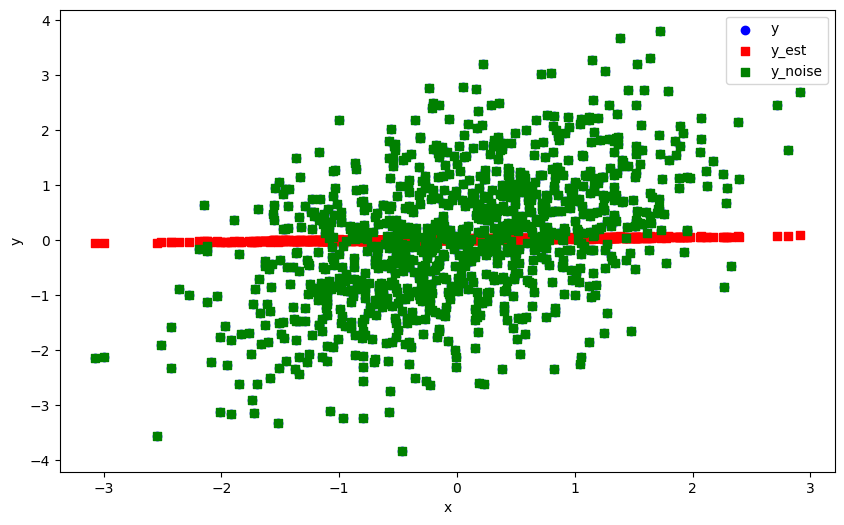

The programm is closed


In [20]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

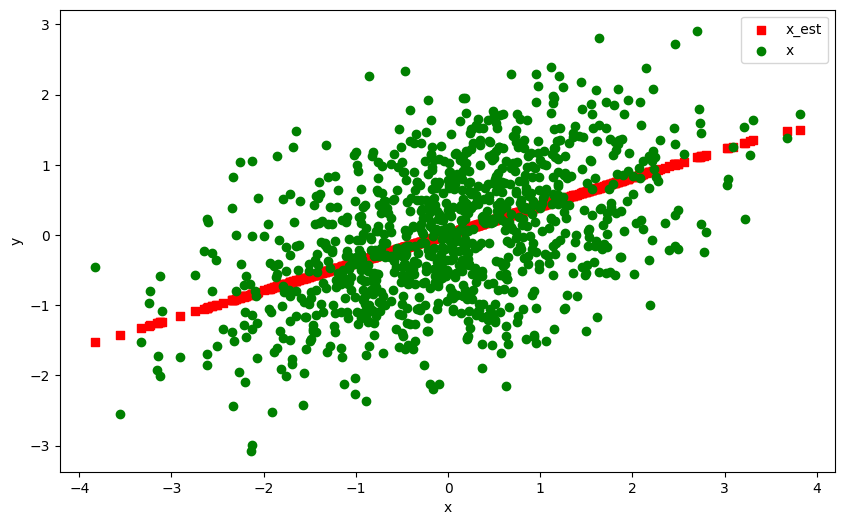

The programm is closed


In [21]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

### freeze MLP parameters

In [7]:
# eq_model = nonlinear.DagmaMLP(
#     dims=[d, 10, 1], bias=True, dtype=torch.double)
# model = nonlinear.DagmaNonlinear(
#     eq_model, dtype=torch.double, use_mse_loss=True)

# W_est_dagma = model.fit(X, lambda1=2e-2, lambda2=0.005,
#                         T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

# # Use DAGMA weights as initial weights for DAGMA-DCE
# fc1_weight = eq_model.fc1.weight
# fc1_bias = eq_model.fc1.bias
# fc2_weight = eq_model.fc2[0].weight
# fc2_bias = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
# eq_model.fc1.weight = fc1_weight
# eq_model.fc1.bias = fc1_bias
# eq_model.fc2[0].weight = fc2_weight
# eq_model.fc2[0].bias = fc2_bias

W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  1%|          | 164/29000 [00:00<01:08, 421.90it/s]

Sigma:  tensor([[0.9609, 0.0195],
        [0.0195, 1.0409]], grad_fn=<MmBackward0>)
obj:  tensor(2.4352, grad_fn=<AddBackward0>)
mle loss:  tensor(2.4338, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


  1%|          | 252/29000 [00:00<01:07, 427.09it/s]

Sigma:  tensor([[0.9239, 0.0380],
        [0.0380, 1.0825]], grad_fn=<MmBackward0>)
obj:  tensor(2.3343, grad_fn=<AddBackward0>)
mle loss:  tensor(2.3312, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


  1%|▏         | 385/29000 [00:00<01:06, 430.92it/s]

Sigma:  tensor([[0.8899, 0.0552],
        [0.0552, 1.1226]], grad_fn=<MmBackward0>)
obj:  tensor(2.2458, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2407, grad_fn=<AddBackward0>)
h_val:  tensor(0.0014, grad_fn=<AddBackward0>)


  1%|▏         | 429/29000 [00:01<01:06, 426.56it/s]

Sigma:  tensor([[0.8594, 0.0711],
        [0.0711, 1.1592]], grad_fn=<MmBackward0>)
obj:  tensor(2.1687, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1614, grad_fn=<AddBackward0>)
h_val:  tensor(0.0025, grad_fn=<AddBackward0>)


  2%|▏         | 561/29000 [00:01<01:22, 344.89it/s]

Sigma:  tensor([[0.8326, 0.0858],
        [0.0858, 1.1904]], grad_fn=<MmBackward0>)
obj:  tensor(2.1012, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0913, grad_fn=<AddBackward0>)
h_val:  tensor(0.0039, grad_fn=<AddBackward0>)


  2%|▏         | 646/29000 [00:01<01:14, 382.50it/s]

Sigma:  tensor([[0.8093, 0.0992],
        [0.0992, 1.2150]], grad_fn=<MmBackward0>)
obj:  tensor(2.0413, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0288, grad_fn=<AddBackward0>)
h_val:  tensor(0.0054, grad_fn=<AddBackward0>)


  3%|▎         | 783/29000 [00:02<01:07, 420.90it/s]

Sigma:  tensor([[0.7887, 0.1116],
        [0.1116, 1.2319]], grad_fn=<MmBackward0>)
obj:  tensor(1.9873, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9720, grad_fn=<AddBackward0>)
h_val:  tensor(0.0073, grad_fn=<AddBackward0>)


  3%|▎         | 870/29000 [00:02<01:08, 412.16it/s]

Sigma:  tensor([[0.7700, 0.1229],
        [0.1229, 1.2410]], grad_fn=<MmBackward0>)
obj:  tensor(1.9378, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9194, grad_fn=<AddBackward0>)
h_val:  tensor(0.0093, grad_fn=<AddBackward0>)


  3%|▎         | 961/29000 [00:02<01:04, 431.47it/s]

Sigma:  tensor([[0.7526, 0.1332],
        [0.1332, 1.2425]], grad_fn=<MmBackward0>)
obj:  tensor(1.8916, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8701, grad_fn=<AddBackward0>)
h_val:  tensor(0.0115, grad_fn=<AddBackward0>)


  4%|▎         | 1050/29000 [00:02<01:04, 430.36it/s]

Sigma:  tensor([[0.7363, 0.1426],
        [0.1426, 1.2372]], grad_fn=<MmBackward0>)
obj:  tensor(1.8480, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8232, grad_fn=<AddBackward0>)
h_val:  tensor(0.0139, grad_fn=<AddBackward0>)


  4%|▍         | 1183/29000 [00:02<01:04, 430.97it/s]

Sigma:  tensor([[0.7211, 0.1511],
        [0.1511, 1.2261]], grad_fn=<MmBackward0>)
obj:  tensor(1.8065, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7782, grad_fn=<AddBackward0>)
h_val:  tensor(0.0165, grad_fn=<AddBackward0>)


  4%|▍         | 1270/29000 [00:03<01:04, 426.99it/s]

Sigma:  tensor([[0.7069, 0.1589],
        [0.1589, 1.2106]], grad_fn=<MmBackward0>)
obj:  tensor(1.7668, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7348, grad_fn=<AddBackward0>)
h_val:  tensor(0.0193, grad_fn=<AddBackward0>)


  5%|▍         | 1359/29000 [00:03<01:03, 436.92it/s]

Sigma:  tensor([[0.6938, 0.1658],
        [0.1658, 1.1919]], grad_fn=<MmBackward0>)
obj:  tensor(1.7286, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6929, grad_fn=<AddBackward0>)
h_val:  tensor(0.0222, grad_fn=<AddBackward0>)


  5%|▍         | 1449/29000 [00:03<01:02, 438.90it/s]

Sigma:  tensor([[0.6815, 0.1719],
        [0.1719, 1.1711]], grad_fn=<MmBackward0>)
obj:  tensor(1.6920, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6524, grad_fn=<AddBackward0>)
h_val:  tensor(0.0253, grad_fn=<AddBackward0>)


  5%|▌         | 1581/29000 [00:03<01:03, 428.48it/s]

Sigma:  tensor([[0.6701, 0.1772],
        [0.1772, 1.1491]], grad_fn=<MmBackward0>)
obj:  tensor(1.6567, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6132, grad_fn=<AddBackward0>)
h_val:  tensor(0.0286, grad_fn=<AddBackward0>)


  6%|▌         | 1667/29000 [00:04<01:04, 424.62it/s]

Sigma:  tensor([[0.6594, 0.1818],
        [0.1818, 1.1266]], grad_fn=<MmBackward0>)
obj:  tensor(1.6228, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5752, grad_fn=<AddBackward0>)
h_val:  tensor(0.0320, grad_fn=<AddBackward0>)


  6%|▌         | 1755/29000 [00:04<01:03, 431.38it/s]

Sigma:  tensor([[0.6493, 0.1855],
        [0.1855, 1.1040]], grad_fn=<MmBackward0>)
obj:  tensor(1.5902, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5383, grad_fn=<AddBackward0>)
h_val:  tensor(0.0356, grad_fn=<AddBackward0>)


  6%|▋         | 1846/29000 [00:04<01:01, 440.73it/s]

Sigma:  tensor([[0.6397, 0.1883],
        [0.1883, 1.0817]], grad_fn=<MmBackward0>)
obj:  tensor(1.5586, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5025, grad_fn=<AddBackward0>)
h_val:  tensor(0.0393, grad_fn=<AddBackward0>)


  7%|▋         | 1982/29000 [00:04<01:01, 442.52it/s]

Sigma:  tensor([[0.6306, 0.1903],
        [0.1903, 1.0599]], grad_fn=<MmBackward0>)
obj:  tensor(1.5281, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4675, grad_fn=<AddBackward0>)
h_val:  tensor(0.0432, grad_fn=<AddBackward0>)


  7%|▋         | 2072/29000 [00:04<01:00, 442.25it/s]

Sigma:  tensor([[0.6218, 0.1915],
        [0.1915, 1.0386]], grad_fn=<MmBackward0>)
obj:  tensor(1.4985, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4333, grad_fn=<AddBackward0>)
h_val:  tensor(0.0472, grad_fn=<AddBackward0>)


  7%|▋         | 2164/29000 [00:05<01:00, 445.52it/s]

Sigma:  tensor([[0.6132, 0.1920],
        [0.1920, 1.0179]], grad_fn=<MmBackward0>)
obj:  tensor(1.4697, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3999, grad_fn=<AddBackward0>)
h_val:  tensor(0.0513, grad_fn=<AddBackward0>)


  8%|▊         | 2255/29000 [00:05<01:01, 434.10it/s]

Sigma:  tensor([[0.6049, 0.1917],
        [0.1917, 0.9977]], grad_fn=<MmBackward0>)
obj:  tensor(1.4415, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3670, grad_fn=<AddBackward0>)
h_val:  tensor(0.0556, grad_fn=<AddBackward0>)


  8%|▊         | 2386/29000 [00:05<01:02, 426.98it/s]

Sigma:  tensor([[0.5967, 0.1907],
        [0.1907, 0.9780]], grad_fn=<MmBackward0>)
obj:  tensor(1.4140, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3346, grad_fn=<AddBackward0>)
h_val:  tensor(0.0600, grad_fn=<AddBackward0>)


  8%|▊         | 2429/29000 [00:05<01:03, 415.31it/s]

Sigma:  tensor([[0.5886, 0.1892],
        [0.1892, 0.9588]], grad_fn=<MmBackward0>)
obj:  tensor(1.3870, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3026, grad_fn=<AddBackward0>)
h_val:  tensor(0.0646, grad_fn=<AddBackward0>)


  9%|▉         | 2556/29000 [00:06<01:06, 395.38it/s]

Sigma:  tensor([[0.5806, 0.1873],
        [0.1873, 0.9401]], grad_fn=<MmBackward0>)
obj:  tensor(1.3605, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2711, grad_fn=<AddBackward0>)
h_val:  tensor(0.0692, grad_fn=<AddBackward0>)


  9%|▉         | 2644/29000 [00:06<01:04, 411.35it/s]

Sigma:  tensor([[0.5728, 0.1850],
        [0.1850, 0.9218]], grad_fn=<MmBackward0>)
obj:  tensor(1.3344, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2399, grad_fn=<AddBackward0>)
h_val:  tensor(0.0741, grad_fn=<AddBackward0>)


 10%|▉         | 2781/29000 [00:06<00:59, 439.56it/s]

Sigma:  tensor([[0.5651, 0.1826],
        [0.1826, 0.9039]], grad_fn=<MmBackward0>)
obj:  tensor(1.3088, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2090, grad_fn=<AddBackward0>)
h_val:  tensor(0.0790, grad_fn=<AddBackward0>)


 10%|▉         | 2877/29000 [00:06<01:02, 417.45it/s]

Sigma:  tensor([[0.5575, 0.1800],
        [0.1800, 0.8866]], grad_fn=<MmBackward0>)
obj:  tensor(1.2837, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1784, grad_fn=<AddBackward0>)
h_val:  tensor(0.0841, grad_fn=<AddBackward0>)


 10%|█         | 2960/29000 [00:07<01:07, 387.60it/s]

Sigma:  tensor([[0.5501, 0.1776],
        [0.1776, 0.8697]], grad_fn=<MmBackward0>)
obj:  tensor(1.2590, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1482, grad_fn=<AddBackward0>)
h_val:  tensor(0.0893, grad_fn=<AddBackward0>)


 10%|█         | 3044/29000 [00:07<01:04, 400.95it/s]

Sigma:  tensor([[0.5428, 0.1753],
        [0.1753, 0.8534]], grad_fn=<MmBackward0>)
obj:  tensor(1.2347, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1183, grad_fn=<AddBackward0>)
h_val:  tensor(0.0947, grad_fn=<AddBackward0>)


 11%|█         | 3183/29000 [00:07<01:00, 426.79it/s]

Sigma:  tensor([[0.5358, 0.1733],
        [0.1733, 0.8377]], grad_fn=<MmBackward0>)
obj:  tensor(1.2108, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0887, grad_fn=<AddBackward0>)
h_val:  tensor(0.1002, grad_fn=<AddBackward0>)


 11%|█▏        | 3271/29000 [00:07<01:00, 427.83it/s]

Sigma:  tensor([[0.5289, 0.1717],
        [0.1717, 0.8226]], grad_fn=<MmBackward0>)
obj:  tensor(1.1873, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0593, grad_fn=<AddBackward0>)
h_val:  tensor(0.1058, grad_fn=<AddBackward0>)


 12%|█▏        | 3357/29000 [00:08<01:00, 421.42it/s]

Sigma:  tensor([[0.5223, 0.1705],
        [0.1705, 0.8082]], grad_fn=<MmBackward0>)
obj:  tensor(1.1642, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0303, grad_fn=<AddBackward0>)
h_val:  tensor(0.1115, grad_fn=<AddBackward0>)


 12%|█▏        | 3490/29000 [00:08<00:58, 435.68it/s]

Sigma:  tensor([[0.5159, 0.1697],
        [0.1697, 0.7944]], grad_fn=<MmBackward0>)
obj:  tensor(1.1415, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0015, grad_fn=<AddBackward0>)
h_val:  tensor(0.1174, grad_fn=<AddBackward0>)


 12%|█▏        | 3581/29000 [00:08<00:57, 445.65it/s]

Sigma:  tensor([[0.5097, 0.1695],
        [0.1695, 0.7814]], grad_fn=<MmBackward0>)
obj:  tensor(1.1192, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9729, grad_fn=<AddBackward0>)
h_val:  tensor(0.1234, grad_fn=<AddBackward0>)


 13%|█▎        | 3673/29000 [00:08<00:56, 451.74it/s]

Sigma:  tensor([[0.5037, 0.1698],
        [0.1698, 0.7689]], grad_fn=<MmBackward0>)
obj:  tensor(1.0971, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9446, grad_fn=<AddBackward0>)
h_val:  tensor(0.1296, grad_fn=<AddBackward0>)


 13%|█▎        | 3765/29000 [00:09<00:55, 451.22it/s]

Sigma:  tensor([[0.4979, 0.1707],
        [0.1707, 0.7572]], grad_fn=<MmBackward0>)
obj:  tensor(1.0754, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9163, grad_fn=<AddBackward0>)
h_val:  tensor(0.1359, grad_fn=<AddBackward0>)


 13%|█▎        | 3860/29000 [00:09<00:54, 459.58it/s]

Sigma:  tensor([[0.4924, 0.1722],
        [0.1722, 0.7460]], grad_fn=<MmBackward0>)
obj:  tensor(1.0539, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8883, grad_fn=<AddBackward0>)
h_val:  tensor(0.1424, grad_fn=<AddBackward0>)


 14%|█▎        | 3953/29000 [00:09<00:54, 459.10it/s]

Sigma:  tensor([[0.4871, 0.1744],
        [0.1744, 0.7356]], grad_fn=<MmBackward0>)
obj:  tensor(1.0326, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8602, grad_fn=<AddBackward0>)
h_val:  tensor(0.1490, grad_fn=<AddBackward0>)


 14%|█▍        | 4049/29000 [00:09<00:54, 459.03it/s]

Sigma:  tensor([[0.4820, 0.1772],
        [0.1772, 0.7257]], grad_fn=<MmBackward0>)
obj:  tensor(1.0114, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8322, grad_fn=<AddBackward0>)
h_val:  tensor(0.1557, grad_fn=<AddBackward0>)


 14%|█▍        | 4192/29000 [00:09<00:53, 462.60it/s]

Sigma:  tensor([[0.4771, 0.1807],
        [0.1807, 0.7165]], grad_fn=<MmBackward0>)
obj:  tensor(0.9903, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8042, grad_fn=<AddBackward0>)
h_val:  tensor(0.1627, grad_fn=<AddBackward0>)


 15%|█▍        | 4285/29000 [00:10<00:54, 456.22it/s]

Sigma:  tensor([[0.4726, 0.1849],
        [0.1849, 0.7079]], grad_fn=<MmBackward0>)
obj:  tensor(0.9692, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7760, grad_fn=<AddBackward0>)
h_val:  tensor(0.1698, grad_fn=<AddBackward0>)


 15%|█▌        | 4377/29000 [00:10<00:54, 448.46it/s]

Sigma:  tensor([[0.4682, 0.1899],
        [0.1899, 0.6999]], grad_fn=<MmBackward0>)
obj:  tensor(0.9481, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7476, grad_fn=<AddBackward0>)
h_val:  tensor(0.1771, grad_fn=<AddBackward0>)


 15%|█▌        | 4467/29000 [00:10<00:55, 440.98it/s]

Sigma:  tensor([[0.4642, 0.1956],
        [0.1956, 0.6925]], grad_fn=<MmBackward0>)
obj:  tensor(0.9269, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7189, grad_fn=<AddBackward0>)
h_val:  tensor(0.1846, grad_fn=<AddBackward0>)


 16%|█▌        | 4561/29000 [00:10<00:54, 452.27it/s]

Sigma:  tensor([[0.4605, 0.2021],
        [0.2021, 0.6858]], grad_fn=<MmBackward0>)
obj:  tensor(0.9054, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6899, grad_fn=<AddBackward0>)
h_val:  tensor(0.1923, grad_fn=<AddBackward0>)


 16%|█▌        | 4655/29000 [00:10<00:52, 459.38it/s]

Sigma:  tensor([[0.4571, 0.2093],
        [0.2093, 0.6796]], grad_fn=<MmBackward0>)
obj:  tensor(0.8837, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6604, grad_fn=<AddBackward0>)
h_val:  tensor(0.2001, grad_fn=<AddBackward0>)


 16%|█▋        | 4749/29000 [00:11<00:53, 456.72it/s]

Sigma:  tensor([[0.4541, 0.2173],
        [0.2173, 0.6741]], grad_fn=<MmBackward0>)
obj:  tensor(0.8615, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6304, grad_fn=<AddBackward0>)
h_val:  tensor(0.2082, grad_fn=<AddBackward0>)


 17%|█▋        | 4891/29000 [00:11<00:51, 465.77it/s]

Sigma:  tensor([[0.4514, 0.2260],
        [0.2260, 0.6692]], grad_fn=<MmBackward0>)
obj:  tensor(0.8390, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5998, grad_fn=<AddBackward0>)
h_val:  tensor(0.2164, grad_fn=<AddBackward0>)


 17%|█▋        | 4985/29000 [00:11<00:52, 460.68it/s]

Sigma:  tensor([[0.4492, 0.2353],
        [0.2353, 0.6650]], grad_fn=<MmBackward0>)
obj:  tensor(0.8163, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5686, grad_fn=<AddBackward0>)
h_val:  tensor(0.2248, grad_fn=<AddBackward0>)


 18%|█▊        | 5080/29000 [00:11<00:51, 462.93it/s]

Sigma:  tensor([[0.4476, 0.2452],
        [0.2452, 0.6612]], grad_fn=<MmBackward0>)
obj:  tensor(0.7938, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5371, grad_fn=<AddBackward0>)
h_val:  tensor(0.2333, grad_fn=<AddBackward0>)


 18%|█▊        | 5173/29000 [00:12<00:53, 441.67it/s]

Sigma:  tensor([[0.4465, 0.2553],
        [0.2553, 0.6578]], grad_fn=<MmBackward0>)
obj:  tensor(0.7709, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5052, grad_fn=<AddBackward0>)
h_val:  tensor(0.2420, grad_fn=<AddBackward0>)


 18%|█▊        | 5264/29000 [00:12<00:54, 437.74it/s]

Sigma:  tensor([[0.4455, 0.2653],
        [0.2653, 0.6546]], grad_fn=<MmBackward0>)
obj:  tensor(0.7478, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4726, grad_fn=<AddBackward0>)
h_val:  tensor(0.2508, grad_fn=<AddBackward0>)


 18%|█▊        | 5354/29000 [00:12<00:54, 436.40it/s]

Sigma:  tensor([[0.4445, 0.2754],
        [0.2754, 0.6519]], grad_fn=<MmBackward0>)
obj:  tensor(0.7247, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4397, grad_fn=<AddBackward0>)
h_val:  tensor(0.2597, grad_fn=<AddBackward0>)


 19%|█▉        | 5492/29000 [00:12<00:51, 452.11it/s]

Sigma:  tensor([[0.4437, 0.2854],
        [0.2854, 0.6498]], grad_fn=<MmBackward0>)
obj:  tensor(0.7012, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4061, grad_fn=<AddBackward0>)
h_val:  tensor(0.2687, grad_fn=<AddBackward0>)


 19%|█▉        | 5584/29000 [00:13<00:52, 449.04it/s]

Sigma:  tensor([[0.4431, 0.2956],
        [0.2956, 0.6484]], grad_fn=<MmBackward0>)
obj:  tensor(0.6771, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3718, grad_fn=<AddBackward0>)
h_val:  tensor(0.2779, grad_fn=<AddBackward0>)


 20%|█▉        | 5673/29000 [00:13<00:55, 419.97it/s]

Sigma:  tensor([[0.4429, 0.3061],
        [0.3061, 0.6475]], grad_fn=<MmBackward0>)
obj:  tensor(0.6525, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3368, grad_fn=<AddBackward0>)
h_val:  tensor(0.2872, grad_fn=<AddBackward0>)


 20%|█▉        | 5757/29000 [00:13<00:57, 404.01it/s]

Sigma:  tensor([[0.4431, 0.3167],
        [0.3167, 0.6471]], grad_fn=<MmBackward0>)
obj:  tensor(0.6273, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3011, grad_fn=<AddBackward0>)
h_val:  tensor(0.2967, grad_fn=<AddBackward0>)


 20%|██        | 5877/29000 [00:13<00:59, 387.56it/s]

Sigma:  tensor([[0.4437, 0.3275],
        [0.3275, 0.6471]], grad_fn=<MmBackward0>)
obj:  tensor(0.6016, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2648, grad_fn=<AddBackward0>)
h_val:  tensor(0.3064, grad_fn=<AddBackward0>)


 21%|██        | 5949/29000 [00:14<01:30, 255.06it/s]

Sigma:  tensor([[0.4447, 0.3383],
        [0.3383, 0.6474]], grad_fn=<MmBackward0>)
obj:  tensor(0.5754, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2279, grad_fn=<AddBackward0>)
h_val:  tensor(0.3161, grad_fn=<AddBackward0>)


 21%|██        | 6086/29000 [00:14<01:01, 370.20it/s]

Sigma:  tensor([[0.4459, 0.3491],
        [0.3491, 0.6481]], grad_fn=<MmBackward0>)
obj:  tensor(0.5489, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1905, grad_fn=<AddBackward0>)
h_val:  tensor(0.3260, grad_fn=<AddBackward0>)


 21%|██▏       | 6177/29000 [00:14<00:55, 407.96it/s]

Sigma:  tensor([[0.4473, 0.3597],
        [0.3597, 0.6490]], grad_fn=<MmBackward0>)
obj:  tensor(0.5220, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1526, grad_fn=<AddBackward0>)
h_val:  tensor(0.3359, grad_fn=<AddBackward0>)


 22%|██▏       | 6266/29000 [00:14<00:53, 423.93it/s]

Sigma:  tensor([[0.4488, 0.3700],
        [0.3700, 0.6501]], grad_fn=<MmBackward0>)
obj:  tensor(0.4948, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1144, grad_fn=<AddBackward0>)
h_val:  tensor(0.3460, grad_fn=<AddBackward0>)


 22%|██▏       | 6357/29000 [00:15<00:51, 437.52it/s]

Sigma:  tensor([[0.4505, 0.3800],
        [0.3800, 0.6513]], grad_fn=<MmBackward0>)
obj:  tensor(0.4675, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0759, grad_fn=<AddBackward0>)
h_val:  tensor(0.3562, grad_fn=<AddBackward0>)


 22%|██▏       | 6448/29000 [00:15<00:50, 442.91it/s]

Sigma:  tensor([[0.4522, 0.3897],
        [0.3897, 0.6526]], grad_fn=<MmBackward0>)
obj:  tensor(0.4400, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0372, grad_fn=<AddBackward0>)
h_val:  tensor(0.3665, grad_fn=<AddBackward0>)


 23%|██▎       | 6589/29000 [00:15<00:49, 457.20it/s]

Sigma:  tensor([[0.4539, 0.3990],
        [0.3990, 0.6540]], grad_fn=<MmBackward0>)
obj:  tensor(0.4125, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0015, grad_fn=<AddBackward0>)
h_val:  tensor(0.3768, grad_fn=<AddBackward0>)


 23%|██▎       | 6681/29000 [00:15<00:49, 454.23it/s]

Sigma:  tensor([[0.4557, 0.4078],
        [0.4078, 0.6554]], grad_fn=<MmBackward0>)
obj:  tensor(0.3850, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0403, grad_fn=<AddBackward0>)
h_val:  tensor(0.3873, grad_fn=<AddBackward0>)


 23%|██▎       | 6772/29000 [00:16<00:51, 428.85it/s]

Sigma:  tensor([[0.4573, 0.4163],
        [0.4163, 0.6568]], grad_fn=<MmBackward0>)
obj:  tensor(0.3577, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0790, grad_fn=<AddBackward0>)
h_val:  tensor(0.3978, grad_fn=<AddBackward0>)


 24%|██▎       | 6862/29000 [00:16<00:51, 431.83it/s]

Sigma:  tensor([[0.4589, 0.4242],
        [0.4242, 0.6582]], grad_fn=<MmBackward0>)
obj:  tensor(0.3306, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1175, grad_fn=<AddBackward0>)
h_val:  tensor(0.4083, grad_fn=<AddBackward0>)


 24%|██▍       | 6955/29000 [00:16<00:49, 445.56it/s]

Sigma:  tensor([[0.4604, 0.4318],
        [0.4318, 0.6595]], grad_fn=<MmBackward0>)
obj:  tensor(0.3037, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1557, grad_fn=<AddBackward0>)
h_val:  tensor(0.4189, grad_fn=<AddBackward0>)


 25%|██▍       | 7132/29000 [00:16<01:00, 361.12it/s]

Sigma:  tensor([[0.4457, 0.4199],
        [0.4199, 0.6339]], grad_fn=<MmBackward0>)
obj:  tensor(0.4049, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1694, grad_fn=<AddBackward0>)
h_val:  tensor(0.4177, grad_fn=<AddBackward0>)


 25%|██▌       | 7260/29000 [00:17<00:53, 405.70it/s]

Sigma:  tensor([[0.4302, 0.4005],
        [0.4005, 0.6085]], grad_fn=<MmBackward0>)
obj:  tensor(0.3947, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1303, grad_fn=<AddBackward0>)
h_val:  tensor(0.4037, grad_fn=<AddBackward0>)


 25%|██▌       | 7345/29000 [00:17<00:53, 407.20it/s]

Sigma:  tensor([[0.4191, 0.3848],
        [0.3848, 0.5926]], grad_fn=<MmBackward0>)
obj:  tensor(0.3853, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0873, grad_fn=<AddBackward0>)
h_val:  tensor(0.3900, grad_fn=<AddBackward0>)


 26%|██▌       | 7484/29000 [00:17<00:49, 432.11it/s]

Sigma:  tensor([[0.4140, 0.3748],
        [0.3748, 0.5861]], grad_fn=<MmBackward0>)
obj:  tensor(0.3765, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0447, grad_fn=<AddBackward0>)
h_val:  tensor(0.3771, grad_fn=<AddBackward0>)


 26%|██▌       | 7575/29000 [00:17<00:48, 441.77it/s]

Sigma:  tensor([[0.4145, 0.3708],
        [0.3708, 0.5875]], grad_fn=<MmBackward0>)
obj:  tensor(0.3682, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.0045, grad_fn=<AddBackward0>)
h_val:  tensor(0.3647, grad_fn=<AddBackward0>)


 26%|██▋       | 7665/29000 [00:18<00:49, 433.05it/s]

Sigma:  tensor([[0.4182, 0.3717],
        [0.3717, 0.5953]], grad_fn=<MmBackward0>)
obj:  tensor(0.3601, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0330, grad_fn=<AddBackward0>)
h_val:  tensor(0.3529, grad_fn=<AddBackward0>)


 27%|██▋       | 7751/29000 [00:18<00:52, 406.75it/s]

Sigma:  tensor([[0.4234, 0.3750],
        [0.3750, 0.6063]], grad_fn=<MmBackward0>)
obj:  tensor(0.3522, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0688, grad_fn=<AddBackward0>)
h_val:  tensor(0.3415, grad_fn=<AddBackward0>)


 27%|██▋       | 7889/29000 [00:18<00:47, 442.24it/s]

Sigma:  tensor([[0.4289, 0.3788],
        [0.3788, 0.6180]], grad_fn=<MmBackward0>)
obj:  tensor(0.3445, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1045, grad_fn=<AddBackward0>)
h_val:  tensor(0.3304, grad_fn=<AddBackward0>)


 28%|██▊       | 7980/29000 [00:18<00:47, 445.83it/s]

Sigma:  tensor([[0.4341, 0.3816],
        [0.3816, 0.6291]], grad_fn=<MmBackward0>)
obj:  tensor(0.3371, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1405, grad_fn=<AddBackward0>)
h_val:  tensor(0.3194, grad_fn=<AddBackward0>)


 28%|██▊       | 8072/29000 [00:19<00:46, 446.54it/s]

Sigma:  tensor([[0.4386, 0.3834],
        [0.3834, 0.6394]], grad_fn=<MmBackward0>)
obj:  tensor(0.3298, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1773, grad_fn=<AddBackward0>)
h_val:  tensor(0.3085, grad_fn=<AddBackward0>)


 28%|██▊       | 8163/29000 [00:19<00:47, 438.96it/s]

Sigma:  tensor([[0.4426, 0.3844],
        [0.3844, 0.6495]], grad_fn=<MmBackward0>)
obj:  tensor(0.3227, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2145, grad_fn=<AddBackward0>)
h_val:  tensor(0.2978, grad_fn=<AddBackward0>)


 28%|██▊       | 8253/29000 [00:19<00:47, 439.93it/s]

Sigma:  tensor([[0.4467, 0.3852],
        [0.3852, 0.6599]], grad_fn=<MmBackward0>)
obj:  tensor(0.3159, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2521, grad_fn=<AddBackward0>)
h_val:  tensor(0.2872, grad_fn=<AddBackward0>)


 29%|██▉       | 8344/29000 [00:19<00:46, 440.47it/s]

Sigma:  tensor([[0.4509, 0.3860],
        [0.3860, 0.6707]], grad_fn=<MmBackward0>)
obj:  tensor(0.3092, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2899, grad_fn=<AddBackward0>)
h_val:  tensor(0.2768, grad_fn=<AddBackward0>)


 29%|██▉       | 8481/29000 [00:20<00:45, 446.96it/s]

Sigma:  tensor([[0.4553, 0.3869],
        [0.3869, 0.6822]], grad_fn=<MmBackward0>)
obj:  tensor(0.3027, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3278, grad_fn=<AddBackward0>)
h_val:  tensor(0.2666, grad_fn=<AddBackward0>)


 30%|██▉       | 8571/29000 [00:20<00:46, 442.23it/s]

Sigma:  tensor([[0.4597, 0.3878],
        [0.3878, 0.6942]], grad_fn=<MmBackward0>)
obj:  tensor(0.2964, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3659, grad_fn=<AddBackward0>)
h_val:  tensor(0.2566, grad_fn=<AddBackward0>)


 30%|██▉       | 8661/29000 [00:20<00:46, 439.63it/s]

Sigma:  tensor([[0.4642, 0.3885],
        [0.3885, 0.7065]], grad_fn=<MmBackward0>)
obj:  tensor(0.2903, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4040, grad_fn=<AddBackward0>)
h_val:  tensor(0.2467, grad_fn=<AddBackward0>)


 30%|███       | 8751/29000 [00:20<00:45, 440.63it/s]

Sigma:  tensor([[0.4688, 0.3890],
        [0.3890, 0.7190]], grad_fn=<MmBackward0>)
obj:  tensor(0.2844, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4421, grad_fn=<AddBackward0>)
h_val:  tensor(0.2371, grad_fn=<AddBackward0>)


 31%|███       | 8846/29000 [00:20<00:44, 448.18it/s]

Sigma:  tensor([[0.4734, 0.3894],
        [0.3894, 0.7318]], grad_fn=<MmBackward0>)
obj:  tensor(0.2787, grad_fn=<AddBackward0>)
mle loss:  tensor(0.4800, grad_fn=<AddBackward0>)
h_val:  tensor(0.2277, grad_fn=<AddBackward0>)


 31%|███       | 8987/29000 [00:21<00:44, 453.71it/s]

Sigma:  tensor([[0.4780, 0.3895],
        [0.3895, 0.7447]], grad_fn=<MmBackward0>)
obj:  tensor(0.2732, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5179, grad_fn=<AddBackward0>)
h_val:  tensor(0.2185, grad_fn=<AddBackward0>)


 31%|███▏      | 9079/29000 [00:21<00:44, 451.11it/s]

Sigma:  tensor([[0.4827, 0.3896],
        [0.3896, 0.7578]], grad_fn=<MmBackward0>)
obj:  tensor(0.2678, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5555, grad_fn=<AddBackward0>)
h_val:  tensor(0.2094, grad_fn=<AddBackward0>)


 32%|███▏      | 9172/29000 [00:21<00:43, 454.08it/s]

Sigma:  tensor([[0.4875, 0.3895],
        [0.3895, 0.7711]], grad_fn=<MmBackward0>)
obj:  tensor(0.2627, grad_fn=<AddBackward0>)
mle loss:  tensor(0.5928, grad_fn=<AddBackward0>)
h_val:  tensor(0.2007, grad_fn=<AddBackward0>)


 32%|███▏      | 9264/29000 [00:21<00:43, 450.08it/s]

Sigma:  tensor([[0.4922, 0.3892],
        [0.3892, 0.7843]], grad_fn=<MmBackward0>)
obj:  tensor(0.2578, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6299, grad_fn=<AddBackward0>)
h_val:  tensor(0.1921, grad_fn=<AddBackward0>)


 32%|███▏      | 9355/29000 [00:22<00:44, 437.15it/s]

Sigma:  tensor([[0.4971, 0.3888],
        [0.3888, 0.7975]], grad_fn=<MmBackward0>)
obj:  tensor(0.2530, grad_fn=<AddBackward0>)
mle loss:  tensor(0.6665, grad_fn=<AddBackward0>)
h_val:  tensor(0.1838, grad_fn=<AddBackward0>)


 33%|███▎      | 9445/29000 [00:22<00:44, 441.00it/s]

Sigma:  tensor([[0.5020, 0.3882],
        [0.3882, 0.8107]], grad_fn=<MmBackward0>)
obj:  tensor(0.2484, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7027, grad_fn=<AddBackward0>)
h_val:  tensor(0.1757, grad_fn=<AddBackward0>)


 33%|███▎      | 9583/29000 [00:22<00:43, 449.79it/s]

Sigma:  tensor([[0.5069, 0.3874],
        [0.3874, 0.8237]], grad_fn=<MmBackward0>)
obj:  tensor(0.2441, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7383, grad_fn=<AddBackward0>)
h_val:  tensor(0.1678, grad_fn=<AddBackward0>)


 33%|███▎      | 9674/29000 [00:22<00:43, 447.04it/s]

Sigma:  tensor([[0.5119, 0.3865],
        [0.3865, 0.8365]], grad_fn=<MmBackward0>)
obj:  tensor(0.2399, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7734, grad_fn=<AddBackward0>)
h_val:  tensor(0.1602, grad_fn=<AddBackward0>)


 34%|███▎      | 9765/29000 [00:22<00:43, 445.09it/s]

Sigma:  tensor([[0.5169, 0.3854],
        [0.3854, 0.8491]], grad_fn=<MmBackward0>)
obj:  tensor(0.2359, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8079, grad_fn=<AddBackward0>)
h_val:  tensor(0.1528, grad_fn=<AddBackward0>)


 34%|███▍      | 9857/29000 [00:23<00:42, 446.39it/s]

Sigma:  tensor([[0.5219, 0.3842],
        [0.3842, 0.8615]], grad_fn=<MmBackward0>)
obj:  tensor(0.2321, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8416, grad_fn=<AddBackward0>)
h_val:  tensor(0.1457, grad_fn=<AddBackward0>)


 34%|███▍      | 9949/29000 [00:23<00:42, 447.65it/s]

Sigma:  tensor([[0.5269, 0.3829],
        [0.3829, 0.8735]], grad_fn=<MmBackward0>)
obj:  tensor(0.2285, grad_fn=<AddBackward0>)
mle loss:  tensor(0.8747, grad_fn=<AddBackward0>)
h_val:  tensor(0.1389, grad_fn=<AddBackward0>)


 35%|███▍      | 10091/29000 [00:23<00:41, 458.64it/s]

Sigma:  tensor([[0.5320, 0.3814],
        [0.3814, 0.8852]], grad_fn=<MmBackward0>)
obj:  tensor(0.2251, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9070, grad_fn=<AddBackward0>)
h_val:  tensor(0.1323, grad_fn=<AddBackward0>)


 35%|███▌      | 10183/29000 [00:23<00:41, 452.58it/s]

Sigma:  tensor([[0.5371, 0.3799],
        [0.3799, 0.8965]], grad_fn=<MmBackward0>)
obj:  tensor(0.2218, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9384, grad_fn=<AddBackward0>)
h_val:  tensor(0.1260, grad_fn=<AddBackward0>)


 35%|███▌      | 10274/29000 [00:24<00:41, 448.22it/s]

Sigma:  tensor([[0.5422, 0.3783],
        [0.3783, 0.9074]], grad_fn=<MmBackward0>)
obj:  tensor(0.2188, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9691, grad_fn=<AddBackward0>)
h_val:  tensor(0.1200, grad_fn=<AddBackward0>)


 36%|███▌      | 10366/29000 [00:24<00:41, 449.24it/s]

Sigma:  tensor([[0.5473, 0.3767],
        [0.3767, 0.9179]], grad_fn=<MmBackward0>)
obj:  tensor(0.2159, grad_fn=<AddBackward0>)
mle loss:  tensor(0.9988, grad_fn=<AddBackward0>)
h_val:  tensor(0.1142, grad_fn=<AddBackward0>)


 36%|███▌      | 10457/29000 [00:24<00:42, 441.48it/s]

Sigma:  tensor([[0.5525, 0.3750],
        [0.3750, 0.9280]], grad_fn=<MmBackward0>)
obj:  tensor(0.2132, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0277, grad_fn=<AddBackward0>)
h_val:  tensor(0.1087, grad_fn=<AddBackward0>)


 36%|███▋      | 10548/29000 [00:24<00:41, 445.19it/s]

Sigma:  tensor([[0.5576, 0.3732],
        [0.3732, 0.9377]], grad_fn=<MmBackward0>)
obj:  tensor(0.2107, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0557, grad_fn=<AddBackward0>)
h_val:  tensor(0.1035, grad_fn=<AddBackward0>)


 37%|███▋      | 10690/29000 [00:24<00:39, 459.98it/s]

Sigma:  tensor([[0.5628, 0.3716],
        [0.3716, 0.9469]], grad_fn=<MmBackward0>)
obj:  tensor(0.2084, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0824, grad_fn=<AddBackward0>)
h_val:  tensor(0.0985, grad_fn=<AddBackward0>)


 37%|███▋      | 10784/29000 [00:25<00:40, 454.52it/s]

Sigma:  tensor([[0.5689, 0.3711],
        [0.3711, 0.9554]], grad_fn=<MmBackward0>)
obj:  tensor(0.2062, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1078, grad_fn=<AddBackward0>)
h_val:  tensor(0.0938, grad_fn=<AddBackward0>)


 38%|███▊      | 10878/29000 [00:25<00:39, 458.17it/s]

Sigma:  tensor([[0.5759, 0.3724],
        [0.3724, 0.9634]], grad_fn=<MmBackward0>)
obj:  tensor(0.2042, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1323, grad_fn=<AddBackward0>)
h_val:  tensor(0.0894, grad_fn=<AddBackward0>)


 38%|███▊      | 10971/29000 [00:25<00:39, 453.76it/s]

Sigma:  tensor([[0.5832, 0.3745],
        [0.3745, 0.9718]], grad_fn=<MmBackward0>)
obj:  tensor(0.2023, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1559, grad_fn=<AddBackward0>)
h_val:  tensor(0.0852, grad_fn=<AddBackward0>)


 38%|███▊      | 11017/29000 [00:25<00:40, 447.61it/s]

Sigma:  tensor([[0.5903, 0.3764],
        [0.3764, 0.9801]], grad_fn=<MmBackward0>)
obj:  tensor(0.2006, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1787, grad_fn=<AddBackward0>)
h_val:  tensor(0.0812, grad_fn=<AddBackward0>)


 38%|███▊      | 11155/29000 [00:26<00:49, 363.43it/s]

Sigma:  tensor([[0.5971, 0.3782],
        [0.3782, 0.9881]], grad_fn=<MmBackward0>)
obj:  tensor(0.1989, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2008, grad_fn=<AddBackward0>)
h_val:  tensor(0.0774, grad_fn=<AddBackward0>)


 39%|███▉      | 11247/29000 [00:26<00:44, 399.55it/s]

Sigma:  tensor([[0.6040, 0.3802],
        [0.3802, 0.9958]], grad_fn=<MmBackward0>)
obj:  tensor(0.1974, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2221, grad_fn=<AddBackward0>)
h_val:  tensor(0.0738, grad_fn=<AddBackward0>)


 39%|███▉      | 11381/29000 [00:26<00:41, 424.64it/s]

Sigma:  tensor([[0.6108, 0.3825],
        [0.3825, 1.0034]], grad_fn=<MmBackward0>)
obj:  tensor(0.1960, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2426, grad_fn=<AddBackward0>)
h_val:  tensor(0.0704, grad_fn=<AddBackward0>)


 40%|███▉      | 11470/29000 [00:26<00:40, 430.71it/s]

Sigma:  tensor([[0.6176, 0.3849],
        [0.3849, 1.0109]], grad_fn=<MmBackward0>)
obj:  tensor(0.1947, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2623, grad_fn=<AddBackward0>)
h_val:  tensor(0.0671, grad_fn=<AddBackward0>)


 40%|███▉      | 11559/29000 [00:27<00:40, 433.00it/s]

Sigma:  tensor([[0.6243, 0.3874],
        [0.3874, 1.0181]], grad_fn=<MmBackward0>)
obj:  tensor(0.1935, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2813, grad_fn=<AddBackward0>)
h_val:  tensor(0.0641, grad_fn=<AddBackward0>)


 40%|████      | 11651/29000 [00:27<00:39, 440.88it/s]

Sigma:  tensor([[0.6310, 0.3900],
        [0.3900, 1.0250]], grad_fn=<MmBackward0>)
obj:  tensor(0.1924, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2996, grad_fn=<AddBackward0>)
h_val:  tensor(0.0611, grad_fn=<AddBackward0>)


 41%|████      | 11792/29000 [00:27<00:37, 456.82it/s]

Sigma:  tensor([[0.6377, 0.3927],
        [0.3927, 1.0317]], grad_fn=<MmBackward0>)
obj:  tensor(0.1913, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3172, grad_fn=<AddBackward0>)
h_val:  tensor(0.0584, grad_fn=<AddBackward0>)


 41%|████      | 11884/29000 [00:27<00:37, 450.68it/s]

Sigma:  tensor([[0.6443, 0.3956],
        [0.3956, 1.0382]], grad_fn=<MmBackward0>)
obj:  tensor(0.1904, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3341, grad_fn=<AddBackward0>)
h_val:  tensor(0.0558, grad_fn=<AddBackward0>)


 41%|████▏     | 11976/29000 [00:28<00:37, 448.12it/s]

Sigma:  tensor([[0.6508, 0.3986],
        [0.3986, 1.0445]], grad_fn=<MmBackward0>)
obj:  tensor(0.1895, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3503, grad_fn=<AddBackward0>)
h_val:  tensor(0.0533, grad_fn=<AddBackward0>)


 42%|████▏     | 12066/29000 [00:28<00:38, 444.44it/s]

Sigma:  tensor([[0.6573, 0.4016],
        [0.4016, 1.0506]], grad_fn=<MmBackward0>)
obj:  tensor(0.1887, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3659, grad_fn=<AddBackward0>)
h_val:  tensor(0.0510, grad_fn=<AddBackward0>)


 42%|████▏     | 12157/29000 [00:28<00:37, 446.05it/s]

Sigma:  tensor([[0.6637, 0.4048],
        [0.4048, 1.0565]], grad_fn=<MmBackward0>)
obj:  tensor(0.1880, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3810, grad_fn=<AddBackward0>)
h_val:  tensor(0.0488, grad_fn=<AddBackward0>)


 42%|████▏     | 12247/29000 [00:28<00:37, 443.10it/s]

Sigma:  tensor([[0.6699, 0.4079],
        [0.4079, 1.0623]], grad_fn=<MmBackward0>)
obj:  tensor(0.1873, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3955, grad_fn=<AddBackward0>)
h_val:  tensor(0.0467, grad_fn=<AddBackward0>)


 43%|████▎     | 12389/29000 [00:28<00:36, 450.59it/s]

Sigma:  tensor([[0.6761, 0.4111],
        [0.4111, 1.0679]], grad_fn=<MmBackward0>)
obj:  tensor(0.1867, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4094, grad_fn=<AddBackward0>)
h_val:  tensor(0.0447, grad_fn=<AddBackward0>)


 43%|████▎     | 12481/29000 [00:29<00:36, 447.54it/s]

Sigma:  tensor([[0.6816, 0.4138],
        [0.4138, 1.0736]], grad_fn=<MmBackward0>)
obj:  tensor(0.1861, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4229, grad_fn=<AddBackward0>)
h_val:  tensor(0.0428, grad_fn=<AddBackward0>)


 43%|████▎     | 12571/29000 [00:29<00:37, 441.87it/s]

Sigma:  tensor([[0.6867, 0.4157],
        [0.4157, 1.0790]], grad_fn=<MmBackward0>)
obj:  tensor(0.1856, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4358, grad_fn=<AddBackward0>)
h_val:  tensor(0.0410, grad_fn=<AddBackward0>)


 44%|████▎     | 12663/29000 [00:29<00:36, 445.94it/s]

Sigma:  tensor([[0.6917, 0.4178],
        [0.4178, 1.0838]], grad_fn=<MmBackward0>)
obj:  tensor(0.1852, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4483, grad_fn=<AddBackward0>)
h_val:  tensor(0.0394, grad_fn=<AddBackward0>)


 44%|████▍     | 12753/29000 [00:29<00:36, 442.37it/s]

Sigma:  tensor([[0.6966, 0.4198],
        [0.4198, 1.0887]], grad_fn=<MmBackward0>)
obj:  tensor(0.1848, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4603, grad_fn=<AddBackward0>)
h_val:  tensor(0.0378, grad_fn=<AddBackward0>)


 44%|████▍     | 12842/29000 [00:30<00:38, 419.49it/s]

Sigma:  tensor([[0.7012, 0.4215],
        [0.4215, 1.0932]], grad_fn=<MmBackward0>)
obj:  tensor(0.1844, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4717, grad_fn=<AddBackward0>)
h_val:  tensor(0.0363, grad_fn=<AddBackward0>)


 45%|████▍     | 12978/29000 [00:30<00:36, 437.60it/s]

Sigma:  tensor([[0.7056, 0.4231],
        [0.4231, 1.0976]], grad_fn=<MmBackward0>)
obj:  tensor(0.1841, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4827, grad_fn=<AddBackward0>)
h_val:  tensor(0.0350, grad_fn=<AddBackward0>)


 45%|████▌     | 13066/29000 [00:30<00:37, 419.49it/s]

Sigma:  tensor([[0.7097, 0.4252],
        [0.4252, 1.1025]], grad_fn=<MmBackward0>)
obj:  tensor(0.1839, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4932, grad_fn=<AddBackward0>)
h_val:  tensor(0.0337, grad_fn=<AddBackward0>)


 45%|████▌     | 13150/29000 [00:30<00:40, 386.95it/s]

Sigma:  tensor([[0.7139, 0.4274],
        [0.4274, 1.1073]], grad_fn=<MmBackward0>)
obj:  tensor(0.1837, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5031, grad_fn=<AddBackward0>)
h_val:  tensor(0.0325, grad_fn=<AddBackward0>)


 46%|████▌     | 13269/29000 [00:31<00:40, 386.59it/s]

Sigma:  tensor([[0.7177, 0.4292],
        [0.4292, 1.1117]], grad_fn=<MmBackward0>)
obj:  tensor(0.1835, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5125, grad_fn=<AddBackward0>)
h_val:  tensor(0.0314, grad_fn=<AddBackward0>)


 46%|████▌     | 13347/29000 [00:31<00:40, 385.29it/s]

Sigma:  tensor([[0.7213, 0.4311],
        [0.4311, 1.1161]], grad_fn=<MmBackward0>)
obj:  tensor(0.1833, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5214, grad_fn=<AddBackward0>)
h_val:  tensor(0.0303, grad_fn=<AddBackward0>)


 46%|████▋     | 13469/29000 [00:31<00:39, 394.19it/s]

Sigma:  tensor([[0.7246, 0.4328],
        [0.4328, 1.1202]], grad_fn=<MmBackward0>)
obj:  tensor(0.1832, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5297, grad_fn=<AddBackward0>)
h_val:  tensor(0.0294, grad_fn=<AddBackward0>)


 47%|████▋     | 13548/29000 [00:31<00:40, 378.54it/s]

Sigma:  tensor([[0.7277, 0.4344],
        [0.4344, 1.1241]], grad_fn=<MmBackward0>)
obj:  tensor(0.1831, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5375, grad_fn=<AddBackward0>)
h_val:  tensor(0.0285, grad_fn=<AddBackward0>)


 47%|████▋     | 13662/29000 [00:32<00:41, 373.90it/s]

Sigma:  tensor([[0.7306, 0.4360],
        [0.4360, 1.1278]], grad_fn=<MmBackward0>)
obj:  tensor(0.1830, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5447, grad_fn=<AddBackward0>)
h_val:  tensor(0.0277, grad_fn=<AddBackward0>)


 48%|████▊     | 13779/29000 [00:32<00:39, 383.98it/s]

Sigma:  tensor([[0.7332, 0.4375],
        [0.4375, 1.1313]], grad_fn=<MmBackward0>)
obj:  tensor(0.1830, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5513, grad_fn=<AddBackward0>)
h_val:  tensor(0.0270, grad_fn=<AddBackward0>)


 48%|████▊     | 13857/29000 [00:32<00:39, 380.65it/s]

Sigma:  tensor([[0.7356, 0.4388],
        [0.4388, 1.1345]], grad_fn=<MmBackward0>)
obj:  tensor(0.1829, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5574, grad_fn=<AddBackward0>)
h_val:  tensor(0.0264, grad_fn=<AddBackward0>)


 48%|████▊     | 13976/29000 [00:32<00:39, 382.30it/s]

Sigma:  tensor([[0.7378, 0.4401],
        [0.4401, 1.1375]], grad_fn=<MmBackward0>)
obj:  tensor(0.1829, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5629, grad_fn=<AddBackward0>)
h_val:  tensor(0.0258, grad_fn=<AddBackward0>)


 49%|████▉     | 14183/29000 [00:33<00:36, 411.43it/s]

Sigma:  tensor([[0.7427, 0.4434],
        [0.4434, 1.1515]], grad_fn=<MmBackward0>)
obj:  tensor(0.0399, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5810, grad_fn=<AddBackward0>)
h_val:  tensor(0.0240, grad_fn=<AddBackward0>)


 49%|████▉     | 14266/29000 [00:33<00:37, 396.51it/s]

Sigma:  tensor([[0.7463, 0.4411],
        [0.4411, 1.1646]], grad_fn=<MmBackward0>)
obj:  tensor(0.0376, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6073, grad_fn=<AddBackward0>)
h_val:  tensor(0.0215, grad_fn=<AddBackward0>)


 49%|████▉     | 14345/29000 [00:33<00:38, 383.15it/s]

Sigma:  tensor([[0.7518, 0.4405],
        [0.4405, 1.1783]], grad_fn=<MmBackward0>)
obj:  tensor(0.0353, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6363, grad_fn=<AddBackward0>)
h_val:  tensor(0.0188, grad_fn=<AddBackward0>)


 50%|████▉     | 14467/29000 [00:34<00:37, 391.17it/s]

Sigma:  tensor([[0.7620, 0.4469],
        [0.4469, 1.1966]], grad_fn=<MmBackward0>)
obj:  tensor(0.0330, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6656, grad_fn=<AddBackward0>)
h_val:  tensor(0.0163, grad_fn=<AddBackward0>)


 50%|█████     | 14546/29000 [00:34<00:37, 380.68it/s]

Sigma:  tensor([[0.7748, 0.4577],
        [0.4577, 1.2178]], grad_fn=<MmBackward0>)
obj:  tensor(0.0310, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6945, grad_fn=<AddBackward0>)
h_val:  tensor(0.0140, grad_fn=<AddBackward0>)


 51%|█████     | 14666/29000 [00:34<00:36, 387.52it/s]

Sigma:  tensor([[0.7879, 0.4682],
        [0.4682, 1.2375]], grad_fn=<MmBackward0>)
obj:  tensor(0.0292, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7224, grad_fn=<AddBackward0>)
h_val:  tensor(0.0120, grad_fn=<AddBackward0>)


 51%|█████     | 14743/29000 [00:34<00:38, 372.16it/s]

Sigma:  tensor([[0.8003, 0.4777],
        [0.4777, 1.2556]], grad_fn=<MmBackward0>)
obj:  tensor(0.0277, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7491, grad_fn=<AddBackward0>)
h_val:  tensor(0.0101, grad_fn=<AddBackward0>)


 51%|█████▏    | 14866/29000 [00:35<00:36, 385.78it/s]

Sigma:  tensor([[0.8120, 0.4865],
        [0.4865, 1.2729]], grad_fn=<MmBackward0>)
obj:  tensor(0.0263, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7744, grad_fn=<AddBackward0>)
h_val:  tensor(0.0085, grad_fn=<AddBackward0>)


 52%|█████▏    | 14945/29000 [00:35<00:36, 388.83it/s]

Sigma:  tensor([[0.8226, 0.4938],
        [0.4938, 1.2888]], grad_fn=<MmBackward0>)
obj:  tensor(0.0252, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7983, grad_fn=<AddBackward0>)
h_val:  tensor(0.0072, grad_fn=<AddBackward0>)


 52%|█████▏    | 15071/29000 [00:35<00:34, 401.48it/s]

Sigma:  tensor([[0.8323, 0.4999],
        [0.4999, 1.3032]], grad_fn=<MmBackward0>)
obj:  tensor(0.0242, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8206, grad_fn=<AddBackward0>)
h_val:  tensor(0.0060, grad_fn=<AddBackward0>)


 52%|█████▏    | 15151/29000 [00:35<00:36, 384.14it/s]

Sigma:  tensor([[0.8412, 0.5055],
        [0.5055, 1.3168]], grad_fn=<MmBackward0>)
obj:  tensor(0.0234, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8413, grad_fn=<AddBackward0>)
h_val:  tensor(0.0050, grad_fn=<AddBackward0>)


 53%|█████▎    | 15269/29000 [00:36<00:35, 384.55it/s]

Sigma:  tensor([[0.8496, 0.5104],
        [0.5104, 1.3292]], grad_fn=<MmBackward0>)
obj:  tensor(0.0227, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8605, grad_fn=<AddBackward0>)
h_val:  tensor(0.0041, grad_fn=<AddBackward0>)


 53%|█████▎    | 15346/29000 [00:36<00:36, 373.76it/s]

Sigma:  tensor([[0.8575, 0.5150],
        [0.5150, 1.3406]], grad_fn=<MmBackward0>)
obj:  tensor(0.0222, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8782, grad_fn=<AddBackward0>)
h_val:  tensor(0.0034, grad_fn=<AddBackward0>)


 53%|█████▎    | 15464/29000 [00:36<00:36, 372.60it/s]

Sigma:  tensor([[0.8649, 0.5193],
        [0.5193, 1.3510]], grad_fn=<MmBackward0>)
obj:  tensor(0.0217, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8944, grad_fn=<AddBackward0>)
h_val:  tensor(0.0028, grad_fn=<AddBackward0>)


 54%|█████▎    | 15539/29000 [00:37<00:38, 347.51it/s]

Sigma:  tensor([[0.8717, 0.5232],
        [0.5232, 1.3603]], grad_fn=<MmBackward0>)
obj:  tensor(0.0214, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9092, grad_fn=<AddBackward0>)
h_val:  tensor(0.0023, grad_fn=<AddBackward0>)


 54%|█████▍    | 15646/29000 [00:37<00:38, 344.58it/s]

Sigma:  tensor([[0.8781, 0.5267],
        [0.5267, 1.3687]], grad_fn=<MmBackward0>)
obj:  tensor(0.0211, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9226, grad_fn=<AddBackward0>)
h_val:  tensor(0.0018, grad_fn=<AddBackward0>)


 54%|█████▍    | 15753/29000 [00:37<00:38, 341.69it/s]

Sigma:  tensor([[0.8840, 0.5299],
        [0.5299, 1.3762]], grad_fn=<MmBackward0>)
obj:  tensor(0.0209, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9346, grad_fn=<AddBackward0>)
h_val:  tensor(0.0015, grad_fn=<AddBackward0>)


 55%|█████▍    | 15861/29000 [00:37<00:37, 346.35it/s]

Sigma:  tensor([[0.8893, 0.5327],
        [0.5327, 1.3827]], grad_fn=<MmBackward0>)
obj:  tensor(0.0207, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9454, grad_fn=<AddBackward0>)
h_val:  tensor(0.0012, grad_fn=<AddBackward0>)


 55%|█████▌    | 15970/29000 [00:38<00:36, 353.13it/s]

Sigma:  tensor([[0.8942, 0.5352],
        [0.5352, 1.3883]], grad_fn=<MmBackward0>)
obj:  tensor(0.0206, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9549, grad_fn=<AddBackward0>)
h_val:  tensor(0.0010, grad_fn=<AddBackward0>)


 55%|█████▌    | 16042/29000 [00:38<00:36, 352.71it/s]

Sigma:  tensor([[0.8986, 0.5374],
        [0.5374, 1.3931]], grad_fn=<MmBackward0>)
obj:  tensor(0.0205, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9633, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)


 56%|█████▌    | 16159/29000 [00:38<00:35, 365.34it/s]

Sigma:  tensor([[0.9026, 0.5393],
        [0.5393, 1.3971]], grad_fn=<MmBackward0>)
obj:  tensor(0.0204, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9706, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)


 56%|█████▌    | 16286/29000 [00:39<00:31, 405.01it/s]

Sigma:  tensor([[0.9061, 0.5410],
        [0.5410, 1.4003]], grad_fn=<MmBackward0>)
obj:  tensor(0.0203, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9769, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)


 56%|█████▋    | 16369/29000 [00:39<00:31, 405.36it/s]

Sigma:  tensor([[0.9092, 0.5424],
        [0.5424, 1.4030]], grad_fn=<MmBackward0>)
obj:  tensor(0.0203, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9822, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)


 57%|█████▋    | 16410/29000 [00:39<00:30, 406.38it/s]

Sigma:  tensor([[0.9119, 0.5435],
        [0.5435, 1.4050]], grad_fn=<MmBackward0>)
obj:  tensor(0.0203, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9867, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)


 57%|█████▋    | 16565/29000 [00:40<00:38, 324.51it/s]

Sigma:  tensor([[0.9143, 0.5444],
        [0.5444, 1.4065]], grad_fn=<MmBackward0>)
obj:  tensor(0.0203, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9903, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 57%|█████▋    | 16640/29000 [00:40<00:36, 342.14it/s]

Sigma:  tensor([[0.9162, 0.5452],
        [0.5452, 1.4076]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9933, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16763/29000 [00:40<00:31, 386.61it/s]

Sigma:  tensor([[0.9178, 0.5457],
        [0.5457, 1.4084]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9956, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 58%|█████▊    | 16847/29000 [00:40<00:30, 392.96it/s]

Sigma:  tensor([[0.9191, 0.5462],
        [0.5462, 1.4088]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9975, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)


 59%|█████▊    | 16984/29000 [00:41<00:28, 428.61it/s]

Sigma:  tensor([[0.9202, 0.5465],
        [0.5465, 1.4091]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9988, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 59%|█████▉    | 17072/29000 [00:41<00:27, 428.15it/s]

Sigma:  tensor([[0.9210, 0.5467],
        [0.5467, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9999, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 59%|█████▉    | 17158/29000 [00:41<00:28, 422.21it/s]

Sigma:  tensor([[0.9216, 0.5469],
        [0.5469, 1.4093]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0006, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 59%|█████▉    | 17245/29000 [00:41<00:27, 423.22it/s]

Sigma:  tensor([[0.9221, 0.5470],
        [0.5470, 1.4093]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0011, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 60%|█████▉    | 17384/29000 [00:41<00:26, 442.51it/s]

Sigma:  tensor([[0.9224, 0.5471],
        [0.5471, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0014, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 60%|██████    | 17473/29000 [00:42<00:26, 433.02it/s]

Sigma:  tensor([[0.9226, 0.5471],
        [0.5471, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0016, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 61%|██████    | 17557/29000 [00:42<00:30, 372.85it/s]

Sigma:  tensor([[0.9227, 0.5471],
        [0.5471, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0018, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 61%|██████    | 17671/29000 [00:42<00:30, 365.88it/s]

Sigma:  tensor([[0.9228, 0.5472],
        [0.5472, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0019, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 61%|██████    | 17745/29000 [00:43<00:31, 359.03it/s]

Sigma:  tensor([[0.9229, 0.5472],
        [0.5472, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0019, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 62%|██████▏   | 17856/29000 [00:43<00:33, 336.74it/s]

Sigma:  tensor([[0.9229, 0.5472],
        [0.5472, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0020, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 62%|██████▏   | 17956/29000 [00:43<00:34, 321.10it/s]

Sigma:  tensor([[0.9229, 0.5472],
        [0.5472, 1.4092]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0020, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)


 72%|███████▏  | 21022/29000 [00:43<00:00, 8756.42it/s]

Sigma:  tensor([[0.9230, 0.5473],
        [0.5473, 1.4093]], grad_fn=<MmBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0021, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9231, 0.5501],
        [0.5501, 1.4107]], grad_fn=<MmBackward0>)
obj:  tensor(0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9990, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9239, 0.5506],
        [0.5506, 1.4109]], grad_fn=<MmBackward0>)
obj:  tensor(0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0017, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9252, 0.5506],
        [0.5506, 1.4158]], grad_fn=<MmBackward0>)
obj:  tensor(0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0060, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9269, 0.5507],
        [0.5507, 1.4162]], grad_fn=<MmBackward0>)
obj:  tensor

 76%|███████▌  | 21935/29000 [00:46<00:06, 1149.79it/s]

Sigma:  tensor([[0.9356, 0.5538],
        [0.5538, 1.4300]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0324, grad_fn=<AddBackward0>)
h_val:  tensor(1.2101e-05, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9369, 0.5548],
        [0.5548, 1.4318]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0347, grad_fn=<AddBackward0>)
h_val:  tensor(7.2459e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9380, 0.5557],
        [0.5557, 1.4332]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0363, grad_fn=<AddBackward0>)
h_val:  tensor(4.5397e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9388, 0.5564],
        [0.5564, 1.4343]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0374, grad_fn=<AddBackward0>)
h_val:  tensor(3.0957e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9393, 0.5570],
        [0.5570, 1.4350]], grad_fn=<MmBackward

 78%|███████▊  | 22585/29000 [00:47<00:08, 799.88it/s] 

Sigma:  tensor([[0.9400, 0.5576],
        [0.5576, 1.4357]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0388, grad_fn=<AddBackward0>)
h_val:  tensor(1.8854e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9400, 0.5576],
        [0.5576, 1.4357]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0389, grad_fn=<AddBackward0>)
h_val:  tensor(1.9107e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9400, 0.5576],
        [0.5576, 1.4358]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0389, grad_fn=<AddBackward0>)
h_val:  tensor(1.9437e-06, grad_fn=<AddBackward0>)
Sigma:  tensor([[0.9400, 0.5577],
        [0.5577, 1.4360]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0390, grad_fn=<AddBackward0>)
h_val:  tensor(1.9681e-06, grad_fn=<AddBackward0>)


100%|██████████| 29000/29000 [00:49<00:00, 591.83it/s] 

Sigma:  tensor([[0.9400, 0.5577],
        [0.5577, 1.4361]], grad_fn=<MmBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0391, grad_fn=<AddBackward0>)
h_val:  tensor(1.9798e-06, grad_fn=<AddBackward0>)


In [8]:
print("W_est_dce_no_thresh", W_est_dce_no_thresh)

W_est_dce_no_thresh tensor([[9.9168e-04, 2.0070e-05],
        [1.4649e-04, 9.9479e-04]], grad_fn=<SqrtBackward0>)


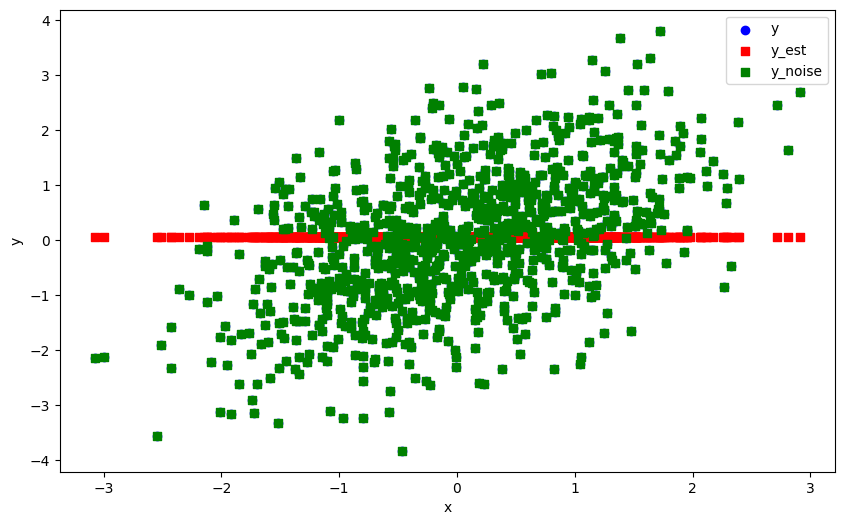

The programm is closed


In [9]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

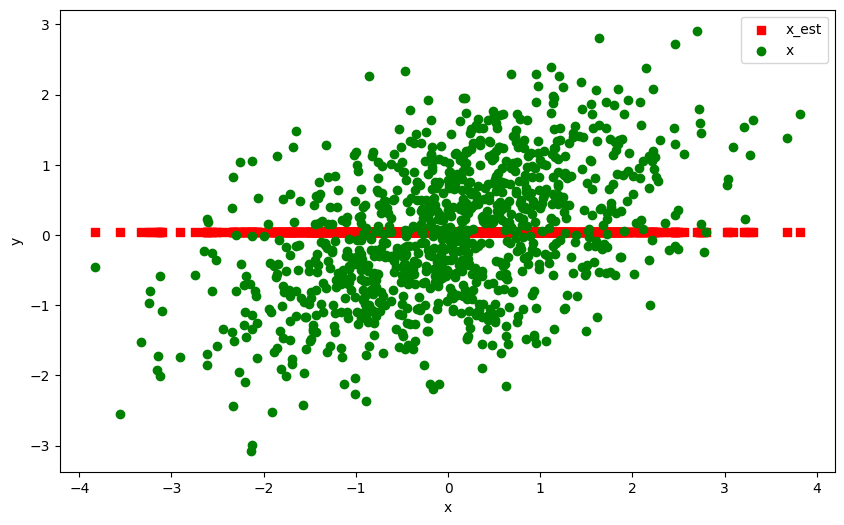

The programm is closed


In [10]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

## Test Hessian estimation

In [47]:
class PolyFunc(torch.nn.Module):
    def forward(self, x):
        if x.dim() == 1:            # handle single vector
            x = x.unsqueeze(0)      # [1, d]
        # out = torch.stack([(x[:, 0]**2)*x[:, 1], x[:, 1]**3], dim=1)  # [n, d]
        out = torch.stack([x[:, 0], 10*torch.sin(x[:, 0])], dim=1)
        return out if out.size(0) > 1 else out.squeeze(0)

In [48]:
def exact_hessian_per_output(model, x: torch.Tensor):
    """
    model.forward: [n, d] -> [n, d]
    Returns H of shape [n, d, d, d], where H[i, k] = Hessian_x f_k(x_i)  (size [d, d])
    """
    x_req = x.detach().requires_grad_(True)
    n, d = x_req.shape

    # f_single: [d] -> [d]
    def f_single(x1):
        return model.forward(x1.unsqueeze(0)).squeeze(0)  # [d]

    # Scalarization: s(x; u) = <u, f(x)>, Hess_x s with u = e_k gives Hessian of f_k
    def s(x1, u1):  # x1:[d], u1:[d]
        return (f_single(x1) * u1).sum()

    # Hessian w.r.t. x only (treat u as constant)
    hess_x = torch.func.hessian(s, argnums=0)  # (x1, u1) -> [d, d]

    I = torch.eye(d, device=x.device)  # unit vectors e_k stacked as rows, shape [d, d]

    # For one sample xi: map u over e_k to get all outputs' Hessians -> [d(outputs), d, d]
    def hess_all_outputs_for_sample(xi):
        return torch.func.vmap(lambda u: hess_x(xi, u), in_dims=0)(I)  # [d, d, d]

    # Map over batch -> [n, d, d, d]
    H = torch.func.vmap(hess_all_outputs_for_sample, in_dims=0)(x_req)
    return H

In [49]:
def exact_hessian_diag_per_output(model, x: torch.Tensor):
    H = exact_hessian_per_output(model, x)  # [n, d, d, d]
    return torch.diagonal(H, dim1=-2, dim2=-1).abs().mean(dim = 0)  # [n, d, d]

In [50]:
model = PolyFunc()
x = torch.tensor([[2.0, 3.0], [4.0, 1.0]], requires_grad=True)  # two sample

H_full = exact_hessian_per_output(model, x)    # [1, 2, 2, 2]
H_diag = exact_hessian_diag_per_output(model, x)  # [1, 2, 2]

print("Full Hessians:\n", H_full)
print("Diagonal Hessians:\n", H_diag)

Full Hessians:
 tensor([[[[-0.0000, -0.0000],
          [ 0.0000,  0.0000]],

         [[-9.0930, -0.0000],
          [ 0.0000,  0.0000]]],


        [[[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[ 7.5680,  0.0000],
          [ 0.0000,  0.0000]]]], grad_fn=<ViewBackward0>)
Diagonal Hessians:
 tensor([[0.0000, 0.0000],
        [8.3305, 0.0000]], grad_fn=<MeanBackward1>)


In [30]:
def get_Hessian(model, x: torch.Tensor) -> torch.Tensor:
        """Get the adjacency matrix defined by the DCE and the batched Jacobian

        Args:
            x (torch.Tensor): input

        Returns:
            torch.Tensor, torch.Tensor: the weighted graph and batched Jacobian
        """
        x_dummy = x.detach().requires_grad_()
        n, d = x.shape

        observed_deriv = torch.func.vmap(torch.func.jacrev(model.forward))(x_dummy).view(
            -1, d, d
        )#[n, d, d], observed_deriv[i, j, k]=for ith sample, derivative of f_j wrt x_k

        z = (torch.randint_like(observed_deriv, 0, 2).float() * 2 - 1) # [n, d, d]

        def g_single(xi, zi):
            J = torch.func.jacrev(model.forward)(xi)   # [d,d]
            return (J * zi).sum(dim=1) #[d]
        
        Hz  = torch.func.vmap(lambda xi, zi: torch.func.jacrev(lambda x_: g_single(x_, zi))(xi)
        )(x_dummy, z).view(-1, d, d) #[n, d, d]
        H_hat = (z*Hz).mean(dim=0) # [d, d] estimated Hessian of f_k wrt x_i, x_i

        return observed_deriv, H_hat

In [70]:
_, H_diag_hat = get_Hessian(model, x)
print("H_diag_hat: ", H_diag_hat)

H_diag_hat:  tensor([[-2., -6.],
        [ 0., 12.]], grad_fn=<MeanBackward1>)


In [51]:
def exact_hessian_diag_avg(model, x: torch.Tensor, batch_size: int = 256) -> torch.Tensor:
    """
    Exact per-output Hessian diagonals, averaged over a large batch.
    model.forward: [B, d] -> [B, d]
    x: [n, d]
    returns: [d, d] where out[k, i] = average over samples of ∂^2 f_k / ∂x_i^2
    """
    device = x.device
    n, d = x.shape
    out = torch.zeros(d, d, device=device)
    total = 0

    # per-sample wrapper so higher-order AD sees [d] -> [d]
    def f_single(x1):  # x1: [d] -> [d]
        return model.forward(x1.unsqueeze(0)).squeeze(0)

    # scalarization: s(x; u) = <u, f(x)>, Hess_x s with u = e_k gives Hessian of f_k
    def s(x1, u1):
        return (f_single(x1) * u1).sum()

    # Hessian wrt x only (treat u as constant)
    hess_x = torch.func.hessian(s, argnums=0)  # (x1, u1) -> [d, d]
    I = torch.eye(d, device=device)            # unit vectors e_k as rows

    # For one sample: stack all outputs' Hessians -> [d(outputs), d, d]
    def hess_all_outputs_for_sample(xi):
        return torch.func.vmap(lambda u: hess_x(xi, u), in_dims=0)(I)  # [d, d, d]

    with torch.no_grad():  # we only need numbers, not a backward graph
        for start in range(0, n, batch_size):
            xb = x[start:start+batch_size].detach().to(device).requires_grad_(True)
            # Map over the minibatch: [B, d, d, d]
            H = torch.func.vmap(hess_all_outputs_for_sample, in_dims=0)(xb)
            # Take diagonal over last two dims -> [B, d, d]
            Hdiag = torch.diagonal(H, dim1=-2, dim2=-1).contiguous() # extracts the diagonal of each Hessian
            out += Hdiag.abs().sum(dim=0)  # accumulate sum over this minibatch
            total += Hdiag.size(0)

    return out / total  # [d, d]

In [52]:
print(exact_hessian_diag_avg(model, x))

tensor([[0.0000, 0.0000],
        [8.3305, 0.0000]])


In [53]:
model = PolyFunc()
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[1, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples)
x = torch.tensor(epsilon, dtype=torch.float64)
print(exact_hessian_diag_avg(model, x))

tensor([[0.0000, 0.0000],
        [5.7114, 0.0000]])


## With non-linearity regularizer

## DAGMA init

### No Causal

In [2]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[1, 0.6],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.6, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = epsilon[:, 1]
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

In [3]:
eq_model = nonlinear.DagmaMLP(
    dims=[d, 10, 1], bias=True, dtype=torch.double)
model = nonlinear.DagmaNonlinear(
    eq_model, dtype=torch.double, use_mse_loss=True)

W_est_dagma = model.fit(X, lambda1=2e-2, lambda2=0.005,
                        T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

# Use DAGMA weights as initial weights for DAGMA-DCE
fc1_weight = eq_model.fc1.weight
fc1_bias = eq_model.fc1.bias
fc2_weight = eq_model.fc2[0].weight
fc2_bias = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
eq_model.fc1.weight = fc1_weight
eq_model.fc1.bias = fc1_bias
eq_model.fc2[0].weight = fc2_weight
eq_model.fc2[0].bias = fc2_bias

W_est_dce_no_thresh, W2, x_est = model.fit(X, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  0%|          | 0/80000 [00:00<?, ?it/s]

  4%|▎         | 1020/29000 [00:08<03:44, 124.84it/s]

Sigma:  tensor([[0.8905, 0.2191],
        [0.2191, 1.2432]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.2191],
        [0.2191, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.1589, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1244, grad_fn=<AddBackward0>)
h_val:  tensor(6.0801e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0033, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.1267e-15, 1.3573e-06],
        [3.5171e-02, 2.1048e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0156e-31, 1.5253e-14],
        [5.4313e-03, 1.1752e-21]])
mu:  1


  7%|▋         | 2020/29000 [00:15<03:26, 130.68it/s]

Sigma:  tensor([[0.8951, 0.4103],
        [0.4103, 1.3133]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.4103],
        [0.4103, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.0592, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0592, grad_fn=<AddBackward0>)
h_val:  tensor(4.7570e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.9654e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.2614e-15, 6.9400e-08],
        [2.0663e-05, 1.7568e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6922e-33, 5.1277e-18],
        [5.2168e-03, 1.4222e-21]])
mu:  1


 10%|█         | 3026/29000 [00:23<03:17, 131.21it/s]

Sigma:  tensor([[0.9252, 0.5144],
        [0.5144, 1.3942]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.5144],
        [0.5144, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.0436, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0436, grad_fn=<AddBackward0>)
h_val:  tensor(5.0915e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(3.8454e-07, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.1683e-15, 1.5650e-08],
        [4.0014e-06, 1.5489e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.6147e-34, 8.2855e-20],
        [4.2918e-03, 1.1705e-21]])
mu:  1


 24%|██▍       | 7000/29000 [00:31<00:02, 8553.83it/s]

Sigma:  tensor([[0.9396, 0.5532],
        [0.5532, 1.4325]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.5532],
        [0.5532, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.0422, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0421, grad_fn=<AddBackward0>)
h_val:  tensor(4.1203e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.6832e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.1842e-15,  3.6632e-08],
        [-1.7422e-05,  1.4065e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1528e-33, 2.0600e-18],
        [3.5986e-03, 1.0042e-21]])
mu:  1


 27%|██▋       | 7835/29000 [00:37<00:46, 450.70it/s] 

Sigma:  tensor([[0.9415, 0.5583],
        [0.5583, 1.4378]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.5583],
        [0.5583, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.2042, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0421, grad_fn=<AddBackward0>)
h_val:  tensor(2.5400e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.2488e-07, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[5.9056e-16, 1.0426e-07],
        [9.4133e-06, 1.3225e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.4707e-34, 1.0817e-17],
        [2.8569e-03, 8.4891e-22]])
mu:  0.1


 48%|████▊     | 14000/29000 [00:46<00:17, 835.13it/s]

Sigma:  tensor([[0.9416, 0.5583],
        [0.5583, 1.4377]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.5583],
        [0.5583, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.2042, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0421, grad_fn=<AddBackward0>)
h_val:  tensor(1.9780e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(3.3477e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.3125e-15, 3.7907e-07],
        [3.3964e-05, 1.2336e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.9153e-33, 4.1000e-16],
        [2.5501e-03, 7.1049e-22]])
mu:  0.1


 52%|█████▏    | 15010/29000 [00:54<00:47, 295.88it/s]

Sigma:  tensor([[0.9413, 0.5579],
        [0.5579, 1.4374]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.5579],
        [0.5579, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.0204, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0421, grad_fn=<AddBackward0>)
h_val:  tensor(1.3025e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(2.4489e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 8.8757e-16, -1.0419e-07],
        [-2.4919e-05,  1.1086e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[6.3985e-34, 8.8178e-18],
        [2.1446e-03, 5.7805e-22]])
mu:  0.010000000000000002


 72%|███████▏  | 21011/29000 [01:01<00:00, 14397.27it/s]

Sigma:  tensor([[0.9414, 0.5580],
        [0.5580, 1.4375]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.5580],
        [0.5580, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.0204, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0421, grad_fn=<AddBackward0>)
h_val:  tensor(1.0059e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(6.2190e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.2100e-15,  3.7560e-08],
        [-6.3368e-05,  1.0896e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.3788e-34, 5.1828e-19],
        [1.9189e-03, 5.2331e-22]])
mu:  0.010000000000000002
Sigma:  tensor([[0.9404, 0.5565],
        [0.5565, 1.4360]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.5565],
        [0.5565, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0421, grad_fn=<AddBackward0>)
h_val:  tensor(5.9011e-07, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(2.6807e-07, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.22

100%|██████████| 29000/29000 [01:16<00:00, 377.19it/s]  

Sigma:  tensor([[0.9408, 0.5571],
        [0.5571, 1.4366]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.5571],
        [0.5571, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.0020, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0421, grad_fn=<AddBackward0>)
h_val:  tensor(3.8655e-07, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(2.7860e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.2276e-15,  5.0160e-08],
        [-2.8193e-05,  1.0040e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[7.2764e-34, 1.2149e-18],
        [1.3597e-03, 4.0959e-22]])
mu:  0.0010000000000000002


In [4]:
print("W_est_dce_no_thresh", W_est_dce_no_thresh)

W_est_dce_no_thresh tensor([[1.2279e-15, 1.1153e-03],
        [1.6682e-09, 1.0040e-10]], grad_fn=<SqrtBackward0>)


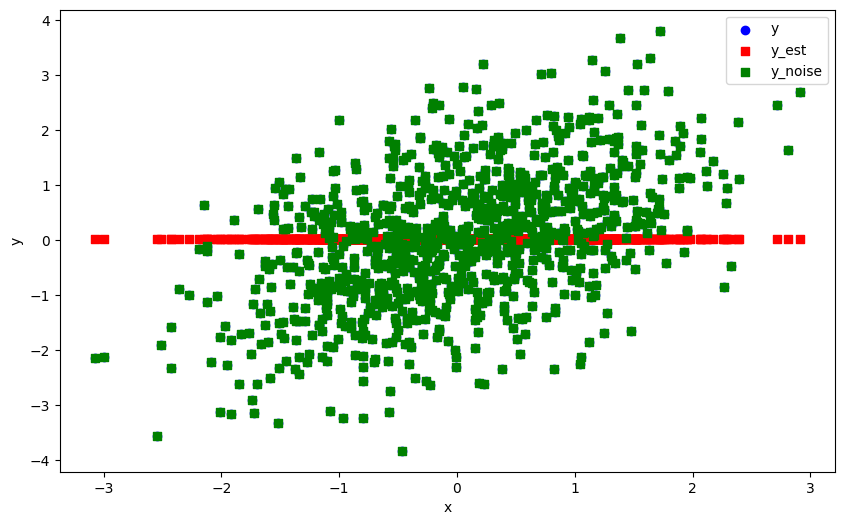

The programm is closed


In [5]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

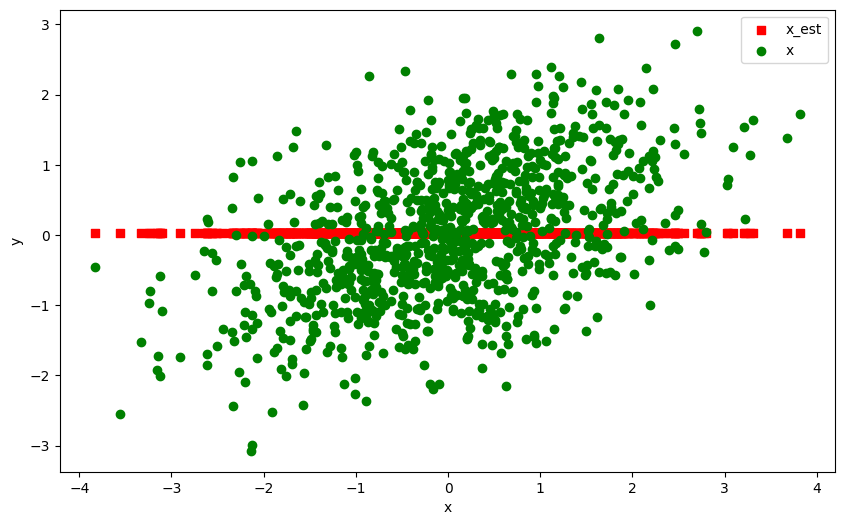

The programm is closed


In [6]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

### with causal

In [7]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 2  # Dimension of the normal vectors
d = 2
# Random data for X and X_hat
True_Sigma = np.array([[0.5, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.5]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x1 = epsilon[:, 0]
# x1 = torch.randn(n_samples)
x1_true = epsilon[:, 0]
x2 = 10*torch.sin(x1)
# Step 4: Combine these results into a new tensor of shape [n, 2]
X = torch.stack((x1, x2), dim=1)
x2_true = 10*torch.sin(x1)+ epsilon[:, 1]
X_true = torch.stack((x1_true, x2_true), dim=1)

In [8]:
eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
W, observed_derivs = eq_model.get_graph(X_true)
print("Jacobian mean diag:", observed_derivs.mean(0).diag())

Jacobian mean diag: tensor([0., 0.], grad_fn=<DiagonalBackward0_copy>)


In [9]:
eq_model = nonlinear.DagmaMLP(
    dims=[d, 10, 1], bias=True, dtype=torch.double)
model = nonlinear.DagmaNonlinear(
    eq_model, dtype=torch.double, use_mse_loss=True)

W_est_dagma = model.fit(X_true, lambda1=2e-2, lambda2=0.005,
                        T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

# Use DAGMA weights as initial weights for DAGMA-DCE
fc1_weight = eq_model.fc1.weight
fc1_bias = eq_model.fc1.bias
fc2_weight = eq_model.fc2[0].weight
fc2_bias = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
eq_model.fc1.weight = fc1_weight
eq_model.fc1.bias = fc1_bias
eq_model.fc2[0].weight = fc2_weight
eq_model.fc2[0].bias = fc2_bias

W_est_dce_no_thresh, W2, x_est = model.fit(X_true, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=6, warm_iter=7000, max_iter=8000)

  2%|▏         | 1015/43000 [00:08<05:30, 127.01it/s]

Sigma:  tensor([[0.6587, 0.0047],
        [0.0047, 1.3565]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.0047],
        [0.0047, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.2951, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8826, grad_fn=<AddBackward0>)
h_val:  tensor(0.1266, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0046, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.0646e-12, 4.7773e-02],
        [6.8090e+00, 1.0091e-08]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.2652e-24, 3.8469e-03],
        [2.1401e+00, 2.6750e-18]])
mu:  1


  5%|▍         | 2016/43000 [00:15<05:20, 127.79it/s]

Sigma:  tensor([[ 4.3365e-01, -6.4077e-04],
        [-6.4077e-04,  1.5285e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0006],
        [-0.0006,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(1.6079, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0912, grad_fn=<AddBackward0>)
h_val:  tensor(0.1993, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0052, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[4.7674e-13, 5.3666e-02],
        [7.5399e+00, 5.0349e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.5376e-25, 3.9336e-03],
        [2.5809e+00, 8.2975e-19]])
mu:  1


  7%|▋         | 3018/43000 [00:23<05:13, 127.71it/s]

Sigma:  tensor([[ 0.2962, -0.0030],
        [-0.0030,  1.6051]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0030],
        [-0.0030,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(1.3344, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7186, grad_fn=<AddBackward0>)
h_val:  tensor(0.2847, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0059, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.5902e-12, 6.1670e-02],
        [7.7091e+00, 3.5301e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.2876e-24, 4.0742e-03],
        [2.7980e+00, 4.6271e-19]])
mu:  1


  9%|▉         | 4022/43000 [00:31<05:03, 128.42it/s]

Sigma:  tensor([[ 0.2047, -0.0048],
        [-0.0048,  1.6403]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0048],
        [-0.0048,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(1.1138, grad_fn=<AddBackward0>)
mle loss:  tensor(0.3968, grad_fn=<AddBackward0>)
h_val:  tensor(0.3785, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0067, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[4.0067e-12, 7.0096e-02],
        [7.6785e+00, 3.3680e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0392e-23, 4.0093e-03],
        [2.9534e+00, 4.6011e-19]])
mu:  1


 12%|█▏        | 5025/43000 [00:39<04:57, 127.52it/s]

Sigma:  tensor([[ 0.1429, -0.0073],
        [-0.0073,  1.6399]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0073],
        [-0.0073,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.9228, grad_fn=<AddBackward0>)
mle loss:  tensor(0.1019, grad_fn=<AddBackward0>)
h_val:  tensor(0.4771, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0075, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[7.1973e-12, 7.7612e-02],
        [7.6154e+00, 3.4102e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.1940e-23, 3.8993e-03],
        [3.1402e+00, 5.1160e-19]])
mu:  1


 14%|█▍        | 6024/43000 [00:47<04:47, 128.74it/s]

Sigma:  tensor([[ 0.1015, -0.0106],
        [-0.0106,  1.6168]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0106],
        [-0.0106,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.7674, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.1579, grad_fn=<AddBackward0>)
h_val:  tensor(0.5773, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0081, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.2311e-11, 8.4028e-02],
        [7.5475e+00, 3.4389e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[8.5642e-23, 3.7390e-03],
        [3.3819e+00, 5.6753e-19]])
mu:  1


 19%|█▊        | 8019/43000 [01:03<04:33, 128.11it/s]

Sigma:  tensor([[1.0538e-01, 1.5447e-03],
        [1.5447e-03, 1.8416e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.0015],
        [0.0015, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.2714, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4233, grad_fn=<AddBackward0>)
h_val:  tensor(0.0998, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0042, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[3.7883e-11, 4.1820e-02],
        [7.1403e+00, 3.8070e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.1551e-22, 5.3783e-04],
        [3.3923e+00, 7.6448e-19]])
mu:  0.1


 21%|██        | 9018/43000 [01:10<04:23, 128.86it/s]

Sigma:  tensor([[1.5217e-01, 6.6707e-04],
        [6.6707e-04, 1.6220e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.0007],
        [0.0007, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.2292, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4331, grad_fn=<AddBackward0>)
h_val:  tensor(0.0566, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0030, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[2.6436e-11, 3.0412e-02],
        [7.4609e+00, 2.8946e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0804e-22, 2.3508e-04],
        [3.7647e+00, 4.6479e-19]])
mu:  0.1


 23%|██▎       | 10015/43000 [01:18<04:18, 127.81it/s]

Sigma:  tensor([[2.1030e-01, 1.8349e-04],
        [1.8349e-04, 1.5204e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.0002],
        [0.0002, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.2031, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4195, grad_fn=<AddBackward0>)
h_val:  tensor(0.0320, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0022, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.8285e-11, 2.2242e-02],
        [7.6850e+00, 2.0137e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[8.0649e-23, 1.0177e-04],
        [4.1498e+00, 2.4427e-19]])
mu:  0.1


 26%|██▌       | 11024/43000 [01:26<04:08, 128.43it/s]

Sigma:  tensor([[2.7361e-01, 1.0219e-04],
        [1.0219e-04, 1.4908e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000, 0.0001],
        [0.0001, 0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.1903, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4160, grad_fn=<AddBackward0>)
h_val:  tensor(0.0198, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0017, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.2967e-11, 1.7372e-02],
        [7.7411e+00, 1.5823e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.2792e-23, 5.1661e-05],
        [4.4732e+00, 1.6411e-19]])
mu:  0.1


 28%|██▊       | 12022/43000 [01:34<03:59, 129.23it/s]

Sigma:  tensor([[3.3267e-01, 8.9132e-05],
        [8.9132e-05, 1.4748e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 8.9132e-05],
        [8.9132e-05, 0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.1851, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4274, grad_fn=<AddBackward0>)
h_val:  tensor(0.0137, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0014, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[9.6793e-12, 1.4370e-02],
        [7.7556e+00, 1.2876e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4267e-23, 3.1702e-05],
        [4.8068e+00, 1.1857e-19]])
mu:  0.1


 30%|███       | 13022/43000 [01:42<03:53, 128.31it/s]

Sigma:  tensor([[3.7475e-01, 9.5185e-05],
        [9.5185e-05, 1.4680e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 9.5185e-05],
        [9.5185e-05, 0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.1837, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4433, grad_fn=<AddBackward0>)
h_val:  tensor(0.0109, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[7.8426e-12, 1.2750e-02],
        [7.7529e+00, 1.0715e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[6.9061e-24, 2.7202e-05],
        [5.1136e+00, 8.9442e-20]])
mu:  0.1


 35%|███▍      | 15017/43000 [01:57<03:39, 127.21it/s]

Sigma:  tensor([[4.7450e-01, 1.0762e-05],
        [1.0762e-05, 1.4636e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 1.0762e-05],
        [1.0762e-05, 0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0192, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6347, grad_fn=<AddBackward0>)
h_val:  tensor(7.4223e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[4.7223e-12, 1.0477e-03],
        [7.7767e+00, 7.8064e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.6007e-24, 2.1638e-06],
        [5.3949e+00, 5.0481e-20]])
mu:  0.010000000000000002


 49%|████▉     | 21007/43000 [02:05<00:01, 14813.62it/s]

Sigma:  tensor([[4.7398e-01, 9.6553e-06],
        [9.6553e-06, 1.4629e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 9.6553e-06],
        [9.6553e-06, 0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0192, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6334, grad_fn=<AddBackward0>)
h_val:  tensor(8.2206e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[4.6592e-12, 1.1011e-03],
        [7.7836e+00, 7.7589e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6196e-24, 8.9039e-07],
        [5.4341e+00, 5.1209e-20]])
mu:  0.010000000000000002
Sigma:  tensor([[4.8179e-01, 9.8068e-07],
        [9.8068e-07, 1.4613e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 9.8068e-07],
        [9.8068e-07, 0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0019, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6477, grad_fn=<AddBackward0>)
h_val:  tensor(1.1454e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.2960e-05,

 65%|██████▌   | 28000/43000 [02:21<00:18, 804.01it/s]  

Sigma:  tensor([[4.8152e-01, 9.0279e-07],
        [9.0279e-07, 1.4619e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 9.0279e-07],
        [9.0279e-07, 0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0019, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6485, grad_fn=<AddBackward0>)
h_val:  tensor(8.0676e-07, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0886e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[4.3954e-12, 1.0886e-04],
        [7.7936e+00, 7.4955e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8467e-24, 1.0344e-06],
        [5.4506e+00, 4.7886e-20]])
mu:  0.0010000000000000002


 67%|██████▋   | 28769/43000 [02:27<00:28, 498.64it/s]

Sigma:  tensor([[ 4.8018e-01, -4.6333e-07],
        [-4.6333e-07,  1.4611e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00, -4.6333e-07],
        [-4.6333e-07,  0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0002, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6486, grad_fn=<AddBackward0>)
h_val:  tensor(4.5372e-08, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(2.5449e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.1996e-11, 2.5445e-05],
        [7.8151e+00, 4.3653e-09]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.9664e-24, 1.1363e-06],
        [5.4786e+00, 1.8439e-18]])
mu:  0.00010000000000000003


 81%|████████▏ | 35000/43000 [02:36<00:08, 933.73it/s]

Sigma:  tensor([[4.8224e-01, 6.1119e-08],
        [6.1119e-08, 1.4602e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 6.1119e-08],
        [6.1119e-08, 0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0002, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6489, grad_fn=<AddBackward0>)
h_val:  tensor(9.0809e-09, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0804e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[4.3474e-12, 1.0804e-05],
        [7.8131e+00, 7.4064e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.9215e-24, 1.1604e-06],
        [5.4761e+00, 4.7142e-20]])
mu:  0.00010000000000000003


 83%|████████▎ | 35656/43000 [02:41<00:13, 548.09it/s]

Sigma:  tensor([[4.7781e-01, 1.4593e-06],
        [1.4593e-06, 1.4707e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 1.4593e-06],
        [1.4593e-06, 0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(1.9238e-05, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6479, grad_fn=<AddBackward0>)
h_val:  tensor(1.6143e-08, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.4751e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[5.7635e-10, 1.4733e-05],
        [7.8348e+00, 1.6763e-08]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7349e-20, 1.1370e-06],
        [5.5033e+00, 2.0581e-17]])
mu:  1.0000000000000004e-05


100%|██████████| 43000/43000 [02:52<00:00, 249.98it/s] 

Sigma:  tensor([[ 4.7894e-01, -7.0054e-09],
        [-7.0054e-09,  1.4659e+00]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00, -7.0054e-09],
        [-7.0054e-09,  0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(1.9225e-05, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6481, grad_fn=<AddBackward0>)
h_val:  tensor(1.1837e-09, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.0868e-07, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[2.3381e-10, 1.0743e-06],
        [7.8343e+00, 1.2308e-08]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.7909e-21, 1.1593e-06],
        [5.5026e+00, 1.1816e-17]])
mu:  1.0000000000000004e-05


In [10]:
print("W_est_dce_no_thresh", W_est_dce_no_thresh)

W_est_dce_no_thresh tensor([[2.3359e-10, 8.2918e+00],
        [4.1485e-06, 1.2926e-08]], grad_fn=<SqrtBackward0>)


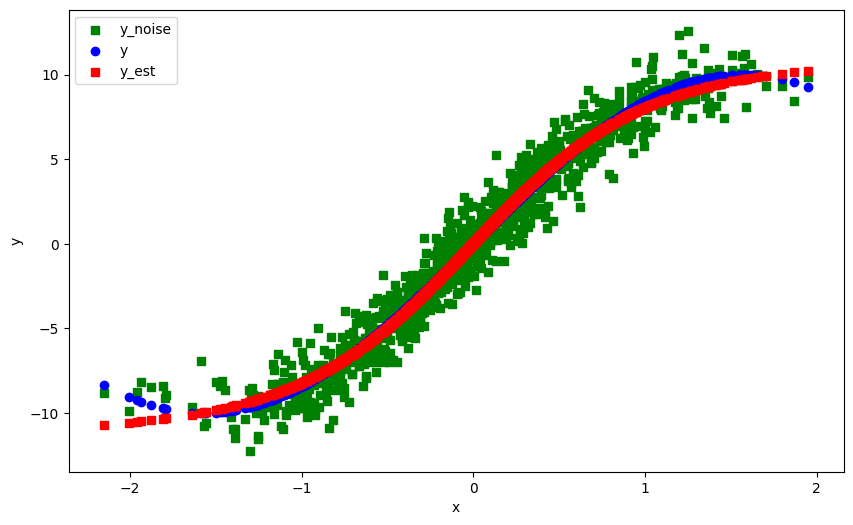

The programm is closed


In [11]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X_true.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.scatter(X_true.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X_true.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='y_est', color='red', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

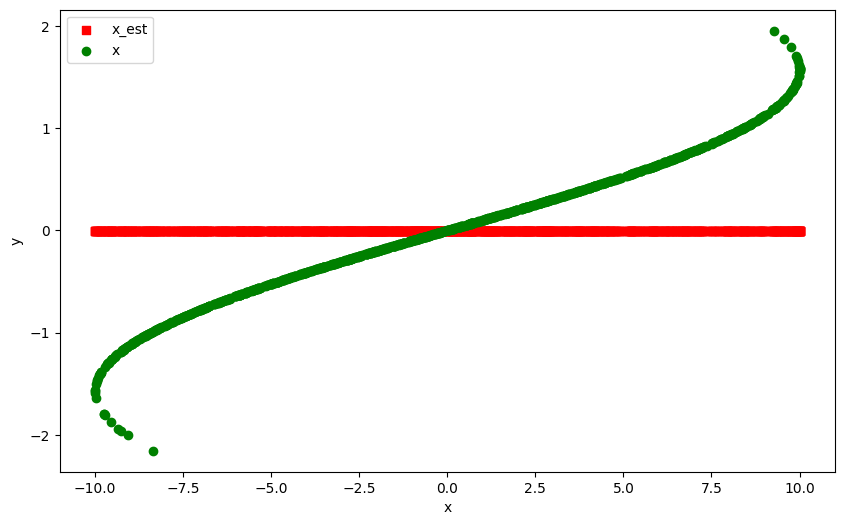

The programm is closed


In [12]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x_est', color='red', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x', color='green', marker='o')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

In [8]:
d = 2
dims = [2, 5]
mask = torch.ones(d * dims[1], d)
for j in range(d):
    mask[j * dims[1]:(j + 1) * dims[1], j] = 0.0
print(mask)

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])


In [9]:
mask = torch.ones(d * dims[1], d)
for j in range(d):
    rows = slice(j * dims[1], (j + 1) * dims[1])
    mask[rows, j] = 0.0   # forbid x_j → hidden block j
print(mask)

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])


### 3 nodes x1 <-x2<->x3 (L1-Norm)

In [16]:
np.random.seed(0)
n_samples = 1000  # Number of samples
dim = 3  # Dimension of the normal vectors
d = 3
# Random data for X and X_hat
True_Sigma = np.array([[1.0, 0.0, 0.0],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.0, 1.0, 0.6],
                [0.0, 0.6, 1.0]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * dim, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)
x3 = epsilon[:, 2]
x2 = epsilon[:, 1]
x1 = 10*torch.sin(x2)
x1_true = x1+ epsilon[:, 0]
X = torch.stack((x1, x2, x3), dim=1)
X_true = torch.stack((x1_true, x2, x3), dim=1)

In [17]:
eq_model = nonlinear.DagmaMLP(
    dims=[d, 10, 1], bias=True, dtype=torch.double)
model = nonlinear.DagmaNonlinear(
    eq_model, dtype=torch.double, use_mse_loss=True)

W_est_dagma, X_est = model.fit(X_true, lambda1=2e-2, lambda2=0.005,
                        T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

100%|██████████| 80000/80000 [00:06<00:00, 11544.15it/s]


In [4]:
print("W_est_dagma", W_est_dagma)

W_est_dagma [[1.02231540e-01 1.23392936e-02 4.84983695e-02]
 [4.59160807e+00 3.95517544e-02 1.43410329e-01]
 [3.75754941e-03 1.72855728e-01 2.84885561e-02]]


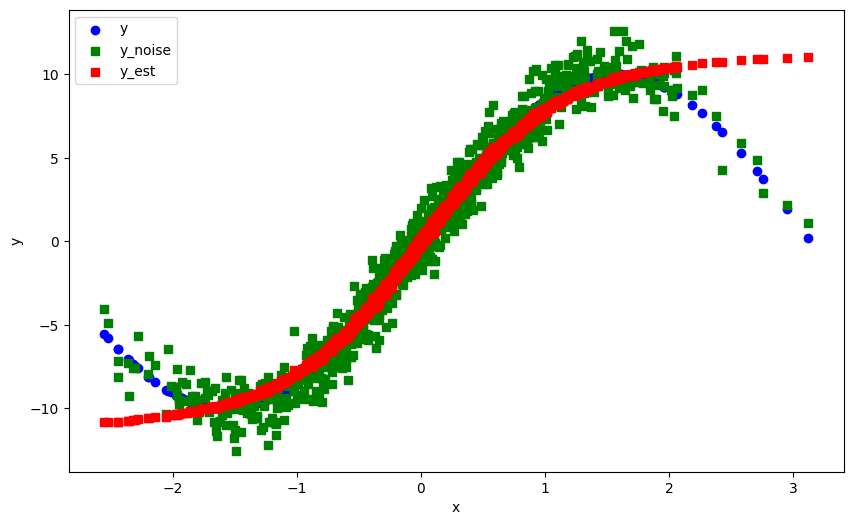

The programm is closed


In [5]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='y', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 1], X_true.detach().numpy()[:, 0], label='y_noise', color='green', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], X_est.detach().numpy()[:, 0], label='y_est', color='red', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

In [6]:
# Use DAGMA weights as initial weights for DAGMA-DCE
fc1_weight = eq_model.fc1.weight
fc1_bias = eq_model.fc1.bias
fc2_weight = eq_model.fc2[0].weight
fc2_bias = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
eq_model.fc1.weight = fc1_weight
eq_model.fc1.bias = fc1_bias
eq_model.fc2[0].weight = fc2_weight
eq_model.fc2[0].bias = fc2_bias

W_est_dce_no_thresh, W2, x_est = model.fit(X_true, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  4%|▎         | 1021/29000 [00:10<04:38, 100.64it/s]

Sigma:  tensor([[ 1.3715, -0.0054, -0.1155],
        [-0.0054,  0.6817,  0.0973],
        [-0.1155,  0.0973,  0.7287]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0054, -0.1155],
        [-0.0054,  0.0000,  0.0973],
        [-0.1155,  0.0973,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.8691, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2799, grad_fn=<AddBackward0>)
h_val:  tensor(0.2246, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0129, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.3462e-09,  6.6025e+00,  7.7438e-05],
        [ 6.3114e-02,  3.2454e-11, -3.7016e-05],
        [ 6.6167e-02,  9.7190e-05,  1.1014e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6064e-19, 3.8394e+00, 1.6226e-06],
        [5.2195e-05, 5.4597e-22, 1.5161e-05],
        [7.0682e-04, 1.0066e-05, 1.7889e-21]])
mu:  1


  7%|▋         | 2019/29000 [00:20<04:19, 103.79it/s]

Sigma:  tensor([[ 1.6253, -0.0060, -0.0111],
        [-0.0060,  0.4744,  0.2163],
        [-0.0111,  0.2163,  0.7098]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0060, -0.0111],
        [-0.0060,  0.0000,  0.2163],
        [-0.0111,  0.2163,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.5596, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9140, grad_fn=<AddBackward0>)
h_val:  tensor(0.3091, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0104, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 7.9421e-10,  6.5323e+00, -6.0533e-06],
        [ 7.2746e-02,  2.3339e-10, -5.8856e-06],
        [ 3.3957e-02,  5.0408e-06,  1.0133e-10]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[6.0084e-20, 4.0665e+00, 2.4181e-06],
        [1.1449e-04, 1.0962e-21, 1.4005e-05],
        [7.6125e-03, 2.1806e-05, 2.7167e-22]])
mu:  1


 10%|█         | 3019/29000 [00:30<04:10, 103.89it/s]

Sigma:  tensor([[ 1.7033, -0.0073,  0.1546],
        [-0.0073,  0.3373,  0.2873],
        [ 0.1546,  0.2873,  0.8652]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0073,  0.1546],
        [-0.0073,  0.0000,  0.2873],
        [ 0.1546,  0.2873,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.3371, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6270, grad_fn=<AddBackward0>)
h_val:  tensor(0.3942, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0087, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 7.0466e-10,  6.4488e+00,  2.6054e-05],
        [ 8.0603e-02,  2.6549e-10,  3.7837e-05],
        [ 8.5916e-03, -4.2441e-06,  7.3875e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.1513e-20, 4.3155e+00, 2.7116e-06],
        [1.7427e-03, 2.6986e-21, 3.8483e-06],
        [9.9491e-03, 2.4101e-05, 5.0474e-22]])
mu:  1


 14%|█▍        | 4020/29000 [00:39<03:56, 105.76it/s]

Sigma:  tensor([[ 1.6613, -0.0091,  0.2197],
        [-0.0091,  0.2476,  0.2528],
        [ 0.2197,  0.2528,  0.8993]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0091,  0.2197],
        [-0.0091,  0.0000,  0.2528],
        [ 0.2197,  0.2528,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.1716, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4031, grad_fn=<AddBackward0>)
h_val:  tensor(0.4637, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0078, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[6.3806e-10, 6.3997e+00, 1.3576e-05],
        [8.1945e-02, 2.4052e-10, 5.9023e-06],
        [2.1587e-03, 6.7886e-06, 5.1659e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.5620e-20, 4.5895e+00, 2.5453e-06],
        [7.2217e-03, 2.0408e-21, 2.0268e-05],
        [1.4332e-02, 3.5907e-05, 4.7774e-22]])
mu:  1


 17%|█▋        | 5012/29000 [00:48<03:42, 107.83it/s]

Sigma:  tensor([[ 1.6175, -0.0110,  0.1971],
        [-0.0110,  0.1965,  0.1896],
        [ 0.1971,  0.1896,  0.8189]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0110,  0.1971],
        [-0.0110,  0.0000,  0.1896],
        [ 0.1971,  0.1896,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.1216, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2749, grad_fn=<AddBackward0>)
h_val:  tensor(0.5322, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0088, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 6.0535e-10,  6.3659e+00, -1.3913e-05],
        [ 8.6791e-02,  2.3235e-10, -4.7404e-05],
        [ 9.0929e-03,  2.2987e-07,  4.0323e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.3577e-20, 4.8178e+00, 2.1908e-06],
        [7.2074e-03, 2.4800e-21, 3.8001e-05],
        [1.4953e-02, 3.6848e-05, 3.1670e-22]])
mu:  1


 21%|██        | 6014/29000 [00:58<03:33, 107.74it/s]

Sigma:  tensor([[ 1.5991, -0.0121,  0.1781],
        [-0.0121,  0.1739,  0.1593],
        [ 0.1781,  0.1593,  0.7770]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0121,  0.1781],
        [-0.0121,  0.0000,  0.1593],
        [ 0.1781,  0.1593,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.1118, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2205, grad_fn=<AddBackward0>)
h_val:  tensor(0.5705, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0095, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 5.8487e-10,  6.3469e+00, -2.3630e-05],
        [ 8.9280e-02,  1.9689e-10, -1.7420e-05],
        [ 1.4106e-02,  6.3528e-06,  3.0573e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.2046e-20, 4.9488e+00, 1.8422e-06],
        [7.1018e-03, 2.3876e-21, 5.4105e-05],
        [1.4722e-02, 3.4995e-05, 1.9793e-22]])
mu:  1


 28%|██▊       | 8019/29000 [01:17<03:16, 106.84it/s]

Sigma:  tensor([[1.6362e+00, 3.1617e-05, 4.7232e-04],
        [3.1617e-05, 2.4654e-01, 9.1846e-02],
        [4.7232e-04, 9.1846e-02, 7.2714e-01]], grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 3.1617e-05, 4.7232e-04],
        [3.1617e-05, 0.0000e+00, 9.1846e-02],
        [4.7232e-04, 9.1846e-02, 0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.3472, grad_fn=<AddBackward0>)
mle loss:  tensor(2.5314, grad_fn=<AddBackward0>)
h_val:  tensor(0.0507, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0205, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[5.3680e-10, 6.3259e+00, 7.5670e-05],
        [2.7619e-02, 2.3642e-10, 1.6220e-01],
        [2.0166e-02, 1.2205e-05, 2.3966e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.5739e-20, 4.9615e+00, 1.8635e-06],
        [3.4882e-03, 2.6326e-21, 1.4643e-03],
        [7.9427e-03, 9.6291e-06, 7.0896e-23]])
mu:  0.1


 31%|███       | 9020/29000 [01:26<03:07, 106.51it/s]

Sigma:  tensor([[ 1.5621e+00, -1.1752e-04, -7.7129e-03],
        [-1.1752e-04,  3.3280e-01,  4.9536e-02],
        [-7.7129e-03,  4.9536e-02,  6.6894e-01]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0001, -0.0077],
        [-0.0001,  0.0000,  0.0495],
        [-0.0077,  0.0495,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.3239, grad_fn=<AddBackward0>)
mle loss:  tensor(2.4443, grad_fn=<AddBackward0>)
h_val:  tensor(0.0336, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0224, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[3.6753e-10, 6.4574e+00, 1.1693e-04],
        [2.1362e-02, 1.7815e-10, 1.6629e-01],
        [4.1199e-02, 9.0203e-06, 2.7950e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.6873e-20, 5.2063e+00, 1.5765e-06],
        [2.6910e-03, 1.5283e-21, 1.0218e-03],
        [5.6929e-03, 3.2295e-06, 1.6914e-22]])
mu:  0.1


 35%|███▍      | 10021/29000 [01:35<02:58, 106.46it/s]

Sigma:  tensor([[ 1.5447e+00, -1.0385e-04, -1.7585e-02],
        [-1.0385e-04,  4.3350e-01,  8.2043e-02],
        [-1.7585e-02,  8.2043e-02,  6.5879e-01]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0001, -0.0176],
        [-0.0001,  0.0000,  0.0820],
        [-0.0176,  0.0820,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.3120, grad_fn=<AddBackward0>)
mle loss:  tensor(2.5017, grad_fn=<AddBackward0>)
h_val:  tensor(0.0227, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0158, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[2.8921e-10, 6.4876e+00, 5.3746e-05],
        [1.7918e-02, 1.3728e-10, 1.0259e-01],
        [4.1488e-02, 1.6871e-05, 2.3389e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0622e-20, 5.3430e+00, 1.3420e-06],
        [2.1579e-03, 9.0159e-22, 8.1811e-04],
        [5.8533e-03, 2.6194e-06, 1.3395e-22]])
mu:  0.1


 38%|███▊      | 11013/29000 [01:45<02:48, 106.78it/s]

Sigma:  tensor([[ 1.5384e+00, -9.8894e-05, -1.2757e-02],
        [-9.8894e-05,  5.5266e-01,  2.2932e-01],
        [-1.2757e-02,  2.2932e-01,  7.0343e-01]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00, -9.8894e-05, -1.2757e-02],
        [-9.8894e-05,  0.0000e+00,  2.2932e-01],
        [-1.2757e-02,  2.2932e-01,  0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.3021, grad_fn=<AddBackward0>)
mle loss:  tensor(2.6019, grad_fn=<AddBackward0>)
h_val:  tensor(0.0157, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0033, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[2.3565e-10, 6.5011e+00, 6.8435e-06],
        [1.5210e-02, 1.0599e-10, 1.6113e-03],
        [1.7400e-02, 7.9908e-06, 1.9323e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[7.1777e-21, 5.4606e+00, 1.1489e-06],
        [1.8485e-03, 5.3072e-22, 3.2894e-04],
        [4.2575e-03, 2.9576e-06, 8.2439e-23]])
mu:  0.1


 41%|████▏     | 12015/29000 [01:54<02:38, 107.00it/s]

Sigma:  tensor([[ 1.5337e+00, -7.5310e-05,  3.1748e-02],
        [-7.5310e-05,  6.6528e-01,  4.1756e-01],
        [ 3.1748e-02,  4.1756e-01,  8.6700e-01]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00, -7.5310e-05,  3.1748e-02],
        [-7.5310e-05,  0.0000e+00,  4.1756e-01],
        [ 3.1748e-02,  4.1756e-01,  0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.2960, grad_fn=<AddBackward0>)
mle loss:  tensor(2.6081, grad_fn=<AddBackward0>)
h_val:  tensor(0.0111, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0013, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.0006e-10,  6.5065e+00, -7.4011e-05],
        [ 1.2923e-02,  7.8740e-11, -3.1493e-05],
        [-1.0487e-05,  3.7340e-06,  1.3872e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.2422e-21, 5.5413e+00, 1.0084e-06],
        [1.5985e-03, 3.2293e-22, 3.4414e-04],
        [1.6767e-03, 4.3626e-06, 4.6602e-23]])
mu:  0.1


 45%|████▍     | 13016/29000 [02:03<02:29, 106.96it/s]

Sigma:  tensor([[ 1.5321e+00, -6.9611e-05,  2.9853e-02],
        [-6.9611e-05,  7.2698e-01,  4.6110e-01],
        [ 2.9853e-02,  4.6110e-01,  8.9768e-01]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00, -6.9611e-05,  2.9853e-02],
        [-6.9611e-05,  0.0000e+00,  4.6110e-01],
        [ 2.9853e-02,  4.6110e-01,  0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.2954, grad_fn=<AddBackward0>)
mle loss:  tensor(2.6214, grad_fn=<AddBackward0>)
h_val:  tensor(0.0093, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0012, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.8687e-10,  6.5102e+00, -3.4389e-05],
        [ 1.1920e-02,  6.2270e-11, -2.2388e-06],
        [ 3.0828e-06,  5.8111e-07,  1.3181e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.5952e-21, 5.5688e+00, 9.1675e-07],
        [1.4334e-03, 2.2306e-22, 3.3405e-04],
        [1.1545e-03, 3.7917e-06, 1.0381e-22]])
mu:  0.1


 52%|█████▏    | 15020/29000 [02:22<02:15, 103.01it/s]

Sigma:  tensor([[ 1.5297e+00, -2.9064e-06,  1.3999e-02],
        [-2.9064e-06,  8.7322e-01,  5.2225e-01],
        [ 1.3999e-02,  5.2225e-01,  9.1677e-01]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00, -2.9064e-06,  1.3999e-02],
        [-2.9064e-06,  0.0000e+00,  5.2225e-01],
        [ 1.3999e-02,  5.2225e-01,  0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0305, grad_fn=<AddBackward0>)
mle loss:  tensor(2.7866, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(7.6937e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.7804e-10,  6.5239e+00,  1.3180e-05],
        [ 7.3494e-04,  2.8445e-11, -2.7055e-06],
        [ 2.0272e-05,  3.0395e-06,  1.3233e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.1686e-21, 5.5952e+00, 8.0845e-07],
        [6.4581e-04, 2.2881e-23, 1.3386e-04],
        [6.2067e-05, 3.0201e-06, 5.8383e-23]])
mu:  0.010000000000000002


 55%|█████▌    | 16012/29000 [02:31<02:01, 106.70it/s]

Sigma:  tensor([[ 1.5286e+00, -4.9500e-06,  1.4120e-02],
        [-4.9500e-06,  8.7486e-01,  5.2283e-01],
        [ 1.4120e-02,  5.2283e-01,  9.1678e-01]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00, -4.9500e-06,  1.4120e-02],
        [-4.9500e-06,  0.0000e+00,  5.2283e-01],
        [ 1.4120e-02,  5.2283e-01,  0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0304, grad_fn=<AddBackward0>)
mle loss:  tensor(2.7877, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.7132e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[1.5240e-10, 6.5292e+00, 2.5291e-05],
        [9.2702e-04, 3.9640e-11, 1.4871e-05],
        [3.7780e-07, 7.9140e-06, 1.2887e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.0591e-21, 5.6134e+00, 7.7749e-07],
        [4.4683e-04, 7.4972e-23, 4.8266e-05],
        [6.7894e-05, 3.0199e-06, 8.1263e-23]])
mu:  0.010000000000000002


 59%|█████▊    | 17015/29000 [02:41<01:51, 107.29it/s]

Sigma:  tensor([[ 1.5281e+00, -5.0470e-06,  1.4090e-02],
        [-5.0470e-06,  8.7657e-01,  5.2344e-01],
        [ 1.4090e-02,  5.2344e-01,  9.1683e-01]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00, -5.0470e-06,  1.4090e-02],
        [-5.0470e-06,  0.0000e+00,  5.2344e-01],
        [ 1.4090e-02,  5.2344e-01,  0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0303, grad_fn=<AddBackward0>)
mle loss:  tensor(2.7890, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.4708e-10,  6.5303e+00,  6.1655e-05],
        [ 1.0097e-03,  4.4164e-11,  1.6149e-05],
        [-7.6624e-08,  1.2666e-05,  1.2151e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.8554e-21, 5.6276e+00, 7.5637e-07],
        [3.0915e-04, 1.1677e-22, 1.8149e-05],
        [6.6256e-05, 2.8986e-06, 7.4898e-23]])
mu:  0.010000000000000002


 72%|███████▏  | 21006/29000 [02:50<00:00, 8764.80it/s]

Sigma:  tensor([[ 1.5278e+00, -5.0527e-06,  1.4107e-02],
        [-5.0527e-06,  8.7777e-01,  5.2383e-01],
        [ 1.4107e-02,  5.2383e-01,  9.1684e-01]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00, -5.0527e-06,  1.4107e-02],
        [-5.0527e-06,  0.0000e+00,  5.2383e-01],
        [ 1.4107e-02,  5.2383e-01,  0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0303, grad_fn=<AddBackward0>)
mle loss:  tensor(2.7901, grad_fn=<AddBackward0>)
h_val:  tensor(9.3184e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0001, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.4442e-10,  6.5306e+00,  2.7017e-05],
        [ 1.0543e-03,  4.6222e-11, -2.0900e-05],
        [ 1.8658e-05,  2.5540e-06,  1.1380e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.7570e-21, 5.6361e+00, 7.4419e-07],
        [2.1814e-04, 1.3803e-22, 5.7873e-06],
        [6.6531e-05, 2.7524e-06, 6.8021e-23]])
mu:  0.010000000000000002


 75%|███████▌  | 21868/29000 [02:58<00:19, 368.80it/s] 

Sigma:  tensor([[ 1.5266e+00, -1.9389e-06,  1.2552e-02],
        [-1.9389e-06,  8.9006e-01,  5.2843e-01],
        [ 1.2552e-02,  5.2843e-01,  9.1792e-01]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00, -1.9389e-06,  1.2552e-02],
        [-1.9389e-06,  0.0000e+00,  5.2843e-01],
        [ 1.2552e-02,  5.2843e-01,  0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0030, grad_fn=<AddBackward0>)
mle loss:  tensor(2.8034, grad_fn=<AddBackward0>)
h_val:  tensor(1.6955e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(8.0806e-06, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.8154e-10,  6.5410e+00,  2.4397e-07],
        [ 5.2278e-05,  1.4072e-11, -1.1792e-05],
        [ 5.1586e-06, -1.1425e-05,  1.2594e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.3556e-21, 5.6544e+00, 8.0528e-07],
        [1.6228e-04, 2.7983e-23, 5.3806e-05],
        [1.0854e-05, 2.2028e-06, 1.2980e-22]])
mu:  0.0010000000000000002


 79%|███████▉  | 22903/29000 [03:07<00:31, 195.87it/s]

Sigma:  tensor([[ 1.5273e+00, -5.2740e-07,  1.2705e-02],
        [-5.2740e-07,  8.9108e-01,  5.2847e-01],
        [ 1.2705e-02,  5.2847e-01,  9.1755e-01]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00, -5.2740e-07,  1.2705e-02],
        [-5.2740e-07,  0.0000e+00,  5.2847e-01],
        [ 1.2705e-02,  5.2847e-01,  0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0030, grad_fn=<AddBackward0>)
mle loss:  tensor(2.8047, grad_fn=<AddBackward0>)
h_val:  tensor(9.1653e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.1830e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.4014e-10,  6.5339e+00, -3.9202e-05],
        [ 6.9700e-05,  2.6517e-11,  3.2882e-06],
        [-9.5306e-07,  5.2420e-06,  1.1224e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.5969e-21, 5.6442e+00, 8.3922e-07],
        [1.2283e-04, 2.8105e-23, 1.2689e-04],
        [1.0061e-05, 2.1985e-06, 6.7073e-23]])
mu:  0.0010000000000000002


 83%|████████▎ | 24012/29000 [03:18<00:42, 118.49it/s]

Sigma:  tensor([[ 1.5276e+00, -4.8895e-07,  1.2733e-02],
        [-4.8895e-07,  8.9164e-01,  5.2858e-01],
        [ 1.2733e-02,  5.2858e-01,  9.1748e-01]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00, -4.8895e-07,  1.2733e-02],
        [-4.8895e-07,  0.0000e+00,  5.2858e-01],
        [ 1.2733e-02,  5.2858e-01,  0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0030, grad_fn=<AddBackward0>)
mle loss:  tensor(2.8055, grad_fn=<AddBackward0>)
h_val:  tensor(4.3885e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.2555e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.4178e-10,  6.5316e+00,  1.5578e-05],
        [ 8.6909e-05,  3.6323e-11,  1.8770e-05],
        [-1.2294e-06, -3.1572e-06,  1.0952e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.6586e-21, 5.6411e+00, 8.8045e-07],
        [8.2388e-05, 7.6717e-23, 1.3742e-04],
        [9.4341e-06, 2.1694e-06, 6.5050e-23]])
mu:  0.0010000000000000002


100%|██████████| 29000/29000 [03:27<00:00, 139.85it/s]

Sigma:  tensor([[ 1.5275e+00, -4.9402e-07,  1.2759e-02],
        [-4.9402e-07,  8.9205e-01,  5.2873e-01],
        [ 1.2759e-02,  5.2873e-01,  9.1750e-01]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00, -4.9402e-07,  1.2759e-02],
        [-4.9402e-07,  0.0000e+00,  5.2873e-01],
        [ 1.2759e-02,  5.2873e-01,  0.0000e+00]], grad_fn=<SubBackward0>)
obj:  tensor(0.0030, grad_fn=<AddBackward0>)
mle loss:  tensor(2.8059, grad_fn=<AddBackward0>)
h_val:  tensor(2.1325e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.1939e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.4083e-10,  6.5321e+00, -2.0023e-06],
        [ 9.9012e-05,  4.2794e-11,  6.0580e-06],
        [ 6.7793e-06,  5.5941e-06,  1.0565e-11]], grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.6229e-21, 5.6421e+00, 9.2925e-07],
        [5.0262e-05, 1.1698e-22, 1.0399e-04],
        [8.8932e-06, 2.0395e-06, 6.1794e-23]])
mu:  0.0010000000000000002


In [10]:
print("W_est_dce_no_thresh", W_est_dce_no_thresh)

W_est_dce_no_thresh tensor([[1.5899e-10, 1.9518e-04, 3.2894e-05],
        [7.3748e+00, 4.2832e-11, 1.2425e-05],
        [1.8072e-05, 4.2116e-04, 1.0663e-11]], grad_fn=<SqrtBackward0>)


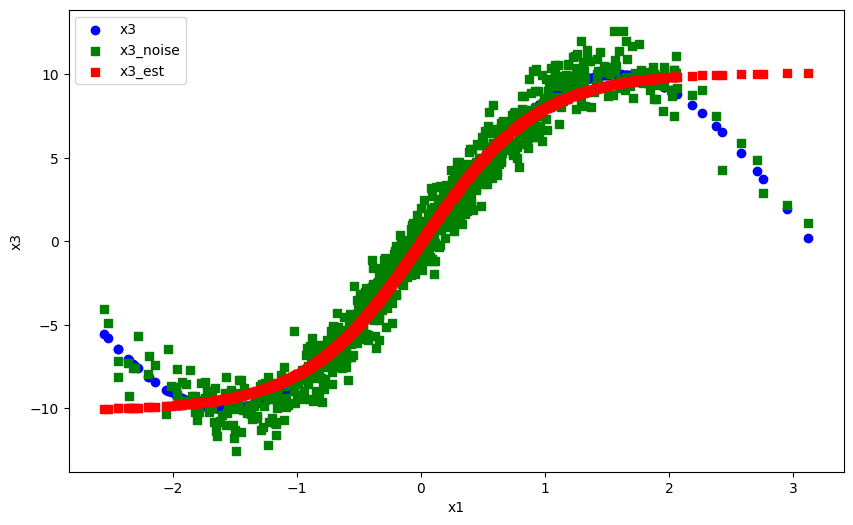

The programm is closed


In [11]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 1], X.detach().numpy()[:, 0], label='x3', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 1], X_true.detach().numpy()[:, 0], label='x3_noise', color='green', marker='s') 
plt.scatter(X.detach().numpy()[:, 1], x_est.detach().numpy()[:, 0], label='x3_est', color='red', marker='s') 
plt.xlabel('x1')
plt.ylabel('x3')
plt.legend()
plt.show()
print("The programm is closed")

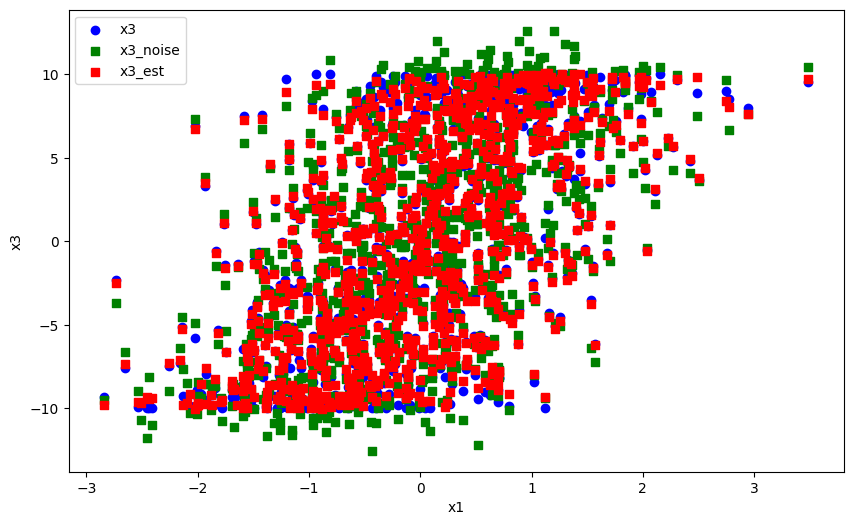

The programm is closed


In [12]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X.detach().numpy()[:, 2], X.detach().numpy()[:, 0], label='x3', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X.detach().numpy()[:, 2], X_true.detach().numpy()[:, 0], label='x3_noise', color='green', marker='s') 
plt.scatter(X.detach().numpy()[:, 2], x_est.detach().numpy()[:, 0], label='x3_est', color='red', marker='s') 
plt.xlabel('x1')
plt.ylabel('x3')
plt.legend()
plt.show()
print("The programm is closed")

### 4 Nodes

#### 4 nodes

In [2]:
torch.set_default_dtype(torch.double)
np.random.seed(0)
n_samples = 1000  # Number of samples 
d = 4
dims=[d, 10, 1]
# Random data for X and X_hat
True_Sigma = np.array([[1.0, 0.5, 0.0, 0.8],    # Variance of X is 1, covariance between X and Y is 0.8
                [0.5, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.0],
                [0.8, 0.0, 0.0, 1.0]])   # Variance of Y is 1, covariance between Y and X is 0.8
epsilon = np.random.multivariate_normal([0] * d, True_Sigma, size=n_samples) #[n, d]
epsilon = torch.tensor(epsilon, dtype=torch.float64)

In [74]:
eigvals = np.linalg.eigvals(True_Sigma)
print(eigvals)
print("Is positive definite?", np.all(eigvals > 0))

[1.94339811 0.05660189 1.         1.        ]
Is positive definite? True


In [2]:
def generate(parents, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    bias=True
    fc1 = nn.Linear(d, d * dims[1], bias=bias) # [d * dims[1], d]
    # self.fc1.weight.bounds = self._bounds()
    mask = torch.ones(d * dims[1], d)

    for j in range(d):
        allowed_parents = parents[j]
        not_parents = [p for p in range(d) if p not in allowed_parents]
        mask[j * dims[1]:(j + 1) * dims[1], not_parents] = 0.0

    layers = []
    for l in range(len(dims) - 2):
        layers.append(LocallyConnected(d, dims[l + 1], dims[l + 2], bias=bias))
    fc2 = nn.ModuleList(layers)
    return fc1, fc2, mask

def forward(fc1, fc2, mask, x: torch.Tensor) -> torch.Tensor:
    """Forward pass of the sigmoidal feedforward NN

    Args:
        x (torch.Tensor): input

    Returns:
        torch.Tensor: output
    """
    # x = self.fc1(x) # [n, self.d * dims[1]]
    weight = fc1.weight*mask #[d * dims[1], d]
    x = x@(weight.T) 
    if fc1.bias is not None:
        x = x + fc1.bias.unsqueeze(0)

    x = x.view(-1, dims[0], dims[1]) # [n, d, self.dims[1]]

    # self.activation = nn.SiLU()
    activation = nn.Sigmoid()

    for fc in fc2:
        # x = torch.sigmoid(x)
        x = activation(x)
        x = fc(x) # [n, d, self.dims[2]]

    x = x.squeeze(dim=2) #[n, d]

    return x

In [76]:
parents = {
    0: [],          # variable 0 has no parents
    1: [3],         # variable 1 has parent 0
    2: [0],      # variable 2 has parents 0 and 1
    3: []          # variable 3 has parent 2
}
allowed_parents = parents[2]
not_parents = [p for p in range(d) if p not in allowed_parents]
not_parents

[1, 2, 3]

In [77]:
def scale_weights(model, factor):
    with torch.no_grad():
        for param in model.parameters():
            if param.ndim > 1:  # Skip bias
                param.mul_(factor)

In [91]:
x1 = epsilon[:, 0]
x2 = epsilon[:, 1]
x3 = epsilon[:, 2]
x4 = epsilon[:, 3]
x = torch.stack((x1, x2, x3, x4), dim=1)
fc1, fc2, mask = generate(parents, seed = 0)
scale_weights(fc1, factor=10)
for layer in fc2:
    scale_weights(layer, factor=10)
X = forward(fc1, fc2, mask, x)
X_true = (X+epsilon).detach()

In [92]:
from torch.func import jacrev, vmap

def f(x_single):
    # expects x_single: shape [d]
    return forward(fc1, fc2, mask, x_single.unsqueeze(0)).squeeze(0)

# vmap over all samples
J = vmap(jacrev(f))(X_true)    # shape [n_samples, d, d]
W = torch.sqrt(torch.mean(J ** 2, axis=0).T)
W


tensor([[0.0000, 0.0000, 0.9310, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 2.4999, 0.0000, 0.0000]], grad_fn=<SqrtBackward0>)

In [93]:
observed_deriv = torch.func.vmap(torch.func.jacrev(
            f))(X_true).view(-1, 4, d)
W = torch.sqrt(torch.mean(observed_deriv ** 2, axis=0).T)
W

tensor([[0.0000, 0.0000, 0.9310, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 2.4999, 0.0000, 0.0000]], grad_fn=<SqrtBackward0>)

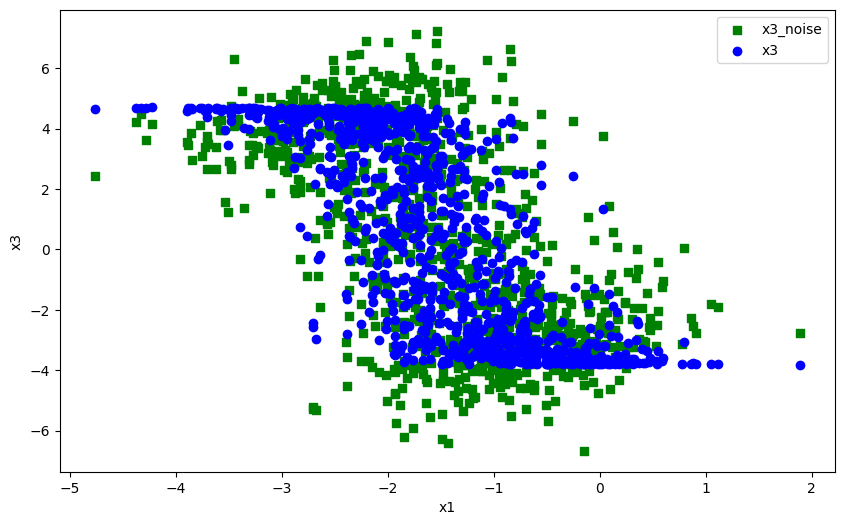

The programm is closed


In [72]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size  
plt.scatter(X_true.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='x3_noise', color='green', marker='s') 
plt.scatter(X_true.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='x3', color='blue', marker='o')
# plt.scatter(X.detach().numpy()[:, 2], x_est.detach().numpy()[:, 0], label='x3_est', color='red', marker='s') 
plt.xlabel('x1')
plt.ylabel('x3')
plt.legend()
plt.show()
print("The programm is closed")

In [102]:
fc1_weight = fc1.weight*mask
# print(fc1_weight)
fc1_bias = fc1.bias
fc2_weight = fc2[0].weight
fc2_bias = fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
# eq_model.mask = mask.clone()
eq_model.fc1.weight = nn.Parameter(fc1_weight)
eq_model.fc1.bias = fc1_bias
eq_model.fc2[0].weight = fc2_weight
eq_model.fc2[0].bias = fc2_bias


W_current, observed_derivs = eq_model.get_graph(X_true)
print("W_current: ", W_current)
cycle_loss = eq_model.cycle_loss(W_current)
print("cycle_loss: ", cycle_loss)

W_est_dce_no_thresh, W2, x_est = model.fit(X_true, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

W_current:  tensor([[0.0000, 0.0000, 0.9310, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 2.4999, 0.0000, 0.0000]], grad_fn=<SqrtBackward0>)
cycle_loss:  tensor(0., grad_fn=<AddBackward0>)


  3%|▎         | 1010/29000 [00:11<05:17, 88.09it/s]

Sigma:  tensor([[ 0.6776,  0.0808,  0.0966,  0.1501],
        [ 0.0808,  1.3584,  0.1369, -0.0116],
        [ 0.0966,  0.1369,  1.3010,  0.1222],
        [ 0.1501, -0.0116,  0.1222,  0.7046]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000,  0.0808,  0.0966,  0.1501],
        [ 0.0808,  0.0000,  0.1369, -0.0116],
        [ 0.0966,  0.1369,  0.0000,  0.1222],
        [ 0.1501, -0.0116,  0.1222,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(7.6634, grad_fn=<AddBackward0>)
mle loss:  tensor(6.5051, grad_fn=<AddBackward0>)
h_val:  tensor(0.1773, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0865, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.6531e-10, -1.0869e-01,  7.4473e-02,  6.8927e-05],
        [-2.1037e-01,  4.8328e-10, -2.1395e-01, -2.1516e+00],
        [ 2.6169e-01, -8.0143e-02,  1.0117e-10,  7.6916e-02],
        [ 2.7001e-02, -1.1895e-01,  8.2571e-04,  1.4235e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.1951e-21, 2.7501e-04, 1.1349e-04, 3.7631e-08],


  7%|▋         | 2019/29000 [00:23<04:59, 90.14it/s]

Sigma:  tensor([[ 0.4993,  0.2262,  0.1584,  0.2484],
        [ 0.2262,  1.6597,  0.2888, -0.0079],
        [ 0.1584,  0.2888,  1.4382,  0.1911],
        [ 0.2484, -0.0079,  0.1911,  0.5863]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000,  0.2262,  0.1584,  0.2484],
        [ 0.2262,  0.0000,  0.2888, -0.0079],
        [ 0.1584,  0.2888,  0.0000,  0.1911],
        [ 0.2484, -0.0079,  0.1911,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(4.9253, grad_fn=<AddBackward0>)
mle loss:  tensor(3.7406, grad_fn=<AddBackward0>)
h_val:  tensor(0.2137, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0855, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.4424e-10, -1.2113e-01,  7.4658e-02,  1.5055e-04],
        [-2.7628e-01,  2.7535e-10, -2.9005e-01, -2.0499e+00],
        [ 2.5999e-01, -9.1965e-02,  9.5224e-11,  4.7075e-05],
        [ 1.8159e-04, -1.4515e-01,  8.3588e-05,  1.0392e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.9308e-21, 4.6608e-04, 1.5552e-04, 3.0480e-07],


 10%|█         | 3012/29000 [00:34<04:57, 87.49it/s]

Sigma:  tensor([[ 0.4574,  0.3288,  0.1089,  0.2681],
        [ 0.3288,  1.9165,  0.3872, -0.0221],
        [ 0.1089,  0.3872,  1.3117,  0.1870],
        [ 0.2681, -0.0221,  0.1870,  0.4982]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000,  0.3288,  0.1089,  0.2681],
        [ 0.3288,  0.0000,  0.3872, -0.0221],
        [ 0.1089,  0.3872,  0.0000,  0.1870],
        [ 0.2681, -0.0221,  0.1870,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(3.6505, grad_fn=<AddBackward0>)
mle loss:  tensor(2.4451, grad_fn=<AddBackward0>)
h_val:  tensor(0.2242, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0866, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.3120e-10, -1.3874e-01,  1.1624e-01,  3.8574e-05],
        [-2.8936e-01,  2.5700e-10, -3.1284e-01, -1.8180e+00],
        [ 3.4424e-01, -8.9100e-02,  8.9480e-11, -2.4786e-06],
        [ 8.7434e-05, -1.7324e-01,  1.3679e-04,  6.7300e-11]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.0700e-21, 2.9190e-03, 3.0815e-03, 1.5541e-05],


 14%|█▍        | 4010/29000 [00:46<04:38, 89.78it/s]

Sigma:  tensor([[ 0.4102,  0.4109, -0.0359,  0.2423],
        [ 0.4109,  2.1080,  0.4377, -0.0217],
        [-0.0359,  0.4377,  1.1181,  0.1181],
        [ 0.2423, -0.0217,  0.1181,  0.4275]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000,  0.4109, -0.0359,  0.2423],
        [ 0.4109,  0.0000,  0.4377, -0.0217],
        [-0.0359,  0.4377,  0.0000,  0.1181],
        [ 0.2423, -0.0217,  0.1181,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.6786, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4730, grad_fn=<AddBackward0>)
h_val:  tensor(0.2796, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0804, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.6917e-10, -1.1474e-01,  1.7043e-01,  8.7838e-05],
        [-2.8848e-01,  2.3563e-10, -3.2132e-01, -1.7516e+00],
        [ 5.9008e-01, -5.5504e-02,  1.1313e-10,  1.3019e-04],
        [-4.2124e-05, -1.9137e-01,  9.6709e-05,  8.2499e-11]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.7459e-21, 3.3304e-02, 3.0229e-03, 9.7341e-04],


 17%|█▋        | 5013/29000 [00:57<04:20, 92.00it/s]

Sigma:  tensor([[ 0.3585,  0.4549, -0.1432,  0.1820],
        [ 0.4549,  2.2026,  0.4680,  0.0162],
        [-0.1432,  0.4680,  1.0327,  0.0167],
        [ 0.1820,  0.0162,  0.0167,  0.3006]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000,  0.4549, -0.1432,  0.1820],
        [ 0.4549,  0.0000,  0.4680,  0.0162],
        [-0.1432,  0.4680,  0.0000,  0.0167],
        [ 0.1820,  0.0162,  0.0167,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.0268, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7275, grad_fn=<AddBackward0>)
h_val:  tensor(0.3793, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0789, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.4155e-10, -9.9504e-02,  2.0563e-01,  2.7692e-05],
        [-2.6709e-01,  2.2841e-10, -3.0823e-01, -1.7865e+00],
        [ 8.4124e-01, -3.6282e-02,  1.2420e-10,  1.4745e-06],
        [ 1.2412e-05, -2.0946e-01,  4.4800e-03,  1.2873e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.4545e-21, 5.1419e-02, 3.9936e-03, 2.6144e-03],


 21%|██        | 6016/29000 [01:08<04:13, 90.67it/s]

Sigma:  tensor([[ 0.3333,  0.4829, -0.2198,  0.1406],
        [ 0.4829,  2.1907,  0.4818,  0.0388],
        [-0.2198,  0.4818,  1.0362, -0.0545],
        [ 0.1406,  0.0388, -0.0545,  0.2138]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000,  0.4829, -0.2198,  0.1406],
        [ 0.4829,  0.0000,  0.4818,  0.0388],
        [-0.2198,  0.4818,  0.0000, -0.0545],
        [ 0.1406,  0.0388, -0.0545,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(1.4295, grad_fn=<AddBackward0>)
mle loss:  tensor(0.0361, grad_fn=<AddBackward0>)
h_val:  tensor(0.4690, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0782, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.4916e-10, -1.0127e-01,  2.6043e-01,  5.7649e-06],
        [-2.3658e-01,  2.4587e-10, -2.8054e-01, -1.8811e+00],
        [ 1.0430e+00, -3.0238e-02,  1.8276e-10, -1.9418e-06],
        [ 5.9980e-05, -1.8872e-01,  4.4094e-02,  1.3226e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.0792e-21, 5.6726e-02, 8.2534e-03, 3.0989e-03],


 28%|██▊       | 8017/29000 [01:30<03:49, 91.55it/s]

Sigma:  tensor([[ 0.3276,  0.4193, -0.1552,  0.1360],
        [ 0.4193,  1.4615,  0.4052, -0.0131],
        [-0.1552,  0.4052,  0.8545, -0.0793],
        [ 0.1360, -0.0131, -0.0793,  0.2426]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000,  0.4193, -0.1552,  0.1360],
        [ 0.4193,  0.0000,  0.4052, -0.0131],
        [-0.1552,  0.4052,  0.0000, -0.0793],
        [ 0.1360, -0.0131, -0.0793,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.3264, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7987, grad_fn=<AddBackward0>)
h_val:  tensor(0.1486, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0845, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.1513e-10, -6.7336e-02,  2.3893e-01,  3.3513e-02],
        [-1.3997e-01,  5.4872e-10, -2.3552e-01, -2.0489e+00],
        [ 7.5403e-01, -1.2490e-01,  4.7923e-10, -3.1972e-06],
        [ 4.9604e-02, -9.3054e-02,  6.4359e-02,  2.9907e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[4.0942e-21, 5.2646e-02, 8.5376e-03, 6.9196e-03],


 31%|███       | 9014/29000 [01:41<03:38, 91.44it/s]

Sigma:  tensor([[ 0.3848,  0.4461, -0.1057,  0.2038],
        [ 0.4461,  1.2705,  0.3526, -0.0057],
        [-0.1057,  0.3526,  0.8819, -0.0504],
        [ 0.2038, -0.0057, -0.0504,  0.3875]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000,  0.4461, -0.1057,  0.2038],
        [ 0.4461,  0.0000,  0.3526, -0.0057],
        [-0.1057,  0.3526,  0.0000, -0.0504],
        [ 0.2038, -0.0057, -0.0504,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.2659, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1066, grad_fn=<AddBackward0>)
h_val:  tensor(0.0837, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0583, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.4781e-10, -6.2234e-02,  1.9219e-01,  2.8025e-05],
        [-5.3696e-02,  6.2367e-10, -1.8732e-01, -2.3635e+00],
        [ 6.9711e-01, -9.9450e-02,  3.3709e-10,  8.6594e-06],
        [ 1.3348e-02, -5.6030e-02,  3.9493e-02,  2.1170e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8938e-21, 4.6750e-02, 8.1646e-03, 7.7331e-03],


 35%|███▍      | 10012/29000 [01:52<03:34, 88.63it/s]

Sigma:  tensor([[ 0.4353,  0.4536, -0.0454,  0.2841],
        [ 0.4536,  1.1511,  0.2972, -0.0019],
        [-0.0454,  0.2972,  0.9559, -0.0382],
        [ 0.2841, -0.0019, -0.0382,  0.5359]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000,  0.4536, -0.0454,  0.2841],
        [ 0.4536,  0.0000,  0.2972, -0.0019],
        [-0.0454,  0.2972,  0.0000, -0.0382],
        [ 0.2841, -0.0019, -0.0382,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.2202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.2993, grad_fn=<AddBackward0>)
h_val:  tensor(0.0458, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0311, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.1134e-10, -4.0582e-02,  1.2809e-01,  5.8559e-06],
        [-2.2991e-04,  5.9205e-10, -8.8222e-02, -2.6924e+00],
        [ 7.6040e-01, -6.0160e-02,  2.2978e-10,  2.8539e-05],
        [ 1.2477e-04, -3.6239e-02,  1.8059e-02,  1.5291e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.8590e-22, 3.8382e-02, 8.5136e-03, 1.0267e-02],


 38%|███▊      | 11016/29000 [02:03<03:15, 92.05it/s]

Sigma:  tensor([[ 4.8930e-01,  4.4336e-01, -1.0179e-02,  3.5999e-01],
        [ 4.4336e-01,  1.0538e+00,  1.6733e-01, -5.0601e-04],
        [-1.0179e-02,  1.6733e-01,  1.0188e+00,  1.7911e-02],
        [ 3.5999e-01, -5.0601e-04,  1.7911e-02,  6.4414e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000,  0.4434, -0.0102,  0.3600],
        [ 0.4434,  0.0000,  0.1673, -0.0005],
        [-0.0102,  0.1673,  0.0000,  0.0179],
        [ 0.3600, -0.0005,  0.0179,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.1978, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4209, grad_fn=<AddBackward0>)
h_val:  tensor(0.0295, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0127, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 9.3987e-11, -2.3426e-02,  8.9023e-02,  1.3707e-05],
        [-7.1757e-05,  5.5733e-10,  8.7555e-05, -2.8803e+00],
        [ 8.3451e-01, -4.4680e-03,  1.6444e-10, -1.1918e-05],
        [ 5.9470e-05, -2.7755e-02,  1.9845e-04,  1.1341e-10]],
       grad_fn=<MeanBackward1>)
obs

 41%|████▏     | 12015/29000 [02:14<03:05, 91.77it/s]

Sigma:  tensor([[ 5.4526e-01,  4.3187e-01, -4.2517e-03,  4.1990e-01],
        [ 4.3187e-01,  1.0068e+00,  6.9436e-02, -7.2510e-05],
        [-4.2517e-03,  6.9436e-02,  1.0052e+00,  4.3702e-02],
        [ 4.1990e-01, -7.2510e-05,  4.3702e-02,  6.8025e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  4.3187e-01, -4.2517e-03,  4.1990e-01],
        [ 4.3187e-01,  0.0000e+00,  6.9436e-02, -7.2510e-05],
        [-4.2517e-03,  6.9436e-02,  0.0000e+00,  4.3702e-02],
        [ 4.1990e-01, -7.2510e-05,  4.3702e-02,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.1893, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4279, grad_fn=<AddBackward0>)
h_val:  tensor(0.0236, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0094, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 7.2914e-11, -1.1757e-02,  6.6616e-02,  4.6454e-05],
        [-8.2333e-06,  4.8875e-10, -7.0622e-06, -2.9098e+00],
        [ 8.6069e-01,  1.9341e-05,  1.4601e-10,  1.8767e-05],
        [ 4.4697e-05, -2.54

 45%|████▍     | 13013/29000 [02:25<02:54, 91.71it/s]

Sigma:  tensor([[ 5.9056e-01,  4.2455e-01, -3.1956e-03,  4.6447e-01],
        [ 4.2455e-01,  9.9552e-01,  4.5194e-02, -5.6260e-05],
        [-3.1956e-03,  4.5194e-02,  9.8856e-01,  4.8643e-02],
        [ 4.6447e-01, -5.6260e-05,  4.8643e-02,  6.9772e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  4.2455e-01, -3.1956e-03,  4.6447e-01],
        [ 4.2455e-01,  0.0000e+00,  4.5194e-02, -5.6260e-05],
        [-3.1956e-03,  4.5194e-02,  0.0000e+00,  4.8643e-02],
        [ 4.6447e-01, -5.6260e-05,  4.8643e-02,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.1846, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4132, grad_fn=<AddBackward0>)
h_val:  tensor(0.0215, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0082, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 6.8411e-11, -4.8259e-03,  6.0352e-02, -2.9181e-06],
        [ 2.7010e-06,  4.4144e-10, -7.3490e-06, -2.9032e+00],
        [ 8.8510e-01, -2.2046e-06,  1.2726e-10,  4.4437e-06],
        [ 3.3777e-05, -2.44

 52%|█████▏    | 15016/29000 [02:47<02:30, 93.10it/s]

Sigma:  tensor([[ 6.5155e-01,  4.0632e-01,  5.9887e-04,  5.1351e-01],
        [ 4.0632e-01,  9.0935e-01,  9.4125e-03, -8.2456e-05],
        [ 5.9887e-04,  9.4125e-03,  9.8195e-01,  1.2637e-02],
        [ 5.1351e-01, -8.2456e-05,  1.2637e-02,  7.3810e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  4.0632e-01,  5.9887e-04,  5.1351e-01],
        [ 4.0632e-01,  0.0000e+00,  9.4125e-03, -8.2456e-05],
        [ 5.9887e-04,  9.4125e-03,  0.0000e+00,  1.2637e-02],
        [ 5.1351e-01, -8.2456e-05,  1.2637e-02,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0215, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8112, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0014, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 6.8678e-11, -3.1995e-03,  9.8585e-03, -1.3019e-06],
        [-1.8711e-05,  5.1715e-10, -7.8388e-05, -2.9705e+00],
        [ 8.8664e-01,  8.3153e-06,  1.1801e-10,  6.2163e-05],
        [-1.4834e-05, -1.54

 55%|█████▌    | 16015/29000 [02:58<02:21, 91.83it/s]

Sigma:  tensor([[ 7.7868e-01,  4.3399e-01,  3.0830e-04,  6.3669e-01],
        [ 4.3399e-01,  9.5546e-01,  7.1049e-03, -8.5624e-06],
        [ 3.0830e-04,  7.1049e-03,  9.7546e-01,  9.6286e-03],
        [ 6.3669e-01, -8.5624e-06,  9.6286e-03,  8.6734e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  4.3399e-01,  3.0830e-04,  6.3669e-01],
        [ 4.3399e-01,  0.0000e+00,  7.1049e-03, -8.5624e-06],
        [ 3.0830e-04,  7.1049e-03,  0.0000e+00,  9.6286e-03],
        [ 6.3669e-01, -8.5624e-06,  9.6286e-03,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0202, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7890, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0009, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 5.2710e-11, -7.8000e-04,  6.8961e-03,  6.4291e-06],
        [ 1.9872e-05,  4.1324e-10, -3.5621e-05, -2.9553e+00],
        [ 9.0931e-01, -4.6076e-05,  1.1349e-10,  4.5238e-05],
        [ 1.5378e-05, -1.79

 59%|█████▊    | 17014/29000 [03:09<02:10, 91.85it/s]

Sigma:  tensor([[ 8.5037e-01,  4.4305e-01,  1.8480e-04,  7.0344e-01],
        [ 4.4305e-01,  9.6387e-01,  4.2191e-03, -2.0589e-06],
        [ 1.8480e-04,  4.2191e-03,  9.7079e-01,  9.2718e-03],
        [ 7.0344e-01, -2.0589e-06,  9.2718e-03,  9.2892e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  4.4305e-01,  1.8480e-04,  7.0344e-01],
        [ 4.4305e-01,  0.0000e+00,  4.2191e-03, -2.0589e-06],
        [ 1.8480e-04,  4.2191e-03,  0.0000e+00,  9.2718e-03],
        [ 7.0344e-01, -2.0589e-06,  9.2718e-03,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0196, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7690, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0008, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 4.7025e-11, -3.7397e-05,  5.7484e-03,  6.0873e-06],
        [ 3.1806e-05,  3.6215e-10, -5.3923e-05, -2.9277e+00],
        [ 9.2476e-01, -4.1484e-05,  1.0909e-10, -2.2092e-05],
        [ 1.1991e-05, -1.82

 62%|██████▏   | 18012/29000 [03:19<01:58, 92.41it/s]

Sigma:  tensor([[8.7515e-01, 4.4947e-01, 1.2100e-04, 7.2405e-01],
        [4.4947e-01, 9.6673e-01, 1.3171e-03, 3.5556e-06],
        [1.2100e-04, 1.3171e-03, 9.6710e-01, 1.0062e-02],
        [7.2405e-01, 3.5556e-06, 1.0062e-02, 9.4786e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[0.0000e+00, 4.4947e-01, 1.2100e-04, 7.2405e-01],
        [4.4947e-01, 0.0000e+00, 1.3171e-03, 3.5556e-06],
        [1.2100e-04, 1.3171e-03, 0.0000e+00, 1.0062e-02],
        [7.2405e-01, 3.5556e-06, 1.0062e-02, 0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0193, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7480, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 4.4181e-11, -8.3517e-05,  5.3267e-03,  2.2228e-05],
        [ 1.5396e-05,  3.2872e-10, -4.7022e-05, -2.9186e+00],
        [ 9.3623e-01,  4.2179e-06,  1.0488e-10, -9.7312e-06],
        [ 1.9112e-05, -1.8162e-03,  2.0100e-05,  6.0176e-11

 66%|██████▌   | 19011/29000 [03:30<01:50, 90.59it/s]

Sigma:  tensor([[ 8.8435e-01,  4.5439e-01,  8.5591e-05,  7.2961e-01],
        [ 4.5439e-01,  9.6851e-01, -1.4240e-03,  8.5154e-06],
        [ 8.5591e-05, -1.4240e-03,  9.6429e-01,  1.1104e-02],
        [ 7.2961e-01,  8.5154e-06,  1.1104e-02,  9.5202e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  4.5439e-01,  8.5591e-05,  7.2961e-01],
        [ 4.5439e-01,  0.0000e+00, -1.4240e-03,  8.5154e-06],
        [ 8.5591e-05, -1.4240e-03,  0.0000e+00,  1.1104e-02],
        [ 7.2961e-01,  8.5154e-06,  1.1104e-02,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0190, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7285, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 4.2032e-11, -1.7311e-05,  5.0803e-03,  3.3289e-06],
        [-8.9131e-05,  3.0300e-10, -4.3654e-05, -2.9146e+00],
        [ 9.4494e-01,  1.8184e-06,  1.0088e-10,  3.7990e-05],
        [ 3.7139e-05, -1.79

 69%|██████▉   | 20017/29000 [03:41<01:37, 92.36it/s]

Sigma:  tensor([[ 8.9102e-01,  4.5798e-01,  5.8873e-05,  7.3328e-01],
        [ 4.5798e-01,  9.6912e-01, -3.9251e-03,  1.0574e-05],
        [ 5.8873e-05, -3.9251e-03,  9.6213e-01,  1.2159e-02],
        [ 7.3328e-01,  1.0574e-05,  1.2159e-02,  9.5402e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  4.5798e-01,  5.8873e-05,  7.3328e-01],
        [ 4.5798e-01,  0.0000e+00, -3.9251e-03,  1.0574e-05],
        [ 5.8873e-05, -3.9251e-03,  0.0000e+00,  1.2159e-02],
        [ 7.3328e-01,  1.0574e-05,  1.2159e-02,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0188, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7117, grad_fn=<AddBackward0>)
h_val:  tensor(0.0002, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0007, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.9226e-11, -7.0181e-05,  4.8738e-03, -9.2463e-06],
        [ 2.7845e-05,  2.7903e-10, -1.5926e-05, -2.9106e+00],
        [ 9.5190e-01,  4.5120e-05,  9.8032e-11, -1.2935e-05],
        [-1.8867e-06, -1.78

 76%|███████▌  | 22013/29000 [04:03<01:14, 93.34it/s]

Sigma:  tensor([[ 8.9413e-01,  4.5655e-01,  5.7484e-06,  7.3407e-01],
        [ 4.5655e-01,  9.5926e-01, -2.1237e-04,  2.2013e-06],
        [ 5.7484e-06, -2.1237e-04,  9.6049e-01,  2.9434e-03],
        [ 7.3407e-01,  2.2013e-06,  2.9434e-03,  9.5358e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  4.5655e-01,  5.7484e-06,  7.3407e-01],
        [ 4.5655e-01,  0.0000e+00, -2.1237e-04,  2.2013e-06],
        [ 5.7484e-06, -2.1237e-04,  0.0000e+00,  2.9434e-03],
        [ 7.3407e-01,  2.2013e-06,  2.9434e-03,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0019, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7309, grad_fn=<AddBackward0>)
h_val:  tensor(4.4273e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(9.4427e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.8037e-11, -2.7009e-05,  6.9573e-04, -1.8207e-06],
        [ 8.0963e-06,  2.5966e-10, -8.2013e-06, -2.9075e+00],
        [ 9.5369e-01, -5.6568e-05,  8.8528e-11, -1.0191e-05],
        [-1.2547e-0

 79%|███████▉  | 23012/29000 [04:14<01:04, 93.51it/s]

Sigma:  tensor([[ 9.0444e-01,  4.5687e-01, -2.9144e-06,  7.4041e-01],
        [ 4.5687e-01,  9.5967e-01, -8.8109e-04, -5.2444e-08],
        [-2.9144e-06, -8.8109e-04,  9.6051e-01,  2.8492e-03],
        [ 7.4041e-01, -5.2444e-08,  2.8492e-03,  9.5390e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  4.5687e-01, -2.9144e-06,  7.4041e-01],
        [ 4.5687e-01,  0.0000e+00, -8.8109e-04, -5.2444e-08],
        [-2.9144e-06, -8.8109e-04,  0.0000e+00,  2.8492e-03],
        [ 7.4041e-01, -5.2444e-08,  2.8492e-03,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0019, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7348, grad_fn=<AddBackward0>)
h_val:  tensor(2.4861e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(7.1071e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.5360e-11, -6.4953e-06,  5.1482e-04,  8.1060e-06],
        [-8.0191e-06,  2.7708e-10,  1.9158e-06, -2.9022e+00],
        [ 9.5547e-01,  3.9026e-06,  9.4742e-11, -5.7140e-06],
        [ 3.8542e-0

 83%|████████▎ | 24012/29000 [04:25<00:54, 91.90it/s]

Sigma:  tensor([[ 9.1093e-01,  4.5947e-01, -4.1991e-06,  7.4765e-01],
        [ 4.5947e-01,  9.6413e-01, -1.0873e-03,  7.0335e-07],
        [-4.1991e-06, -1.0873e-03,  9.6037e-01,  2.8408e-03],
        [ 7.4765e-01,  7.0335e-07,  2.8408e-03,  9.6441e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  4.5947e-01, -4.1991e-06,  7.4765e-01],
        [ 4.5947e-01,  0.0000e+00, -1.0873e-03,  7.0335e-07],
        [-4.1991e-06, -1.0873e-03,  0.0000e+00,  2.8408e-03],
        [ 7.4765e-01,  7.0335e-07,  2.8408e-03,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0019, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7349, grad_fn=<AddBackward0>)
h_val:  tensor(1.6253e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(7.3669e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.5611e-11, -5.5150e-06,  5.0098e-04,  1.1686e-05],
        [ 2.8967e-05,  2.7558e-10, -4.8688e-06, -2.9064e+00],
        [ 9.5713e-01,  4.0290e-06,  9.3410e-11, -5.8000e-06],
        [-4.5356e-0

 86%|████████▋ | 25017/29000 [04:36<00:43, 91.31it/s]

Sigma:  tensor([[ 9.1737e-01,  4.6362e-01, -5.7376e-06,  7.5317e-01],
        [ 4.6362e-01,  9.7050e-01, -1.2221e-03,  1.1756e-06],
        [-5.7376e-06, -1.2221e-03,  9.6005e-01,  2.8529e-03],
        [ 7.5317e-01,  1.1756e-06,  2.8529e-03,  9.7190e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  4.6362e-01, -5.7376e-06,  7.5317e-01],
        [ 4.6362e-01,  0.0000e+00, -1.2221e-03,  1.1756e-06],
        [-5.7376e-06, -1.2221e-03,  0.0000e+00,  2.8529e-03],
        [ 7.5317e-01,  1.1756e-06,  2.8529e-03,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0019, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7329, grad_fn=<AddBackward0>)
h_val:  tensor(1.1003e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(7.2402e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.5676e-11, -5.5406e-07,  4.9250e-04, -2.5398e-06],
        [-1.7662e-05,  2.6905e-10,  1.4542e-05, -2.9076e+00],
        [ 9.5928e-01, -3.6119e-06,  9.2271e-11,  7.1410e-06],
        [ 1.2350e-0

 90%|████████▉ | 26016/29000 [04:46<00:32, 92.36it/s]

Sigma:  tensor([[ 9.2116e-01,  4.6658e-01, -7.1280e-06,  7.5575e-01],
        [ 4.6658e-01,  9.7432e-01, -1.4038e-03,  1.5373e-06],
        [-7.1280e-06, -1.4038e-03,  9.5958e-01,  2.8926e-03],
        [ 7.5575e-01,  1.5373e-06,  2.8926e-03,  9.7505e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  4.6658e-01, -7.1280e-06,  7.5575e-01],
        [ 4.6658e-01,  0.0000e+00, -1.4038e-03,  1.5373e-06],
        [-7.1280e-06, -1.4038e-03,  0.0000e+00,  2.8926e-03],
        [ 7.5575e-01,  1.5373e-06,  2.8926e-03,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0019, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7291, grad_fn=<AddBackward0>)
h_val:  tensor(7.6855e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(7.5653e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.5260e-11, -7.0473e-06,  4.7656e-04, -4.2872e-06],
        [-9.8721e-06,  2.6080e-10, -5.9161e-06, -2.9073e+00],
        [ 9.6178e-01, -6.8104e-05,  9.1302e-11,  1.3736e-05],
        [-4.7558e-0

 93%|█████████▎| 27015/29000 [04:57<00:21, 93.15it/s]

Sigma:  tensor([[ 9.2351e-01,  4.6814e-01, -9.6303e-06,  7.5720e-01],
        [ 4.6814e-01,  9.7526e-01, -1.6838e-03,  1.6243e-06],
        [-9.6303e-06, -1.6838e-03,  9.5906e-01,  2.9656e-03],
        [ 7.5720e-01,  1.6243e-06,  2.9656e-03,  9.7635e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  4.6814e-01, -9.6303e-06,  7.5720e-01],
        [ 4.6814e-01,  0.0000e+00, -1.6838e-03,  1.6243e-06],
        [-9.6303e-06, -1.6838e-03,  0.0000e+00,  2.9656e-03],
        [ 7.5720e-01,  1.6243e-06,  2.9656e-03,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0019, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7236, grad_fn=<AddBackward0>)
h_val:  tensor(5.5808e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(6.8951e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.5109e-11, -4.1922e-06,  4.5987e-04, -9.9016e-06],
        [ 3.0034e-07,  2.5189e-10,  1.8623e-05, -2.9061e+00],
        [ 9.6447e-01, -1.4940e-05,  9.0498e-11, -3.7268e-06],
        [ 3.2443e-0

 97%|█████████▋| 28012/29000 [05:08<00:10, 92.86it/s]

Sigma:  tensor([[ 9.2555e-01,  4.6906e-01, -1.0369e-05,  7.5849e-01],
        [ 4.6906e-01,  9.7476e-01, -2.0556e-03,  1.6129e-06],
        [-1.0369e-05, -2.0556e-03,  9.5856e-01,  3.0581e-03],
        [ 7.5849e-01,  1.6129e-06,  3.0581e-03,  9.7713e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  4.6906e-01, -1.0369e-05,  7.5849e-01],
        [ 4.6906e-01,  0.0000e+00, -2.0556e-03,  1.6129e-06],
        [-1.0369e-05, -2.0556e-03,  0.0000e+00,  3.0581e-03],
        [ 7.5849e-01,  1.6129e-06,  3.0581e-03,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0019, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7166, grad_fn=<AddBackward0>)
h_val:  tensor(4.2600e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(7.9242e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.4279e-11, -3.2104e-05,  4.4473e-04, -1.1681e-05],
        [-2.6702e-05,  2.4086e-10, -3.4518e-05, -2.9040e+00],
        [ 9.6714e-01,  2.5297e-05,  8.9673e-11, -4.4780e-05],
        [-1.4283e-0

100%|██████████| 29000/29000 [05:19<00:00, 90.85it/s]


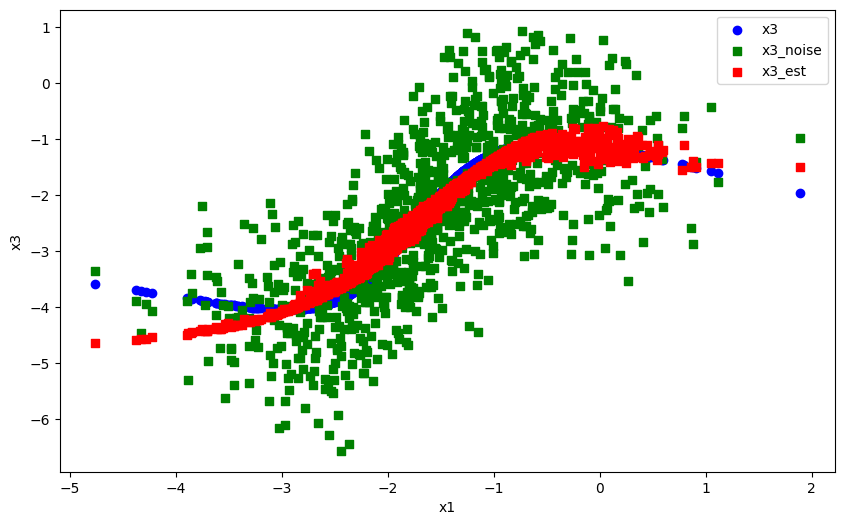

The programm is closed


In [103]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X_true.detach().numpy()[:, 0], X.detach().numpy()[:, 2], label='x3', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X_true.detach().numpy()[:, 0], X_true.detach().numpy()[:, 2], label='x3_noise', color='green', marker='s') 
plt.scatter(X_true.detach().numpy()[:, 0], x_est.detach().numpy()[:, 2], label='x3_est', color='red', marker='s') 
plt.xlabel('x1')
plt.ylabel('x3')
plt.legend()
plt.show()
print("The programm is closed")

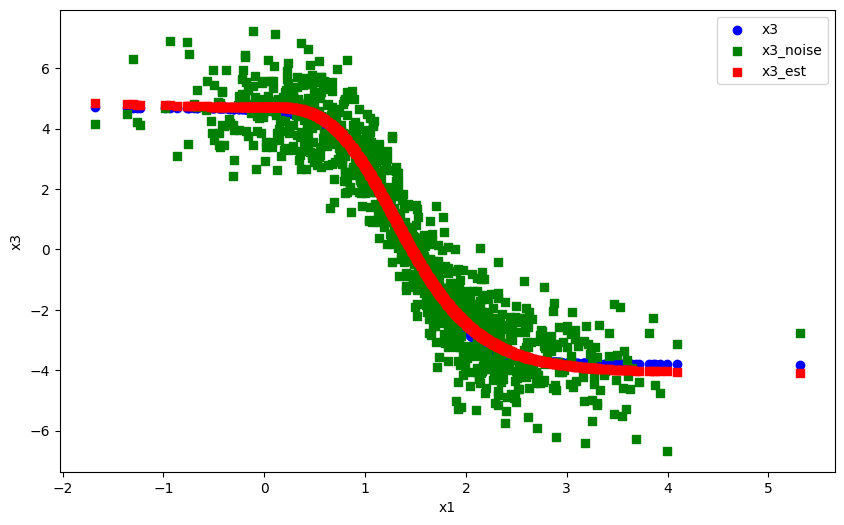

The programm is closed


In [104]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X_true.detach().numpy()[:, 3], X.detach().numpy()[:, 1], label='x3', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X_true.detach().numpy()[:, 3], X_true.detach().numpy()[:, 1], label='x3_noise', color='green', marker='s') 
plt.scatter(X_true.detach().numpy()[:, 3], x_est.detach().numpy()[:, 1], label='x3_est', color='red', marker='s') 
plt.xlabel('x1')
plt.ylabel('x3')
plt.legend()
plt.show()
print("The programm is closed")

In [105]:
eq_model = nonlinear.DagmaMLP(
    dims=[d, 10, 1], bias=True, dtype=torch.double)
model = nonlinear.DagmaNonlinear(
    eq_model, dtype=torch.double, use_mse_loss=True)

W_est_dagma, X_est = model.fit(X_true, lambda1=2e-2, lambda2=0.005,
                        T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

100%|██████████| 80000/80000 [00:18<00:00, 4352.26it/s]


In [106]:
print("W_est_dagma", W_est_dagma)

W_est_dagma [[0.02989583 0.97319351 0.73744927 0.16917987]
 [0.00961461 0.05531868 0.02626548 0.01395712]
 [0.04645083 0.02494033 0.05631158 0.1218507 ]
 [0.33153866 2.90123253 0.07303495 0.03581881]]


In [107]:
fc1_weight = eq_model.fc1.weight
fc1_bias = eq_model.fc1.bias
fc2_weight = eq_model.fc2[0].weight
fc2_bias = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
eq_model.fc1.weight = fc1_weight
eq_model.fc1.bias = fc1_bias
eq_model.fc2[0].weight = fc2_weight
eq_model.fc2[0].bias = fc2_bias

W_est_dce_no_thresh, W2, x_est = model.fit(X_true, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=5, warm_iter=7000, max_iter=8000)

  3%|▎         | 1015/36000 [00:12<06:32, 89.22it/s]

Sigma:  tensor([[ 0.6865,  0.1470, -0.0805,  0.1921],
        [ 0.1470,  0.7026, -0.0112,  0.0011],
        [-0.0805, -0.0112,  1.0602, -0.0116],
        [ 0.1921,  0.0011, -0.0116,  0.7345]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000,  0.1470, -0.0805,  0.1921],
        [ 0.1470,  0.0000, -0.0112,  0.0011],
        [-0.0805, -0.0112,  0.0000, -0.0116],
        [ 0.1921,  0.0011, -0.0116,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.4577, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5862, grad_fn=<AddBackward0>)
h_val:  tensor(0.1989, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0461, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.9887e-10, -5.6403e-02,  1.3247e-01,  9.7506e-02],
        [ 9.3911e-01,  4.8904e-10,  6.8641e-05, -3.6591e+00],
        [ 9.7992e-01, -5.8918e-03,  2.7882e-10,  1.8021e-05],
        [ 2.9016e-02, -9.1135e-02,  5.4924e-02,  1.4498e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1436e-21, 6.1382e-04, 1.9598e-03, 2.4878e-03],


  6%|▌         | 2019/36000 [00:23<06:14, 90.76it/s]

Sigma:  tensor([[ 0.4773,  0.1892, -0.2483,  0.2997],
        [ 0.1892,  0.5555,  0.0428,  0.0118],
        [-0.2483,  0.0428,  0.9379,  0.0083],
        [ 0.2997,  0.0118,  0.0083,  0.7241]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000,  0.1892, -0.2483,  0.2997],
        [ 0.1892,  0.0000,  0.0428,  0.0118],
        [-0.2483,  0.0428,  0.0000,  0.0083],
        [ 0.2997,  0.0118,  0.0083,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(1.7115, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7035, grad_fn=<AddBackward0>)
h_val:  tensor(0.3944, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0408, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.7234e-10, -4.8765e-02,  2.8468e-01,  1.2633e-05],
        [ 7.9234e-01,  6.9554e-10,  5.4207e-05, -3.5550e+00],
        [ 1.0894e+00, -8.6179e-04,  3.8323e-10,  3.8872e-06],
        [ 1.0789e-04, -9.8208e-02,  8.3318e-04,  1.9670e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0021e-20, 2.6616e-03, 7.6849e-03, 2.6792e-03],


  8%|▊         | 3010/36000 [00:34<05:59, 91.82it/s]

Sigma:  tensor([[ 0.3571,  0.0590, -0.3492,  0.2596],
        [ 0.0590,  0.4201, -0.0029,  0.0103],
        [-0.3492, -0.0029,  0.7702,  0.0118],
        [ 0.2596,  0.0103,  0.0118,  0.6813]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000,  0.0590, -0.3492,  0.2596],
        [ 0.0590,  0.0000, -0.0029,  0.0103],
        [-0.3492, -0.0029,  0.0000,  0.0118],
        [ 0.2596,  0.0103,  0.0118,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(1.1736, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3128, grad_fn=<AddBackward0>)
h_val:  tensor(0.7976, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0465, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 5.8791e-10, -6.5559e-03,  4.5439e-01,  1.2556e-02],
        [ 9.8262e-01,  8.7496e-10,  6.6815e-05, -3.6578e+00],
        [ 1.1871e+00,  1.1007e-05,  6.6283e-10,  1.0261e-05],
        [ 4.4283e-05, -1.0184e-01,  1.0866e-05,  1.5889e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.9301e-20, 4.1444e-03, 2.2775e-02, 4.3570e-03],

 11%|█         | 4018/36000 [00:45<05:53, 90.49it/s]

Sigma:  tensor([[ 0.3000,  0.0094, -0.3825,  0.1694],
        [ 0.0094,  0.3422, -0.0161,  0.0078],
        [-0.3825, -0.0161,  0.7165, -0.0020],
        [ 0.1694,  0.0078, -0.0020,  0.5157]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000,  0.0094, -0.3825,  0.1694],
        [ 0.0094,  0.0000, -0.0161,  0.0078],
        [-0.3825, -0.0161,  0.0000, -0.0020],
        [ 0.1694,  0.0078, -0.0020,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.6612, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.3590, grad_fn=<AddBackward0>)
h_val:  tensor(1.2440, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0530, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 8.5120e-10,  6.0105e-03,  5.1502e-01,  4.3945e-02],
        [ 1.2236e+00,  9.6870e-10,  6.0111e-05, -3.8190e+00],
        [ 1.2945e+00,  1.0743e-02,  1.0497e-09,  2.3196e-05],
        [ 2.6189e-05, -1.1266e-01,  2.7598e-05,  2.0412e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.3443e-19, 3.3165e-03, 2.5773e-02, 6.7049e-03],

 14%|█▍        | 5016/36000 [00:56<05:44, 90.02it/s]

Sigma:  tensor([[ 0.2575, -0.0174, -0.3857,  0.1227],
        [-0.0174,  0.3190, -0.0226,  0.0040],
        [-0.3857, -0.0226,  0.7143,  0.0243],
        [ 0.1227,  0.0040,  0.0243,  0.5555]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0174, -0.3857,  0.1227],
        [-0.0174,  0.0000, -0.0226,  0.0040],
        [-0.3857, -0.0226,  0.0000,  0.0243],
        [ 0.1227,  0.0040,  0.0243,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.1365, grad_fn=<AddBackward0>)
mle loss:  tensor(-2.3713, grad_fn=<AddBackward0>)
h_val:  tensor(1.5034, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0735, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.0794e-09,  3.9644e-02,  5.3922e-01,  1.5396e-01],
        [ 1.4458e+00,  9.9836e-10,  5.5290e-06, -3.9897e+00],
        [ 1.3811e+00,  4.6083e-02,  1.5880e-09,  2.0548e-06],
        [-2.8556e-05, -1.0118e-01, -1.0446e-05,  1.7403e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.6055e-19, 9.4679e-03, 1.8807e-02, 1.1623e-02],

 17%|█▋        | 6011/36000 [01:08<05:28, 91.19it/s]

Sigma:  tensor([[ 0.2407, -0.0244, -0.3849,  0.1033],
        [-0.0244,  0.3287, -0.0234,  0.0051],
        [-0.3849, -0.0234,  0.7077,  0.0082],
        [ 0.1033,  0.0051,  0.0082,  0.5387]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0244, -0.3849,  0.1033],
        [-0.0244,  0.0000, -0.0234,  0.0051],
        [-0.3849, -0.0234,  0.0000,  0.0082],
        [ 0.1033,  0.0051,  0.0082,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(-0.4941, grad_fn=<AddBackward0>)
mle loss:  tensor(-3.1899, grad_fn=<AddBackward0>)
h_val:  tensor(1.6531, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0764, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.2177e-09,  5.6146e-02,  5.4224e-01,  2.0786e-01],
        [ 1.5370e+00,  1.1001e-09, -3.5294e-05, -4.0585e+00],
        [ 1.4268e+00,  5.3199e-02,  1.9378e-09, -8.8951e-05],
        [ 2.6391e-05, -9.4169e-02, -4.9241e-06,  1.3107e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.1705e-19, 1.1648e-02, 1.6593e-02, 3.4063e-02]

 22%|██▏       | 8011/36000 [01:31<05:08, 90.73it/s]

Sigma:  tensor([[ 0.1605, -0.0282, -0.2634,  0.0635],
        [-0.0282,  0.4651, -0.1721, -0.0021],
        [-0.2634, -0.1721,  0.6074,  0.0486],
        [ 0.0635, -0.0021,  0.0486,  0.4677]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0282, -0.2634,  0.0635],
        [-0.0282,  0.0000, -0.1721, -0.0021],
        [-0.2634, -0.1721,  0.0000,  0.0486],
        [ 0.0635, -0.0021,  0.0486,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.5855, grad_fn=<AddBackward0>)
mle loss:  tensor(-1.2388, grad_fn=<AddBackward0>)
h_val:  tensor(0.5162, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1626, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.1679e-09,  1.2225e-01,  4.4114e-01,  5.9284e-01],
        [ 1.7387e+00,  3.0832e-09,  2.8192e-01, -4.2618e+00],
        [ 1.0898e+00,  1.1604e-01,  3.2665e-09,  6.4102e-02],
        [ 4.9295e-05, -2.7294e-02,  4.3561e-05,  2.1080e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.2126e-19, 5.4867e-03, 1.5681e-02, 1.4796e-01],

 25%|██▌       | 9013/36000 [01:43<04:53, 91.94it/s]

Sigma:  tensor([[ 1.3989e-01, -3.5373e-02, -2.2461e-01,  4.8543e-02],
        [-3.5373e-02,  5.1159e-01, -2.3353e-01, -4.4230e-04],
        [-2.2461e-01, -2.3353e-01,  6.2160e-01,  1.1342e-01],
        [ 4.8543e-02, -4.4230e-04,  1.1342e-01,  5.6851e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0354, -0.2246,  0.0485],
        [-0.0354,  0.0000, -0.2335, -0.0004],
        [-0.2246, -0.2335,  0.0000,  0.1134],
        [ 0.0485, -0.0004,  0.1134,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.4582, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9982, grad_fn=<AddBackward0>)
h_val:  tensor(0.3833, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1435, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.7438e-09,  1.5014e-01,  4.0467e-01,  7.8666e-01],
        [ 1.7725e+00,  2.8794e-09,  3.3970e-01, -4.3543e+00],
        [ 9.3626e-01,  1.3077e-01,  2.4127e-09,  4.3820e-02],
        [ 3.5708e-05, -1.9834e-02,  5.9127e-07,  2.0649e-10]],
       grad_fn=<MeanBackward1>)
ob

 28%|██▊       | 10012/36000 [01:54<04:48, 90.08it/s]

Sigma:  tensor([[ 1.2876e-01, -3.7331e-02, -2.0633e-01,  5.3509e-02],
        [-3.7331e-02,  4.9076e-01, -2.5567e-01,  5.2415e-04],
        [-2.0633e-01, -2.5567e-01,  6.5128e-01,  1.2589e-01],
        [ 5.3509e-02,  5.2415e-04,  1.2589e-01,  6.1940e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0373, -0.2063,  0.0535],
        [-0.0373,  0.0000, -0.2557,  0.0005],
        [-0.2063, -0.2557,  0.0000,  0.1259],
        [ 0.0535,  0.0005,  0.1259,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.4199, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9768, grad_fn=<AddBackward0>)
h_val:  tensor(0.3496, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1368, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.5539e-09,  1.7378e-01,  3.5799e-01,  8.9757e-01],
        [ 1.6766e+00,  2.8989e-09,  3.7168e-01, -4.3322e+00],
        [ 9.3940e-01,  1.3002e-01,  2.2308e-09,  1.5698e-02],
        [ 1.2962e-05, -1.7432e-02, -5.5440e-06,  2.2614e-10]],
       grad_fn=<MeanBackward1>)
ob

 31%|███       | 11013/36000 [02:06<04:35, 90.54it/s]

Sigma:  tensor([[ 0.1174, -0.0398, -0.1852,  0.0604],
        [-0.0398,  0.4681, -0.2673,  0.0011],
        [-0.1852, -0.2673,  0.6617,  0.1178],
        [ 0.0604,  0.0011,  0.1178,  0.6299]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0398, -0.1852,  0.0604],
        [-0.0398,  0.0000, -0.2673,  0.0011],
        [-0.1852, -0.2673,  0.0000,  0.1178],
        [ 0.0604,  0.0011,  0.1178,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.4092, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.9285, grad_fn=<AddBackward0>)
h_val:  tensor(0.3278, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1433, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.4374e-09,  1.9175e-01,  3.1493e-01,  9.6400e-01],
        [ 1.5648e+00,  2.7907e-09,  3.8703e-01, -4.2815e+00],
        [ 9.9052e-01,  1.2435e-01,  2.1819e-09,  9.5525e-05],
        [ 6.2732e-05, -1.7049e-02, -2.5149e-05,  2.4317e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.1521e-19, 8.1889e-03, 1.1477e-02, 3.0287e-01],

 33%|███▎      | 12013/36000 [02:17<04:27, 89.65it/s]

Sigma:  tensor([[ 0.1102, -0.0402, -0.1679,  0.0600],
        [-0.0402,  0.4360, -0.2723,  0.0013],
        [-0.1679, -0.2723,  0.6708,  0.1071],
        [ 0.0600,  0.0013,  0.1071,  0.6182]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0402, -0.1679,  0.0600],
        [-0.0402,  0.0000, -0.2723,  0.0013],
        [-0.1679, -0.2723,  0.0000,  0.1071],
        [ 0.0600,  0.0013,  0.1071,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.3983, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.6390, grad_fn=<AddBackward0>)
h_val:  tensor(0.2886, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1431, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.2638e-09,  2.0221e-01,  2.8126e-01,  1.0107e+00],
        [ 1.4613e+00,  2.5751e-09,  3.8244e-01, -4.2299e+00],
        [ 1.0064e+00,  1.0975e-01,  2.0035e-09,  2.3084e-05],
        [ 8.2575e-05, -1.7175e-02,  5.5573e-05,  2.5926e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[2.1700e-19, 9.9956e-03, 8.3729e-03, 3.5556e-01],

 36%|███▌      | 13017/36000 [02:28<04:13, 90.73it/s]

Sigma:  tensor([[ 0.1157, -0.0342, -0.1481,  0.0422],
        [-0.0342,  0.3833, -0.2675,  0.0009],
        [-0.1481, -0.2675,  0.7004,  0.0922],
        [ 0.0422,  0.0009,  0.0922,  0.5981]], grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000, -0.0342, -0.1481,  0.0422],
        [-0.0342,  0.0000, -0.2675,  0.0009],
        [-0.1481, -0.2675,  0.0000,  0.0922],
        [ 0.0422,  0.0009,  0.0922,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.3427, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2909, grad_fn=<AddBackward0>)
h_val:  tensor(0.1760, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1087, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 7.9428e-10,  1.7714e-01,  2.3378e-01,  9.9863e-01],
        [ 1.3542e+00,  1.7833e-09,  3.3012e-01, -4.1584e+00],
        [ 9.2507e-01,  5.3189e-02,  1.4652e-09,  6.4685e-05],
        [ 1.3086e-02, -1.7037e-02,  2.6980e-03,  2.8445e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[8.4716e-20, 1.1419e-02, 6.3012e-03, 3.7390e-01],


 42%|████▏     | 15015/36000 [02:50<03:51, 90.69it/s]

Sigma:  tensor([[ 1.7324e-01,  6.3479e-03, -3.5864e-02,  8.8768e-04],
        [ 6.3479e-03,  3.1565e-01, -1.5264e-01, -3.3179e-06],
        [-3.5864e-02, -1.5264e-01,  6.0076e-01,  6.9662e-03],
        [ 8.8768e-04, -3.3179e-06,  6.9662e-03,  8.6992e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  6.3479e-03, -3.5864e-02,  8.8768e-04],
        [ 6.3479e-03,  0.0000e+00, -1.5264e-01, -3.3179e-06],
        [-3.5864e-02, -1.5264e-01,  0.0000e+00,  6.9662e-03],
        [ 8.8768e-04, -3.3179e-06,  6.9662e-03,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0326, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1941, grad_fn=<AddBackward0>)
h_val:  tensor(0.0041, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0407, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.9609e-10,  2.3933e-02,  2.0475e-02,  7.8447e-01],
        [ 1.1002e+00,  7.6522e-10,  1.5453e-01, -3.8466e+00],
        [ 9.2318e-01, -1.0751e-04,  1.0785e-09, -1.6028e-05],
        [ 1.2863e-03, -1.53

 44%|████▍     | 16013/36000 [03:03<04:07, 80.61it/s]

Sigma:  tensor([[ 2.3609e-01,  6.0904e-03, -2.7339e-03,  1.0453e-03],
        [ 6.0904e-03,  3.2963e-01, -1.0714e-01, -7.5262e-06],
        [-2.7339e-03, -1.0714e-01,  6.8515e-01,  2.9113e-03],
        [ 1.0453e-03, -7.5262e-06,  2.9113e-03,  9.4892e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  6.0904e-03, -2.7339e-03,  1.0453e-03],
        [ 6.0904e-03,  0.0000e+00, -1.0714e-01, -7.5262e-06],
        [-2.7339e-03, -1.0714e-01,  0.0000e+00,  2.9113e-03],
        [ 1.0453e-03, -7.5262e-06,  2.9113e-03,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0270, grad_fn=<AddBackward0>)
mle loss:  tensor(1.9447, grad_fn=<AddBackward0>)
h_val:  tensor(0.0013, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0394, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.6754e-10,  1.2929e-02,  1.0048e-02,  7.6983e-01],
        [ 1.1060e+00,  6.5841e-10,  8.0164e-02, -3.8020e+00],
        [ 9.8072e-01, -2.7876e-05,  7.3214e-10, -1.0620e-05],
        [ 2.1847e-03, -1.29

 47%|████▋     | 17017/36000 [03:15<03:52, 81.79it/s]

Sigma:  tensor([[ 2.8855e-01,  5.2325e-03, -1.0679e-03,  8.3842e-04],
        [ 5.2325e-03,  3.3038e-01, -5.9801e-02, -1.1871e-05],
        [-1.0679e-03, -5.9801e-02,  8.1030e-01,  1.3990e-03],
        [ 8.3842e-04, -1.1871e-05,  1.3990e-03,  9.5343e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  5.2325e-03, -1.0679e-03,  8.3842e-04],
        [ 5.2325e-03,  0.0000e+00, -5.9801e-02, -1.1871e-05],
        [-1.0679e-03, -5.9801e-02,  0.0000e+00,  1.3990e-03],
        [ 8.3842e-04, -1.1871e-05,  1.3990e-03,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0247, grad_fn=<AddBackward0>)
mle loss:  tensor(1.8287, grad_fn=<AddBackward0>)
h_val:  tensor(0.0008, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0326, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.9820e-10,  8.2744e-03,  6.8687e-03,  7.6932e-01],
        [ 1.1541e+00,  6.5655e-10,  1.2387e-02, -3.7867e+00],
        [ 1.0032e+00, -6.9568e-05,  5.0854e-10, -6.9888e-06],
        [ 3.4077e-03, -1.29

 50%|█████     | 18008/36000 [03:27<04:04, 73.68it/s]

Sigma:  tensor([[ 3.1936e-01,  2.6634e-03, -1.0209e-03,  7.7746e-04],
        [ 2.6634e-03,  3.1600e-01, -1.2165e-02, -1.4643e-05],
        [-1.0209e-03, -1.2165e-02,  9.3243e-01,  1.0842e-03],
        [ 7.7746e-04, -1.4643e-05,  1.0842e-03,  9.5305e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  2.6634e-03, -1.0209e-03,  7.7746e-04],
        [ 2.6634e-03,  0.0000e+00, -1.2165e-02, -1.4643e-05],
        [-1.0209e-03, -1.2165e-02,  0.0000e+00,  1.0842e-03],
        [ 7.7746e-04, -1.4643e-05,  1.0842e-03,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0218, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7415, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0150, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.6861e-10,  5.7542e-03,  5.3221e-03,  7.6808e-01],
        [ 1.2513e+00,  6.3686e-10,  7.4458e-06, -3.8559e+00],
        [ 9.9791e-01, -1.2257e-04,  3.6324e-10, -4.0073e-05],
        [ 4.1201e-03, -1.24

 53%|█████▎    | 19010/36000 [03:38<03:06, 91.07it/s]

Sigma:  tensor([[ 3.2956e-01,  9.1406e-04, -8.0255e-04,  7.2596e-04],
        [ 9.1406e-04,  3.0843e-01, -9.0530e-04, -1.1112e-05],
        [-8.0255e-04, -9.0530e-04,  1.0118e+00,  9.1199e-04],
        [ 7.2596e-04, -1.1112e-05,  9.1199e-04,  9.5338e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  9.1406e-04, -8.0255e-04,  7.2596e-04],
        [ 9.1406e-04,  0.0000e+00, -9.0530e-04, -1.1112e-05],
        [-8.0255e-04, -9.0530e-04,  0.0000e+00,  9.1199e-04],
        [ 7.2596e-04, -1.1112e-05,  9.1199e-04,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0201, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7060, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0020, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.6247e-10,  4.6784e-03,  4.6059e-03,  7.6959e-01],
        [ 1.3341e+00,  5.5646e-10, -7.2884e-06, -3.9228e+00],
        [ 9.9047e-01, -4.1292e-05,  2.8181e-10, -2.0038e-05],
        [ 4.3949e-03, -1.20

 56%|█████▌    | 20013/36000 [03:50<02:59, 89.23it/s]

Sigma:  tensor([[ 3.3025e-01,  9.1063e-04, -6.8015e-04,  6.6873e-04],
        [ 9.1063e-04,  3.0792e-01,  4.6518e-05, -1.1552e-05],
        [-6.8015e-04,  4.6518e-05,  1.0312e+00,  7.0422e-04],
        [ 6.6873e-04, -1.1552e-05,  7.0422e-04,  9.5332e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  9.1063e-04, -6.8015e-04,  6.6873e-04],
        [ 9.1063e-04,  0.0000e+00,  4.6518e-05, -1.1552e-05],
        [-6.8015e-04,  4.6518e-05,  0.0000e+00,  7.0422e-04],
        [ 6.6873e-04, -1.1552e-05,  7.0422e-04,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0198, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6919, grad_fn=<AddBackward0>)
h_val:  tensor(0.0003, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0019, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.6370e-10,  4.5756e-03,  4.2865e-03,  7.7299e-01],
        [ 1.3344e+00,  5.5486e-10, -2.0711e-06, -3.9227e+00],
        [ 9.8698e-01, -9.7101e-05,  2.3750e-10, -1.1133e-06],
        [ 4.4723e-03, -1.20

 61%|██████    | 22010/36000 [04:12<02:34, 90.82it/s]

Sigma:  tensor([[ 3.3769e-01,  7.8415e-05, -3.1504e-05,  1.3783e-04],
        [ 7.8415e-05,  3.0744e-01,  3.7753e-04,  6.3852e-07],
        [-3.1504e-05,  3.7753e-04,  1.0126e+00,  8.8685e-05],
        [ 1.3783e-04,  6.3852e-07,  8.8685e-05,  9.7809e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  7.8415e-05, -3.1504e-05,  1.3783e-04],
        [ 7.8415e-05,  0.0000e+00,  3.7753e-04,  6.3852e-07],
        [-3.1504e-05,  3.7753e-04,  0.0000e+00,  8.8685e-05],
        [ 1.3783e-04,  6.3852e-07,  8.8685e-05,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0021, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7233, grad_fn=<AddBackward0>)
h_val:  tensor(5.8676e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0078, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.0031e-10,  3.9675e-04,  2.2928e-04,  7.5305e-01],
        [ 1.3362e+00,  4.9373e-10, -7.5085e-07, -3.9252e+00],
        [ 9.7219e-01,  5.2060e-05,  2.0334e-10, -3.9424e-07],
        [ 1.8120e-04, -

 64%|██████▍   | 23010/36000 [04:23<02:24, 89.95it/s]

Sigma:  tensor([[ 3.3937e-01,  1.0560e-04, -2.9699e-05,  2.5812e-04],
        [ 1.0560e-04,  3.0770e-01,  2.8737e-04, -1.2310e-06],
        [-2.9699e-05,  2.8737e-04,  1.0120e+00,  1.2414e-04],
        [ 2.5812e-04, -1.2310e-06,  1.2414e-04,  9.7862e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  1.0560e-04, -2.9699e-05,  2.5812e-04],
        [ 1.0560e-04,  0.0000e+00,  2.8737e-04, -1.2310e-06],
        [-2.9699e-05,  2.8737e-04,  0.0000e+00,  1.2414e-04],
        [ 2.5812e-04, -1.2310e-06,  1.2414e-04,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0021, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7282, grad_fn=<AddBackward0>)
h_val:  tensor(4.3675e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0124, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.6126e-10,  2.2471e-04,  4.4732e-04,  7.3592e-01],
        [ 1.3308e+00,  5.4300e-10,  3.1232e-05, -3.9199e+00],
        [ 9.6805e-01, -4.1151e-06,  2.1543e-10, -1.4753e-06],
        [ 2.0465e-04, -

 67%|██████▋   | 24017/36000 [04:35<02:12, 90.16it/s]

Sigma:  tensor([[ 3.4020e-01,  1.1046e-04, -2.9779e-05,  2.9911e-04],
        [ 1.1046e-04,  3.0787e-01,  2.7887e-04, -1.3562e-06],
        [-2.9779e-05,  2.7887e-04,  1.0094e+00,  1.1751e-04],
        [ 2.9911e-04, -1.3562e-06,  1.1751e-04,  9.7891e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  1.1046e-04, -2.9779e-05,  2.9911e-04],
        [ 1.1046e-04,  0.0000e+00,  2.7887e-04, -1.3562e-06],
        [-2.9779e-05,  2.7887e-04,  0.0000e+00,  1.1751e-04],
        [ 2.9911e-04, -1.3562e-06,  1.1751e-04,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7288, grad_fn=<AddBackward0>)
h_val:  tensor(3.2156e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0151, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.7302e-10,  1.8409e-04,  4.7349e-04,  7.2964e-01],
        [ 1.3276e+00,  5.4975e-10,  6.7785e-05, -3.9168e+00],
        [ 9.6968e-01, -3.7344e-06,  2.0871e-10,  3.1959e-05],
        [ 3.0428e-04, -

 69%|██████▉   | 25017/36000 [04:46<02:04, 88.49it/s]

Sigma:  tensor([[ 3.4077e-01,  1.1024e-04, -3.2737e-05,  3.2356e-04],
        [ 1.1024e-04,  3.0793e-01,  2.5605e-04, -1.5497e-06],
        [-3.2737e-05,  2.5605e-04,  1.0052e+00,  9.9284e-05],
        [ 3.2356e-04, -1.5497e-06,  9.9284e-05,  9.7904e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  1.1024e-04, -3.2737e-05,  3.2356e-04],
        [ 1.1024e-04,  0.0000e+00,  2.5605e-04, -1.5497e-06],
        [-3.2737e-05,  2.5605e-04,  0.0000e+00,  9.9284e-05],
        [ 3.2356e-04, -1.5497e-06,  9.9284e-05,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7267, grad_fn=<AddBackward0>)
h_val:  tensor(2.2064e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0175, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.8090e-10,  1.7750e-04,  4.8046e-04,  7.2591e-01],
        [ 1.3271e+00,  5.4952e-10, -2.8451e-05, -3.9162e+00],
        [ 9.7435e-01, -6.1718e-07,  1.9956e-10,  1.9645e-05],
        [ 4.1847e-04, -

 72%|███████▏  | 26013/36000 [04:57<01:54, 87.54it/s]

Sigma:  tensor([[ 3.4126e-01,  1.0833e-04, -3.5386e-05,  3.4301e-04],
        [ 1.0833e-04,  3.0795e-01,  1.9890e-04, -1.4974e-06],
        [-3.5386e-05,  1.9890e-04,  9.9948e-01,  8.1763e-05],
        [ 3.4301e-04, -1.4974e-06,  8.1763e-05,  9.7911e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  1.0833e-04, -3.5386e-05,  3.4301e-04],
        [ 1.0833e-04,  0.0000e+00,  1.9890e-04, -1.4974e-06],
        [-3.5386e-05,  1.9890e-04,  0.0000e+00,  8.1763e-05],
        [ 3.4301e-04, -1.4974e-06,  8.1763e-05,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7226, grad_fn=<AddBackward0>)
h_val:  tensor(1.4571e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0196, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.8717e-10,  1.7668e-04,  4.8749e-04,  7.2300e-01],
        [ 1.3276e+00,  5.4294e-10, -5.2253e-05, -3.9164e+00],
        [ 9.7914e-01, -9.0050e-06,  1.8905e-10,  3.1859e-05],
        [ 4.8368e-04, -

 75%|███████▌  | 27012/36000 [05:09<01:43, 86.67it/s]

Sigma:  tensor([[ 3.4160e-01,  1.0716e-04, -3.6267e-05,  3.5586e-04],
        [ 1.0716e-04,  3.0795e-01,  4.3411e-05, -1.5693e-06],
        [-3.6267e-05,  4.3411e-05,  9.9205e-01,  7.0349e-05],
        [ 3.5586e-04, -1.5693e-06,  7.0349e-05,  9.7914e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  1.0716e-04, -3.6267e-05,  3.5586e-04],
        [ 1.0716e-04,  0.0000e+00,  4.3411e-05, -1.5693e-06],
        [-3.6267e-05,  4.3411e-05,  0.0000e+00,  7.0349e-05],
        [ 3.5586e-04, -1.5693e-06,  7.0349e-05,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0022, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7162, grad_fn=<AddBackward0>)
h_val:  tensor(1.0159e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0209, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.9007e-10,  1.7832e-04,  4.8924e-04,  7.2113e-01],
        [ 1.3278e+00,  5.3290e-10,  1.3018e-04, -3.9164e+00],
        [ 9.8283e-01, -4.2058e-05,  1.7750e-10,  8.5979e-06],
        [ 4.9758e-04, -

 81%|████████  | 29017/36000 [05:31<01:16, 90.85it/s]

Sigma:  tensor([[ 3.3839e-01, -1.7762e-06, -1.5589e-06,  5.6232e-05],
        [-1.7762e-06,  3.0636e-01,  3.0861e-04, -1.5437e-06],
        [-1.5589e-06,  3.0861e-04,  9.8192e-01, -9.1961e-06],
        [ 5.6232e-05, -1.5437e-06, -9.1961e-06,  9.8154e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00, -1.7762e-06, -1.5589e-06,  5.6232e-05],
        [-1.7762e-06,  0.0000e+00,  3.0861e-04, -1.5437e-06],
        [-1.5589e-06,  3.0861e-04,  0.0000e+00, -9.1961e-06],
        [ 5.6232e-05, -1.5437e-06, -9.1961e-06,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0002, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7039, grad_fn=<AddBackward0>)
h_val:  tensor(6.6743e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0200, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 8.8962e-10,  1.0020e-04, -1.7584e-05,  7.3566e-01],
        [ 1.3363e+00,  2.9557e-09,  1.7901e-05, -3.9270e+00],
        [ 9.8059e-01, -4.0004e-03,  1.1375e-09,  1.4538e-04],
        [ 9.6864e-05, -

 83%|████████▎ | 30017/36000 [05:43<01:06, 90.62it/s]

Sigma:  tensor([[ 3.4054e-01,  9.4665e-06, -3.4045e-06,  2.8562e-05],
        [ 9.4665e-06,  3.0735e-01, -5.3729e-05, -1.1305e-07],
        [-3.4045e-06, -5.3729e-05,  9.8259e-01,  6.8807e-06],
        [ 2.8562e-05, -1.1305e-07,  6.8807e-06,  9.8193e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  9.4665e-06, -3.4045e-06,  2.8562e-05],
        [ 9.4665e-06,  0.0000e+00, -5.3729e-05, -1.1305e-07],
        [-3.4045e-06, -5.3729e-05,  0.0000e+00,  6.8807e-06],
        [ 2.8562e-05, -1.1305e-07,  6.8807e-06,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0002, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7060, grad_fn=<AddBackward0>)
h_val:  tensor(6.0959e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0200, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.2625e-10,  4.2375e-05,  2.6745e-05,  7.3306e-01],
        [ 1.3351e+00,  5.9981e-10, -1.1360e-05, -3.9243e+00],
        [ 9.8392e-01,  1.6353e-05,  1.8912e-10,  1.0648e-06],
        [ 2.0178e-05, -

100%|██████████| 36000/36000 [05:54<00:00, 101.55it/s]

Sigma:  tensor([[ 3.4115e-01,  9.8498e-06, -3.2048e-06,  3.0224e-05],
        [ 9.8498e-06,  3.0757e-01, -6.8779e-05, -1.3485e-07],
        [-3.2048e-06, -6.8779e-05,  9.8245e-01,  7.5022e-06],
        [ 3.0224e-05, -1.3485e-07,  7.5022e-06,  9.8198e-01]],
       grad_fn=<MmBackward0>)
W2:  tensor([[ 0.0000e+00,  9.8498e-06, -3.2048e-06,  3.0224e-05],
        [ 9.8498e-06,  0.0000e+00, -6.8779e-05, -1.3485e-07],
        [-3.2048e-06, -6.8779e-05,  0.0000e+00,  7.5022e-06],
        [ 3.0224e-05, -1.3485e-07,  7.5022e-06,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0002, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7071, grad_fn=<AddBackward0>)
h_val:  tensor(5.7000e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0205, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.4478e-10,  2.9144e-05,  3.9770e-05,  7.3053e-01],
        [ 1.3333e+00,  5.0908e-10,  5.4632e-06, -3.9217e+00],
        [ 9.8273e-01, -3.4953e-06,  1.6779e-10, -4.1558e-06],
        [ 2.0787e-05, -

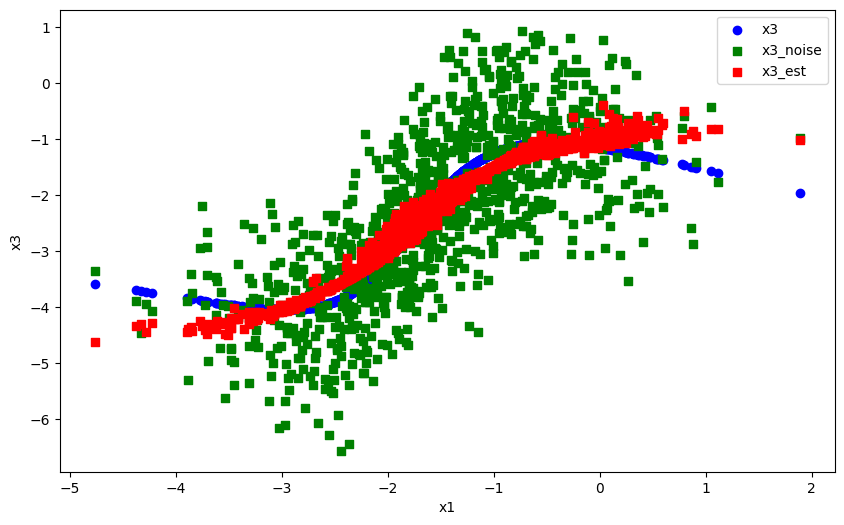

The programm is closed


In [109]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X_true.detach().numpy()[:, 0], X.detach().numpy()[:, 2], label='x3', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X_true.detach().numpy()[:, 0], X_true.detach().numpy()[:, 2], label='x3_noise', color='green', marker='s') 
plt.scatter(X_true.detach().numpy()[:, 0], x_est.detach().numpy()[:, 2], label='x3_est', color='red', marker='s') 
plt.xlabel('x1')
plt.ylabel('x3')
plt.legend()
plt.show()
print("The programm is closed")

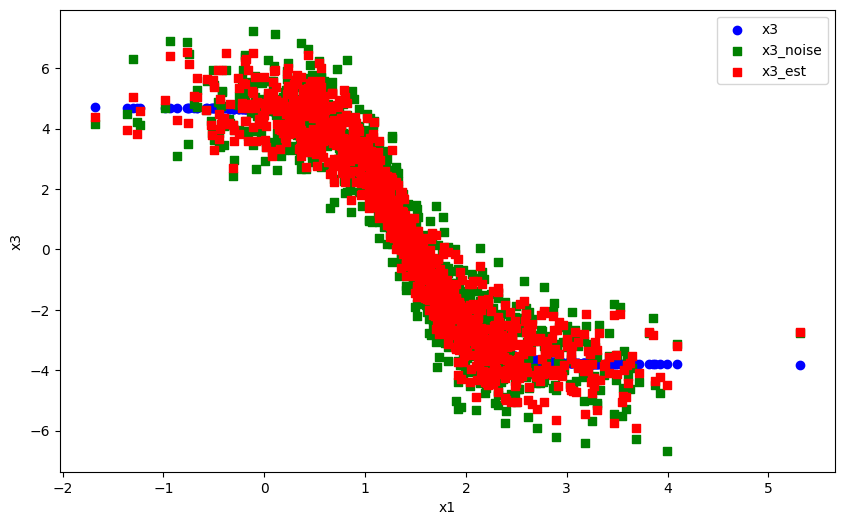

The programm is closed


In [110]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size
plt.scatter(X_true.detach().numpy()[:, 3], X.detach().numpy()[:, 1], label='x3', color='blue', marker='o')  # Plot x vs. y1
plt.scatter(X_true.detach().numpy()[:, 3], X_true.detach().numpy()[:, 1], label='x3_noise', color='green', marker='s') 
plt.scatter(X_true.detach().numpy()[:, 3], x_est.detach().numpy()[:, 1], label='x3_est', color='red', marker='s') 
plt.xlabel('x1')
plt.ylabel('x3')
plt.legend()
plt.show()
print("The programm is closed")

In [ ]:
seed = 0
filename = f'__d{d}_seed{seed}'

#### Initialization problem
#### try update first mlp, then Sigma
#### try different initialization
#### print some examples in cluster to show above

In [38]:
import random

def generate_ancestral_admg(d, p_dir=0.3, p_bidir=0.1, seed=None):
    """
    Generate an ancestral ADMG: {node: {'parents': [], 'spouses': []}}
    where spouses = bidirected connections (↔).
    p_dir: probability of a directed edge
    p_bidir: probability of a bidirected edge (latent confounding)
    admg: dict mapping each node to parents and spouses
    A_dir: directed adjacency matrix
    A_bidir: bidirected adjacency matrix
    """
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    # --- Step 1: generate a DAG (acyclic directed structure)
    A_dir = np.triu((np.random.rand(d, d) < p_dir).astype(int), 1) # generate random 0/1 matrix with edge prob p_dir, keep only upper triangular part for acyclicty
    dag = {j: list(np.where(A_dir[:, j] == 1)[0]) for j in range(d)} # for each child j, take the indices i where A_dir[i, j] == 1 (i.e., it's parents)

    # --- Step 2: precompute ancestors of each node (for the ancestral constraint)
    ancestors = {j: set() for j in range(d)}
    for j in range(d):
        stack = list(dag[j])
        while stack:
            parent = stack.pop()
            ancestors[j].add(parent)
            stack.extend(dag[parent])  # recursively include higher ancestors

    # --- Step 3: generate bidirected edges that respect ancestrality
    A_bidir = np.zeros((d, d), dtype=int)
    for i in range(d):
        for j in range(i + 1, d):
            if np.random.rand() < p_bidir:
                # Check ancestral condition: i not ancestor of j, j not ancestor of i
                if i not in ancestors[j] and j not in ancestors[i]:
                    A_bidir[i, j] = A_bidir[j, i] = 1  # add bidirected edge

    # --- Step 4: return graph as dict
    admg = {
        j: {
            "parents": [int(i) for i in np.where(A_dir[:, j] == 1)[0]],
            "spouses": [int(i) for i in np.where(A_bidir[j, :] == 1)[0]],
        }
        for j in range(d)
    }
    return admg, A_dir, A_bidir

In [39]:
admg, A_dir, A_bidir = generate_ancestral_admg(d=3, p_dir=0.4, p_bidir=0.3, seed =12)
print("admg: ", admg)

admg:  {0: {'parents': [], 'spouses': [1]}, 1: {'parents': [], 'spouses': [0]}, 2: {'parents': [0], 'spouses': []}}


In [40]:
admg, A_dir, A_bidir = generate_ancestral_admg(d=4, p_dir=0.4, p_bidir=0.3, seed =2)
print("admg: ", admg)
parents = {j: admg[j]['parents'] for j in admg}
parents

admg:  {0: {'parents': [], 'spouses': []}, 1: {'parents': [0], 'spouses': []}, 2: {'parents': [1], 'spouses': [3]}, 3: {'parents': [], 'spouses': [2]}}


{0: [], 1: [0], 2: [1], 3: []}

In [41]:
def generate_layers(admg, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    bias=True
    fc1 = nn.Linear(d, d * dims[1], bias=bias) # [d * dims[1], d]
    # self.fc1.weight.bounds = self._bounds()
    mask = torch.ones(d * dims[1], d)

    for j in range(d):
        allowed_parents = admg[j]['parents']
        not_parents = [p for p in range(d) if p not in allowed_parents]
        print("j: ", j, "not_parents: ", not_parents)
        mask[j * dims[1]:(j + 1) * dims[1], not_parents] = 0.0 + 1e-6

    layers = []
    for l in range(len(dims) - 2):
        layers.append(LocallyConnected(d, dims[l + 1], dims[l + 2], bias=bias))
    fc2 = nn.ModuleList(layers)
    return fc1, fc2, mask

def forward(fc1, fc2, mask, x: torch.Tensor) -> torch.Tensor:
    """Forward pass of the sigmoidal feedforward NN

    Args:
        x (torch.Tensor): input

    Returns:
        torch.Tensor: output
    """
    # x = self.fc1(x) # [n, self.d * dims[1]]
    weight = fc1.weight*mask #[d * dims[1], d]
    x = x@(weight.T) #[n, d * dims[1]]
    if fc1.bias is not None:
        x = x + fc1.bias.unsqueeze(0)

    x = x.view(-1, dims[0], dims[1]) # [n, d, self.dims[1]]

    # self.activation = nn.SiLU()
    activation = nn.Sigmoid()

    for fc in fc2:
        # x = torch.sigmoid(x)
        x = activation(x)
        x = fc(x) # [n, d, self.dims[2]]

    x = x.squeeze(dim=2) #[n, d]

    return x

In [42]:
def scale_weights(model, factor=10):
    with torch.no_grad():
        for param in model.parameters():
            if param.ndim > 1:  # Skip bias
                param.mul_(factor)

In [43]:
import numpy as np

def generate_covariance(A_bidir, low=0.4, high=0.8, seed=None):
    """
    Generate a sparse, symmetric positive-definite covariance matrix
    whose sparsity follows A_bidir (1=nonzero).
    Correlations for nonzero entries are strong (0.4–0.8 by default).
    """
    if seed is not None:
        np.random.seed(seed)
    d = A_bidir.shape[0]

    # Step 1: random strong correlations for existing edges
    R = np.zeros((d, d))
    for i in range(d):
        for j in range(i+1, d):
            if A_bidir[i, j]:
                val = np.random.uniform(low, high)
                # Randomly flip sign for variety (optional)
                if np.random.rand() < 0.5:
                    val = -val
                R[i, j] = R[j, i] = val

    # Step 2: set diagonal to 1 temporarily
    np.fill_diagonal(R, 1.0)

    # Step 3: ensure positive definiteness
    # If smallest eigenvalue < 0, shift diagonal until PD
    eigvals = np.linalg.eigvalsh(R)
    if np.min(eigvals) <= 0:
        shift = abs(np.min(eigvals)) + 0.05  # small safety margin
        R += shift * np.eye(d)

    # Step 4: rescale diagonals to 1 again (optional normalization)
    D_inv = np.diag(1 / np.sqrt(np.diag(R)))
    Sigma = D_inv @ R @ D_inv

    # Final check
    eigvals = np.linalg.eigvalsh(Sigma)
    if np.min(eigvals) <= 0:
        # small diagonal correction if needed
        Sigma += (abs(np.min(eigvals)) + 1e-6) * np.eye(d)

    return Sigma


In [44]:
print("A_bidir: ", A_bidir)
True_Sigma = generate_covariance(A_bidir, seed=0)
True_Sigma = torch.tensor(True_Sigma)
True_Sigma

A_bidir:  [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 1]
 [0 0 1 0]]


tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.6195],
        [0.0000, 0.0000, 0.6195, 1.0000]])

In [45]:
parents

{0: [], 1: [0], 2: [1], 3: []}

In [46]:
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(parents.keys())
for j, pa in parents.items():
    G.add_edges_from((p, j) for p in pa)
order = list(nx.topological_sort(G))
print(order)

[0, 3, 1, 2]


In [47]:
torch.set_default_dtype(torch.double)
d=4
n_samples = 1000 
dims=[d, 10, 1]
np.random.seed(1)
epsilon = np.random.multivariate_normal([0] * d, True_Sigma, size=n_samples)
epsilon = torch.tensor(epsilon)
fc1, fc2, mask = generate_layers(admg, seed = 9)
scale_weights(fc1, factor=10)
for layer in fc2:
    scale_weights(layer, factor=15)

    ##################
# X = forward(fc1, fc2, mask, epsilon)
# X_true = (X+epsilon).detach()

j:  0 not_parents:  [0, 1, 2, 3]
j:  1 not_parents:  [1, 2, 3]
j:  2 not_parents:  [0, 2, 3]
j:  3 not_parents:  [0, 1, 2, 3]


/var/folders/2z/xz_b78qj3ndczchns_djsq980000gq/T/ipykernel_8745/3449987418.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  epsilon = np.random.multivariate_normal([0] * d, True_Sigma, size=n_samples)


In [48]:
def generate_from_epsilon(epsilon, fc1, fc2, mask, parents):
    """
    Generate data x from epsilon according to x = f(x_parents) + epsilon.
    
    Args:
        epsilon: [n, d] tensor of Gaussian noise
        fc1, fc2, mask: network parameters
        parents: dict {j: [parents_of_j]}
    Returns:
        x: [n, d] tensor of generated variables
    """
    n, d = epsilon.shape
    X = torch.zeros_like(epsilon)

    # Determine topological order (if not already given)
    order = list(parents.keys())  # assume already topologically sorted

    for j in order:
        if len(parents[j]) == 0:
            # root node: only noise
            X[:, j] = epsilon[:, j]
        else:
            # prepare partial input with parents filled
            x_partial = torch.zeros(n, d, dtype=epsilon.dtype)
            for p in parents[j]:
                x_partial[:, p] = X[:, p]

            # compute all f_j(x) in parallel, then pick j-th column
            f_out = forward(fc1, fc2, mask, x_partial)  # [n, d]
            X[:, j] = f_out[:, j] + epsilon[:, j]

    return X


In [49]:
X_true = generate_from_epsilon(epsilon, fc1, fc2, mask, parents).detach()
X = X_true - epsilon
X

tensor([[ 0.0000,  2.2802, 14.2488,  0.0000],
        [ 0.0000,  2.7486, 15.2914,  0.0000],
        [ 0.0000,  0.9391, 14.6166,  0.0000],
        ...,
        [ 0.0000, -3.3963,  1.8464,  0.0000],
        [ 0.0000, -5.6833,  1.6055,  0.0000],
        [ 0.0000,  2.6222, 14.9578,  0.0000]])

In [50]:
admg

{0: {'parents': [], 'spouses': []},
 1: {'parents': [0], 'spouses': []},
 2: {'parents': [1], 'spouses': [3]},
 3: {'parents': [], 'spouses': [2]}}

In [51]:
from torch.func import jacrev, vmap

def f(x_single):
    # expects x_single: shape [d]
    return forward(fc1, fc2, mask, x_single.unsqueeze(0)).squeeze(0)

# vmap over all samples
J = vmap(jacrev(f))(X_true)    # shape [n_samples, d, d]
W = torch.sqrt(torch.mean(J ** 2, axis=0).T)
W

tensor([[4.4546e-06, 3.9312e+00, 2.8263e-06, 7.6840e-06],
        [1.2274e-05, 7.7399e-06, 1.8061e+00, 2.2889e-06],
        [1.4698e-06, 2.6495e-06, 2.2781e-06, 6.7380e-06],
        [1.2364e-05, 2.7775e-06, 2.7727e-06, 2.0435e-06]],
       grad_fn=<SqrtBackward0>)

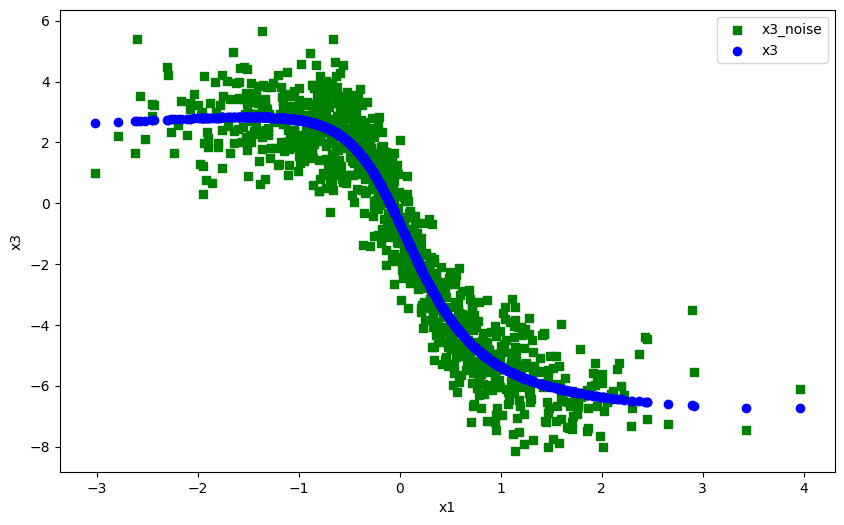

The programm is closed


In [52]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size  
plt.scatter(X_true.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='x3_noise', color='green', marker='s') 
plt.scatter(X_true.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='x3', color='blue', marker='o')
# plt.scatter(X.detach().numpy()[:, 2], x_est.detach().numpy()[:, 0], label='x3_est', color='red', marker='s') 
plt.xlabel('x1')
plt.ylabel('x3')
plt.legend()
plt.show()
print("The programm is closed")

In [53]:
def reverse_SPDLogCholesky(Sigma: torch.tensor)-> torch.Tensor:
    """
    Reverse the LogCholesky decomposition that map the SPD Sigma matrix to the matrix M.
    """
    # Compute the Cholesky decomposition
    L = torch.linalg.cholesky(Sigma)
    # Take strictly lower triangular matrix
    M_strict = L.tril(diagonal=-1)
    # Take the logarithm of the diagonal
    D = torch.diag(torch.log(L.diag()))
    # Return the log-Cholesky parametrization
    M = M_strict + D
    return M

M = reverse_SPDLogCholesky(True_Sigma)

In [54]:
def mle_loss(output: torch.Tensor, target: torch.Tensor, Sigma: torch.Tensor):
        """Computes the MLE loss 1/n*Tr((X-X_est)Sigma^{-1}(X-X_est)^T)"""
        n, d = target.shape
        tmp = torch.linalg.solve(Sigma, (target - output).T)
        mle = torch.trace((target - output)@tmp)/n
        sign, logdet = torch.linalg.slogdet(Sigma)
        mle += logdet
        return mle

In [55]:
mle_loss(X, X_true, True_Sigma)

tensor(3.5035)

In [56]:
fc1_weight = fc1.weight*mask
# print(fc1_weight)
fc1_bias = fc1.bias
fc2_weight = fc2[0].weight
fc2_bias = fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
eq_model.mask = mask.clone()
eq_model.fc1.weight = nn.Parameter(fc1_weight)
eq_model.fc1.bias = fc1_bias
eq_model.fc2[0].weight = fc2_weight
eq_model.fc2[0].bias = fc2_bias

with torch.no_grad():
    for j, pa in parents.items():
        if len(pa) == 0:
            start = j * dims[1]
            end = (j + 1) * dims[1]
            eq_model.fc1.bias[start:end] = 0.0 + 1e-6
            eq_model.fc2[0].bias[j] = 0.0+ 1e-6
            eq_model.fc2[0].weight[j, :, 0] = 0.0+ 1e-6

eq_model.M = nn.Parameter(M.clone())

# 1. Check forward equivalence
with torch.no_grad():
    X_hat = eq_model(X_true)
    eps = X_true - X_hat
    print("mean |eps|:", eps.abs().mean().item())
    Sigma_emp = (eps.T @ eps) / eps.size(0)
    print("‖Σ_emp − True_Sigma‖:", (Sigma_emp - torch.tensor(True_Sigma, dtype=torch.double)).clone().detach().abs().max())

W_current, observed_derivs = eq_model.get_graph(X_true)
print("W_current: ", W_current)
cycle_loss = eq_model.cycle_loss(W_current)
print("cycle_loss: ", cycle_loss)

eq_model.forward(X_true)


mean |eps|: 0.7995100345630003
‖Σ_emp − True_Sigma‖: tensor(0.0651)
W_current:  tensor([[6.5847e-18, 3.9312e+00, 2.8263e-12, 3.3067e-18],
        [2.0653e-18, 7.7398e-12, 1.8061e+00, 1.6157e-18],
        [1.5490e-18, 2.6495e-12, 2.2781e-12, 7.8282e-19],
        [2.0039e-18, 2.7775e-12, 2.7727e-12, 3.7255e-18]],
       grad_fn=<SqrtBackward0>)
cycle_loss:  tensor(-4.4409e-16, grad_fn=<AddBackward0>)


/var/folders/2z/xz_b78qj3ndczchns_djsq980000gq/T/ipykernel_8745/3251327603.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("‖Σ_emp − True_Sigma‖:", (Sigma_emp - torch.tensor(True_Sigma, dtype=torch.double)).clone().detach().abs().max())


tensor([[ 6.0000e-06,  2.2802e+00,  1.4249e+01,  6.0000e-06],
        [ 6.0000e-06,  2.7486e+00,  1.5291e+01,  6.0000e-06],
        [ 6.0000e-06,  9.3911e-01,  1.4617e+01,  6.0000e-06],
        ...,
        [ 6.0000e-06, -3.3963e+00,  1.8464e+00,  6.0000e-06],
        [ 6.0000e-06, -5.6833e+00,  1.6055e+00,  6.0000e-06],
        [ 6.0000e-06,  2.6222e+00,  1.4958e+01,  6.0000e-06]],
       grad_fn=<SqueezeBackward1>)

In [20]:
X

tensor([[ 0.0000,  2.2802, 14.2488,  0.0000],
        [ 0.0000,  2.7486, 15.2914,  0.0000],
        [ 0.0000,  0.9391, 14.6166,  0.0000],
        ...,
        [ 0.0000, -3.3963,  1.8464,  0.0000],
        [ 0.0000, -5.6833,  1.6055,  0.0000],
        [ 0.0000,  2.6222, 14.9578,  0.0000]])

In [21]:
W_est_dce_no_thresh, W2, x_est = model.fit(X_true, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=4, warm_iter=7000, max_iter=8000)

  0%|          | 10/29000 [00:00<10:52, 44.42it/s] 

Sigma:  tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.6195],
        [0.0000, 0.0000, 0.6195, 1.0000]], grad_fn=<MmBackward0>)
obj:  tensor(3.5035, grad_fn=<AddBackward0>)
mle loss:  tensor(3.5035, grad_fn=<AddBackward0>)
h_val:  tensor(-4.4409e-16, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(1.5805e-12, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[-6.5847e-18,  2.0653e-18,  1.5490e-18, -2.0039e-18],
        [-3.0626e+00, -6.2461e-12,  3.4169e-13, -2.5287e-12],
        [-1.9297e-12,  9.5577e-01, -2.1591e-12,  2.5993e-12],
        [ 3.3067e-18,  1.6157e-18,  7.8282e-19, -3.7255e-18]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.2234e-35, 1.2239e-35, 1.1311e-35, 1.2164e-35],
        [4.5241e+00, 3.3991e-24, 4.8408e-24, 7.6217e-24],
        [6.2170e-24, 1.1055e+00, 1.0822e-24, 2.3479e-24],
        [1.1297e-35, 9.9836e-36, 6.9161e-36, 1.3726e-35]])
mu:  1
W_current:  tensor([[6.5847e-18, 3.9312

  3%|▎         | 1010/29000 [00:12<05:51, 79.59it/s]

Sigma:  tensor([[ 9.9251e-01, -5.8739e-04,  1.3594e-04,  4.5206e-02],
        [-5.8739e-04,  9.8454e-01,  6.7740e-04, -1.6001e-02],
        [ 1.3594e-04,  6.7740e-04,  1.0420e+00,  6.4284e-01],
        [ 4.5206e-02, -1.6001e-02,  6.4284e-01,  9.8550e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[9.8988e-15, 3.9408e+00, 3.6796e-11, 6.8550e-16],
        [3.7790e-14, 6.5661e-10, 1.7602e+00, 3.2061e-16],
        [7.1912e-14, 1.0922e-09, 2.9202e-10, 9.9090e-16],
        [6.6490e-15, 1.0108e-10, 1.2837e-11, 4.4969e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -5.8739e-04,  1.3594e-04,  4.5206e-02],
        [-5.8739e-04,  0.0000e+00,  6.7740e-04, -1.6001e-02],
        [ 1.3594e-04,  6.7740e-04,  0.0000e+00,  6.4284e-01],
        [ 4.5206e-02, -1.6001e-02,  6.4284e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(3.6244, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4852, grad_fn=<AddBackward0>)
h_val:  tensor(7.2245e-06, grad_fn=<AddBackward0>)
nonli

 24%|██▍       | 7009/29000 [00:24<00:01, 14237.13it/s]

Sigma:  tensor([[ 9.9251e-01, -8.5059e-04,  1.2943e-04,  4.4780e-02],
        [-8.5059e-04,  9.8487e-01,  6.2066e-04, -1.6129e-02],
        [ 1.2943e-04,  6.2066e-04,  1.0425e+00,  6.4310e-01],
        [ 4.4780e-02, -1.6129e-02,  6.4310e-01,  9.8554e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[6.9233e-15, 3.9371e+00, 3.7233e-11, 2.9708e-16],
        [3.7525e-14, 5.8522e-10, 1.7491e+00, 3.5583e-16],
        [6.3350e-14, 9.9004e-10, 2.6592e-10, 7.1451e-16],
        [6.7071e-15, 6.8490e-11, 1.2722e-11, 4.6534e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -8.5059e-04,  1.2943e-04,  4.4780e-02],
        [-8.5059e-04,  0.0000e+00,  6.2066e-04, -1.6129e-02],
        [ 1.2943e-04,  6.2066e-04,  0.0000e+00,  6.4310e-01],
        [ 4.4780e-02, -1.6129e-02,  6.4310e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(3.6247, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4857, grad_fn=<AddBackward0>)
h_val:  tensor(1.2790e-05, grad_fn=<AddBackward0>)
nonli

 48%|████▊     | 14000/29000 [00:46<00:26, 557.32it/s] 

Sigma:  tensor([[ 9.9253e-01, -1.0495e-04,  1.3152e-05,  4.4754e-02],
        [-1.0495e-04,  9.8739e-01, -1.5689e-05, -1.5547e-02],
        [ 1.3152e-05, -1.5689e-05,  1.0443e+00,  6.4299e-01],
        [ 4.4754e-02, -1.5547e-02,  6.4299e-01,  9.8550e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[5.4733e-15, 3.9228e+00, 2.5144e-11, 2.6783e-16],
        [2.9124e-14, 4.7531e-10, 1.7349e+00, 1.8961e-16],
        [4.9155e-14, 8.0089e-10, 2.0291e-10, 3.8137e-16],
        [1.3629e-15, 1.3439e-10, 1.4503e-11, 3.2103e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -1.0495e-04,  1.3152e-05,  4.4754e-02],
        [-1.0495e-04,  0.0000e+00, -1.5689e-05, -1.5547e-02],
        [ 1.3152e-05, -1.5689e-05,  0.0000e+00,  6.4299e-01],
        [ 4.4754e-02, -1.5547e-02,  6.4299e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.3630, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4914, grad_fn=<AddBackward0>)
h_val:  tensor(1.7423e-07, grad_fn=<AddBackward0>)
nonli

 51%|█████     | 14700/29000 [00:53<00:39, 359.96it/s]

Sigma:  tensor([[ 9.9253e-01, -8.6791e-06,  1.7899e-06,  4.5023e-02],
        [-8.6791e-06,  9.8812e-01, -4.4394e-07, -1.5762e-02],
        [ 1.7899e-06, -4.4394e-07,  1.0450e+00,  6.4298e-01],
        [ 4.5023e-02, -1.5762e-02,  6.4298e-01,  9.8555e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[3.4870e-15, 3.9157e+00, 1.7679e-12, 1.1364e-17],
        [2.2203e-14, 4.5801e-10, 1.7351e+00, 4.8655e-17],
        [5.8576e-14, 7.7025e-10, 1.8177e-10, 3.2368e-17],
        [2.7422e-16, 7.9427e-12, 5.6642e-12, 3.5656e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -8.6791e-06,  1.7899e-06,  4.5023e-02],
        [-8.6791e-06,  0.0000e+00, -4.4394e-07, -1.5762e-02],
        [ 1.7899e-06, -4.4394e-07,  0.0000e+00,  6.4298e-01],
        [ 4.5023e-02, -1.5762e-02,  6.4298e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0363, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4933, grad_fn=<AddBackward0>)
h_val:  tensor(1.2295e-09, grad_fn=<AddBackward0>)
nonli

 55%|█████▌    | 15962/29000 [01:08<01:12, 180.77it/s]

Sigma:  tensor([[ 9.9253e-01, -9.1504e-06,  9.3869e-07,  4.5357e-02],
        [-9.1504e-06,  9.8961e-01, -2.5495e-06, -1.5991e-02],
        [ 9.3869e-07, -2.5495e-06,  1.0463e+00,  6.4280e-01],
        [ 4.5357e-02, -1.5991e-02,  6.4280e-01,  9.8555e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[5.3906e-15, 3.9051e+00, 1.5880e-12, 1.4885e-18],
        [2.9136e-14, 4.1947e-10, 1.7301e+00, 4.6608e-17],
        [4.9092e-14, 7.1879e-10, 1.7617e-10, 1.8328e-17],
        [3.2772e-16, 8.5757e-12, 7.8441e-13, 3.2732e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -9.1504e-06,  9.3869e-07,  4.5357e-02],
        [-9.1504e-06,  0.0000e+00, -2.5495e-06, -1.5991e-02],
        [ 9.3869e-07, -2.5495e-06,  0.0000e+00,  6.4280e-01],
        [ 4.5357e-02, -1.5991e-02,  6.4280e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0364, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4971, grad_fn=<AddBackward0>)
h_val:  tensor(1.3165e-09, grad_fn=<AddBackward0>)
nonli

 59%|█████▊    | 17019/29000 [01:20<02:10, 91.54it/s] 

Sigma:  tensor([[ 9.9253e-01, -9.2296e-06,  6.4061e-07,  4.5790e-02],
        [-9.2296e-06,  9.9126e-01, -1.7278e-06, -1.6561e-02],
        [ 6.4061e-07, -1.7278e-06,  1.0476e+00,  6.4268e-01],
        [ 4.5790e-02, -1.6561e-02,  6.4268e-01,  9.8560e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[5.3779e-15, 3.8960e+00, 1.4579e-12, 1.3013e-17],
        [2.9092e-14, 3.7816e-10, 1.7262e+00, 4.4877e-17],
        [4.9111e-14, 6.5331e-10, 1.6346e-10, 1.6494e-17],
        [3.9542e-16, 6.5831e-12, 2.3833e-12, 3.1751e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -9.2296e-06,  6.4061e-07,  4.5790e-02],
        [-9.2296e-06,  0.0000e+00, -1.7278e-06, -1.6561e-02],
        [ 6.4061e-07, -1.7278e-06,  0.0000e+00,  6.4268e-01],
        [ 4.5790e-02, -1.6561e-02,  6.4268e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0364, grad_fn=<AddBackward0>)
mle loss:  tensor(3.5012, grad_fn=<AddBackward0>)
h_val:  tensor(1.3112e-09, grad_fn=<AddBackward0>)
nonli

 72%|███████▏  | 21003/29000 [01:32<00:00, 8463.85it/s]

Sigma:  tensor([[ 9.9253e-01, -9.4851e-06,  2.0184e-07,  4.6402e-02],
        [-9.4851e-06,  9.9266e-01,  2.5275e-06, -1.7658e-02],
        [ 2.0184e-07,  2.5275e-06,  1.0485e+00,  6.4267e-01],
        [ 4.6402e-02, -1.7658e-02,  6.4267e-01,  9.8568e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[5.3777e-15, 3.8890e+00, 1.4304e-12, 1.0460e-17],
        [2.9092e-14, 3.3525e-10, 1.7245e+00, 4.4215e-17],
        [4.9111e-14, 5.8417e-10, 1.5241e-10, 1.3139e-17],
        [3.4721e-16, 3.5164e-12, 4.9985e-12, 3.1703e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -9.4851e-06,  2.0184e-07,  4.6402e-02],
        [-9.4851e-06,  0.0000e+00,  2.5275e-06, -1.7658e-02],
        [ 2.0184e-07,  2.5275e-06,  0.0000e+00,  6.4267e-01],
        [ 4.6402e-02, -1.7658e-02,  6.4267e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0364, grad_fn=<AddBackward0>)
mle loss:  tensor(3.5041, grad_fn=<AddBackward0>)
h_val:  tensor(1.3806e-09, grad_fn=<AddBackward0>)
nonli

 75%|███████▌  | 21856/29000 [01:41<00:22, 316.81it/s] 

Sigma:  tensor([[ 9.9254e-01,  1.0843e-06, -1.4376e-07,  4.5822e-02],
        [ 1.0843e-06,  9.9215e-01,  8.2865e-08, -1.6927e-02],
        [-1.4376e-07,  8.2865e-08,  1.0482e+00,  6.4242e-01],
        [ 4.5822e-02, -1.6927e-02,  6.4242e-01,  9.8547e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[3.2123e-15, 3.8980e+00, 1.1077e-12, 2.6248e-19],
        [3.1869e-14, 3.3070e-10, 1.7255e+00, 3.4674e-18],
        [7.4258e-14, 5.3869e-10, 1.5551e-10, 1.4725e-17],
        [1.0573e-17, 3.0678e-12, 4.1781e-13, 4.9097e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  1.0843e-06, -1.4376e-07,  4.5822e-02],
        [ 1.0843e-06,  0.0000e+00,  8.2865e-08, -1.6927e-02],
        [-1.4376e-07,  8.2865e-08,  0.0000e+00,  6.4242e-01],
        [ 4.5822e-02, -1.6927e-02,  6.4242e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0036, grad_fn=<AddBackward0>)
mle loss:  tensor(3.5033, grad_fn=<AddBackward0>)
h_val:  tensor(1.8352e-11, grad_fn=<AddBackward0>)
nonli

100%|██████████| 29000/29000 [01:53<00:00, 256.03it/s]

Sigma:  tensor([[ 9.9253e-01, -9.1958e-07,  1.3949e-08,  4.6589e-02],
        [-9.1958e-07,  9.9249e-01,  3.0067e-07, -1.7715e-02],
        [ 1.3949e-08,  3.0067e-07,  1.0486e+00,  6.4259e-01],
        [ 4.6589e-02, -1.7715e-02,  6.4259e-01,  9.8570e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[5.3530e-15, 3.8911e+00, 1.1983e-12, 1.0837e-19],
        [2.9164e-14, 3.2586e-10, 1.7243e+00, 1.3586e-18],
        [4.9290e-14, 5.7164e-10, 1.4571e-10, 2.3230e-19],
        [3.1674e-17, 3.1048e-12, 5.0293e-13, 3.7286e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -9.1958e-07,  1.3949e-08,  4.6589e-02],
        [-9.1958e-07,  0.0000e+00,  3.0067e-07, -1.7715e-02],
        [ 1.3949e-08,  3.0067e-07,  0.0000e+00,  6.4259e-01],
        [ 4.6589e-02, -1.7715e-02,  6.4259e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0036, grad_fn=<AddBackward0>)
mle loss:  tensor(3.5042, grad_fn=<AddBackward0>)
h_val:  tensor(1.3076e-11, grad_fn=<AddBackward0>)
nonli

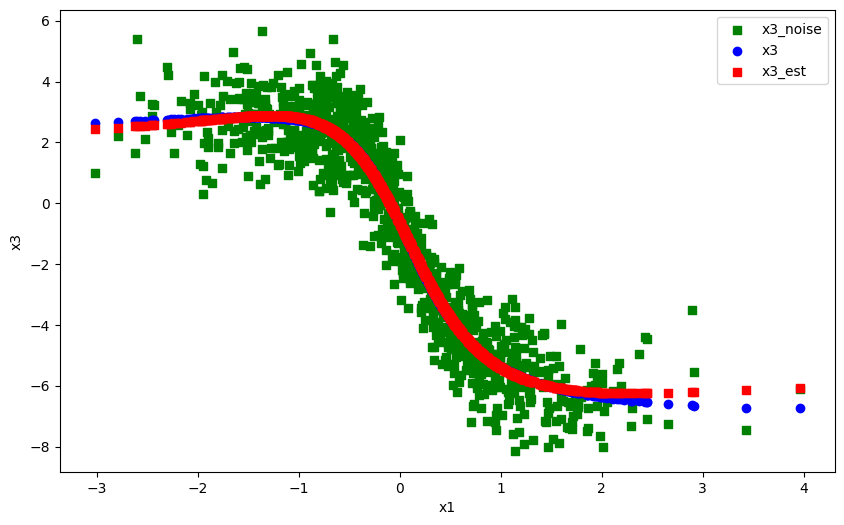

The programm is closed


In [22]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size  
plt.scatter(X_true.detach().numpy()[:, 0], X_true.detach().numpy()[:, 1], label='x3_noise', color='green', marker='s') 
plt.scatter(X_true.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='x3', color='blue', marker='o')
plt.scatter(X_true.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='x3_est', color='red', marker='s') 
plt.xlabel('x1')
plt.ylabel('x3')
plt.legend()
plt.show()
print("The programm is closed")

In [ ]:
_, observed_derivs = eq_model.get_graph(X_true)
observed_derivs_mean = observed_derivs.mean(dim = 0)
observed_hess = eq_model.exact_hessian_diag_avg(X_true)
Sigma_est = eq_model.get_Sigma()
mle_loss = model.mle_loss(x_est, X_true, Sigma_est)
h_val = eq_model.h_func(W_est_dce_no_thresh, W2)
nonlinear_reg = eq_model.get_nonlinear_reg(observed_derivs_mean, observed_hess)

In [ ]:
h_val

tensor(1.9533e-06, grad_fn=<AddBackward0>)

In [ ]:
import json

filename = f'result_d{d}_seed{seed}'
results = {
'admg': admg,
"fc1_weight": eq_model.fc1.weight.detach().cpu().tolist(),
"fc1_bias": eq_model.fc1.bias.detach().cpu().tolist(),
"fc2_weight": eq_model.fc2[0].weight.detach().cpu().tolist(),
"fc2_bias": eq_model.fc2[0].bias.detach().cpu().tolist(),
"M": eq_model.M.detach().cpu().tolist(),
"True_Sigma": True_Sigma.tolist(),
'h_val': h_val.item(),
'mle_loss': mle_loss.detach().cpu().tolist(),
'W_est_dce_no_thresh': W_est_dce_no_thresh.detach().cpu().tolist(),
'Sigma_est': Sigma_est.detach().cpu().tolist(),
'X_true': X_true.detach().cpu().numpy().tolist()}

with open(filename, 'w') as file:
    json.dump(results, file, indent=4) 

truth init: Generate Data acc SEM

In [21]:
def generate_layers(admg, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    bias=True
    fc1 = nn.Linear(d, d * dims[1], bias=bias) # [d * dims[1], d]
    # self.fc1.weight.bounds = self._bounds()
    mask = torch.ones(d * dims[1], d)

    for j in range(d):
        allowed_parents = parents[j]
        not_parents = [p for p in range(d) if p not in allowed_parents]
        print("j: ", j, "not_parents: ", not_parents)
        mask[j * dims[1]:(j + 1) * dims[1], not_parents] = 0.0

    layers = []
    for l in range(len(dims) - 2):
        layers.append(LocallyConnected(d, dims[l + 1], dims[l + 2], bias=bias))
    fc2 = nn.ModuleList(layers)
    return fc1, fc2, mask

In [22]:
import torch
import numpy as np

torch.set_default_dtype(torch.double)
np.random.seed(0)
d = 4
n_samples = 1000
dims = [d, 10, 1]

# Example DAG: 0 -> 1 -> 2, 0 -> 3
parents = {
    0: [],        # no parents
    1: [0],
    2: [1],
    3: [0]
}

# noise covariance (can include correlations if you want bidirected edges)
True_Sigma = np.array([
    [1.0, 0.3, 0.0, 0.2],
    [0.3, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0],
    [0.2, 0.0, 0.0, 1.0]
])
epsilon = np.random.multivariate_normal(np.zeros(d), True_Sigma, size=n_samples)
epsilon = torch.tensor(epsilon)

# build nonlinear functions
fc1, fc2, mask = generate_layers(parents, seed=0)
scale_weights(fc1, factor=5)
for layer in fc2:
    scale_weights(layer, factor=5)

# initialize container for x
X = torch.zeros(n_samples, d, dtype=torch.double)

# topological order (ensure parents before children)
order = [0, 1, 2, 3]

# compute variables one by one
for j in order:
    if len(parents[j]) == 0:
        # no parents → only noise
        X[:, j] = epsilon[:, j]
    else:
        # make a temporary input tensor of size [n, d], fill known parents
        x_input = torch.zeros(n_samples, d, dtype=torch.double)
        for p in parents[j]:
            x_input[:, p] = X[:, p]

        # use your forward network to compute f_j(x_parents)
        f_out = forward(fc1, fc2, mask, x_input)  # [n, d]
        X[:, j] = f_out[:, j] + epsilon[:, j]

# done
X_true = X.detach()
X = X_true - epsilon

j:  0 not_parents:  [0, 1, 2, 3]
j:  1 not_parents:  [1, 2, 3]
j:  2 not_parents:  [0, 2, 3]
j:  3 not_parents:  [1, 2, 3]


In [23]:
X

tensor([[ 0.0000,  0.0880, -3.5017,  0.7951],
        [ 0.0000, -0.0643, -2.5666,  1.1857],
        [ 0.0000,  0.6765, -0.8302,  0.2469],
        ...,
        [ 0.0000,  0.3960, -2.5914,  0.5695],
        [ 0.0000, -0.0052, -0.3939,  0.8648],
        [ 0.0000,  0.0059, -1.0207,  1.2103]])

In [24]:
fc1_weight = fc1.weight*mask
# print(fc1_weight)
fc1_bias = fc1.bias
fc2_weight = fc2[0].weight
fc2_bias = fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
# eq_model.mask = mask.clone()
eq_model.fc1.weight = nn.Parameter(fc1_weight)
eq_model.fc1.bias = fc1_bias
eq_model.fc2[0].weight = fc2_weight
eq_model.fc2[0].bias = fc2_bias
eq_model.M = nn.Parameter(M.clone())
X_hat = eq_model.forward(X_true)
X_hat 

tensor([[-0.8059,  0.0880, -3.5017,  0.7951],
        [-0.8059, -0.0643, -2.5666,  1.1857],
        [-0.8059,  0.6765, -0.8302,  0.2469],
        ...,
        [-0.8059,  0.3960, -2.5914,  0.5695],
        [-0.8059, -0.0052, -0.3939,  0.8648],
        [-0.8059,  0.0059, -1.0207,  1.2103]], grad_fn=<SqueezeBackward1>)

### 4 nodes

In [2]:
from run_experiments import generate_ancestral_admg, generate_layers, forward, generate_covariance, reverse_SPDLogCholesky, generate_from_epsilon, mle_loss, scale_weights
import networkx as nx
from torch.func import jacrev, vmap

In [3]:
d = 4
s = 5
def f(x_single):
    # expects x_single: shape [d]
    return forward(dims, fc1, fc2, mask, x_single.unsqueeze(0)).squeeze(0)

In [4]:
torch.set_default_dtype(torch.double)
np.random.seed(s)

print(f'>>> Generating Data with MLP <<<')

admg, A_dir, A_bidir = generate_ancestral_admg(d, p_dir=0.4, p_bidir=0.3, seed=2)
print("admg: ", admg)
parents = {j: admg[j]['parents'] for j in admg}
G = nx.DiGraph()
G.add_nodes_from(parents.keys())
for j, pa in parents.items():
    G.add_edges_from((p, j) for p in pa)
order = list(nx.topological_sort(G))

n_samples = 1000 
dims=[d, 10, 1]
Sigma_truth = generate_covariance(A_bidir, seed=0)
epsilon = np.random.multivariate_normal([0] * d, Sigma_truth, size=n_samples)
Sigma_truth = torch.tensor(Sigma_truth)
epsilon = torch.tensor(epsilon)
fc1, fc2, mask = generate_layers(d, dims, admg, seed = 9)
scale_weights(fc1, factor=10)
for layer in fc2:
    scale_weights(layer, factor=25)
X_truth = generate_from_epsilon(dims, epsilon, fc1, fc2, mask, parents).detach()
X = X_truth - epsilon

J = vmap(jacrev(f))(X_truth)    # shape [n_samples, d, d]
W_truth = torch.sqrt(torch.mean(J ** 2, axis=0).T)

mle_loss_truth = mle_loss(X, X_truth, Sigma_truth)

M_truth = reverse_SPDLogCholesky(Sigma_truth)

>>> Generating Data with MLP <<<
admg:  {0: {'parents': [], 'spouses': []}, 1: {'parents': [0], 'spouses': []}, 2: {'parents': [1], 'spouses': [3]}, 3: {'parents': [], 'spouses': [2]}}


In [5]:
print("Sigma_truth: ", Sigma_truth)
print("W_truth: ", W_truth)

Sigma_truth:  tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.6195],
        [0.0000, 0.0000, 0.6195, 1.0000]])
W_truth:  tensor([[7.4245e-06, 6.6293e+00, 3.8722e-06, 1.2807e-05],
        [2.0456e-05, 1.3028e-05, 2.5151e+00, 3.8148e-06],
        [2.4496e-06, 4.4200e-06, 3.4385e-06, 1.1230e-05],
        [2.0607e-05, 4.6209e-06, 3.8512e-06, 3.4059e-06]],
       grad_fn=<SqrtBackward0>)


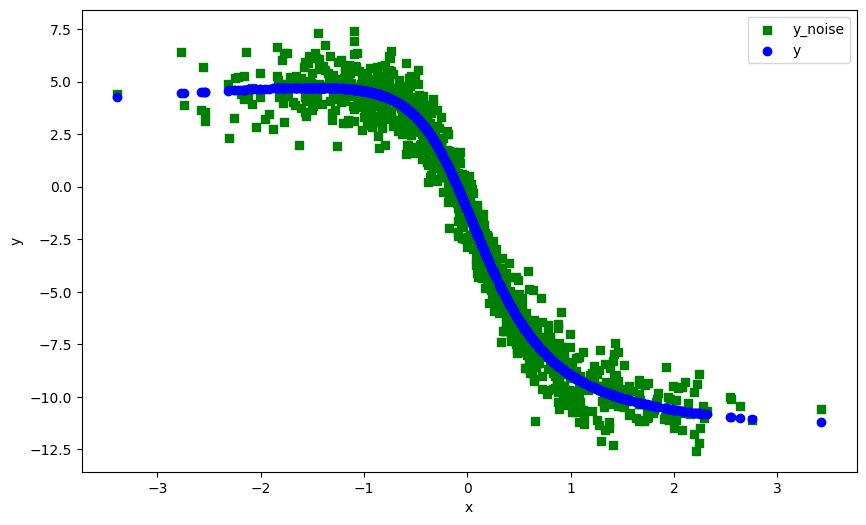

The programm is closed


In [6]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size  
plt.scatter(X_truth.detach().numpy()[:, 0], X_truth.detach().numpy()[:, 1], label='y_noise', color='green', marker='s') 
plt.scatter(X_truth.detach().numpy()[:, 0], X.detach().numpy()[:, 1], label='y', color='blue', marker='o')
#plt.scatter(X_truth.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='x3_est', color='red', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

In [7]:
eq_model = nonlinear.DagmaMLP(
dims=[d, 10, 1], bias=True, dtype=torch.double)
model = nonlinear.DagmaNonlinear(
    eq_model, dtype=torch.double, use_mse_loss=True)

W_est_dagma = model.fit(X_truth, lambda1=2e-2, lambda2=0.005,
                        T=1, lr=2e-4, w_threshold=0.3, mu_init=0.1, warm_iter=70000, max_iter=80000)

# Use DAGMA weights as initial weights for DAGMA-DCE
fc1_weight_DAGMA = eq_model.fc1.weight
fc1_bias_DAGMA = eq_model.fc1.bias
fc2_weight_DAGMA = eq_model.fc2[0].weight
fc2_bias_DAGMA = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
eq_model.fc1.weight = fc1_weight_DAGMA
eq_model.fc1.bias = fc1_bias_DAGMA
eq_model.fc2[0].weight = fc2_weight_DAGMA
eq_model.fc2[0].bias = fc2_bias_DAGMA

W_est_DAGMA, W2_DAGMA, x_est_DAGMA = model.fit(X_truth, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=5, warm_iter=7000, max_iter=8000)

  0%|          | 8/36000 [00:00<17:05, 35.10it/s]  

Sigma:  tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], grad_fn=<MmBackward0>)
obj:  tensor(247.7301, grad_fn=<AddBackward0>)
mle loss:  tensor(247.7301, grad_fn=<AddBackward0>)
h_val:  tensor(8.6094e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0296, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 7.8884e-07, -4.0393e-02,  4.0242e-03, -4.2909e-06],
        [-1.6675e-04,  1.1299e-06, -2.4562e-02,  2.7363e-05],
        [-2.4281e-05,  2.7927e-01,  5.7529e-07,  1.2686e-01],
        [-3.3524e-06,  4.1932e-06, -2.6426e-06,  1.0545e-06]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.3756e-14, 1.1388e-03, 8.7427e-05, 3.5178e-12],
        [3.9849e-09, 1.3078e-14, 8.2391e-04, 8.6742e-11],
        [4.0205e-10, 5.2982e-02, 4.9684e-14, 2.4599e-02],
        [6.6573e-13, 4.5871e-14, 1.1836e-12, 2.8896e-15]])
mu:  1
W_current:  tensor([[7.8887e-07, 1.6675e-04, 2.4316e-05, 3.3524e-06],
        [4.0584e-02, 1.1347e-06, 3

  3%|▎         | 1010/36000 [00:16<09:09, 63.71it/s]

Sigma:  tensor([[ 0.6299, -0.1559, -0.1916, -0.0017],
        [-0.1559,  1.5306,  0.1076, -0.1289],
        [-0.1916,  0.1076,  1.5444, -0.1053],
        [-0.0017, -0.1289, -0.1053,  0.9116]], grad_fn=<MmBackward0>)
W_current:  tensor([[5.0147e-07, 8.5993e-01, 1.1837e+00, 2.2156e-06],
        [5.6884e-02, 3.0957e-07, 1.4658e+00, 5.4636e-05],
        [1.7997e-02, 1.0030e-01, 2.8854e-08, 4.5808e-02],
        [3.9435e-05, 1.5804e-03, 1.1276e+00, 6.7021e-07]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000, -0.1559, -0.1916, -0.0017],
        [-0.1559,  0.0000,  0.1076, -0.1289],
        [-0.1916,  0.1076,  0.0000, -0.1053],
        [-0.0017, -0.1289, -0.1053,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(65.4662, grad_fn=<AddBackward0>)
mle loss:  tensor(64.3130, grad_fn=<AddBackward0>)
h_val:  tensor(0.1666, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0842, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 5.0108e-07, -5.6853e-02,  1.7964e-02, -1.2338e-05],
        [-8.22

  6%|▌         | 2012/36000 [00:32<08:50, 64.07it/s]

Sigma:  tensor([[ 0.3281, -0.1244, -0.1963,  0.0102],
        [-0.1244,  2.1674, -0.2235, -0.1547],
        [-0.1963, -0.2235,  2.3568,  0.0455],
        [ 0.0102, -0.1547,  0.0455,  0.9676]], grad_fn=<MmBackward0>)
W_current:  tensor([[2.9288e-07, 1.7984e+00, 1.9420e+00, 3.2017e-05],
        [1.4868e-01, 4.6712e-08, 2.2446e+00, 1.3072e-05],
        [1.4845e-03, 2.4088e-01, 7.0535e-09, 1.1044e-02],
        [5.3071e-04, 4.7535e-03, 2.6980e-01, 4.9365e-07]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000, -0.1244, -0.1963,  0.0102],
        [-0.1244,  0.0000, -0.2235, -0.1547],
        [-0.1963, -0.2235,  0.0000,  0.0455],
        [ 0.0102, -0.1547,  0.0455,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(15.8845, grad_fn=<AddBackward0>)
mle loss:  tensor(14.1132, grad_fn=<AddBackward0>)
h_val:  tensor(1.2554, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0330, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.9045e-07, -1.4199e-01, -7.6900e-05, -2.1099e-05],
        [-1.57

  8%|▊         | 3009/36000 [00:47<08:42, 63.09it/s]

Sigma:  tensor([[ 0.2071,  0.0039, -0.0358,  0.0283],
        [ 0.0039,  2.0826, -0.0777, -0.2311],
        [-0.0358, -0.0777,  3.3111, -0.0236],
        [ 0.0283, -0.2311, -0.0236,  0.9922]], grad_fn=<MmBackward0>)
W_current:  tensor([[1.5813e-07, 2.5639e+00, 1.8082e+00, 1.5509e-05],
        [1.1743e-01, 2.6202e-08, 2.0605e+00, 1.3607e-05],
        [1.0916e-02, 2.2949e-01, 6.4097e-09, 6.2038e-03],
        [1.4919e-04, 7.6872e-03, 4.5560e-01, 3.0142e-07]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000,  0.0039, -0.0358,  0.0283],
        [ 0.0039,  0.0000, -0.0777, -0.2311],
        [-0.0358, -0.0777,  0.0000, -0.0236],
        [ 0.0283, -0.2311, -0.0236,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(8.2674, grad_fn=<AddBackward0>)
mle loss:  tensor(7.3397, grad_fn=<AddBackward0>)
h_val:  tensor(0.4364, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0283, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.5652e-07, -1.1655e-01, -1.0717e-02,  1.1084e-06],
        [-2.2540

 11%|█         | 4009/36000 [01:03<08:31, 62.59it/s]

Sigma:  tensor([[ 0.1636,  0.0498,  0.0328,  0.0275],
        [ 0.0498,  1.4673, -0.0633, -0.1619],
        [ 0.0328, -0.0633,  4.3166, -0.0804],
        [ 0.0275, -0.1619, -0.0804,  0.9897]], grad_fn=<MmBackward0>)
W_current:  tensor([[8.8519e-08, 3.1716e+00, 1.4542e+00, 8.5345e-06],
        [1.1205e-01, 1.6636e-08, 1.7750e+00, 1.5996e-05],
        [1.2608e-02, 1.7670e-01, 4.7934e-09, 3.2753e-03],
        [2.3062e-04, 1.5889e-02, 7.1721e-01, 1.5787e-07]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000,  0.0498,  0.0328,  0.0275],
        [ 0.0498,  0.0000, -0.0633, -0.1619],
        [ 0.0328, -0.0633,  0.0000, -0.0804],
        [ 0.0275, -0.1619, -0.0804,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(4.8680, grad_fn=<AddBackward0>)
mle loss:  tensor(4.1119, grad_fn=<AddBackward0>)
h_val:  tensor(0.3248, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0214, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 8.6761e-08, -1.0958e-01, -1.0750e-02,  1.1591e-06],
        [-2.8339

 14%|█▍        | 5013/36000 [01:19<08:06, 63.70it/s]

Sigma:  tensor([[ 0.1559,  0.0582,  0.0252,  0.0186],
        [ 0.0582,  1.1599, -0.0586, -0.0975],
        [ 0.0252, -0.0586,  4.3106, -0.0490],
        [ 0.0186, -0.0975, -0.0490,  0.9849]], grad_fn=<MmBackward0>)
W_current:  tensor([[4.2149e-08, 3.4345e+00, 9.0489e-01, 1.7501e-05],
        [1.1397e-01, 5.5856e-09, 1.8044e+00, 8.9609e-06],
        [1.1884e-02, 1.5065e-01, 2.4493e-09, 1.8931e-03],
        [2.6100e-04, 2.6034e-02, 6.7121e-01, 6.2792e-08]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000,  0.0582,  0.0252,  0.0186],
        [ 0.0582,  0.0000, -0.0586, -0.0975],
        [ 0.0252, -0.0586,  0.0000, -0.0490],
        [ 0.0186, -0.0975, -0.0490,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(4.3651, grad_fn=<AddBackward0>)
mle loss:  tensor(3.6394, grad_fn=<AddBackward0>)
h_val:  tensor(0.3322, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0190, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 4.1210e-08, -1.1155e-01, -1.0708e-02,  1.1950e-05],
        [-3.1058

 17%|█▋        | 6007/36000 [01:37<07:55, 63.12it/s]

Sigma:  tensor([[ 0.1593,  0.0545,  0.0143,  0.0175],
        [ 0.0545,  1.0456, -0.0503, -0.0800],
        [ 0.0143, -0.0503,  3.8239, -0.0461],
        [ 0.0175, -0.0800, -0.0461,  0.9837]], grad_fn=<MmBackward0>)
W_current:  tensor([[1.2376e-08, 3.6763e+00, 7.1760e-01, 4.6939e-06],
        [1.0988e-01, 1.0650e-09, 1.8216e+00, 6.3472e-06],
        [1.2994e-02, 1.3559e-01, 1.6835e-09, 1.6448e-03],
        [3.8127e-04, 3.1047e-02, 6.9399e-01, 1.4639e-08]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000,  0.0545,  0.0143,  0.0175],
        [ 0.0545,  0.0000, -0.0503, -0.0800],
        [ 0.0143, -0.0503,  0.0000, -0.0461],
        [ 0.0175, -0.0800, -0.0461,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(3.9525, grad_fn=<AddBackward0>)
mle loss:  tensor(3.2562, grad_fn=<AddBackward0>)
h_val:  tensor(0.3201, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0180, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.2030e-08, -1.0726e-01, -1.1860e-02, -1.4391e-05],
        [-3.3198

 19%|█▉        | 7010/36000 [01:55<08:17, 58.24it/s]

Sigma:  tensor([[ 0.1645,  0.0483,  0.0056,  0.0153],
        [ 0.0483,  0.9624, -0.0407, -0.0686],
        [ 0.0056, -0.0407,  2.8603,  0.0088],
        [ 0.0153, -0.0686,  0.0088,  0.9832]], grad_fn=<MmBackward0>)
obj:  tensor(2.7951, grad_fn=<AddBackward0>)
mle loss:  tensor(2.7951, grad_fn=<AddBackward0>)
h_val:  tensor(0.3214, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0178, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.3974e-09, -1.0217e-01, -1.2878e-02,  1.1925e-05],
        [-3.4742e+00,  5.5752e-10,  8.6309e-02, -6.8867e-05],
        [-3.1655e-02,  1.1637e+00,  8.1465e-10,  5.3199e-01],
        [ 2.0493e-06, -9.8179e-07,  1.1465e-03,  1.0975e-09]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.8919e-18, 4.7640e-03, 1.2991e-03, 1.8072e-05],
        [1.8999e+00, 4.4978e-20, 2.2543e-02, 2.6382e-03],
        [1.9366e-01, 4.9034e-01, 1.6109e-19, 2.7869e-01],
        [1.4225e-12, 6.0298e-13, 2.5431e-08, 2.3302e-20]])
mu:  0.1
W_current:  tensor([[1.4422e-0

 22%|██▏       | 8012/36000 [02:11<07:34, 61.61it/s]

Sigma:  tensor([[ 2.1438e-01,  6.3944e-04,  6.3221e-04,  1.7357e-02],
        [ 6.3944e-04,  1.1709e+00, -3.0218e-03, -6.4558e-02],
        [ 6.3221e-04, -3.0218e-03,  2.0110e+00,  3.2919e-03],
        [ 1.7357e-02, -6.4558e-02,  3.2919e-03,  9.8040e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[1.0631e-10, 3.8763e+00, 1.1124e+00, 1.8397e-06],
        [4.5469e-02, 1.0456e-09, 1.8318e+00, 3.4166e-06],
        [2.1377e-02, 1.0124e-01, 1.3257e-09, 3.1164e-03],
        [2.5078e-03, 3.5638e-02, 5.7985e-01, 2.6909e-11]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000,  0.0006,  0.0006,  0.0174],
        [ 0.0006,  0.0000, -0.0030, -0.0646],
        [ 0.0006, -0.0030,  0.0000,  0.0033],
        [ 0.0174, -0.0646,  0.0033,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.4335, grad_fn=<AddBackward0>)
mle loss:  tensor(3.0861, grad_fn=<AddBackward0>)
h_val:  tensor(0.0934, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0118, grad_fn=<SumBackward0>)
observed_derivs:  tensor(

 25%|██▌       | 9012/36000 [02:27<06:57, 64.59it/s]

Sigma:  tensor([[ 2.7775e-01,  1.1735e-03,  3.3064e-04,  1.8578e-02],
        [ 1.1735e-03,  1.0809e+00, -2.6475e-03, -4.9435e-02],
        [ 3.3064e-04, -2.6475e-03,  1.3837e+00,  3.2934e-02],
        [ 1.8578e-02, -4.9435e-02,  3.2934e-02,  9.7560e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[7.6423e-11, 4.2646e+00, 1.1803e+00, 2.9913e-06],
        [3.5719e-02, 9.1406e-10, 1.9214e+00, 5.9782e-06],
        [1.8474e-02, 8.3640e-02, 1.0469e-09, 2.5500e-03],
        [4.6082e-03, 3.3415e-02, 4.6650e-01, 2.0007e-11]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000,  0.0012,  0.0003,  0.0186],
        [ 0.0012,  0.0000, -0.0026, -0.0494],
        [ 0.0003, -0.0026,  0.0000,  0.0329],
        [ 0.0186, -0.0494,  0.0329,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.3986, grad_fn=<AddBackward0>)
mle loss:  tensor(2.8430, grad_fn=<AddBackward0>)
h_val:  tensor(0.0755, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0184, grad_fn=<SumBackward0>)
observed_derivs:  tensor(

 28%|██▊       | 10012/36000 [02:43<07:04, 61.15it/s]

Sigma:  tensor([[ 3.1860e-01,  8.8832e-04,  1.7216e-04,  1.9367e-03],
        [ 8.8832e-04,  1.0282e+00, -2.1769e-03, -8.4767e-04],
        [ 1.7216e-04, -2.1769e-03,  1.1130e+00,  4.0222e-01],
        [ 1.9367e-03, -8.4767e-04,  4.0222e-01,  8.4131e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[6.0975e-11, 4.5066e+00, 1.1779e+00, 7.9451e-06],
        [3.2071e-02, 7.9348e-10, 2.0242e+00, 1.4521e-06],
        [1.6223e-02, 7.1983e-02, 1.0321e-09, 1.3868e-05],
        [4.5824e-03, 2.7636e-02, 5.2807e-02, 1.5824e-11]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  8.8832e-04,  1.7216e-04,  1.9367e-03],
        [ 8.8832e-04,  0.0000e+00, -2.1769e-03, -8.4767e-04],
        [ 1.7216e-04, -2.1769e-03,  0.0000e+00,  4.0222e-01],
        [ 1.9367e-03, -8.4767e-04,  4.0222e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.3611, grad_fn=<AddBackward0>)
mle loss:  tensor(2.6708, grad_fn=<AddBackward0>)
h_val:  tensor(0.0674, grad_fn=<AddBackward0>)
nonlinear

 31%|███       | 11012/36000 [03:00<07:05, 58.75it/s]

Sigma:  tensor([[ 3.3865e-01,  6.5355e-04,  7.2444e-05,  4.5763e-03],
        [ 6.5355e-04,  9.8825e-01, -1.2763e-03, -3.8506e-03],
        [ 7.2444e-05, -1.2763e-03,  1.0271e+00,  5.3202e-01],
        [ 4.5763e-03, -3.8506e-03,  5.3202e-01,  9.1954e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[5.5169e-11, 4.6979e+00, 1.1091e+00, 3.5632e-07],
        [3.0356e-02, 6.8751e-10, 2.1051e+00, 3.6688e-06],
        [1.4804e-02, 6.3214e-02, 8.5192e-10, 6.9196e-06],
        [2.9919e-03, 1.8961e-02, 3.8257e-02, 8.6419e-12]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  6.5355e-04,  7.2444e-05,  4.5763e-03],
        [ 6.5355e-04,  0.0000e+00, -1.2763e-03, -3.8506e-03],
        [ 7.2444e-05, -1.2763e-03,  0.0000e+00,  5.3202e-01],
        [ 4.5763e-03, -3.8506e-03,  5.3202e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.3423, grad_fn=<AddBackward0>)
mle loss:  tensor(2.5402, grad_fn=<AddBackward0>)
h_val:  tensor(0.0623, grad_fn=<AddBackward0>)
nonlinear

 33%|███▎      | 12006/36000 [03:16<06:11, 64.67it/s]

Sigma:  tensor([[ 3.5106e-01,  5.0434e-04,  2.6819e-05,  8.1554e-03],
        [ 5.0434e-04,  9.5943e-01, -7.1490e-04, -1.1913e-02],
        [ 2.6819e-05, -7.1490e-04,  1.0183e+00,  5.8033e-01],
        [ 8.1554e-03, -1.1913e-02,  5.8033e-01,  9.5999e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[4.6554e-11, 4.8728e+00, 9.7724e-01, 8.9586e-07],
        [2.8373e-02, 5.8153e-10, 2.1634e+00, 3.7863e-07],
        [1.3637e-02, 5.5934e-02, 6.7796e-10, 1.5956e-06],
        [2.8575e-03, 1.3292e-02, 3.6022e-02, 4.4323e-12]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  5.0434e-04,  2.6819e-05,  8.1554e-03],
        [ 5.0434e-04,  0.0000e+00, -7.1490e-04, -1.1913e-02],
        [ 2.6819e-05, -7.1490e-04,  0.0000e+00,  5.8033e-01],
        [ 8.1554e-03, -1.1913e-02,  5.8033e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.3302, grad_fn=<AddBackward0>)
mle loss:  tensor(2.4810, grad_fn=<AddBackward0>)
h_val:  tensor(0.0568, grad_fn=<AddBackward0>)
nonlinear

 36%|███▌      | 13007/36000 [03:32<06:45, 56.65it/s]

Sigma:  tensor([[ 3.4805e-01,  3.9529e-04,  1.4767e-05,  9.0040e-03],
        [ 3.9529e-04,  9.4167e-01, -4.4510e-04, -1.6354e-02],
        [ 1.4767e-05, -4.4510e-04,  9.9945e-01,  5.8927e-01],
        [ 9.0040e-03, -1.6354e-02,  5.8927e-01,  9.6831e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[4.4348e-11, 4.9974e+00, 8.2495e-01, 6.0781e-07],
        [2.7883e-02, 5.2516e-10, 2.2102e+00, 9.7218e-07],
        [1.3209e-02, 5.0794e-02, 6.1221e-10, 7.4967e-07],
        [2.9064e-03, 1.0433e-02, 3.7421e-02, 1.9787e-12]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  3.9529e-04,  1.4767e-05,  9.0040e-03],
        [ 3.9529e-04,  0.0000e+00, -4.4510e-04, -1.6354e-02],
        [ 1.4767e-05, -4.4510e-04,  0.0000e+00,  5.8927e-01],
        [ 9.0040e-03, -1.6354e-02,  5.8927e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.3220, grad_fn=<AddBackward0>)
mle loss:  tensor(2.4169, grad_fn=<AddBackward0>)
h_val:  tensor(0.0556, grad_fn=<AddBackward0>)
nonlinear

 39%|███▉      | 14009/36000 [03:49<06:19, 57.89it/s]

Sigma:  tensor([[ 3.5097e-01,  3.0784e-04,  1.3606e-05,  8.8137e-03],
        [ 3.0784e-04,  9.3225e-01, -3.2904e-04, -1.7849e-02],
        [ 1.3606e-05, -3.2904e-04,  9.8175e-01,  5.8905e-01],
        [ 8.8137e-03, -1.7849e-02,  5.8905e-01,  9.6861e-01]],
       grad_fn=<MmBackward0>)
obj:  tensor(2.3894, grad_fn=<AddBackward0>)
mle loss:  tensor(2.3894, grad_fn=<AddBackward0>)
h_val:  tensor(0.0540, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0050, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.6316e-11, -2.1474e-02, -6.5694e-03,  1.2158e-05],
        [-4.2583e+00,  3.9600e-10,  2.5010e-02,  1.1762e-05],
        [-2.0242e-01,  1.0340e+00,  5.0322e-10,  6.3862e-05],
        [-4.0981e-07, -8.4250e-07,  8.9336e-08,  6.6349e-13]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.5415e-22, 5.3211e-03, 2.1937e-03, 1.1622e-04],
        [4.0057e+00, 2.9098e-20, 6.5234e-03, 5.3594e-04],
        [1.5129e-01, 8.1622e-01, 3.6594e-20, 2.6201e-02],
        [1.9103e-15, 5.8520

 42%|████▏     | 15009/36000 [04:05<05:25, 64.53it/s]

Sigma:  tensor([[ 5.3143e-01, -7.4987e-05, -9.9118e-06,  1.6087e-02],
        [-7.4987e-05,  1.2219e+00,  8.5006e-05, -4.7570e-02],
        [-9.9118e-06,  8.5006e-05,  9.6156e-01,  5.5849e-01],
        [ 1.6087e-02, -4.7570e-02,  5.5849e-01,  9.4362e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[5.3254e-11, 5.3879e+00, 7.9079e-01, 6.4826e-07],
        [7.5222e-03, 7.5461e-10, 2.2224e+00, 1.2745e-07],
        [3.7529e-03, 1.7033e-02, 5.4138e-10, 9.1083e-08],
        [1.1451e-03, 4.2031e-03, 2.2447e-02, 3.3817e-14]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -7.4987e-05, -9.9118e-06,  1.6087e-02],
        [-7.4987e-05,  0.0000e+00,  8.5006e-05, -4.7570e-02],
        [-9.9118e-06,  8.5006e-05,  0.0000e+00,  5.5849e-01],
        [ 1.6087e-02, -4.7570e-02,  5.5849e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0424, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4942, grad_fn=<AddBackward0>)
h_val:  tensor(0.0053, grad_fn=<AddBackward0>)
nonlinear

 44%|████▍     | 16013/36000 [04:20<05:07, 65.02it/s]

Sigma:  tensor([[ 7.2524e-01,  1.4964e-05, -5.8178e-06,  2.6467e-02],
        [ 1.4964e-05,  1.0846e+00,  3.3980e-05, -2.9780e-02],
        [-5.8178e-06,  3.3980e-05,  9.7391e-01,  5.8479e-01],
        [ 2.6467e-02, -2.9780e-02,  5.8479e-01,  9.6613e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[3.2730e-11, 5.8459e+00, 6.9695e-01, 4.6685e-09],
        [3.4337e-03, 5.6522e-10, 2.2588e+00, 3.8511e-09],
        [1.9894e-03, 1.1674e-02, 3.6885e-10, 3.3804e-08],
        [4.4902e-04, 2.5229e-03, 1.5298e-02, 8.4008e-15]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  1.4964e-05, -5.8178e-06,  2.6467e-02],
        [ 1.4964e-05,  0.0000e+00,  3.3980e-05, -2.9780e-02],
        [-5.8178e-06,  3.3980e-05,  0.0000e+00,  5.8479e-01],
        [ 2.6467e-02, -2.9780e-02,  5.8479e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0386, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4497, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)
nonlinear

 47%|████▋     | 17014/36000 [04:36<04:48, 65.85it/s]

Sigma:  tensor([[ 8.5895e-01,  2.3018e-05, -4.2328e-06,  2.9793e-02],
        [ 2.3018e-05,  1.0545e+00,  8.5370e-06, -2.2004e-02],
        [-4.2328e-06,  8.5370e-06,  9.7124e-01,  5.9416e-01],
        [ 2.9793e-02, -2.2004e-02,  5.9416e-01,  9.7396e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[2.3863e-11, 6.0105e+00, 5.6899e-01, 6.5933e-08],
        [2.1085e-03, 4.5297e-10, 2.3029e+00, 1.9593e-08],
        [1.4040e-03, 9.4440e-03, 3.0953e-10, 1.8227e-08],
        [2.6976e-04, 1.8601e-03, 1.1211e-02, 4.6720e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  2.3018e-05, -4.2328e-06,  2.9793e-02],
        [ 2.3018e-05,  0.0000e+00,  8.5370e-06, -2.2004e-02],
        [-4.2328e-06,  8.5370e-06,  0.0000e+00,  5.9416e-01],
        [ 2.9793e-02, -2.2004e-02,  5.9416e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0376, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4291, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)
nonlinear

 50%|█████     | 18004/36000 [04:52<05:54, 50.76it/s]

Sigma:  tensor([[ 9.0324e-01,  1.7045e-05, -4.1225e-06,  3.1767e-02],
        [ 1.7045e-05,  1.0213e+00, -1.3421e-05, -1.3863e-02],
        [-4.1225e-06, -1.3421e-05,  9.6692e-01,  5.9858e-01],
        [ 3.1767e-02, -1.3863e-02,  5.9858e-01,  9.7762e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[2.1769e-11, 6.0815e+00, 4.2111e-01, 3.2385e-08],
        [1.7729e-03, 3.9094e-10, 2.3447e+00, 9.5145e-08],
        [1.2514e-03, 8.4750e-03, 2.8270e-10, 2.2462e-08],
        [2.1600e-04, 1.5059e-03, 8.7077e-03, 6.3721e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  1.7045e-05, -4.1225e-06,  3.1767e-02],
        [ 1.7045e-05,  0.0000e+00, -1.3421e-05, -1.3863e-02],
        [-4.1225e-06, -1.3421e-05,  0.0000e+00,  5.9858e-01],
        [ 3.1767e-02, -1.3863e-02,  5.9858e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0370, grad_fn=<AddBackward0>)
mle loss:  tensor(3.3938, grad_fn=<AddBackward0>)
h_val:  tensor(0.0009, grad_fn=<AddBackward0>)
nonlinear

 53%|█████▎    | 19006/36000 [05:09<06:05, 46.54it/s]

Sigma:  tensor([[ 9.1023e-01,  1.2227e-05, -3.9857e-06,  3.2259e-02],
        [ 1.2227e-05,  9.9490e-01, -1.3405e-05, -1.2724e-02],
        [-3.9857e-06, -1.3405e-05,  9.6229e-01,  6.0065e-01],
        [ 3.2259e-02, -1.2724e-02,  6.0065e-01,  9.7955e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[2.1990e-11, 6.1490e+00, 3.2161e-01, 2.0481e-09],
        [1.7067e-03, 3.3556e-10, 2.3732e+00, 1.4334e-07],
        [1.1746e-03, 7.5536e-03, 2.4310e-10, 7.6654e-08],
        [1.9434e-04, 1.2349e-03, 7.1401e-03, 6.3253e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  1.2227e-05, -3.9857e-06,  3.2259e-02],
        [ 1.2227e-05,  0.0000e+00, -1.3405e-05, -1.2724e-02],
        [-3.9857e-06, -1.3405e-05,  0.0000e+00,  6.0065e-01],
        [ 3.2259e-02, -1.2724e-02,  6.0065e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0366, grad_fn=<AddBackward0>)
mle loss:  tensor(3.3615, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)
nonlinear

 56%|█████▌    | 20013/36000 [05:26<04:15, 62.61it/s]

Sigma:  tensor([[ 9.1340e-01,  8.2674e-06, -3.8452e-06,  3.2115e-02],
        [ 8.2674e-06,  9.7703e-01, -4.8807e-06, -1.4706e-02],
        [-3.8452e-06, -4.8807e-06,  9.5690e-01,  6.0130e-01],
        [ 3.2115e-02, -1.4706e-02,  6.0130e-01,  9.8051e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[2.2249e-11, 6.2110e+00, 2.8948e-01, 2.2778e-08],
        [1.6658e-03, 2.8913e-10, 2.3910e+00, 3.5162e-08],
        [1.1179e-03, 6.7585e-03, 2.2329e-10, 7.3646e-08],
        [1.9551e-04, 1.0789e-03, 6.2797e-03, 6.8601e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  8.2674e-06, -3.8452e-06,  3.2115e-02],
        [ 8.2674e-06,  0.0000e+00, -4.8807e-06, -1.4706e-02],
        [-3.8452e-06, -4.8807e-06,  0.0000e+00,  6.0130e-01],
        [ 3.2115e-02, -1.4706e-02,  6.0130e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0362, grad_fn=<AddBackward0>)
mle loss:  tensor(3.3369, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)
nonlinear

 58%|█████▊    | 21009/36000 [05:42<03:50, 64.95it/s]

Sigma:  tensor([[ 9.1600e-01,  5.2720e-06, -3.5845e-06,  3.2682e-02],
        [ 5.2720e-06,  9.6691e-01,  2.5133e-06, -1.6580e-02],
        [-3.5845e-06,  2.5133e-06,  9.5278e-01,  6.0149e-01],
        [ 3.2682e-02, -1.6580e-02,  6.0149e-01,  9.8107e-01]],
       grad_fn=<MmBackward0>)
obj:  tensor(3.3222, grad_fn=<AddBackward0>)
mle loss:  tensor(3.3222, grad_fn=<AddBackward0>)
h_val:  tensor(0.0006, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.8205e-11, -1.2487e-03, -3.9111e-04, -2.6582e-07],
        [-5.0833e+00,  2.0581e-10,  2.2383e-03, -6.8598e-06],
        [-1.1629e-05,  1.0610e+00,  1.7852e-10,  1.5500e-05],
        [-7.8638e-08,  7.1881e-08,  3.7744e-09,  6.4291e-16]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.4865e-23, 2.4682e-04, 1.8113e-04, 1.1422e-05],
        [6.2837e+00, 9.3241e-21, 1.7803e-03, 9.6131e-05],
        [6.8623e-02, 9.7004e-01, 8.4669e-21, 4.1088e-03],
        [8.6282e-17, 5.4252

 61%|██████    | 22013/36000 [05:59<03:43, 62.57it/s]

Sigma:  tensor([[ 9.7227e-01, -2.6059e-07,  8.8329e-07,  3.4301e-02],
        [-2.6059e-07,  9.9693e-01,  1.0747e-06, -1.7249e-02],
        [ 8.8329e-07,  1.0747e-06,  9.4472e-01,  5.9227e-01],
        [ 3.4301e-02, -1.7249e-02,  5.9227e-01,  9.7266e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[3.5912e-11, 6.3491e+00, 2.6854e-01, 7.5612e-11],
        [6.0228e-04, 3.2662e-10, 2.4057e+00, 3.0482e-09],
        [2.6135e-04, 2.4791e-03, 2.0151e-10, 7.3475e-09],
        [9.5953e-05, 7.1969e-04, 3.6009e-03, 3.6633e-19]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -2.6059e-07,  8.8329e-07,  3.4301e-02],
        [-2.6059e-07,  0.0000e+00,  1.0747e-06, -1.7249e-02],
        [ 8.8329e-07,  1.0747e-06,  0.0000e+00,  5.9227e-01],
        [ 3.4301e-02, -1.7249e-02,  5.9227e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0037, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4133, grad_fn=<AddBackward0>)
h_val:  tensor(7.1334e-05, grad_fn=<AddBackward0>)
nonli

 64%|██████▍   | 23007/36000 [06:15<03:23, 63.88it/s]

Sigma:  tensor([[ 9.7757e-01,  5.1539e-07, -3.5470e-07,  3.2926e-02],
        [ 5.1539e-07,  9.9915e-01,  5.1069e-07, -1.7199e-02],
        [-3.5470e-07,  5.1069e-07,  9.4902e-01,  5.9721e-01],
        [ 3.2926e-02, -1.7199e-02,  5.9721e-01,  9.7712e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[2.4170e-11, 6.3932e+00, 2.6508e-01, 7.8323e-11],
        [3.5014e-04, 2.8910e-10, 2.4068e+00, 5.1482e-10],
        [1.8378e-04, 1.6176e-03, 1.9110e-10, 7.6843e-09],
        [7.0881e-05, 5.7772e-04, 2.7500e-03, 3.4367e-20]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  5.1539e-07, -3.5470e-07,  3.2926e-02],
        [ 5.1539e-07,  0.0000e+00,  5.1069e-07, -1.7199e-02],
        [-3.5470e-07,  5.1069e-07,  0.0000e+00,  5.9721e-01],
        [ 3.2926e-02, -1.7199e-02,  5.9721e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0037, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4200, grad_fn=<AddBackward0>)
h_val:  tensor(3.1281e-05, grad_fn=<AddBackward0>)
nonli

 67%|██████▋   | 24008/36000 [06:32<03:15, 61.25it/s]

Sigma:  tensor([[ 9.7914e-01,  6.3710e-07, -3.3548e-07,  3.2441e-02],
        [ 6.3710e-07,  9.9942e-01,  5.6280e-07, -1.7226e-02],
        [-3.3548e-07,  5.6280e-07,  9.5104e-01,  5.9980e-01],
        [ 3.2441e-02, -1.7226e-02,  5.9980e-01,  9.7950e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[2.2476e-11, 6.4152e+00, 2.6005e-01, 2.0717e-09],
        [2.4593e-04, 2.7472e-10, 2.4078e+00, 7.0797e-09],
        [1.5435e-04, 1.1744e-03, 1.8321e-10, 1.0706e-08],
        [6.5871e-05, 4.4330e-04, 2.2347e-03, 7.4929e-17]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  6.3710e-07, -3.3548e-07,  3.2441e-02],
        [ 6.3710e-07,  0.0000e+00,  5.6280e-07, -1.7226e-02],
        [-3.3548e-07,  5.6280e-07,  0.0000e+00,  5.9980e-01],
        [ 3.2441e-02, -1.7226e-02,  5.9980e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0037, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4215, grad_fn=<AddBackward0>)
h_val:  tensor(1.8235e-05, grad_fn=<AddBackward0>)
nonli

 69%|██████▉   | 25008/36000 [06:48<03:00, 60.95it/s]

Sigma:  tensor([[ 9.7970e-01,  6.1672e-07, -3.2752e-07,  3.2131e-02],
        [ 6.1672e-07,  9.9810e-01,  6.5681e-07, -1.7422e-02],
        [-3.2752e-07,  6.5681e-07,  9.5184e-01,  6.0115e-01],
        [ 3.2131e-02, -1.7422e-02,  6.0115e-01,  9.8075e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[2.1946e-11, 6.4280e+00, 2.5391e-01, 1.3798e-08],
        [1.9513e-04, 2.6652e-10, 2.4095e+00, 1.7916e-07],
        [1.3262e-04, 9.3830e-04, 1.7814e-10, 4.6834e-08],
        [5.1387e-05, 3.3797e-04, 1.9023e-03, 4.1564e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  6.1672e-07, -3.2752e-07,  3.2131e-02],
        [ 6.1672e-07,  0.0000e+00,  6.5681e-07, -1.7422e-02],
        [-3.2752e-07,  6.5681e-07,  0.0000e+00,  6.0115e-01],
        [ 3.2131e-02, -1.7422e-02,  6.0115e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0037, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4201, grad_fn=<AddBackward0>)
h_val:  tensor(1.2371e-05, grad_fn=<AddBackward0>)
nonli

 72%|███████▏  | 26009/36000 [07:03<02:35, 64.41it/s]

Sigma:  tensor([[ 9.8012e-01,  5.5201e-07, -3.2524e-07,  3.2181e-02],
        [ 5.5201e-07,  9.9539e-01,  8.4601e-07, -1.7883e-02],
        [-3.2524e-07,  8.4601e-07,  9.5196e-01,  6.0192e-01],
        [ 3.2181e-02, -1.7883e-02,  6.0192e-01,  9.8148e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[2.1213e-11, 6.4420e+00, 2.4721e-01, 7.2853e-08],
        [1.6650e-04, 2.5731e-10, 2.4124e+00, 5.1460e-08],
        [1.1486e-04, 8.2236e-04, 1.7115e-10, 5.7300e-08],
        [3.1458e-05, 2.8291e-04, 1.6761e-03, 6.6099e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  5.5201e-07, -3.2524e-07,  3.2181e-02],
        [ 5.5201e-07,  0.0000e+00,  8.4601e-07, -1.7883e-02],
        [-3.2524e-07,  8.4601e-07,  0.0000e+00,  6.0192e-01],
        [ 3.2181e-02, -1.7883e-02,  6.0192e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0036, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4169, grad_fn=<AddBackward0>)
h_val:  tensor(9.3896e-06, grad_fn=<AddBackward0>)
nonli

 75%|███████▌  | 27006/36000 [07:22<02:41, 55.65it/s]

Sigma:  tensor([[ 9.8037e-01,  4.5759e-07, -3.3023e-07,  3.2588e-02],
        [ 4.5759e-07,  9.9182e-01,  1.0981e-06, -1.8611e-02],
        [-3.3023e-07,  1.0981e-06,  9.5160e-01,  6.0240e-01],
        [ 3.2588e-02, -1.8611e-02,  6.0240e-01,  9.8199e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[2.0722e-11, 6.4583e+00, 2.4026e-01, 3.7376e-08],
        [1.5903e-04, 2.4620e-10, 2.4166e+00, 3.4811e-08],
        [1.0484e-04, 7.5038e-04, 1.6243e-10, 4.0479e-10],
        [2.1131e-05, 2.5319e-04, 1.5171e-03, 6.9546e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  4.5759e-07, -3.3023e-07,  3.2588e-02],
        [ 4.5759e-07,  0.0000e+00,  1.0981e-06, -1.8611e-02],
        [-3.3023e-07,  1.0981e-06,  0.0000e+00,  6.0240e-01],
        [ 3.2588e-02, -1.8611e-02,  6.0240e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0036, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4123, grad_fn=<AddBackward0>)
h_val:  tensor(7.9308e-06, grad_fn=<AddBackward0>)
nonli

 78%|███████▊  | 28014/36000 [07:40<02:06, 63.27it/s]

Sigma:  tensor([[ 9.8047e-01,  3.4894e-07, -3.3368e-07,  3.3191e-02],
        [ 3.4894e-07,  9.8802e-01,  1.4103e-06, -1.9439e-02],
        [-3.3368e-07,  1.4103e-06,  9.5096e-01,  6.0271e-01],
        [ 3.3191e-02, -1.9439e-02,  6.0271e-01,  9.8239e-01]],
       grad_fn=<MmBackward0>)
obj:  tensor(3.4070, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4070, grad_fn=<AddBackward0>)
h_val:  tensor(7.1597e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(4.4761e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.6713e-11, -1.0874e-04, -3.4698e-05,  6.9412e-06],
        [-5.2135e+00,  1.8969e-10,  2.0300e-04, -1.5916e-05],
        [-7.6026e-05,  1.0586e+00,  1.3221e-10, -4.8614e-05],
        [ 5.0983e-08,  8.7914e-08,  8.8081e-08,  6.1286e-16]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[9.5452e-23, 4.4951e-05, 2.0339e-05, 3.2405e-06],
        [6.7969e+00, 7.3993e-21, 2.1942e-04, 4.6007e-05],
        [5.9835e-02, 9.9057e-01, 5.6733e-21, 1.1451e-03],
        [5.8157e-17

 81%|████████  | 29013/36000 [07:57<01:44, 66.77it/s]

Sigma:  tensor([[ 9.8516e-01,  7.1701e-08, -7.2878e-07,  3.0218e-02],
        [ 7.1701e-08,  9.8920e-01,  2.4972e-06, -1.8839e-02],
        [-7.2878e-07,  2.4972e-06,  9.4844e-01,  6.0287e-01],
        [ 3.0218e-02, -1.8839e-02,  6.0287e-01,  9.8252e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[4.0575e-11, 6.4947e+00, 2.3522e-01, 2.3202e-09],
        [9.6129e-05, 2.7004e-10, 2.4238e+00, 2.6312e-06],
        [4.6539e-05, 5.4505e-04, 3.5818e-10, 2.3022e-05],
        [1.5805e-05, 2.2174e-04, 1.2166e-03, 7.4268e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  7.1701e-08, -7.2878e-07,  3.0218e-02],
        [ 7.1701e-08,  0.0000e+00,  2.4972e-06, -1.8839e-02],
        [-7.2878e-07,  2.4972e-06,  0.0000e+00,  6.0287e-01],
        [ 3.0218e-02, -1.8839e-02,  6.0287e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4115, grad_fn=<AddBackward0>)
h_val:  tensor(3.2664e-06, grad_fn=<AddBackward0>)
nonli

 83%|████████▎ | 30014/36000 [08:12<01:30, 66.21it/s]

Sigma:  tensor([[ 9.8605e-01,  5.5938e-08, -3.6930e-08,  3.4367e-02],
        [ 5.5938e-08,  9.8915e-01,  1.1862e-07, -1.9147e-02],
        [-3.6930e-08,  1.1862e-07,  9.4686e-01,  5.9924e-01],
        [ 3.4367e-02, -1.9147e-02,  5.9924e-01,  9.7960e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[6.2692e-12, 6.4923e+00, 2.3483e-01, 6.4716e-09],
        [6.2462e-05, 2.4835e-10, 2.4228e+00, 1.1128e-09],
        [3.0431e-05, 5.0797e-04, 1.6171e-10, 6.0243e-06],
        [1.4646e-05, 2.0456e-04, 9.7124e-04, 5.1968e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  5.5938e-08, -3.6930e-08,  3.4367e-02],
        [ 5.5938e-08,  0.0000e+00,  1.1862e-07, -1.9147e-02],
        [-3.6930e-08,  1.1862e-07,  0.0000e+00,  5.9924e-01],
        [ 3.4367e-02, -1.9147e-02,  5.9924e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4134, grad_fn=<AddBackward0>)
h_val:  tensor(2.2943e-06, grad_fn=<AddBackward0>)
nonli

100%|██████████| 36000/36000 [08:27<00:00, 70.91it/s]

Sigma:  tensor([[ 9.8627e-01,  4.4242e-08, -3.3925e-08,  3.3618e-02],
        [ 4.4242e-08,  9.8937e-01,  1.3297e-07, -1.9040e-02],
        [-3.3925e-08,  1.3297e-07,  9.4692e-01,  5.9837e-01],
        [ 3.3618e-02, -1.9040e-02,  5.9837e-01,  9.7845e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[1.8434e-11, 6.4905e+00, 2.3410e-01, 1.0535e-08],
        [5.6504e-05, 2.4828e-10, 2.4230e+00, 7.5091e-09],
        [2.7868e-05, 4.8219e-04, 1.6022e-10, 2.6948e-09],
        [1.4085e-05, 1.8451e-04, 7.7008e-04, 3.8841e-16]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00,  4.4242e-08, -3.3925e-08,  3.3618e-02],
        [ 4.4242e-08,  0.0000e+00,  1.3297e-07, -1.9040e-02],
        [-3.3925e-08,  1.3297e-07,  0.0000e+00,  5.9837e-01],
        [ 3.3618e-02, -1.9040e-02,  5.9837e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0004, grad_fn=<AddBackward0>)
mle loss:  tensor(3.4139, grad_fn=<AddBackward0>)
h_val:  tensor(1.9428e-06, grad_fn=<AddBackward0>)
nonli

### init with DAGMA but without consider h work

In [24]:
d = 4
s = 4

In [25]:
torch.set_default_dtype(torch.double)
np.random.seed(s)

print(f'>>> Generating Data with MLP <<<')

admg, A_dir, A_bidir = generate_ancestral_admg(d, p_dir=0.4, p_bidir=0.3, seed=s)
print("admg: ", admg)
parents = {j: admg[j]['parents'] for j in admg}
G = nx.DiGraph()
G.add_nodes_from(parents.keys())
for j, pa in parents.items():
    G.add_edges_from((p, j) for p in pa)
order = list(nx.topological_sort(G))

n_samples = 1000 
dims=[d, 10, 1]
Sigma_truth = generate_covariance(A_bidir, seed=10)
epsilon = np.random.multivariate_normal([0] * d, Sigma_truth, size=n_samples)
Sigma_truth = torch.tensor(Sigma_truth)
epsilon = torch.tensor(epsilon)
fc1, fc2, mask = generate_layers(d, dims, admg, seed = 13)
scale_weights(fc1, factor=10)
for layer in fc2:
    scale_weights(layer, factor=20)
X_truth = generate_from_epsilon(dims, epsilon, fc1, fc2, mask, parents).detach()
X = X_truth - epsilon

J = vmap(jacrev(f))(X_truth)    # shape [n_samples, d, d]
W_truth = torch.sqrt(torch.mean(J ** 2, axis=0).T)

mle_loss_truth = mle_loss(X, X_truth, Sigma_truth)

M_truth = reverse_SPDLogCholesky(Sigma_truth)

>>> Generating Data with MLP <<<
admg:  {0: {'parents': [], 'spouses': [1, 3]}, 1: {'parents': [], 'spouses': [0]}, 2: {'parents': [], 'spouses': []}, 3: {'parents': [1, 2], 'spouses': [0]}}


In [26]:
print("Sigma_truth: ", Sigma_truth)
print("W_truth: ", W_truth)

Sigma_truth:  tensor([[ 1.0000, -0.7085,  0.0000,  0.6535],
        [-0.7085,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.6535,  0.0000,  0.0000,  1.0000]])
W_truth:  tensor([[7.9867e-06, 4.6838e-06, 1.2768e-06, 8.8849e-06],
        [1.5674e-06, 7.6324e-06, 1.6304e-05, 4.1984e+00],
        [3.6498e-06, 1.5445e-05, 2.7427e-06, 2.7334e+00],
        [1.4036e-06, 1.3943e-05, 1.4376e-05, 4.0340e-06]],
       grad_fn=<SqrtBackward0>)


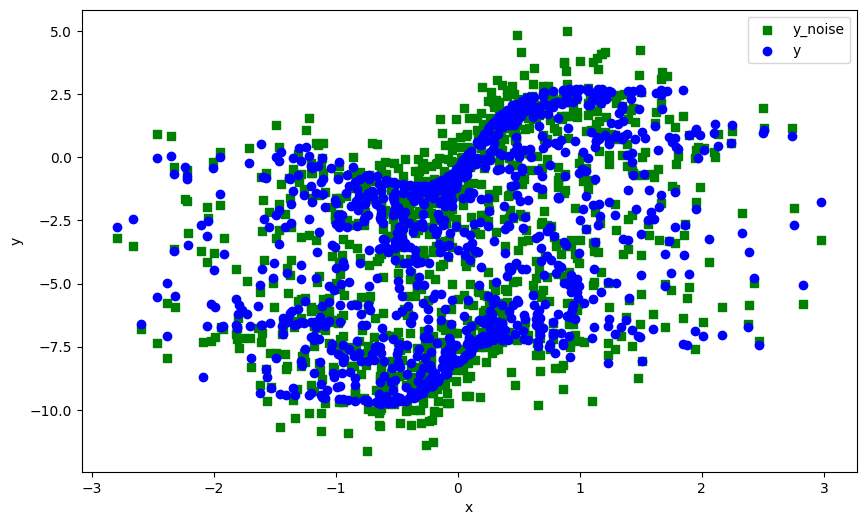

The programm is closed


In [27]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size  
plt.scatter(X_truth.detach().numpy()[:, 2], X_truth.detach().numpy()[:, 3], label='y_noise', color='green', marker='s') 
plt.scatter(X_truth.detach().numpy()[:, 2], X.detach().numpy()[:, 3], label='y', color='blue', marker='o')
#plt.scatter(X_truth.detach().numpy()[:, 0], x_est.detach().numpy()[:, 1], label='x3_est', color='red', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

init with h

In [28]:
eq_model = nonlinear.DagmaMLP(
dims=[d, 10, 1], bias=True, dtype=torch.double)
model = nonlinear.DagmaNonlinear(
    eq_model, dtype=torch.double, use_mse_loss=True)

W_est_dagma_with_h = model.fit(X_truth, lambda1=2e-2, lambda2=0.005,
                        T=1, lr=2e-4, w_threshold=0.3, mu_init=1, warm_iter=70000, max_iter=80000, consider_h=False)

# Use DAGMA weights as initial weights for DAGMA-DCE
fc1_weight_DAGMA_with_h = eq_model.fc1.weight
fc1_bias_DAGMA_with_h = eq_model.fc1.bias
fc2_weight_DAGMA_with_h = eq_model.fc2[0].weight
fc2_bias_DAGMA_with_h= eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
eq_model.fc1.weight = fc1_weight_DAGMA_with_h
eq_model.fc1.bias = fc1_bias_DAGMA_with_h
eq_model.fc2[0].weight = fc2_weight_DAGMA_with_h
eq_model.fc2[0].bias = fc2_bias_DAGMA_with_h

W_est_DAGMA_with_h, W2_DAGMA_with_h, x_est_DAGMA_with_h = model.fit(X_truth, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=5, warm_iter=7000, max_iter=8000)
    
fc1_weight_DAGMA_with_h_end = eq_model.fc1.weight
fc1_bias_DAGMA_with_h_end = eq_model.fc1.bias
fc2_weight_DAGMA_with_h_end = eq_model.fc2[0].weight
fc2_bias_DAGMA_with_h_end = eq_model.fc2[0].bias

    
_, observed_derivs = eq_model.get_graph(X_truth)
observed_derivs_mean_with_h = observed_derivs.mean(dim = 0)
observed_hess_DAGMA_with_h = eq_model.exact_hessian_diag_avg(X_truth)
Sigma_est_DAGMA_with_h = eq_model.get_Sigma()
mle_loss_DAGMA_with_h = model.mle_loss(x_est_DAGMA_with_h, X_truth, Sigma_est_DAGMA_with_h)
h_val_DAGMA_with_h = eq_model.h_func(W_est_DAGMA_with_h, W2_DAGMA_with_h)
nonlinear_reg_DAGMA_with_h = eq_model.get_nonlinear_reg(observed_derivs_mean_with_h, observed_hess_DAGMA_with_h)

84133it [00:19, 4293.15it/s]                           
100%|██████████| 36000/36000 [10:16<00:00, 58.39it/s]


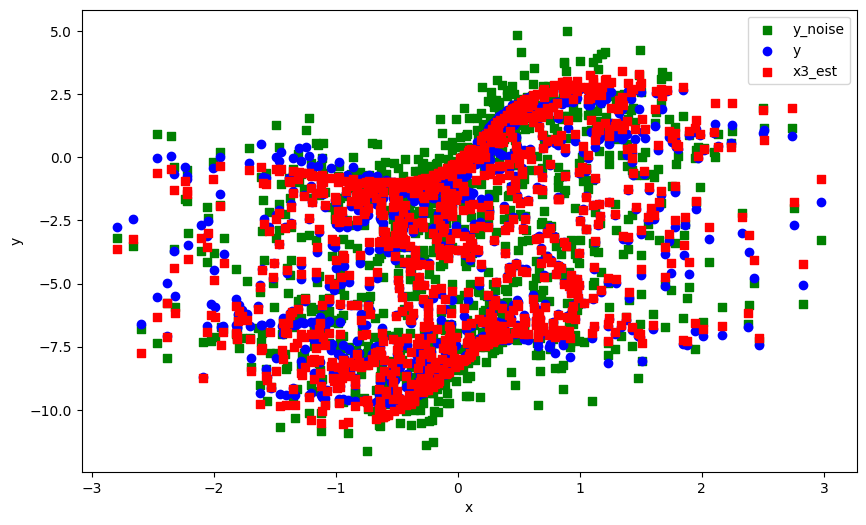

The programm is closed


In [29]:
plt.figure(figsize=(10, 6))  # Optional: specifies the figure size  
plt.scatter(X_truth.detach().numpy()[:, 2], X_truth.detach().numpy()[:, 3], label='y_noise', color='green', marker='s') 
plt.scatter(X_truth.detach().numpy()[:, 2], X.detach().numpy()[:, 3], label='y', color='blue', marker='o')
plt.scatter(X_truth.detach().numpy()[:, 2], x_est_DAGMA_with_h.detach().numpy()[:, 3], label='x3_est', color='red', marker='s') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print("The programm is closed")

In [30]:
Sigma_est_DAGMA_with_h

tensor([[ 9.6860e-01, -6.5653e-01,  8.9036e-02,  6.9062e-01],
        [-6.5653e-01,  9.8316e-01, -1.1962e-06,  9.9009e-06],
        [ 8.9036e-02, -1.1962e-06,  9.3835e-01, -1.5230e-06],
        [ 6.9062e-01,  9.9009e-06, -1.5230e-06,  1.1306e+00]],
       grad_fn=<MmBackward0>)

In [31]:
W_est_DAGMA_with_h

tensor([[9.0092e-12, 5.6048e-05, 1.3614e-05, 1.1878e-04],
        [8.7466e-05, 1.3647e-11, 3.1989e-05, 4.0262e+00],
        [6.0264e-05, 7.0846e-05, 7.7312e-13, 2.4410e+00],
        [3.5473e-05, 8.6082e-05, 3.4970e-05, 3.7378e-10]],
       grad_fn=<SqrtBackward0>)

In [32]:
mle_loss_DAGMA_with_h

tensor(1.7277, grad_fn=<AddBackward0>)

init with out h

In [47]:
eq_model = nonlinear.DagmaMLP(
dims=[d, 10, 1], bias=True, dtype=torch.double)
model = nonlinear.DagmaNonlinear(
    eq_model, dtype=torch.double, use_mse_loss=True)

W_est_dagma = model.fit(X_truth, lambda1=2e-2, lambda2=0.005,
                        T=1, lr=2e-4, w_threshold=0.3, mu_init=1, warm_iter=70000, max_iter=80000, consider_h=False)

# Use DAGMA weights as initial weights for DAGMA-DCE
fc1_weight_DAGMA = eq_model.fc1.weight
fc1_bias_DAGMA = eq_model.fc1.bias
fc2_weight_DAGMA = eq_model.fc2[0].weight
fc2_bias_DAGMA = eq_model.fc2[0].bias

eq_model = nonlinear_dce.DagmaMLP_DCE(
    dims=[d, 10, 1], bias=True)
model = nonlinear_dce.DagmaDCE(eq_model, use_mle_loss=True)
eq_model.fc1.weight = fc1_weight_DAGMA
eq_model.fc1.bias = fc1_bias_DAGMA
eq_model.fc2[0].weight = fc2_weight_DAGMA
eq_model.fc2[0].bias = fc2_bias_DAGMA

W_est_DAGMA, W2_DAGMA, x_est_DAGMA = model.fit(X_truth, lambda1=3.5e-2, lambda2=5e-3,
                                lr=2e-4, mu_factor=0.1, mu_init=1, T=5, warm_iter=7000, max_iter=8000)

  0%|          | 10/36000 [00:00<12:25, 48.25it/s]

Sigma:  tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], grad_fn=<MmBackward0>)
obj:  tensor(77.3406, grad_fn=<AddBackward0>)
mle loss:  tensor(77.3406, grad_fn=<AddBackward0>)
h_val:  tensor(1.0296e-06, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0113, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.0339e-06, -3.6792e-05, -6.7808e-03,  6.1358e-06],
        [-2.1066e-05,  8.0169e-07,  4.4128e-02,  2.0351e-02],
        [-3.0596e-05,  2.2954e-02,  7.4441e-07,  4.0361e-05],
        [ 8.5323e-03,  2.6383e-05,  1.0860e-02,  8.3315e-07]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.7940e-14, 2.2665e-11, 7.7410e-07, 6.6792e-13],
        [3.1358e-11, 2.0368e-14, 4.7329e-04, 1.0729e-04],
        [6.9833e-10, 8.9524e-04, 8.5289e-14, 7.9215e-10],
        [1.1236e-04, 4.0485e-10, 1.7517e-04, 1.0305e-13]])
mu:  1
W_current:  tensor([[1.0339e-06, 2.1068e-05, 3.0596e-05, 8.5477e-03],
        [3.6792e-05, 8.0173e-07, 2.2

  3%|▎         | 1011/36000 [00:22<11:18, 51.59it/s]

Sigma:  tensor([[ 0.6335, -0.1786, -0.1833, -0.1622],
        [-0.1786,  0.6654,  0.2380,  0.2242],
        [-0.1833,  0.2380,  1.6008,  0.2199],
        [-0.1622,  0.2242,  0.2199,  1.5755]], grad_fn=<MmBackward0>)
W_current:  tensor([[6.9687e-07, 6.7321e-05, 1.1376e+00, 1.3301e-01],
        [1.6373e-05, 5.2882e-07, 1.2305e+00, 8.3140e-01],
        [7.4183e-02, 2.1370e-02, 2.3075e-07, 1.6146e-01],
        [1.2041e-01, 3.0171e-04, 5.8900e-01, 4.0189e-07]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000, -0.1786, -0.1833, -0.1622],
        [-0.1786,  0.0000,  0.2380,  0.2242],
        [-0.1833,  0.2380,  0.0000,  0.2199],
        [-0.1622,  0.2242,  0.2199,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(19.5487, grad_fn=<AddBackward0>)
mle loss:  tensor(17.1180, grad_fn=<AddBackward0>)
h_val:  tensor(0.2107, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.2070, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 6.9658e-07,  1.5692e-05, -7.4147e-02,  1.2035e-01],
        [-4.99

  6%|▌         | 2004/36000 [00:45<15:48, 35.84it/s]

Sigma:  tensor([[ 0.3974, -0.1928, -0.0610, -0.0355],
        [-0.1928,  0.4165,  0.1810,  0.1611],
        [-0.0610,  0.1810,  2.2268,  0.5112],
        [-0.0355,  0.1611,  0.5112,  1.9158]], grad_fn=<MmBackward0>)
W_current:  tensor([[3.7071e-07, 5.9642e-05, 1.7295e+00, 1.7178e-03],
        [4.2787e-04, 3.0353e-07, 2.3994e+00, 1.7339e+00],
        [1.7887e-01, 1.0085e-01, 1.0162e-08, 1.4636e-02],
        [1.1697e-01, 8.8700e-02, 1.7520e-01, 8.2038e-08]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000, -0.1928, -0.0610, -0.0355],
        [-0.1928,  0.0000,  0.1810,  0.1611],
        [-0.0610,  0.1810,  0.0000,  0.5112],
        [-0.0355,  0.1611,  0.5112,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(5.2616, grad_fn=<AddBackward0>)
mle loss:  tensor(3.8974, grad_fn=<AddBackward0>)
h_val:  tensor(0.5119, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0626, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.6656e-07, -1.0365e-05, -1.7665e-01,  1.1292e-01],
        [ 9.8591

  8%|▊         | 3011/36000 [01:07<09:10, 59.93it/s]

Sigma:  tensor([[ 0.3328, -0.1382,  0.0529,  0.1193],
        [-0.1382,  0.2632,  0.0107, -0.0134],
        [ 0.0529,  0.0107,  2.4092,  0.5645],
        [ 0.1193, -0.0134,  0.5645,  1.7147]], grad_fn=<MmBackward0>)
W_current:  tensor([[2.6621e-07, 4.2138e-04, 9.2631e-01, 1.6531e-03],
        [5.6705e-03, 1.5610e-07, 2.9120e+00, 2.2130e+00],
        [1.9496e-01, 1.0926e-01, 2.2195e-09, 1.1108e-02],
        [1.6670e-01, 1.2636e-01, 1.1297e-02, 1.0330e-08]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000, -0.1382,  0.0529,  0.1193],
        [-0.1382,  0.0000,  0.0107, -0.0134],
        [ 0.0529,  0.0107,  0.0000,  0.5645],
        [ 0.1193, -0.0134,  0.5645,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(3.6050, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0947, grad_fn=<AddBackward0>)
h_val:  tensor(0.2812, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.1000, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.6150e-07, -2.7228e-05, -1.8590e-01,  1.4545e-01],
        [-3.3936

 11%|█         | 4009/36000 [01:24<08:46, 60.75it/s]

Sigma:  tensor([[ 0.2971, -0.1192,  0.0555,  0.2256],
        [-0.1192,  0.1924, -0.0219, -0.0601],
        [ 0.0555, -0.0219,  2.5180,  0.2593],
        [ 0.2256, -0.0601,  0.2593,  1.5605]], grad_fn=<MmBackward0>)
W_current:  tensor([[1.7723e-07, 1.8549e-03, 4.5265e-03, 3.5121e-04],
        [1.5084e-02, 7.2641e-08, 3.6721e+00, 2.3047e+00],
        [2.0397e-01, 1.0464e-01, 1.1930e-09, 1.9413e-02],
        [2.0259e-01, 1.3904e-01, 3.0430e-03, 8.0223e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000, -0.1192,  0.0555,  0.2256],
        [-0.1192,  0.0000, -0.0219, -0.0601],
        [ 0.0555, -0.0219,  0.0000,  0.2593],
        [ 0.2256, -0.0601,  0.2593,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.7807, grad_fn=<AddBackward0>)
mle loss:  tensor(1.7244, grad_fn=<AddBackward0>)
h_val:  tensor(0.3337, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0495, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.7533e-07, -2.8500e-05, -1.8747e-01,  1.7436e-01],
        [ 1.0724

 14%|█▍        | 5008/36000 [01:42<08:33, 60.37it/s]

Sigma:  tensor([[ 0.3005, -0.1064,  0.0320,  0.3345],
        [-0.1064,  0.1424, -0.0371, -0.1067],
        [ 0.0320, -0.0371,  2.5424, -0.0474],
        [ 0.3345, -0.1067, -0.0474,  1.2439]], grad_fn=<MmBackward0>)
W_current:  tensor([[6.9682e-08, 3.9897e-03, 2.1740e-03, 3.1440e-03],
        [3.1091e-02, 2.7585e-08, 3.7744e+00, 2.4485e+00],
        [1.8858e-01, 1.0420e-01, 1.1307e-09, 2.0560e-02],
        [1.8300e-01, 1.5032e-01, 7.4792e-04, 5.1146e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000, -0.1064,  0.0320,  0.3345],
        [-0.1064,  0.0000, -0.0371, -0.1067],
        [ 0.0320, -0.0371,  0.0000, -0.0474],
        [ 0.3345, -0.1067, -0.0474,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(2.1899, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0623, grad_fn=<AddBackward0>)
h_val:  tensor(0.4438, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0451, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 6.9137e-08, -4.4668e-05, -1.6399e-01,  1.4523e-01],
        [ 8.2663

 17%|█▋        | 6012/36000 [02:01<08:47, 56.82it/s]

Sigma:  tensor([[ 3.3911e-01, -9.6775e-02,  2.3964e-04,  4.4683e-01],
        [-9.6775e-02,  1.0465e-01, -6.1485e-02, -1.5159e-01],
        [ 2.3964e-04, -6.1485e-02,  2.3519e+00, -2.8964e-01],
        [ 4.4683e-01, -1.5159e-01, -2.8964e-01,  1.1404e+00]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[1.6101e-08, 5.6616e-03, 1.0368e-03, 5.4223e-03],
        [4.7114e-02, 6.7645e-09, 3.8198e+00, 2.5601e+00],
        [1.6627e-01, 1.0875e-01, 1.2114e-09, 2.3001e-02],
        [1.4015e-01, 1.5934e-01, 8.2328e-05, 4.4332e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -9.6775e-02,  2.3964e-04,  4.4683e-01],
        [-9.6775e-02,  0.0000e+00, -6.1485e-02, -1.5159e-01],
        [ 2.3964e-04, -6.1485e-02,  0.0000e+00, -2.8964e-01],
        [ 4.4683e-01, -1.5159e-01, -2.8964e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(1.6039, grad_fn=<AddBackward0>)
mle loss:  tensor(0.2830, grad_fn=<AddBackward0>)
h_val:  tensor(0.6582, grad_fn=<AddBackward0>)
nonlinear

 19%|█▉        | 7010/36000 [02:23<09:16, 52.06it/s]

Sigma:  tensor([[ 0.3875, -0.0935, -0.0570,  0.5211],
        [-0.0935,  0.0809, -0.0881, -0.1595],
        [-0.0570, -0.0881,  1.9651, -0.4559],
        [ 0.5211, -0.1595, -0.4559,  1.1360]], grad_fn=<MmBackward0>)
obj:  tensor(-0.3927, grad_fn=<AddBackward0>)
mle loss:  tensor(-0.3927, grad_fn=<AddBackward0>)
h_val:  tensor(0.8281, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0456, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.1710e-09,  5.7231e-06, -1.2905e-01,  5.1835e-02],
        [-3.0757e-02,  6.5982e-10,  1.1291e-01,  1.6480e-01],
        [ 2.7869e-05,  3.8183e+00,  1.3795e-09,  4.2939e-04],
        [ 1.6718e-05,  2.4131e+00,  1.4896e-02,  3.0464e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[3.5345e-19, 9.8294e-03, 1.5157e-02, 2.2371e-02],
        [1.5282e-03, 1.8669e-19, 2.2392e-03, 8.0517e-03],
        [4.3306e-06, 7.8418e-01, 9.9441e-20, 8.1843e-07],
        [6.0896e-04, 9.6563e-01, 9.5463e-03, 4.8199e-21]])
mu:  0.1
W_current:  tensor([[1.1781e

 22%|██▏       | 8009/36000 [02:42<07:56, 58.72it/s]

Sigma:  tensor([[ 0.3737, -0.0318, -0.0949,  0.4655],
        [-0.0318,  0.0627, -0.0546, -0.0395],
        [-0.0949, -0.0546,  1.7850, -0.3726],
        [ 0.4655, -0.0395, -0.3726,  0.8500]], grad_fn=<MmBackward0>)
W_current:  tensor([[1.3378e-10, 1.6576e-01, 1.5339e-03, 1.7573e-02],
        [5.6900e-02, 5.5879e-10, 3.1410e+00, 2.1668e+00],
        [1.1297e-01, 8.8470e-02, 2.6085e-09, 1.2422e-01],
        [8.0165e-02, 1.2087e-01, 1.8017e-01, 6.2102e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000, -0.0318, -0.0949,  0.4655],
        [-0.0318,  0.0000, -0.0546, -0.0395],
        [-0.0949, -0.0546,  0.0000, -0.3726],
        [ 0.4655, -0.0395, -0.3726,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.4118, grad_fn=<AddBackward0>)
mle loss:  tensor(0.7920, grad_fn=<AddBackward0>)
h_val:  tensor(0.2421, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0700, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.3218e-10, -1.3301e-05, -9.7875e-02, -2.9316e-04],
        [-1.6556

 25%|██▌       | 9010/36000 [03:00<07:28, 60.17it/s]

Sigma:  tensor([[ 0.4226, -0.0351, -0.0568,  0.5298],
        [-0.0351,  0.0894, -0.0308, -0.0219],
        [-0.0568, -0.0308,  2.2842, -0.3261],
        [ 0.5298, -0.0219, -0.3261,  0.9013]], grad_fn=<MmBackward0>)
W_current:  tensor([[1.2324e-10, 1.3334e-01, 3.0831e-03, 1.9923e-02],
        [7.1077e-02, 4.0498e-10, 2.8680e+00, 2.1157e+00],
        [1.0509e-01, 8.8938e-02, 1.9733e-09, 1.2391e-01],
        [8.8561e-02, 1.0336e-01, 1.8500e-01, 4.9482e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000, -0.0351, -0.0568,  0.5298],
        [-0.0351,  0.0000, -0.0308, -0.0219],
        [-0.0568, -0.0308,  0.0000, -0.3261],
        [ 0.5298, -0.0219, -0.3261,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.3499, grad_fn=<AddBackward0>)
mle loss:  tensor(1.0261, grad_fn=<AddBackward0>)
h_val:  tensor(0.1623, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0657, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.2204e-10, -5.5807e-05, -8.7613e-02, -1.3344e-02],
        [-1.3324

 28%|██▊       | 10009/36000 [03:17<08:24, 51.54it/s]

Sigma:  tensor([[ 0.4610, -0.0483, -0.0276,  0.5900],
        [-0.0483,  0.1324, -0.0055, -0.0127],
        [-0.0276, -0.0055,  2.6094, -0.2843],
        [ 0.5900, -0.0127, -0.2843,  0.9933]], grad_fn=<MmBackward0>)
W_current:  tensor([[1.0291e-10, 9.0411e-02, 4.7298e-03, 2.1497e-02],
        [8.7021e-02, 3.1641e-10, 2.9194e+00, 2.2189e+00],
        [1.0283e-01, 8.2158e-02, 1.5181e-09, 1.0471e-01],
        [8.5056e-02, 8.6365e-02, 1.3761e-01, 3.9494e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000, -0.0483, -0.0276,  0.5900],
        [-0.0483,  0.0000, -0.0055, -0.0127],
        [-0.0276, -0.0055,  0.0000, -0.2843],
        [ 0.5900, -0.0127, -0.2843,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.3100, grad_fn=<AddBackward0>)
mle loss:  tensor(1.1994, grad_fn=<AddBackward0>)
h_val:  tensor(0.1194, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0515, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 1.0200e-10, -1.4595e-05, -8.6030e-02, -3.7605e-03],
        [-9.0305

 31%|███       | 11006/36000 [03:35<07:03, 59.05it/s]

Sigma:  tensor([[ 4.8534e-01, -7.2396e-02, -9.2215e-03,  6.1715e-01],
        [-7.2396e-02,  1.9407e-01,  7.1934e-04, -8.1850e-03],
        [-9.2215e-03,  7.1934e-04,  2.5161e+00, -2.5377e-01],
        [ 6.1715e-01, -8.1850e-03, -2.5377e-01,  1.0310e+00]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[7.9045e-11, 6.3160e-02, 6.4450e-03, 2.3965e-02],
        [9.7640e-02, 2.5920e-10, 3.2316e+00, 2.3244e+00],
        [9.8283e-02, 6.5984e-02, 1.1912e-09, 9.0453e-02],
        [7.6797e-02, 7.7104e-02, 7.2145e-02, 2.9037e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000, -0.0724, -0.0092,  0.6171],
        [-0.0724,  0.0000,  0.0007, -0.0082],
        [-0.0092,  0.0007,  0.0000, -0.2538],
        [ 0.6171, -0.0082, -0.2538,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.2824, grad_fn=<AddBackward0>)
mle loss:  tensor(1.3255, grad_fn=<AddBackward0>)
h_val:  tensor(0.0932, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0367, grad_fn=<SumBackward0>)
observed_derivs:  tensor(

 33%|███▎      | 12010/36000 [03:53<06:37, 60.28it/s]

Sigma:  tensor([[ 5.1355e-01, -1.1670e-01, -3.2530e-02,  6.3422e-01],
        [-1.1670e-01,  2.8796e-01,  5.8980e-04, -4.8074e-03],
        [-3.2530e-02,  5.8980e-04,  2.2780e+00, -2.2251e-01],
        [ 6.3422e-01, -4.8074e-03, -2.2251e-01,  1.0474e+00]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[6.5282e-11, 3.7695e-02, 8.7775e-03, 2.5083e-02],
        [1.0256e-01, 2.0125e-10, 3.6571e+00, 2.4338e+00],
        [8.5089e-02, 4.7569e-02, 8.4177e-10, 7.7521e-02],
        [6.8242e-02, 6.6538e-02, 3.2946e-02, 2.5606e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -1.1670e-01, -3.2530e-02,  6.3422e-01],
        [-1.1670e-01,  0.0000e+00,  5.8980e-04, -4.8074e-03],
        [-3.2530e-02,  5.8980e-04,  0.0000e+00, -2.2251e-01],
        [ 6.3422e-01, -4.8074e-03, -2.2251e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.2570, grad_fn=<AddBackward0>)
mle loss:  tensor(1.4757, grad_fn=<AddBackward0>)
h_val:  tensor(0.0660, grad_fn=<AddBackward0>)
nonlinear

 36%|███▌      | 13011/36000 [04:10<06:18, 60.78it/s]

Sigma:  tensor([[ 5.5620e-01, -1.8815e-01, -1.1558e-01,  6.4152e-01],
        [-1.8815e-01,  4.1181e-01,  6.5252e-04, -2.4323e-03],
        [-1.1558e-01,  6.5252e-04,  2.2147e+00, -2.3937e-01],
        [ 6.4152e-01, -2.4323e-03, -2.3937e-01,  1.0411e+00]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[6.3331e-11, 1.3077e-02, 1.1117e-02, 2.5583e-02],
        [1.0372e-01, 1.4288e-10, 3.7375e+00, 2.6242e+00],
        [6.5292e-02, 3.7990e-02, 7.1102e-10, 6.3109e-02],
        [5.8742e-02, 5.0535e-02, 3.8303e-02, 1.8662e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000, -0.1881, -0.1156,  0.6415],
        [-0.1881,  0.0000,  0.0007, -0.0024],
        [-0.1156,  0.0007,  0.0000, -0.2394],
        [ 0.6415, -0.0024, -0.2394,  0.0000]], grad_fn=<SubBackward0>)
obj:  tensor(0.2393, grad_fn=<AddBackward0>)
mle loss:  tensor(1.5991, grad_fn=<AddBackward0>)
h_val:  tensor(0.0442, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0139, grad_fn=<SumBackward0>)
observed_derivs:  tensor(

 39%|███▉      | 14009/36000 [04:29<07:40, 47.73it/s]

Sigma:  tensor([[ 6.3046e-01, -2.8487e-01, -2.1046e-01,  6.4590e-01],
        [-2.8487e-01,  5.2645e-01,  4.8618e-04, -1.4578e-03],
        [-2.1046e-01,  4.8618e-04,  2.1774e+00, -2.8914e-01],
        [ 6.4590e-01, -1.4578e-03, -2.8914e-01,  1.0334e+00]],
       grad_fn=<MmBackward0>)
obj:  tensor(1.6659, grad_fn=<AddBackward0>)
mle loss:  tensor(1.6659, grad_fn=<AddBackward0>)
h_val:  tensor(0.0317, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0087, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 5.4813e-11,  2.1043e-05, -3.3605e-02, -5.3697e-05],
        [-8.9130e-05,  1.0023e-10,  3.0059e-02,  2.9060e-02],
        [-1.1208e-05,  3.6558e+00,  6.1919e-10,  6.0690e-05],
        [ 7.1284e-05,  2.3568e+00, -4.3499e-06,  1.2659e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[1.0768e-21, 5.6443e-02, 4.2069e-03, 1.5682e-02],
        [6.5360e-04, 1.7975e-21, 1.8406e-03, 1.2474e-02],
        [3.8370e-04, 1.2393e+00, 2.3607e-20, 4.1647e-03],
        [2.1536e-03, 1.8220

 42%|████▏     | 15011/36000 [04:48<06:09, 56.82it/s]

Sigma:  tensor([[ 6.2616e-01, -3.1960e-01, -1.8600e-01,  6.2316e-01],
        [-3.1960e-01,  6.6989e-01,  3.2935e-05, -3.1713e-05],
        [-1.8600e-01,  3.2935e-05,  2.1607e+00, -2.2007e-01],
        [ 6.2316e-01, -3.1713e-05, -2.2007e-01,  9.7683e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[5.9576e-11, 8.7437e-04, 1.2970e-02, 1.2514e-02],
        [6.7141e-02, 9.5673e-11, 3.7931e+00, 2.8484e+00],
        [1.7943e-02, 3.0866e-03, 4.6465e-10, 5.8843e-02],
        [2.2264e-02, 5.9183e-03, 4.0763e-02, 2.3910e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -3.1960e-01, -1.8600e-01,  6.2316e-01],
        [-3.1960e-01,  0.0000e+00,  3.2935e-05, -3.1713e-05],
        [-1.8600e-01,  3.2935e-05,  0.0000e+00, -2.2007e-01],
        [ 6.2316e-01, -3.1713e-05, -2.2007e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0269, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2600, grad_fn=<AddBackward0>)
h_val:  tensor(0.0019, grad_fn=<AddBackward0>)
nonlinear

 44%|████▍     | 16008/36000 [05:08<07:07, 46.72it/s]

Sigma:  tensor([[ 7.2468e-01, -4.0756e-01, -2.0126e-01,  6.7544e-01],
        [-4.0756e-01,  7.7411e-01,  2.3917e-05, -9.9282e-05],
        [-2.0126e-01,  2.3917e-05,  2.1559e+00, -2.1812e-01],
        [ 6.7544e-01, -9.9282e-05, -2.1812e-01,  1.0519e+00]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[5.2813e-11, 7.5293e-04, 1.2753e-02, 5.6212e-03],
        [4.2411e-02, 7.6430e-11, 3.8291e+00, 2.8950e+00],
        [9.4987e-03, 2.6909e-03, 4.1105e-10, 6.1633e-02],
        [1.3481e-02, 3.4001e-03, 3.7137e-02, 1.8627e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -4.0756e-01, -2.0126e-01,  6.7544e-01],
        [-4.0756e-01,  0.0000e+00,  2.3917e-05, -9.9282e-05],
        [-2.0126e-01,  2.3917e-05,  0.0000e+00, -2.1812e-01],
        [ 6.7544e-01, -9.9282e-05, -2.1812e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0256, grad_fn=<AddBackward0>)
mle loss:  tensor(2.2146, grad_fn=<AddBackward0>)
h_val:  tensor(0.0011, grad_fn=<AddBackward0>)
nonlinear

 47%|████▋     | 17008/36000 [05:29<05:49, 54.39it/s]

Sigma:  tensor([[ 8.1615e-01, -5.1231e-01, -2.2498e-01,  6.6865e-01],
        [-5.1231e-01,  8.4154e-01,  1.7810e-05, -1.0585e-04],
        [-2.2498e-01,  1.7810e-05,  2.1536e+00, -2.3181e-01],
        [ 6.6865e-01, -1.0585e-04, -2.3181e-01,  1.0451e+00]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[4.4482e-11, 7.2468e-04, 1.2088e-02, 3.0425e-03],
        [2.3967e-02, 7.0952e-11, 3.8591e+00, 2.8797e+00],
        [4.2873e-03, 2.5038e-03, 3.8918e-10, 5.8828e-02],
        [7.8933e-03, 2.9871e-03, 3.3378e-02, 1.6576e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -5.1231e-01, -2.2498e-01,  6.6865e-01],
        [-5.1231e-01,  0.0000e+00,  1.7810e-05, -1.0585e-04],
        [-2.2498e-01,  1.7810e-05,  0.0000e+00, -2.3181e-01],
        [ 6.6865e-01, -1.0585e-04, -2.3181e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0245, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1623, grad_fn=<AddBackward0>)
h_val:  tensor(0.0007, grad_fn=<AddBackward0>)
nonlinear

 50%|█████     | 18010/36000 [05:47<05:18, 56.51it/s]

Sigma:  tensor([[ 8.8362e-01, -6.0037e-01, -2.4212e-01,  6.4239e-01],
        [-6.0037e-01,  9.0699e-01,  1.6256e-05, -7.1709e-05],
        [-2.4212e-01,  1.6256e-05,  2.1529e+00, -2.5236e-01],
        [ 6.4239e-01, -7.1709e-05, -2.5236e-01,  1.0053e+00]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[4.0257e-11, 5.4450e-04, 1.0967e-02, 2.1833e-03],
        [1.2777e-02, 6.5661e-11, 3.8901e+00, 2.8618e+00],
        [2.6703e-03, 2.3846e-03, 3.7094e-10, 5.4918e-02],
        [4.9249e-03, 2.8036e-03, 2.9031e-02, 1.4991e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -6.0037e-01, -2.4212e-01,  6.4239e-01],
        [-6.0037e-01,  0.0000e+00,  1.6256e-05, -7.1709e-05],
        [-2.4212e-01,  1.6256e-05,  0.0000e+00, -2.5236e-01],
        [ 6.4239e-01, -7.1709e-05, -2.5236e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0239, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1194, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)
nonlinear

 53%|█████▎    | 19008/36000 [06:05<04:57, 57.20it/s]

Sigma:  tensor([[ 9.2566e-01, -6.4634e-01, -2.5603e-01,  6.3432e-01],
        [-6.4634e-01,  9.3969e-01,  1.3680e-05, -5.1303e-05],
        [-2.5603e-01,  1.3680e-05,  2.1538e+00, -2.7314e-01],
        [ 6.3432e-01, -5.1303e-05, -2.7314e-01,  9.9035e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[3.7741e-11, 3.9179e-04, 9.3439e-03, 1.5385e-03],
        [8.3318e-03, 6.2337e-11, 3.9146e+00, 2.8649e+00],
        [1.9862e-03, 2.3278e-03, 3.4675e-10, 5.0677e-02],
        [3.6272e-03, 2.7402e-03, 2.4154e-02, 1.3446e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -6.4634e-01, -2.5603e-01,  6.3432e-01],
        [-6.4634e-01,  0.0000e+00,  1.3680e-05, -5.1303e-05],
        [-2.5603e-01,  1.3680e-05,  0.0000e+00, -2.7314e-01],
        [ 6.3432e-01, -5.1303e-05, -2.7314e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0236, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0934, grad_fn=<AddBackward0>)
h_val:  tensor(0.0005, grad_fn=<AddBackward0>)
nonlinear

 56%|█████▌    | 20008/36000 [06:23<04:43, 56.42it/s]

Sigma:  tensor([[ 9.4288e-01, -6.6103e-01, -2.7301e-01,  6.3507e-01],
        [-6.6103e-01,  9.4831e-01,  1.3680e-05, -3.3966e-05],
        [-2.7301e-01,  1.3680e-05,  2.1582e+00, -3.0030e-01],
        [ 6.3507e-01, -3.3966e-05, -3.0030e-01,  9.8853e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[3.5947e-11, 2.2569e-04, 7.3933e-03, 9.7092e-04],
        [6.8421e-03, 5.9402e-11, 3.9323e+00, 2.8799e+00],
        [1.6834e-03, 2.3092e-03, 3.2361e-10, 4.5709e-02],
        [3.0764e-03, 2.7033e-03, 1.9053e-02, 1.2209e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -6.6103e-01, -2.7301e-01,  6.3507e-01],
        [-6.6103e-01,  0.0000e+00,  1.3680e-05, -3.3966e-05],
        [-2.7301e-01,  1.3680e-05,  0.0000e+00, -3.0030e-01],
        [ 6.3507e-01, -3.3966e-05, -3.0030e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0234, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0760, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)
nonlinear

 58%|█████▊    | 21007/36000 [06:41<04:23, 57.00it/s]

Sigma:  tensor([[ 9.5165e-01, -6.6630e-01, -2.8985e-01,  6.3843e-01],
        [-6.6630e-01,  9.5068e-01,  1.5025e-05, -2.7409e-05],
        [-2.8985e-01,  1.5025e-05,  2.1651e+00, -3.2819e-01],
        [ 6.3843e-01, -2.7409e-05, -3.2819e-01,  9.9135e-01]],
       grad_fn=<MmBackward0>)
obj:  tensor(2.0635, grad_fn=<AddBackward0>)
mle loss:  tensor(2.0635, grad_fn=<AddBackward0>)
h_val:  tensor(0.0004, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(0.0004, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 3.2962e-11,  2.8427e-05, -2.0196e-05,  2.6270e-06],
        [-1.9025e-05,  5.4855e-11,  2.1403e-03,  1.8972e-03],
        [-1.5847e-05,  3.7975e+00,  2.9165e-10,  1.4012e-05],
        [ 2.3093e-05,  2.2962e+00,  1.5171e-05,  9.5570e-11]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.5846e-22, 5.8700e-03, 3.4313e-04, 1.1570e-03],
        [2.2846e-04, 3.9845e-22, 1.7497e-04, 9.1668e-04],
        [2.9878e-04, 1.5053e+00, 7.8270e-21, 2.0320e-03],
        [2.0192e-06, 2.8002

 61%|██████    | 22010/36000 [06:58<04:06, 56.83it/s]

Sigma:  tensor([[ 9.3067e-01, -6.5398e-01, -2.6600e-01,  6.2044e-01],
        [-6.5398e-01,  9.4213e-01,  7.9237e-06, -2.0090e-06],
        [-2.6600e-01,  7.9237e-06,  2.2175e+00, -2.5816e-01],
        [ 6.2044e-01, -2.0090e-06, -2.5816e-01,  9.6129e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[2.9478e-11, 2.3230e-04, 3.5995e-03, 5.4293e-04],
        [4.0681e-03, 5.5116e-11, 3.9806e+00, 2.9102e+00],
        [9.8749e-04, 2.5049e-04, 2.3565e-10, 3.6000e-02],
        [1.7768e-03, 4.4209e-04, 5.4502e-03, 1.2241e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -6.5398e-01, -2.6600e-01,  6.2044e-01],
        [-6.5398e-01,  0.0000e+00,  7.9237e-06, -2.0090e-06],
        [-2.6600e-01,  7.9237e-06,  0.0000e+00, -2.5816e-01],
        [ 6.2044e-01, -2.0090e-06, -2.5816e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1126, grad_fn=<AddBackward0>)
h_val:  tensor(0.0001, grad_fn=<AddBackward0>)
nonlinear

 64%|██████▍   | 23012/36000 [07:16<03:49, 56.66it/s]

Sigma:  tensor([[ 9.1437e-01, -6.5230e-01, -2.3287e-01,  6.0866e-01],
        [-6.5230e-01,  9.4757e-01,  3.9760e-06, -2.0807e-06],
        [-2.3287e-01,  3.9760e-06,  2.2276e+00, -1.8765e-01],
        [ 6.0866e-01, -2.0807e-06, -1.8765e-01,  9.5416e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[3.4757e-11, 2.1113e-04, 2.8798e-03, 2.7110e-04],
        [2.4406e-03, 5.5807e-11, 3.9760e+00, 2.9276e+00],
        [4.8696e-04, 2.5991e-04, 2.8498e-10, 3.4812e-02],
        [9.0612e-04, 2.9568e-04, 4.0532e-03, 1.2350e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -6.5230e-01, -2.3287e-01,  6.0866e-01],
        [-6.5230e-01,  0.0000e+00,  3.9760e-06, -2.0807e-06],
        [-2.3287e-01,  3.9760e-06,  0.0000e+00, -1.8765e-01],
        [ 6.0866e-01, -2.0807e-06, -1.8765e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1315, grad_fn=<AddBackward0>)
h_val:  tensor(5.0862e-05, grad_fn=<AddBackward0>)
nonli

 67%|██████▋   | 24010/36000 [07:34<03:42, 53.81it/s]

Sigma:  tensor([[ 9.2413e-01, -6.6521e-01, -2.0737e-01,  6.1519e-01],
        [-6.6521e-01,  9.7005e-01,  2.8852e-06, -3.4680e-06],
        [-2.0737e-01,  2.8852e-06,  2.2077e+00, -1.5789e-01],
        [ 6.1519e-01, -3.4680e-06, -1.5789e-01,  9.6632e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[3.3911e-11, 1.8542e-04, 2.4022e-03, 1.7396e-04],
        [1.6055e-03, 5.4280e-11, 3.9723e+00, 2.9343e+00],
        [2.6697e-04, 2.5240e-04, 2.9054e-10, 3.4317e-02],
        [4.9447e-04, 2.8810e-04, 3.4540e-03, 1.2701e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -6.6521e-01, -2.0737e-01,  6.1519e-01],
        [-6.6521e-01,  0.0000e+00,  2.8852e-06, -3.4680e-06],
        [-2.0737e-01,  2.8852e-06,  0.0000e+00, -1.5789e-01],
        [ 6.1519e-01, -3.4680e-06, -1.5789e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1372, grad_fn=<AddBackward0>)
h_val:  tensor(3.3710e-05, grad_fn=<AddBackward0>)
nonli

 69%|██████▉   | 25007/36000 [07:51<03:20, 54.94it/s]

Sigma:  tensor([[ 9.3654e-01, -6.7507e-01, -1.8586e-01,  6.2444e-01],
        [-6.7507e-01,  9.8305e-01,  2.1964e-06, -3.6716e-06],
        [-1.8586e-01,  2.1964e-06,  2.1861e+00, -1.4371e-01],
        [ 6.2444e-01, -3.6716e-06, -1.4371e-01,  9.7998e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[3.2932e-11, 1.5779e-04, 2.0769e-03, 1.4446e-04],
        [1.2753e-03, 5.2973e-11, 3.9725e+00, 2.9269e+00],
        [1.8838e-04, 2.4357e-04, 2.9174e-10, 3.4341e-02],
        [3.5310e-04, 2.8424e-04, 3.0317e-03, 1.2321e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -6.7507e-01, -1.8586e-01,  6.2444e-01],
        [-6.7507e-01,  0.0000e+00,  2.1964e-06, -3.6716e-06],
        [-1.8586e-01,  2.1964e-06,  0.0000e+00, -1.4371e-01],
        [ 6.2444e-01, -3.6716e-06, -1.4371e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1392, grad_fn=<AddBackward0>)
h_val:  tensor(2.7586e-05, grad_fn=<AddBackward0>)
nonli

 72%|███████▏  | 26010/36000 [08:09<02:54, 57.16it/s]

Sigma:  tensor([[ 9.4539e-01, -6.8002e-01, -1.7028e-01,  6.3069e-01],
        [-6.8002e-01,  9.8560e-01,  1.8221e-06, -3.3818e-06],
        [-1.7028e-01,  1.8221e-06,  2.1744e+00, -1.3492e-01],
        [ 6.3069e-01, -3.3818e-06, -1.3492e-01,  9.8919e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[3.2023e-11, 1.4113e-04, 1.7514e-03, 1.1043e-04],
        [1.1658e-03, 5.2497e-11, 3.9753e+00, 2.9138e+00],
        [1.6736e-04, 2.3783e-04, 2.8807e-10, 3.4568e-02],
        [3.1445e-04, 2.8619e-04, 2.6949e-03, 1.1992e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -6.8002e-01, -1.7028e-01,  6.3069e-01],
        [-6.8002e-01,  0.0000e+00,  1.8221e-06, -3.3818e-06],
        [-1.7028e-01,  1.8221e-06,  0.0000e+00, -1.3492e-01],
        [ 6.3069e-01, -3.3818e-06, -1.3492e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1407, grad_fn=<AddBackward0>)
h_val:  tensor(2.4607e-05, grad_fn=<AddBackward0>)
nonli

 75%|███████▌  | 27007/36000 [08:27<02:35, 57.71it/s]

Sigma:  tensor([[ 9.5165e-01, -6.8377e-01, -1.6358e-01,  6.3355e-01],
        [-6.8377e-01,  9.8619e-01,  1.7323e-06, -2.8022e-06],
        [-1.6358e-01,  1.7323e-06,  2.1678e+00, -1.3383e-01],
        [ 6.3355e-01, -2.8022e-06, -1.3383e-01,  9.9324e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[3.1012e-11, 1.2321e-04, 1.4881e-03, 7.9506e-05],
        [1.1065e-03, 5.2020e-11, 3.9790e+00, 2.9050e+00],
        [1.5742e-04, 2.3436e-04, 2.8102e-10, 3.4239e-02],
        [2.9331e-04, 2.8901e-04, 2.3624e-03, 1.1809e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -6.8377e-01, -1.6358e-01,  6.3355e-01],
        [-6.8377e-01,  0.0000e+00,  1.7323e-06, -2.8022e-06],
        [-1.6358e-01,  1.7323e-06,  0.0000e+00, -1.3383e-01],
        [ 6.3355e-01, -2.8022e-06, -1.3383e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0024, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1389, grad_fn=<AddBackward0>)
h_val:  tensor(2.3663e-05, grad_fn=<AddBackward0>)
nonli

 78%|███████▊  | 28011/36000 [08:46<02:22, 55.96it/s]

Sigma:  tensor([[ 9.5568e-01, -6.8681e-01, -1.6708e-01,  6.3369e-01],
        [-6.8681e-01,  9.8681e-01,  1.6331e-06, -2.6140e-06],
        [-1.6708e-01,  1.6331e-06,  2.1599e+00, -1.4469e-01],
        [ 6.3369e-01, -2.6140e-06, -1.4469e-01,  9.9217e-01]],
       grad_fn=<MmBackward0>)
obj:  tensor(2.1315, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1315, grad_fn=<AddBackward0>)
h_val:  tensor(2.4324e-05, grad_fn=<AddBackward0>)
nonlinear_reg:  tensor(6.4553e-05, grad_fn=<SumBackward0>)
observed_derivs:  tensor([[ 2.8304e-11, -6.7030e-06, -1.1648e-05, -2.8829e-05],
        [ 2.9398e-05,  5.1299e-11,  2.1198e-04,  1.8967e-04],
        [-3.8798e-05,  3.8229e+00,  2.6204e-10, -7.1740e-05],
        [ 1.2467e-05,  2.2974e+00, -4.7075e-05,  1.0231e-10]],
       grad_fn=<MeanBackward1>)
observed_hess:  tensor([[5.0793e-22, 1.6254e-03, 3.2525e-05, 1.4040e-04],
        [1.9537e-04, 3.6190e-22, 2.6750e-05, 1.2551e-04],
        [8.3777e-05, 1.5861e+00, 7.2819e-21, 2.2556e-04],
        [2.5081e-07

 81%|████████  | 29007/36000 [09:03<02:04, 56.35it/s]

Sigma:  tensor([[ 9.6561e-01, -6.9061e-01, -1.6871e-01,  6.3751e-01],
        [-6.9061e-01,  9.8685e-01,  1.2143e-06,  2.1572e-06],
        [-1.6871e-01,  1.2143e-06,  2.1567e+00, -1.4708e-01],
        [ 6.3751e-01,  2.1572e-06, -1.4708e-01,  9.9366e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[2.5574e-11, 1.1821e-04, 1.1844e-03, 1.1082e-04],
        [9.8483e-04, 1.1701e-10, 4.0012e+00, 2.9267e+00],
        [1.4255e-04, 5.8507e-05, 6.4656e-10, 2.7621e-02],
        [2.6267e-04, 1.0732e-04, 1.9953e-03, 1.5687e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -6.9061e-01, -1.6871e-01,  6.3751e-01],
        [-6.9061e-01,  0.0000e+00,  1.2143e-06,  2.1572e-06],
        [-1.6871e-01,  1.2143e-06,  0.0000e+00, -1.4708e-01],
        [ 6.3751e-01,  2.1572e-06, -1.4708e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0003, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1426, grad_fn=<AddBackward0>)
h_val:  tensor(1.7539e-05, grad_fn=<AddBackward0>)
nonli

 83%|████████▎ | 30009/36000 [09:21<01:45, 56.61it/s]

Sigma:  tensor([[ 9.6026e-01, -6.8720e-01, -1.6168e-01,  6.3144e-01],
        [-6.8720e-01,  9.8434e-01,  9.4899e-07, -4.2501e-07],
        [-1.6168e-01,  9.4899e-07,  2.1835e+00, -1.2530e-01],
        [ 6.3144e-01, -4.2501e-07, -1.2530e-01,  9.8275e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[2.9633e-11, 1.1056e-04, 1.1790e-03, 8.6070e-05],
        [6.7984e-04, 4.5851e-11, 3.9998e+00, 2.9293e+00],
        [9.4369e-05, 4.3955e-05, 2.5937e-10, 2.7483e-02],
        [1.9468e-04, 7.6985e-05, 1.9505e-03, 9.0966e-11]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -6.8720e-01, -1.6168e-01,  6.3144e-01],
        [-6.8720e-01,  0.0000e+00,  9.4899e-07, -4.2501e-07],
        [-1.6168e-01,  9.4899e-07,  0.0000e+00, -1.2530e-01],
        [ 6.3144e-01, -4.2501e-07, -1.2530e-01,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0002, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1451, grad_fn=<AddBackward0>)
h_val:  tensor(1.2417e-05, grad_fn=<AddBackward0>)
nonli

 86%|████████▌ | 31011/36000 [09:39<01:28, 56.55it/s]

Sigma:  tensor([[ 9.4131e-01, -6.7922e-01, -1.5106e-01,  6.2040e-01],
        [-6.7922e-01,  9.8169e-01,  7.2054e-07, -3.8331e-07],
        [-1.5106e-01,  7.2054e-07,  2.2227e+00, -9.6163e-02],
        [ 6.2040e-01, -3.8331e-07, -9.6163e-02,  9.7128e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[3.0268e-11, 1.0062e-04, 1.1351e-03, 5.8141e-05],
        [5.6228e-04, 4.7741e-11, 3.9976e+00, 2.9407e+00],
        [9.0411e-05, 4.2509e-05, 2.5265e-10, 2.7413e-02],
        [1.8643e-04, 7.4735e-05, 1.8831e-03, 1.1043e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -6.7922e-01, -1.5106e-01,  6.2040e-01],
        [-6.7922e-01,  0.0000e+00,  7.2054e-07, -3.8331e-07],
        [-1.5106e-01,  7.2054e-07,  0.0000e+00, -9.6163e-02],
        [ 6.2040e-01, -3.8331e-07, -9.6163e-02,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0002, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1517, grad_fn=<AddBackward0>)
h_val:  tensor(7.3753e-06, grad_fn=<AddBackward0>)
nonli

 89%|████████▉ | 32008/36000 [09:57<01:11, 56.20it/s]

Sigma:  tensor([[ 9.2708e-01, -6.7354e-01, -1.3995e-01,  6.1230e-01],
        [-6.7354e-01,  9.7989e-01,  5.0321e-07, -3.6351e-07],
        [-1.3995e-01,  5.0321e-07,  2.2627e+00, -6.5435e-02],
        [ 6.1230e-01, -3.6351e-07, -6.5435e-02,  9.6461e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[3.0393e-11, 8.8446e-05, 1.0814e-03, 2.6239e-05],
        [4.9498e-04, 4.8861e-11, 3.9941e+00, 2.9477e+00],
        [8.3504e-05, 4.1178e-05, 2.4952e-10, 2.7576e-02],
        [1.7054e-04, 7.2148e-05, 1.8197e-03, 1.2592e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -6.7354e-01, -1.3995e-01,  6.1230e-01],
        [-6.7354e-01,  0.0000e+00,  5.0321e-07, -3.6351e-07],
        [-1.3995e-01,  5.0321e-07,  0.0000e+00, -6.5435e-02],
        [ 6.1230e-01, -3.6351e-07, -6.5435e-02,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0002, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1628, grad_fn=<AddBackward0>)
h_val:  tensor(3.5908e-06, grad_fn=<AddBackward0>)
nonli

 92%|█████████▏| 33010/36000 [10:15<00:53, 56.08it/s]

Sigma:  tensor([[ 9.2456e-01, -6.7345e-01, -1.3082e-01,  6.1168e-01],
        [-6.7345e-01,  9.8029e-01,  3.3615e-07, -2.9686e-07],
        [-1.3082e-01,  3.3615e-07,  2.2834e+00, -4.1860e-02],
        [ 6.1168e-01, -2.9686e-07, -4.1860e-02,  9.6887e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[3.0237e-11, 7.5112e-05, 1.0146e-03, 1.1633e-05],
        [4.3168e-04, 4.9659e-11, 3.9897e+00, 2.9456e+00],
        [7.3738e-05, 3.9744e-05, 2.5095e-10, 2.8170e-02],
        [1.5004e-04, 6.9240e-05, 1.7588e-03, 1.3135e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -6.7345e-01, -1.3082e-01,  6.1168e-01],
        [-6.7345e-01,  0.0000e+00,  3.3615e-07, -2.9686e-07],
        [-1.3082e-01,  3.3615e-07,  0.0000e+00, -4.1860e-02],
        [ 6.1168e-01, -2.9686e-07, -4.1860e-02,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0002, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1724, grad_fn=<AddBackward0>)
h_val:  tensor(1.6525e-06, grad_fn=<AddBackward0>)
nonli

 94%|█████████▍| 34012/36000 [10:32<00:35, 56.42it/s]

Sigma:  tensor([[ 9.3476e-01, -6.7932e-01, -1.2444e-01,  6.1935e-01],
        [-6.7932e-01,  9.8358e-01,  2.6713e-07, -2.4289e-07],
        [-1.2444e-01,  2.6713e-07,  2.2822e+00, -3.0061e-02],
        [ 6.1935e-01, -2.4289e-07, -3.0061e-02,  9.8355e-01]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[2.9769e-11, 6.0621e-05, 9.2663e-04, 1.0572e-05],
        [3.6441e-04, 4.9872e-11, 3.9858e+00, 2.9336e+00],
        [6.3386e-05, 3.7965e-05, 2.5559e-10, 2.9397e-02],
        [1.2785e-04, 6.6461e-05, 1.6959e-03, 1.2895e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -6.7932e-01, -1.2444e-01,  6.1935e-01],
        [-6.7932e-01,  0.0000e+00,  2.6713e-07, -2.4289e-07],
        [-1.2444e-01,  2.6713e-07,  0.0000e+00, -3.0061e-02],
        [ 6.1935e-01, -2.4289e-07, -3.0061e-02,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0002, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1764, grad_fn=<AddBackward0>)
h_val:  tensor(9.8351e-07, grad_fn=<AddBackward0>)
nonli

 97%|█████████▋| 35010/36000 [10:50<00:17, 56.87it/s]

Sigma:  tensor([[ 9.5030e-01, -6.8727e-01, -1.1829e-01,  6.3048e-01],
        [-6.8727e-01,  9.8747e-01,  2.4286e-07, -1.7206e-07],
        [-1.1829e-01,  2.4286e-07,  2.2798e+00, -2.4809e-02],
        [ 6.3048e-01, -1.7206e-07, -2.4809e-02,  1.0013e+00]],
       grad_fn=<MmBackward0>)
W_current:  tensor([[2.9054e-11, 5.0534e-05, 8.2779e-04, 6.1960e-06],
        [2.9661e-04, 4.9613e-11, 3.9836e+00, 2.9167e+00],
        [5.4913e-05, 3.6128e-05, 2.5831e-10, 3.1264e-02],
        [1.0875e-04, 6.4130e-05, 1.6071e-03, 1.2381e-10]],
       grad_fn=<SqrtBackward0>)
W2:  tensor([[ 0.0000e+00, -6.8727e-01, -1.1829e-01,  6.3048e-01],
        [-6.8727e-01,  0.0000e+00,  2.4286e-07, -1.7206e-07],
        [-1.1829e-01,  2.4286e-07,  0.0000e+00, -2.4809e-02],
        [ 6.3048e-01, -1.7206e-07, -2.4809e-02,  0.0000e+00]],
       grad_fn=<SubBackward0>)
obj:  tensor(0.0002, grad_fn=<AddBackward0>)
mle loss:  tensor(2.1770, grad_fn=<AddBackward0>)
h_val:  tensor(7.5843e-07, grad_fn=<AddBackward0>)
nonli

100%|██████████| 36000/36000 [11:08<00:00, 53.87it/s]
